- [x] Найти данные в виде изображений для задачи классификации. Например, можно взять данные [отсюда](http://ufldl.stanford.edu/housenumbers/).
- [x] Реализовать классы, необходимые для построения сети со следующими слоями
	- FullyConnectedLayer
	- ReluLayer
	- FullyConnectedLayer
- [x] Использовать CrossEntropyLoss и L2-регуляризацию.
- [x] Обучить модель на тренировочных данных, подбирать параметры (особенно learning rate) на валидационной и оценить качество на тестовой. Анализировать графики train/val loss, проверять на каждом шаге корректность вычисления градиентов с помощью разностной оценки.
- [x] * (**+2 балла**) Добавить Batch normalization.
- [x] * (**+2 балла**) В качестве оптимизатор использовать один из: Momentum, RMSprop.
- [x] * (**+1 балл**) Также реализовать оптимизатор Adam.

В качестве датасета используем SVHN, представляющий собой набор данных из цифр, встречающихся в реальном мире. Решим задачу классификации цифр на изображении.

> SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. It can be seen as similar in flavor to MNIST (e.g., the images are of small cropped digits), but incorporates an order of magnitude more labeled data (over 600,000 digit images) and comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images.

In [ ]:
!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
import numpy as np
import matplotlib.pyplot as plt
import torch


Загрузим датасет и предобработаем данные: центрируем их и нормализуеум.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(float) / 255.0

    # Subtract mean
    mean_image = np.mean(train_flat, axis=0)
    train_flat -= mean_image
    test_flat -= mean_image

    return train_flat, test_flat


_train_X, _train_y, _test_X, _test_y = load_svhn("./", max_train=10000, max_test=1000)
train_X, test_X = prepare_for_linear_classifier(_train_X, _test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, _train_y, num_val=1000)

print(train_X.shape)
print(val_X.shape)

(9000, 3072)
(1000, 3072)


Всего 10000 экземпляров. Соотношение — 9 на обучение к 1 на тесты. 

Несколько образцов из датасета

Размерность экземпляра: (32, 32, 3)


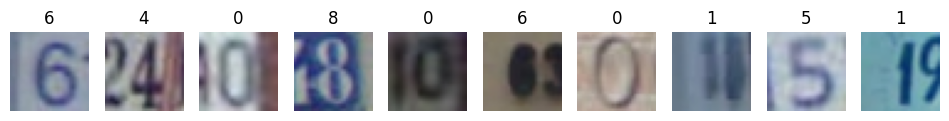

In [4]:
fig, axes = plt.subplots(1, 10, figsize=(12, 3))
print(f"Размерность экземпляра: {_train_X[0].shape}")
for i in range(10):
    axes[i].imshow(_train_X[i].astype(int))
    axes[i].set_title(_train_y[i])
    axes[i].axis("off")
plt.show()

In [5]:
from torch.autograd import Function
import torch.nn as nn

from gradient_check import GRADIENT_CHECK_DELTA


class CustomLinearLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weights = nn.Parameter(
            torch.empty(
                (in_features, out_features), dtype=torch.float32, requires_grad=True
            )
        )
        self.bias = nn.Parameter(torch.empty(out_features))
        nn.init.kaiming_normal_(self.weights, mode="fan_in", nonlinearity="relu")
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return torch.matmul(x, self.weights) + self.bias


def relu(x):
    x = torch.Tensor(x).float()
    result = torch.max(x, torch.zeros(x.shape))
    is_predefined_grad = x <= GRADIENT_CHECK_DELTA
    mask = (result > 0).float()
    return result, mask, is_predefined_grad


class CustomRelu(Function):
    """CustomRelu. Warning: intentionally inefficient. Calculates `check_gradient` on each call with `grad_check` == True."""

    grad_check = True

    @staticmethod
    def forward(ctx, x):
        if CustomRelu.grad_check:
            check_gradient(relu, x)
        x, x_grad, _ = relu(x)
        ctx.save_for_backward(x_grad)
        return x

    @staticmethod
    def backward(ctx, grad_output):
        (x_grad,) = ctx.saved_tensors
        return grad_output * x_grad


class CustomReLUActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return CustomRelu.apply(x)

In [6]:
class NN(nn.Module):
    def __init__(self, input_dim, hidden, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            CustomLinearLayer(input_dim, hidden),
            CustomReLUActivation(),
            CustomLinearLayer(hidden, output_dim),
        )

    def forward(self, x):
        return self.model(x)


Функции для обучения, графиков обучения. Будем использовать L2 регуляризацию при обучении. 

In [7]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


def numpy_to_loader(X, y, batch_size=64, shuffle=True):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


train_loader = numpy_to_loader(train_X, train_y)
val_loader = numpy_to_loader(val_X, val_y)
test_loader = numpy_to_loader(test_X, _test_y, shuffle=False)


def train_model(
    model,
    train_loader,
    val_loader,
    criterion_init=nn.CrossEntropyLoss,
    optimizer_init=optim.SGD,
    lr=3e-2,
    epochs=10,
    reg=0.0,
):
    criterion = criterion_init()
    optimizer = optimizer_init(model.parameters(), lr=lr, weight_decay=reg)
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x_batch.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        train_losses.append(total_loss / total)
        train_accs.append(correct / total)

        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(
            f"Epoch {epoch + 1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_accs[-1]:.4f} | Val Acc: {val_acc:.4f}"
        )

    return train_losses, val_losses, train_accs, val_accs


def evaluate_model(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x_batch, y_batch in loader:
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item() * x_batch.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    return total_loss / total, correct / total


def plot_curves(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


Запустим обучение на одной эпохе с проверкой подсчета градиента. 

In [ ]:
CustomRelu.grad_check = True

model = NN(input_dim=3072, hidden=100, output_dim=10)

train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, lr=1e-1, epochs=1, reg=1e-4
)

Epoch 1/1 | Train Loss: 3.5163 | Val Loss: 1.8675 | Train Acc: 0.2517 | Val Acc: 0.4180


Вычисление градиентов корректное, теперь обучим модель, но без проверок градиента.

Epoch 1/100 | Train Loss: 3.4261 | Val Loss: 1.8352 | Train Acc: 0.2536 | Val Acc: 0.4140
Epoch 2/100 | Train Loss: 1.5952 | Val Loss: 1.7943 | Train Acc: 0.4852 | Val Acc: 0.4970
Epoch 3/100 | Train Loss: 1.2885 | Val Loss: 1.4025 | Train Acc: 0.5902 | Val Acc: 0.5530
Epoch 4/100 | Train Loss: 1.1250 | Val Loss: 1.2155 | Train Acc: 0.6403 | Val Acc: 0.6270
Epoch 5/100 | Train Loss: 1.0074 | Val Loss: 1.2066 | Train Acc: 0.6811 | Val Acc: 0.6130
Epoch 6/100 | Train Loss: 0.9381 | Val Loss: 1.1118 | Train Acc: 0.7044 | Val Acc: 0.6460
Epoch 7/100 | Train Loss: 0.8765 | Val Loss: 1.1249 | Train Acc: 0.7229 | Val Acc: 0.6410
Epoch 8/100 | Train Loss: 0.8273 | Val Loss: 1.0428 | Train Acc: 0.7404 | Val Acc: 0.6790
Epoch 9/100 | Train Loss: 0.7850 | Val Loss: 1.0714 | Train Acc: 0.7562 | Val Acc: 0.6730
Epoch 10/100 | Train Loss: 0.7493 | Val Loss: 1.0761 | Train Acc: 0.7651 | Val Acc: 0.6740
Epoch 11/100 | Train Loss: 0.7157 | Val Loss: 1.0285 | Train Acc: 0.7772 | Val Acc: 0.6960
Epoch 12

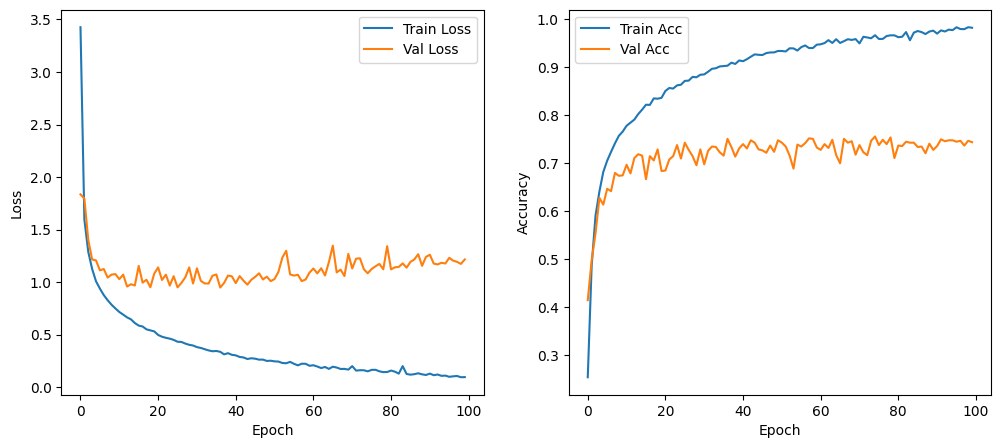

In [8]:
CustomRelu.grad_check = False
model = NN(input_dim=3072, hidden=100, output_dim=10)

train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, lr=1e-1, epochs=100, reg=1e-4
)

plot_curves(train_losses, val_losses, train_accs, val_accs)


Метрики качества по мере подбора весов подросли (хоть и оверфитнуло), получили классификатор лучше, чем случайный. Нужные слои реализованы корректно.

Следующий шаг -- оптимизации модели и подбор гиперпараметров.

1. Добавим batch normalization.
2. Используем оптимизатор Momentum.

In [9]:
class NN(nn.Module):
    def __init__(self, input_dim, hidden, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            CustomLinearLayer(input_dim, hidden),
            nn.BatchNorm1d(hidden),
            CustomReLUActivation(),
            CustomLinearLayer(hidden, output_dim),
        )

    def forward(self, x):
        return self.model(x)

In [11]:
import optuna
from torch.optim import RMSprop


def objective(trial):
    hidden = trial.suggest_categorical("hidden", [64, 128, 256])
    lr = trial.suggest_float("lr", 1e-3, 1e-1, log=True)
    reg = trial.suggest_float("reg", 1e-6, 1e-2, log=True)

    model = NN(input_dim=3072, hidden=hidden, output_dim=10)
    _, val_losses, _, _ = train_model(
        model, train_loader, val_loader, lr=lr, reg=reg, optimizer_init=RMSprop
    )
    return min(val_losses)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=300)
print(study.best_params)


/root/programming/ml-course/.env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-12 20:00:54,826] A new study created in memory with name: no-name-b672446f-bbc2-4dfe-b373-ce8bfa6b6ba0


Epoch 1/10 | Train Loss: 2.4131 | Val Loss: 1.8078 | Train Acc: 0.2600 | Val Acc: 0.3740
Epoch 2/10 | Train Loss: 1.6214 | Val Loss: 1.4870 | Train Acc: 0.4610 | Val Acc: 0.4960
Epoch 3/10 | Train Loss: 1.3819 | Val Loss: 1.2816 | Train Acc: 0.5484 | Val Acc: 0.5970
Epoch 4/10 | Train Loss: 1.2756 | Val Loss: 1.2774 | Train Acc: 0.5821 | Val Acc: 0.6030
Epoch 5/10 | Train Loss: 1.1911 | Val Loss: 1.4265 | Train Acc: 0.6187 | Val Acc: 0.5720
Epoch 6/10 | Train Loss: 1.1444 | Val Loss: 1.2154 | Train Acc: 0.6348 | Val Acc: 0.6130
Epoch 7/10 | Train Loss: 1.1079 | Val Loss: 1.1689 | Train Acc: 0.6559 | Val Acc: 0.6200
Epoch 8/10 | Train Loss: 1.0571 | Val Loss: 1.1097 | Train Acc: 0.6678 | Val Acc: 0.6410
Epoch 9/10 | Train Loss: 1.0272 | Val Loss: 1.1405 | Train Acc: 0.6757 | Val Acc: 0.6380


[I 2025-04-12 20:01:04,664] Trial 0 finished with value: 1.1069202575683594 and parameters: {'hidden': 128, 'lr': 0.018905699999832038, 'reg': 1.9337229630879582e-06}. Best is trial 0 with value: 1.1069202575683594.


Epoch 10/10 | Train Loss: 0.9974 | Val Loss: 1.1069 | Train Acc: 0.6820 | Val Acc: 0.6500
Epoch 1/10 | Train Loss: 2.1292 | Val Loss: 1.8038 | Train Acc: 0.3119 | Val Acc: 0.4140
Epoch 2/10 | Train Loss: 1.5803 | Val Loss: 1.6297 | Train Acc: 0.4872 | Val Acc: 0.4800
Epoch 3/10 | Train Loss: 1.3487 | Val Loss: 1.7654 | Train Acc: 0.5646 | Val Acc: 0.5050
Epoch 4/10 | Train Loss: 1.2425 | Val Loss: 1.2595 | Train Acc: 0.6026 | Val Acc: 0.6030
Epoch 5/10 | Train Loss: 1.1516 | Val Loss: 1.2157 | Train Acc: 0.6343 | Val Acc: 0.6270
Epoch 6/10 | Train Loss: 1.1121 | Val Loss: 1.1764 | Train Acc: 0.6494 | Val Acc: 0.6240
Epoch 7/10 | Train Loss: 1.0587 | Val Loss: 1.0787 | Train Acc: 0.6652 | Val Acc: 0.6790
Epoch 8/10 | Train Loss: 1.0146 | Val Loss: 1.3300 | Train Acc: 0.6776 | Val Acc: 0.5940
Epoch 9/10 | Train Loss: 0.9836 | Val Loss: 1.0756 | Train Acc: 0.6872 | Val Acc: 0.6700


[I 2025-04-12 20:01:12,809] Trial 1 finished with value: 1.0756351490020752 and parameters: {'hidden': 128, 'lr': 0.0021945414812073296, 'reg': 0.00021694933033644388}. Best is trial 1 with value: 1.0756351490020752.


Epoch 10/10 | Train Loss: 0.9534 | Val Loss: 1.0971 | Train Acc: 0.6939 | Val Acc: 0.6650
Epoch 1/10 | Train Loss: 2.0405 | Val Loss: 1.6540 | Train Acc: 0.3220 | Val Acc: 0.4550
Epoch 2/10 | Train Loss: 1.5475 | Val Loss: 1.5142 | Train Acc: 0.4906 | Val Acc: 0.5290
Epoch 3/10 | Train Loss: 1.3323 | Val Loss: 1.3822 | Train Acc: 0.5762 | Val Acc: 0.5590
Epoch 4/10 | Train Loss: 1.2297 | Val Loss: 1.2100 | Train Acc: 0.6046 | Val Acc: 0.6260
Epoch 5/10 | Train Loss: 1.1494 | Val Loss: 1.1630 | Train Acc: 0.6332 | Val Acc: 0.6540
Epoch 6/10 | Train Loss: 1.0958 | Val Loss: 1.1462 | Train Acc: 0.6468 | Val Acc: 0.6540
Epoch 7/10 | Train Loss: 1.0476 | Val Loss: 1.0900 | Train Acc: 0.6699 | Val Acc: 0.6610
Epoch 8/10 | Train Loss: 1.0067 | Val Loss: 1.2617 | Train Acc: 0.6849 | Val Acc: 0.6350
Epoch 9/10 | Train Loss: 0.9803 | Val Loss: 1.1742 | Train Acc: 0.6883 | Val Acc: 0.6450


[I 2025-04-12 20:01:19,561] Trial 2 finished with value: 1.0900445699691772 and parameters: {'hidden': 64, 'lr': 0.002462915983514676, 'reg': 9.379387836626521e-05}. Best is trial 1 with value: 1.0756351490020752.


Epoch 10/10 | Train Loss: 0.9635 | Val Loss: 1.2285 | Train Acc: 0.6940 | Val Acc: 0.6370
Epoch 1/10 | Train Loss: 3.0448 | Val Loss: 2.3103 | Train Acc: 0.1868 | Val Acc: 0.2060
Epoch 2/10 | Train Loss: 2.2341 | Val Loss: 2.7443 | Train Acc: 0.1947 | Val Acc: 0.2060
Epoch 3/10 | Train Loss: 2.2326 | Val Loss: 2.4251 | Train Acc: 0.1959 | Val Acc: 0.1220
Epoch 4/10 | Train Loss: 2.2351 | Val Loss: 2.2116 | Train Acc: 0.1923 | Val Acc: 0.2060
Epoch 5/10 | Train Loss: 2.2396 | Val Loss: 2.2185 | Train Acc: 0.1937 | Val Acc: 0.2060
Epoch 6/10 | Train Loss: 2.2455 | Val Loss: 2.2429 | Train Acc: 0.1900 | Val Acc: 0.1560
Epoch 7/10 | Train Loss: 2.2445 | Val Loss: 2.2265 | Train Acc: 0.1913 | Val Acc: 0.2060
Epoch 8/10 | Train Loss: 2.2403 | Val Loss: 3.0659 | Train Acc: 0.1917 | Val Acc: 0.2060
Epoch 9/10 | Train Loss: 2.2415 | Val Loss: 2.2163 | Train Acc: 0.1919 | Val Acc: 0.2060


[I 2025-04-12 20:01:33,056] Trial 3 finished with value: 2.2108473262786865 and parameters: {'hidden': 256, 'lr': 0.04710802302660427, 'reg': 0.0013150637890392625}. Best is trial 1 with value: 1.0756351490020752.


Epoch 10/10 | Train Loss: 2.2464 | Val Loss: 2.2108 | Train Acc: 0.1907 | Val Acc: 0.2060
Epoch 1/10 | Train Loss: 2.8786 | Val Loss: 2.2226 | Train Acc: 0.1833 | Val Acc: 0.2060
Epoch 2/10 | Train Loss: 2.2453 | Val Loss: 2.2293 | Train Acc: 0.1894 | Val Acc: 0.2060
Epoch 3/10 | Train Loss: 2.2477 | Val Loss: 2.2189 | Train Acc: 0.1891 | Val Acc: 0.2060
Epoch 4/10 | Train Loss: 2.2428 | Val Loss: 2.2146 | Train Acc: 0.1926 | Val Acc: 0.2060
Epoch 5/10 | Train Loss: 2.2617 | Val Loss: 2.2744 | Train Acc: 0.1918 | Val Acc: 0.2020
Epoch 6/10 | Train Loss: 2.2460 | Val Loss: 2.2294 | Train Acc: 0.1912 | Val Acc: 0.2030
Epoch 7/10 | Train Loss: 2.2557 | Val Loss: 2.2157 | Train Acc: 0.1908 | Val Acc: 0.2060
Epoch 8/10 | Train Loss: 2.2555 | Val Loss: 2.3319 | Train Acc: 0.1894 | Val Acc: 0.2060
Epoch 9/10 | Train Loss: 2.2466 | Val Loss: 2.2239 | Train Acc: 0.1927 | Val Acc: 0.1400


[I 2025-04-12 20:01:40,984] Trial 4 finished with value: 2.2085757732391356 and parameters: {'hidden': 128, 'lr': 0.0824100981470836, 'reg': 0.004072500154093873}. Best is trial 1 with value: 1.0756351490020752.


Epoch 10/10 | Train Loss: 2.2483 | Val Loss: 2.2086 | Train Acc: 0.1898 | Val Acc: 0.2060
Epoch 1/10 | Train Loss: 2.9119 | Val Loss: 2.2280 | Train Acc: 0.1763 | Val Acc: 0.2060
Epoch 2/10 | Train Loss: 2.2296 | Val Loss: 2.2308 | Train Acc: 0.1974 | Val Acc: 0.2060
Epoch 3/10 | Train Loss: 2.2331 | Val Loss: 2.2278 | Train Acc: 0.1963 | Val Acc: 0.2060
Epoch 4/10 | Train Loss: 2.2340 | Val Loss: 2.2161 | Train Acc: 0.1960 | Val Acc: 0.2060
Epoch 5/10 | Train Loss: 2.2399 | Val Loss: 2.2383 | Train Acc: 0.1922 | Val Acc: 0.2090
Epoch 6/10 | Train Loss: 2.2400 | Val Loss: 2.2203 | Train Acc: 0.1928 | Val Acc: 0.2060
Epoch 7/10 | Train Loss: 2.2384 | Val Loss: 2.2150 | Train Acc: 0.1930 | Val Acc: 0.2060
Epoch 8/10 | Train Loss: 2.2438 | Val Loss: 2.2693 | Train Acc: 0.1938 | Val Acc: 0.2060
Epoch 9/10 | Train Loss: 2.2394 | Val Loss: 2.2153 | Train Acc: 0.1936 | Val Acc: 0.2060


[I 2025-04-12 20:01:54,761] Trial 5 finished with value: 2.215009786605835 and parameters: {'hidden': 256, 'lr': 0.039365715619741136, 'reg': 0.0024636831425980214}. Best is trial 1 with value: 1.0756351490020752.


Epoch 10/10 | Train Loss: 2.2381 | Val Loss: 2.2160 | Train Acc: 0.1937 | Val Acc: 0.2060
Epoch 1/10 | Train Loss: 2.1733 | Val Loss: 1.7094 | Train Acc: 0.3220 | Val Acc: 0.4550
Epoch 2/10 | Train Loss: 1.5683 | Val Loss: 1.4531 | Train Acc: 0.4961 | Val Acc: 0.5390
Epoch 3/10 | Train Loss: 1.3553 | Val Loss: 1.3827 | Train Acc: 0.5642 | Val Acc: 0.5760
Epoch 4/10 | Train Loss: 1.2270 | Val Loss: 1.5215 | Train Acc: 0.6186 | Val Acc: 0.5250
Epoch 5/10 | Train Loss: 1.1536 | Val Loss: 1.7011 | Train Acc: 0.6337 | Val Acc: 0.5200
Epoch 6/10 | Train Loss: 1.0820 | Val Loss: 1.2872 | Train Acc: 0.6618 | Val Acc: 0.6070
Epoch 7/10 | Train Loss: 1.0187 | Val Loss: 1.1271 | Train Acc: 0.6794 | Val Acc: 0.6480
Epoch 8/10 | Train Loss: 0.9883 | Val Loss: 1.2505 | Train Acc: 0.6874 | Val Acc: 0.6170
Epoch 9/10 | Train Loss: 0.9283 | Val Loss: 1.1750 | Train Acc: 0.7062 | Val Acc: 0.6470


[I 2025-04-12 20:02:03,343] Trial 6 finished with value: 1.1271257381439208 and parameters: {'hidden': 128, 'lr': 0.0010011400971629704, 'reg': 8.762138351108891e-05}. Best is trial 1 with value: 1.0756351490020752.


Epoch 10/10 | Train Loss: 0.9145 | Val Loss: 1.1401 | Train Acc: 0.7086 | Val Acc: 0.6470
Epoch 1/10 | Train Loss: 2.8128 | Val Loss: 1.9157 | Train Acc: 0.2554 | Val Acc: 0.3480
Epoch 2/10 | Train Loss: 1.7516 | Val Loss: 1.8295 | Train Acc: 0.4076 | Val Acc: 0.4380
Epoch 3/10 | Train Loss: 1.5594 | Val Loss: 1.6507 | Train Acc: 0.4921 | Val Acc: 0.4830
Epoch 4/10 | Train Loss: 1.4633 | Val Loss: 1.5581 | Train Acc: 0.5198 | Val Acc: 0.5060
Epoch 5/10 | Train Loss: 1.4151 | Val Loss: 1.5985 | Train Acc: 0.5417 | Val Acc: 0.5030
Epoch 6/10 | Train Loss: 1.3870 | Val Loss: 1.5303 | Train Acc: 0.5564 | Val Acc: 0.5070
Epoch 7/10 | Train Loss: 1.3739 | Val Loss: 1.3849 | Train Acc: 0.5530 | Val Acc: 0.5550
Epoch 8/10 | Train Loss: 1.3717 | Val Loss: 1.8558 | Train Acc: 0.5583 | Val Acc: 0.5000
Epoch 9/10 | Train Loss: 1.3493 | Val Loss: 1.3072 | Train Acc: 0.5567 | Val Acc: 0.5850


[I 2025-04-12 20:02:16,654] Trial 7 finished with value: 1.307228392601013 and parameters: {'hidden': 256, 'lr': 0.02013057687298237, 'reg': 7.640866693004933e-05}. Best is trial 1 with value: 1.0756351490020752.


Epoch 10/10 | Train Loss: 1.3558 | Val Loss: 1.4364 | Train Acc: 0.5631 | Val Acc: 0.5260
Epoch 1/10 | Train Loss: 2.2712 | Val Loss: 1.9576 | Train Acc: 0.2734 | Val Acc: 0.3520
Epoch 2/10 | Train Loss: 1.7866 | Val Loss: 1.6148 | Train Acc: 0.4050 | Val Acc: 0.4690
Epoch 3/10 | Train Loss: 1.5971 | Val Loss: 1.5049 | Train Acc: 0.4748 | Val Acc: 0.5070
Epoch 4/10 | Train Loss: 1.5013 | Val Loss: 1.5168 | Train Acc: 0.5141 | Val Acc: 0.5080
Epoch 5/10 | Train Loss: 1.4606 | Val Loss: 1.4960 | Train Acc: 0.5223 | Val Acc: 0.5220
Epoch 6/10 | Train Loss: 1.4362 | Val Loss: 1.5329 | Train Acc: 0.5423 | Val Acc: 0.5160
Epoch 7/10 | Train Loss: 1.4095 | Val Loss: 1.4933 | Train Acc: 0.5490 | Val Acc: 0.5270
Epoch 8/10 | Train Loss: 1.3945 | Val Loss: 1.4403 | Train Acc: 0.5636 | Val Acc: 0.5340
Epoch 9/10 | Train Loss: 1.3443 | Val Loss: 1.4150 | Train Acc: 0.5771 | Val Acc: 0.5540


[I 2025-04-12 20:02:25,202] Trial 8 finished with value: 1.2884439373016356 and parameters: {'hidden': 128, 'lr': 0.004691676797465214, 'reg': 0.0009318881746555151}. Best is trial 1 with value: 1.0756351490020752.


Epoch 10/10 | Train Loss: 1.3216 | Val Loss: 1.2884 | Train Acc: 0.5829 | Val Acc: 0.6090
Epoch 1/10 | Train Loss: 2.8317 | Val Loss: 2.0287 | Train Acc: 0.2584 | Val Acc: 0.3370
Epoch 2/10 | Train Loss: 1.7643 | Val Loss: 1.5825 | Train Acc: 0.4193 | Val Acc: 0.5060
Epoch 3/10 | Train Loss: 1.6399 | Val Loss: 3.4181 | Train Acc: 0.4583 | Val Acc: 0.3470
Epoch 4/10 | Train Loss: 1.5326 | Val Loss: 1.4563 | Train Acc: 0.4990 | Val Acc: 0.5330
Epoch 5/10 | Train Loss: 1.4867 | Val Loss: 1.4355 | Train Acc: 0.5170 | Val Acc: 0.5430
Epoch 6/10 | Train Loss: 1.4603 | Val Loss: 1.4317 | Train Acc: 0.5261 | Val Acc: 0.5450
Epoch 7/10 | Train Loss: 1.4341 | Val Loss: 1.3636 | Train Acc: 0.5356 | Val Acc: 0.5780
Epoch 8/10 | Train Loss: 1.4238 | Val Loss: 1.6948 | Train Acc: 0.5442 | Val Acc: 0.4980
Epoch 9/10 | Train Loss: 1.4210 | Val Loss: 1.3497 | Train Acc: 0.5441 | Val Acc: 0.5720


[I 2025-04-12 20:02:37,682] Trial 9 finished with value: 1.2991035146713257 and parameters: {'hidden': 256, 'lr': 0.020396068075323022, 'reg': 0.00010065630344978103}. Best is trial 1 with value: 1.0756351490020752.


Epoch 10/10 | Train Loss: 1.4245 | Val Loss: 1.2991 | Train Acc: 0.5430 | Val Acc: 0.5980
Epoch 1/10 | Train Loss: 2.1797 | Val Loss: 1.6844 | Train Acc: 0.2631 | Val Acc: 0.4710
Epoch 2/10 | Train Loss: 1.5657 | Val Loss: 1.4375 | Train Acc: 0.4873 | Val Acc: 0.5310
Epoch 3/10 | Train Loss: 1.3321 | Val Loss: 1.5245 | Train Acc: 0.5740 | Val Acc: 0.5440
Epoch 4/10 | Train Loss: 1.2003 | Val Loss: 1.3032 | Train Acc: 0.6172 | Val Acc: 0.6010
Epoch 5/10 | Train Loss: 1.1420 | Val Loss: 1.1810 | Train Acc: 0.6351 | Val Acc: 0.6310
Epoch 6/10 | Train Loss: 1.0697 | Val Loss: 1.3247 | Train Acc: 0.6599 | Val Acc: 0.6170
Epoch 7/10 | Train Loss: 1.0350 | Val Loss: 1.0861 | Train Acc: 0.6742 | Val Acc: 0.6660
Epoch 8/10 | Train Loss: 0.9804 | Val Loss: 1.2620 | Train Acc: 0.6849 | Val Acc: 0.6120
Epoch 9/10 | Train Loss: 0.9738 | Val Loss: 1.0263 | Train Acc: 0.6829 | Val Acc: 0.6680


[I 2025-04-12 20:02:44,212] Trial 10 finished with value: 1.0263194808959961 and parameters: {'hidden': 64, 'lr': 0.004444966445843714, 'reg': 6.8385010810434645e-06}. Best is trial 10 with value: 1.0263194808959961.


Epoch 10/10 | Train Loss: 0.9266 | Val Loss: 1.0767 | Train Acc: 0.7024 | Val Acc: 0.6740
Epoch 1/10 | Train Loss: 2.1078 | Val Loss: 1.6873 | Train Acc: 0.3008 | Val Acc: 0.4370
Epoch 2/10 | Train Loss: 1.5548 | Val Loss: 1.6431 | Train Acc: 0.4839 | Val Acc: 0.4950
Epoch 3/10 | Train Loss: 1.3209 | Val Loss: 1.6358 | Train Acc: 0.5781 | Val Acc: 0.5010
Epoch 4/10 | Train Loss: 1.2049 | Val Loss: 1.1874 | Train Acc: 0.6114 | Val Acc: 0.6340
Epoch 5/10 | Train Loss: 1.1382 | Val Loss: 1.3092 | Train Acc: 0.6298 | Val Acc: 0.6150
Epoch 6/10 | Train Loss: 1.0953 | Val Loss: 1.2436 | Train Acc: 0.6489 | Val Acc: 0.6100
Epoch 7/10 | Train Loss: 1.0355 | Val Loss: 1.0681 | Train Acc: 0.6674 | Val Acc: 0.6640
Epoch 8/10 | Train Loss: 1.0007 | Val Loss: 1.4096 | Train Acc: 0.6817 | Val Acc: 0.5990
Epoch 9/10 | Train Loss: 0.9550 | Val Loss: 1.1225 | Train Acc: 0.6977 | Val Acc: 0.6530


[I 2025-04-12 20:02:51,209] Trial 11 finished with value: 0.9709259243011474 and parameters: {'hidden': 64, 'lr': 0.004972021354116812, 'reg': 6.303315765500863e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9379 | Val Loss: 0.9709 | Train Acc: 0.6988 | Val Acc: 0.7130
Epoch 1/10 | Train Loss: 2.1181 | Val Loss: 1.7085 | Train Acc: 0.2832 | Val Acc: 0.4040
Epoch 2/10 | Train Loss: 1.5617 | Val Loss: 1.4415 | Train Acc: 0.4886 | Val Acc: 0.5480
Epoch 3/10 | Train Loss: 1.3437 | Val Loss: 1.4433 | Train Acc: 0.5663 | Val Acc: 0.5360
Epoch 4/10 | Train Loss: 1.2193 | Val Loss: 1.2033 | Train Acc: 0.6084 | Val Acc: 0.6230
Epoch 5/10 | Train Loss: 1.1454 | Val Loss: 1.1655 | Train Acc: 0.6392 | Val Acc: 0.6340
Epoch 6/10 | Train Loss: 1.0928 | Val Loss: 1.0926 | Train Acc: 0.6496 | Val Acc: 0.6650
Epoch 7/10 | Train Loss: 1.0163 | Val Loss: 1.0062 | Train Acc: 0.6792 | Val Acc: 0.7000
Epoch 8/10 | Train Loss: 0.9898 | Val Loss: 1.0709 | Train Acc: 0.6814 | Val Acc: 0.6750
Epoch 9/10 | Train Loss: 0.9491 | Val Loss: 1.2684 | Train Acc: 0.7003 | Val Acc: 0.6230


[I 2025-04-12 20:02:58,159] Trial 12 finished with value: 1.0061905508041382 and parameters: {'hidden': 64, 'lr': 0.006831564896831667, 'reg': 2.63215496343811e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9331 | Val Loss: 1.0749 | Train Acc: 0.7066 | Val Acc: 0.6630
Epoch 1/10 | Train Loss: 2.0311 | Val Loss: 1.6075 | Train Acc: 0.3237 | Val Acc: 0.4570
Epoch 2/10 | Train Loss: 1.4882 | Val Loss: 1.3645 | Train Acc: 0.5082 | Val Acc: 0.5600
Epoch 3/10 | Train Loss: 1.3048 | Val Loss: 1.2657 | Train Acc: 0.5813 | Val Acc: 0.6040
Epoch 4/10 | Train Loss: 1.1872 | Val Loss: 1.1128 | Train Acc: 0.6251 | Val Acc: 0.6550
Epoch 5/10 | Train Loss: 1.1251 | Val Loss: 1.2764 | Train Acc: 0.6418 | Val Acc: 0.6140
Epoch 6/10 | Train Loss: 1.0714 | Val Loss: 1.1096 | Train Acc: 0.6567 | Val Acc: 0.6440
Epoch 7/10 | Train Loss: 1.0311 | Val Loss: 1.0790 | Train Acc: 0.6694 | Val Acc: 0.6710
Epoch 8/10 | Train Loss: 0.9812 | Val Loss: 1.1327 | Train Acc: 0.6864 | Val Acc: 0.6570
Epoch 9/10 | Train Loss: 0.9847 | Val Loss: 1.0151 | Train Acc: 0.6970 | Val Acc: 0.6940


[I 2025-04-12 20:03:04,909] Trial 13 finished with value: 1.0151477069854737 and parameters: {'hidden': 64, 'lr': 0.007870304742603421, 'reg': 8.111429429889656e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9288 | Val Loss: 1.3001 | Train Acc: 0.7074 | Val Acc: 0.6230
Epoch 1/10 | Train Loss: 2.1085 | Val Loss: 1.7213 | Train Acc: 0.2889 | Val Acc: 0.4070
Epoch 2/10 | Train Loss: 1.5456 | Val Loss: 1.4034 | Train Acc: 0.4932 | Val Acc: 0.5310
Epoch 3/10 | Train Loss: 1.3268 | Val Loss: 1.2330 | Train Acc: 0.5783 | Val Acc: 0.6220
Epoch 4/10 | Train Loss: 1.1908 | Val Loss: 1.3328 | Train Acc: 0.6224 | Val Acc: 0.5870
Epoch 5/10 | Train Loss: 1.1153 | Val Loss: 1.2785 | Train Acc: 0.6497 | Val Acc: 0.6100
Epoch 6/10 | Train Loss: 1.0672 | Val Loss: 1.2642 | Train Acc: 0.6647 | Val Acc: 0.5830
Epoch 7/10 | Train Loss: 1.0198 | Val Loss: 1.0407 | Train Acc: 0.6760 | Val Acc: 0.6730
Epoch 8/10 | Train Loss: 0.9827 | Val Loss: 1.0215 | Train Acc: 0.6852 | Val Acc: 0.6840
Epoch 9/10 | Train Loss: 0.9487 | Val Loss: 1.0090 | Train Acc: 0.6970 | Val Acc: 0.6940


[I 2025-04-12 20:03:12,731] Trial 14 finished with value: 1.0089813079833985 and parameters: {'hidden': 64, 'lr': 0.008817936643088943, 'reg': 1.1852168213881861e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9164 | Val Loss: 1.1057 | Train Acc: 0.7113 | Val Acc: 0.6700
Epoch 1/10 | Train Loss: 2.0962 | Val Loss: 1.7408 | Train Acc: 0.2931 | Val Acc: 0.4290
Epoch 2/10 | Train Loss: 1.5653 | Val Loss: 1.3934 | Train Acc: 0.4963 | Val Acc: 0.5950
Epoch 3/10 | Train Loss: 1.3394 | Val Loss: 1.3367 | Train Acc: 0.5761 | Val Acc: 0.5850
Epoch 4/10 | Train Loss: 1.2267 | Val Loss: 1.2166 | Train Acc: 0.6154 | Val Acc: 0.6200
Epoch 5/10 | Train Loss: 1.1475 | Val Loss: 1.4004 | Train Acc: 0.6379 | Val Acc: 0.5910
Epoch 6/10 | Train Loss: 1.0898 | Val Loss: 1.2057 | Train Acc: 0.6568 | Val Acc: 0.6300
Epoch 7/10 | Train Loss: 1.0296 | Val Loss: 1.3568 | Train Acc: 0.6760 | Val Acc: 0.5860
Epoch 8/10 | Train Loss: 1.0018 | Val Loss: 1.0989 | Train Acc: 0.6861 | Val Acc: 0.6570
Epoch 9/10 | Train Loss: 0.9612 | Val Loss: 1.2226 | Train Acc: 0.6984 | Val Acc: 0.6360


[I 2025-04-12 20:03:20,586] Trial 15 finished with value: 1.0233751316070556 and parameters: {'hidden': 64, 'lr': 0.004397271367997218, 'reg': 1.5012823067203968e-05}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9246 | Val Loss: 1.0234 | Train Acc: 0.7049 | Val Acc: 0.6850
Epoch 1/10 | Train Loss: 2.1020 | Val Loss: 1.6375 | Train Acc: 0.3079 | Val Acc: 0.4680
Epoch 2/10 | Train Loss: 1.5789 | Val Loss: 1.5186 | Train Acc: 0.4830 | Val Acc: 0.5190
Epoch 3/10 | Train Loss: 1.3802 | Val Loss: 1.3521 | Train Acc: 0.5604 | Val Acc: 0.5640
Epoch 4/10 | Train Loss: 1.2583 | Val Loss: 1.2213 | Train Acc: 0.5970 | Val Acc: 0.6220
Epoch 5/10 | Train Loss: 1.1696 | Val Loss: 1.2165 | Train Acc: 0.6321 | Val Acc: 0.6200
Epoch 6/10 | Train Loss: 1.1094 | Val Loss: 1.1171 | Train Acc: 0.6479 | Val Acc: 0.6520
Epoch 7/10 | Train Loss: 1.0516 | Val Loss: 1.0601 | Train Acc: 0.6648 | Val Acc: 0.6770
Epoch 8/10 | Train Loss: 1.0109 | Val Loss: 1.0655 | Train Acc: 0.6779 | Val Acc: 0.6490
Epoch 9/10 | Train Loss: 0.9721 | Val Loss: 1.0827 | Train Acc: 0.6929 | Val Acc: 0.6600


[I 2025-04-12 20:03:27,707] Trial 16 finished with value: 1.0601185655593872 and parameters: {'hidden': 64, 'lr': 0.002126309749752652, 'reg': 3.0668728332152085e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9341 | Val Loss: 1.1686 | Train Acc: 0.7034 | Val Acc: 0.6180
Epoch 1/10 | Train Loss: 2.1982 | Val Loss: 1.7820 | Train Acc: 0.2514 | Val Acc: 0.4180
Epoch 2/10 | Train Loss: 1.6073 | Val Loss: 1.5691 | Train Acc: 0.4667 | Val Acc: 0.5140
Epoch 3/10 | Train Loss: 1.3787 | Val Loss: 1.3601 | Train Acc: 0.5558 | Val Acc: 0.5870
Epoch 4/10 | Train Loss: 1.2704 | Val Loss: 1.2091 | Train Acc: 0.5963 | Val Acc: 0.6430
Epoch 5/10 | Train Loss: 1.2055 | Val Loss: 1.2183 | Train Acc: 0.6141 | Val Acc: 0.6130
Epoch 6/10 | Train Loss: 1.1686 | Val Loss: 1.1766 | Train Acc: 0.6249 | Val Acc: 0.6350
Epoch 7/10 | Train Loss: 1.1254 | Val Loss: 1.4040 | Train Acc: 0.6384 | Val Acc: 0.5960
Epoch 8/10 | Train Loss: 1.0996 | Val Loss: 1.3292 | Train Acc: 0.6521 | Val Acc: 0.5990
Epoch 9/10 | Train Loss: 1.0924 | Val Loss: 1.1899 | Train Acc: 0.6498 | Val Acc: 0.6330


[I 2025-04-12 20:03:34,641] Trial 17 finished with value: 1.0318322286605834 and parameters: {'hidden': 64, 'lr': 0.012616251709618708, 'reg': 2.661361919939719e-05}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 1.0686 | Val Loss: 1.0318 | Train Acc: 0.6657 | Val Acc: 0.6820
Epoch 1/10 | Train Loss: 2.1356 | Val Loss: 1.7312 | Train Acc: 0.3023 | Val Acc: 0.4270
Epoch 2/10 | Train Loss: 1.5775 | Val Loss: 1.5128 | Train Acc: 0.4862 | Val Acc: 0.5130
Epoch 3/10 | Train Loss: 1.3722 | Val Loss: 1.3757 | Train Acc: 0.5684 | Val Acc: 0.5600
Epoch 4/10 | Train Loss: 1.2482 | Val Loss: 1.2697 | Train Acc: 0.6089 | Val Acc: 0.6030
Epoch 5/10 | Train Loss: 1.1626 | Val Loss: 1.1645 | Train Acc: 0.6372 | Val Acc: 0.6370
Epoch 6/10 | Train Loss: 1.0992 | Val Loss: 1.1875 | Train Acc: 0.6550 | Val Acc: 0.6320
Epoch 7/10 | Train Loss: 1.0561 | Val Loss: 1.1958 | Train Acc: 0.6743 | Val Acc: 0.6230
Epoch 8/10 | Train Loss: 1.0055 | Val Loss: 1.0937 | Train Acc: 0.6902 | Val Acc: 0.6610
Epoch 9/10 | Train Loss: 0.9594 | Val Loss: 1.0879 | Train Acc: 0.7007 | Val Acc: 0.6540


[I 2025-04-12 20:03:41,179] Trial 18 finished with value: 1.0685688700675964 and parameters: {'hidden': 64, 'lr': 0.0012613450572942471, 'reg': 3.741545910760912e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9410 | Val Loss: 1.0686 | Train Acc: 0.7107 | Val Acc: 0.6710
Epoch 1/10 | Train Loss: 2.0672 | Val Loss: 1.7199 | Train Acc: 0.3003 | Val Acc: 0.4350
Epoch 2/10 | Train Loss: 1.5241 | Val Loss: 1.4235 | Train Acc: 0.5050 | Val Acc: 0.5570
Epoch 3/10 | Train Loss: 1.3238 | Val Loss: 1.2632 | Train Acc: 0.5771 | Val Acc: 0.6240
Epoch 4/10 | Train Loss: 1.2182 | Val Loss: 1.1307 | Train Acc: 0.6130 | Val Acc: 0.6500
Epoch 5/10 | Train Loss: 1.1433 | Val Loss: 1.1319 | Train Acc: 0.6339 | Val Acc: 0.6580
Epoch 6/10 | Train Loss: 1.1041 | Val Loss: 1.1018 | Train Acc: 0.6481 | Val Acc: 0.6650
Epoch 7/10 | Train Loss: 1.0594 | Val Loss: 1.1562 | Train Acc: 0.6652 | Val Acc: 0.6520
Epoch 8/10 | Train Loss: 1.0286 | Val Loss: 1.2209 | Train Acc: 0.6722 | Val Acc: 0.6340
Epoch 9/10 | Train Loss: 0.9932 | Val Loss: 1.0438 | Train Acc: 0.6891 | Val Acc: 0.6940


[I 2025-04-12 20:03:47,369] Trial 19 finished with value: 1.0437624702453614 and parameters: {'hidden': 64, 'lr': 0.006400328144827468, 'reg': 2.2970277372900075e-05}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9495 | Val Loss: 1.1236 | Train Acc: 0.7018 | Val Acc: 0.6460
Epoch 1/10 | Train Loss: 2.1041 | Val Loss: 1.7393 | Train Acc: 0.2906 | Val Acc: 0.4110
Epoch 2/10 | Train Loss: 1.5456 | Val Loss: 1.4374 | Train Acc: 0.4814 | Val Acc: 0.5450
Epoch 3/10 | Train Loss: 1.3266 | Val Loss: 1.4597 | Train Acc: 0.5744 | Val Acc: 0.5480
Epoch 4/10 | Train Loss: 1.2220 | Val Loss: 1.1557 | Train Acc: 0.6141 | Val Acc: 0.6380
Epoch 5/10 | Train Loss: 1.1499 | Val Loss: 1.2572 | Train Acc: 0.6407 | Val Acc: 0.6020
Epoch 6/10 | Train Loss: 1.1034 | Val Loss: 1.5112 | Train Acc: 0.6532 | Val Acc: 0.5580
Epoch 7/10 | Train Loss: 1.0434 | Val Loss: 1.2041 | Train Acc: 0.6672 | Val Acc: 0.6200
Epoch 8/10 | Train Loss: 1.0282 | Val Loss: 1.1717 | Train Acc: 0.6754 | Val Acc: 0.6340
Epoch 9/10 | Train Loss: 0.9987 | Val Loss: 1.1983 | Train Acc: 0.6874 | Val Acc: 0.6280


[I 2025-04-12 20:03:55,094] Trial 20 finished with value: 1.0479432101249695 and parameters: {'hidden': 64, 'lr': 0.012478572387227828, 'reg': 7.629363647393093e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9925 | Val Loss: 1.0479 | Train Acc: 0.6838 | Val Acc: 0.6830
Epoch 1/10 | Train Loss: 2.1633 | Val Loss: 1.8089 | Train Acc: 0.2573 | Val Acc: 0.3940
Epoch 2/10 | Train Loss: 1.5748 | Val Loss: 1.3989 | Train Acc: 0.4876 | Val Acc: 0.5610
Epoch 3/10 | Train Loss: 1.3257 | Val Loss: 1.5053 | Train Acc: 0.5738 | Val Acc: 0.5340
Epoch 4/10 | Train Loss: 1.2264 | Val Loss: 1.2572 | Train Acc: 0.6083 | Val Acc: 0.6000
Epoch 5/10 | Train Loss: 1.1485 | Val Loss: 1.1299 | Train Acc: 0.6317 | Val Acc: 0.6510
Epoch 6/10 | Train Loss: 1.0991 | Val Loss: 1.1640 | Train Acc: 0.6509 | Val Acc: 0.6340
Epoch 7/10 | Train Loss: 1.0368 | Val Loss: 1.3698 | Train Acc: 0.6690 | Val Acc: 0.5880
Epoch 8/10 | Train Loss: 1.0036 | Val Loss: 1.1689 | Train Acc: 0.6821 | Val Acc: 0.6270
Epoch 9/10 | Train Loss: 0.9719 | Val Loss: 1.0638 | Train Acc: 0.6889 | Val Acc: 0.6620


[I 2025-04-12 20:04:02,048] Trial 21 finished with value: 1.0637536554336549 and parameters: {'hidden': 64, 'lr': 0.008170141177110029, 'reg': 1.0411422194339289e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9457 | Val Loss: 1.2679 | Train Acc: 0.6941 | Val Acc: 0.6090
Epoch 1/10 | Train Loss: 2.0466 | Val Loss: 1.7113 | Train Acc: 0.3090 | Val Acc: 0.4390
Epoch 2/10 | Train Loss: 1.5108 | Val Loss: 1.3389 | Train Acc: 0.5108 | Val Acc: 0.5650
Epoch 3/10 | Train Loss: 1.2988 | Val Loss: 1.3043 | Train Acc: 0.5826 | Val Acc: 0.5880
Epoch 4/10 | Train Loss: 1.1884 | Val Loss: 1.5311 | Train Acc: 0.6254 | Val Acc: 0.5460
Epoch 5/10 | Train Loss: 1.1164 | Val Loss: 1.2262 | Train Acc: 0.6486 | Val Acc: 0.6350
Epoch 6/10 | Train Loss: 1.0551 | Val Loss: 1.0927 | Train Acc: 0.6647 | Val Acc: 0.6490
Epoch 7/10 | Train Loss: 1.0163 | Val Loss: 1.0617 | Train Acc: 0.6770 | Val Acc: 0.6720
Epoch 8/10 | Train Loss: 0.9700 | Val Loss: 1.1094 | Train Acc: 0.6943 | Val Acc: 0.6600
Epoch 9/10 | Train Loss: 0.9420 | Val Loss: 1.0533 | Train Acc: 0.7036 | Val Acc: 0.6700


[I 2025-04-12 20:04:08,804] Trial 22 finished with value: 1.0533048176765443 and parameters: {'hidden': 64, 'lr': 0.0036530287471894683, 'reg': 1.3441416208017795e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9065 | Val Loss: 1.0573 | Train Acc: 0.7141 | Val Acc: 0.6810
Epoch 1/10 | Train Loss: 2.1143 | Val Loss: 1.6662 | Train Acc: 0.2877 | Val Acc: 0.4450
Epoch 2/10 | Train Loss: 1.5239 | Val Loss: 1.5122 | Train Acc: 0.5034 | Val Acc: 0.5150
Epoch 3/10 | Train Loss: 1.3149 | Val Loss: 1.3543 | Train Acc: 0.5761 | Val Acc: 0.5690
Epoch 4/10 | Train Loss: 1.2161 | Val Loss: 1.2843 | Train Acc: 0.6131 | Val Acc: 0.6180
Epoch 5/10 | Train Loss: 1.1387 | Val Loss: 1.1982 | Train Acc: 0.6368 | Val Acc: 0.6540
Epoch 6/10 | Train Loss: 1.0973 | Val Loss: 1.1863 | Train Acc: 0.6543 | Val Acc: 0.6510
Epoch 7/10 | Train Loss: 1.0444 | Val Loss: 1.1387 | Train Acc: 0.6640 | Val Acc: 0.6430
Epoch 8/10 | Train Loss: 1.0173 | Val Loss: 1.1010 | Train Acc: 0.6733 | Val Acc: 0.6700
Epoch 9/10 | Train Loss: 0.9873 | Val Loss: 1.0376 | Train Acc: 0.6870 | Val Acc: 0.6770


[I 2025-04-12 20:04:16,863] Trial 23 finished with value: 1.015404094696045 and parameters: {'hidden': 64, 'lr': 0.01271473871118434, 'reg': 3.4578080949469143e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9689 | Val Loss: 1.0154 | Train Acc: 0.6922 | Val Acc: 0.6980
Epoch 1/10 | Train Loss: 2.0727 | Val Loss: 1.6700 | Train Acc: 0.3007 | Val Acc: 0.4390
Epoch 2/10 | Train Loss: 1.5073 | Val Loss: 1.4256 | Train Acc: 0.5036 | Val Acc: 0.5380
Epoch 3/10 | Train Loss: 1.3140 | Val Loss: 1.2372 | Train Acc: 0.5809 | Val Acc: 0.6120
Epoch 4/10 | Train Loss: 1.1816 | Val Loss: 1.2040 | Train Acc: 0.6204 | Val Acc: 0.6270
Epoch 5/10 | Train Loss: 1.1196 | Val Loss: 1.1249 | Train Acc: 0.6451 | Val Acc: 0.6630
Epoch 6/10 | Train Loss: 1.0515 | Val Loss: 1.1367 | Train Acc: 0.6633 | Val Acc: 0.6580
Epoch 7/10 | Train Loss: 1.0124 | Val Loss: 1.0448 | Train Acc: 0.6746 | Val Acc: 0.6890
Epoch 8/10 | Train Loss: 0.9699 | Val Loss: 1.1249 | Train Acc: 0.6907 | Val Acc: 0.6690
Epoch 9/10 | Train Loss: 0.9396 | Val Loss: 1.0801 | Train Acc: 0.7010 | Val Acc: 0.6730


[I 2025-04-12 20:04:23,385] Trial 24 finished with value: 1.0448416090011596 and parameters: {'hidden': 64, 'lr': 0.006654150098758837, 'reg': 1.1029156786374477e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9056 | Val Loss: 1.0721 | Train Acc: 0.7118 | Val Acc: 0.6880
Epoch 1/10 | Train Loss: 2.0782 | Val Loss: 1.7071 | Train Acc: 0.3000 | Val Acc: 0.4280
Epoch 2/10 | Train Loss: 1.5700 | Val Loss: 1.4401 | Train Acc: 0.4882 | Val Acc: 0.5420
Epoch 3/10 | Train Loss: 1.3231 | Val Loss: 1.2567 | Train Acc: 0.5752 | Val Acc: 0.6170
Epoch 4/10 | Train Loss: 1.1950 | Val Loss: 1.3766 | Train Acc: 0.6261 | Val Acc: 0.5910
Epoch 5/10 | Train Loss: 1.1184 | Val Loss: 1.1544 | Train Acc: 0.6466 | Val Acc: 0.6430
Epoch 6/10 | Train Loss: 1.0627 | Val Loss: 1.0813 | Train Acc: 0.6657 | Val Acc: 0.6780
Epoch 7/10 | Train Loss: 1.0032 | Val Loss: 1.2089 | Train Acc: 0.6863 | Val Acc: 0.6370
Epoch 8/10 | Train Loss: 0.9821 | Val Loss: 1.1032 | Train Acc: 0.6913 | Val Acc: 0.6700
Epoch 9/10 | Train Loss: 0.9276 | Val Loss: 1.0263 | Train Acc: 0.7107 | Val Acc: 0.6810


[I 2025-04-12 20:04:30,369] Trial 25 finished with value: 1.0262949829101562 and parameters: {'hidden': 64, 'lr': 0.0029239290196103416, 'reg': 2.220331837652743e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9029 | Val Loss: 1.0447 | Train Acc: 0.7133 | Val Acc: 0.6690
Epoch 1/10 | Train Loss: 2.1490 | Val Loss: 1.7500 | Train Acc: 0.2806 | Val Acc: 0.4120
Epoch 2/10 | Train Loss: 1.5429 | Val Loss: 1.3905 | Train Acc: 0.4958 | Val Acc: 0.5590
Epoch 3/10 | Train Loss: 1.3255 | Val Loss: 1.3200 | Train Acc: 0.5731 | Val Acc: 0.5810
Epoch 4/10 | Train Loss: 1.2461 | Val Loss: 1.2309 | Train Acc: 0.6038 | Val Acc: 0.6180
Epoch 5/10 | Train Loss: 1.1461 | Val Loss: 1.1241 | Train Acc: 0.6367 | Val Acc: 0.6540
Epoch 6/10 | Train Loss: 1.0933 | Val Loss: 1.2201 | Train Acc: 0.6538 | Val Acc: 0.6160
Epoch 7/10 | Train Loss: 1.0491 | Val Loss: 1.4264 | Train Acc: 0.6679 | Val Acc: 0.5970
Epoch 8/10 | Train Loss: 1.0313 | Val Loss: 1.0721 | Train Acc: 0.6780 | Val Acc: 0.6690
Epoch 9/10 | Train Loss: 1.0007 | Val Loss: 1.0327 | Train Acc: 0.6817 | Val Acc: 0.6910


[I 2025-04-12 20:04:37,082] Trial 26 finished with value: 1.0326630086898805 and parameters: {'hidden': 64, 'lr': 0.009712412412765674, 'reg': 1.2145459249005982e-05}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9640 | Val Loss: 1.1175 | Train Acc: 0.6932 | Val Acc: 0.6580
Epoch 1/10 | Train Loss: 2.1076 | Val Loss: 1.8558 | Train Acc: 0.2801 | Val Acc: 0.3910
Epoch 2/10 | Train Loss: 1.5924 | Val Loss: 1.6026 | Train Acc: 0.4706 | Val Acc: 0.4810
Epoch 3/10 | Train Loss: 1.3671 | Val Loss: 1.3211 | Train Acc: 0.5599 | Val Acc: 0.5840
Epoch 4/10 | Train Loss: 1.2395 | Val Loss: 1.2231 | Train Acc: 0.6024 | Val Acc: 0.6180
Epoch 5/10 | Train Loss: 1.1595 | Val Loss: 1.2943 | Train Acc: 0.6319 | Val Acc: 0.5950
Epoch 6/10 | Train Loss: 1.1072 | Val Loss: 1.2532 | Train Acc: 0.6501 | Val Acc: 0.5950
Epoch 7/10 | Train Loss: 1.0889 | Val Loss: 1.1491 | Train Acc: 0.6526 | Val Acc: 0.6410
Epoch 8/10 | Train Loss: 1.0316 | Val Loss: 1.1665 | Train Acc: 0.6766 | Val Acc: 0.6350
Epoch 9/10 | Train Loss: 1.0114 | Val Loss: 1.4429 | Train Acc: 0.6789 | Val Acc: 0.6120


[I 2025-04-12 20:04:47,080] Trial 27 finished with value: 1.1490777854919434 and parameters: {'hidden': 64, 'lr': 0.006249449329698154, 'reg': 3.7883948267956674e-05}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 1.0023 | Val Loss: 1.1734 | Train Acc: 0.6848 | Val Acc: 0.6370
Epoch 1/10 | Train Loss: 2.5008 | Val Loss: 1.8593 | Train Acc: 0.3010 | Val Acc: 0.3770
Epoch 2/10 | Train Loss: 1.6216 | Val Loss: 1.6504 | Train Acc: 0.4701 | Val Acc: 0.4840
Epoch 3/10 | Train Loss: 1.3996 | Val Loss: 1.4967 | Train Acc: 0.5478 | Val Acc: 0.5370
Epoch 4/10 | Train Loss: 1.2676 | Val Loss: 1.4467 | Train Acc: 0.5896 | Val Acc: 0.5370
Epoch 5/10 | Train Loss: 1.1691 | Val Loss: 1.4574 | Train Acc: 0.6178 | Val Acc: 0.5600
Epoch 6/10 | Train Loss: 1.1057 | Val Loss: 1.2468 | Train Acc: 0.6471 | Val Acc: 0.6230
Epoch 7/10 | Train Loss: 1.0524 | Val Loss: 1.1907 | Train Acc: 0.6664 | Val Acc: 0.6450
Epoch 8/10 | Train Loss: 1.0024 | Val Loss: 1.1725 | Train Acc: 0.6786 | Val Acc: 0.6550
Epoch 9/10 | Train Loss: 0.9530 | Val Loss: 1.2668 | Train Acc: 0.6937 | Val Acc: 0.6290


[I 2025-04-12 20:05:03,206] Trial 28 finished with value: 1.172542335510254 and parameters: {'hidden': 256, 'lr': 0.0015697893854429432, 'reg': 4.170558769941987e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9268 | Val Loss: 1.2328 | Train Acc: 0.7024 | Val Acc: 0.6460
Epoch 1/10 | Train Loss: 2.2949 | Val Loss: 2.0997 | Train Acc: 0.2023 | Val Acc: 0.2390
Epoch 2/10 | Train Loss: 1.8602 | Val Loss: 1.9536 | Train Acc: 0.3469 | Val Acc: 0.3610
Epoch 3/10 | Train Loss: 1.5786 | Val Loss: 1.4814 | Train Acc: 0.4654 | Val Acc: 0.5010
Epoch 4/10 | Train Loss: 1.4452 | Val Loss: 1.3389 | Train Acc: 0.5144 | Val Acc: 0.5750
Epoch 5/10 | Train Loss: 1.3861 | Val Loss: 1.3291 | Train Acc: 0.5361 | Val Acc: 0.5630
Epoch 6/10 | Train Loss: 1.3366 | Val Loss: 1.3397 | Train Acc: 0.5533 | Val Acc: 0.5570
Epoch 7/10 | Train Loss: 1.3236 | Val Loss: 1.2881 | Train Acc: 0.5588 | Val Acc: 0.5900
Epoch 8/10 | Train Loss: 1.2955 | Val Loss: 1.2615 | Train Acc: 0.5652 | Val Acc: 0.6020
Epoch 9/10 | Train Loss: 1.3024 | Val Loss: 1.2484 | Train Acc: 0.5672 | Val Acc: 0.6020


[I 2025-04-12 20:05:09,893] Trial 29 finished with value: 1.2484353733062745 and parameters: {'hidden': 64, 'lr': 0.02955682793074111, 'reg': 1.9821152099675e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 1.2648 | Val Loss: 1.4002 | Train Acc: 0.5772 | Val Acc: 0.5650
Epoch 1/10 | Train Loss: 2.3186 | Val Loss: 1.7279 | Train Acc: 0.2766 | Val Acc: 0.3910
Epoch 2/10 | Train Loss: 1.5656 | Val Loss: 1.4255 | Train Acc: 0.4829 | Val Acc: 0.5310
Epoch 3/10 | Train Loss: 1.3311 | Val Loss: 1.3065 | Train Acc: 0.5676 | Val Acc: 0.5840
Epoch 4/10 | Train Loss: 1.2098 | Val Loss: 1.4752 | Train Acc: 0.6160 | Val Acc: 0.5400
Epoch 5/10 | Train Loss: 1.1570 | Val Loss: 1.2056 | Train Acc: 0.6283 | Val Acc: 0.6190
Epoch 6/10 | Train Loss: 1.1089 | Val Loss: 1.2012 | Train Acc: 0.6433 | Val Acc: 0.6330
Epoch 7/10 | Train Loss: 1.0834 | Val Loss: 1.1312 | Train Acc: 0.6567 | Val Acc: 0.6460
Epoch 8/10 | Train Loss: 1.0448 | Val Loss: 1.1664 | Train Acc: 0.6709 | Val Acc: 0.6540
Epoch 9/10 | Train Loss: 1.0102 | Val Loss: 1.1104 | Train Acc: 0.6766 | Val Acc: 0.6530


[I 2025-04-12 20:05:18,132] Trial 30 finished with value: 1.073752324104309 and parameters: {'hidden': 128, 'lr': 0.01550585903571991, 'reg': 4.948083275994173e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9803 | Val Loss: 1.0738 | Train Acc: 0.6867 | Val Acc: 0.6830
Epoch 1/10 | Train Loss: 2.1370 | Val Loss: 1.7288 | Train Acc: 0.2738 | Val Acc: 0.4090
Epoch 2/10 | Train Loss: 1.5697 | Val Loss: 1.7051 | Train Acc: 0.4871 | Val Acc: 0.4640
Epoch 3/10 | Train Loss: 1.3245 | Val Loss: 1.2339 | Train Acc: 0.5781 | Val Acc: 0.6220
Epoch 4/10 | Train Loss: 1.2005 | Val Loss: 1.3972 | Train Acc: 0.6212 | Val Acc: 0.5870
Epoch 5/10 | Train Loss: 1.1269 | Val Loss: 1.2948 | Train Acc: 0.6419 | Val Acc: 0.6150
Epoch 6/10 | Train Loss: 1.0828 | Val Loss: 1.1220 | Train Acc: 0.6591 | Val Acc: 0.6690
Epoch 7/10 | Train Loss: 1.0439 | Val Loss: 1.1198 | Train Acc: 0.6753 | Val Acc: 0.6640
Epoch 8/10 | Train Loss: 1.0132 | Val Loss: 1.1223 | Train Acc: 0.6822 | Val Acc: 0.6760
Epoch 9/10 | Train Loss: 0.9868 | Val Loss: 1.2107 | Train Acc: 0.6858 | Val Acc: 0.6490


[I 2025-04-12 20:05:24,695] Trial 31 finished with value: 1.052939700126648 and parameters: {'hidden': 64, 'lr': 0.008386402478835457, 'reg': 1.0751809349431617e-05}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9499 | Val Loss: 1.0529 | Train Acc: 0.6997 | Val Acc: 0.6790
Epoch 1/10 | Train Loss: 2.0839 | Val Loss: 1.6715 | Train Acc: 0.2947 | Val Acc: 0.4330
Epoch 2/10 | Train Loss: 1.5643 | Val Loss: 1.4910 | Train Acc: 0.4889 | Val Acc: 0.5100
Epoch 3/10 | Train Loss: 1.3324 | Val Loss: 1.2480 | Train Acc: 0.5683 | Val Acc: 0.5980
Epoch 4/10 | Train Loss: 1.2095 | Val Loss: 1.2338 | Train Acc: 0.6182 | Val Acc: 0.6180
Epoch 5/10 | Train Loss: 1.1295 | Val Loss: 1.1276 | Train Acc: 0.6419 | Val Acc: 0.6550
Epoch 6/10 | Train Loss: 1.0775 | Val Loss: 1.1290 | Train Acc: 0.6589 | Val Acc: 0.6470
Epoch 7/10 | Train Loss: 1.0126 | Val Loss: 1.2981 | Train Acc: 0.6791 | Val Acc: 0.6210
Epoch 8/10 | Train Loss: 0.9938 | Val Loss: 1.2178 | Train Acc: 0.6892 | Val Acc: 0.6130
Epoch 9/10 | Train Loss: 0.9472 | Val Loss: 1.0171 | Train Acc: 0.7017 | Val Acc: 0.6850


[I 2025-04-12 20:05:32,101] Trial 32 finished with value: 1.0155235395431519 and parameters: {'hidden': 64, 'lr': 0.00599509749300996, 'reg': 1.7462976250524706e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9157 | Val Loss: 1.0155 | Train Acc: 0.7090 | Val Acc: 0.6940
Epoch 1/10 | Train Loss: 2.0786 | Val Loss: 1.7744 | Train Acc: 0.3073 | Val Acc: 0.4230
Epoch 2/10 | Train Loss: 1.5626 | Val Loss: 1.3769 | Train Acc: 0.4922 | Val Acc: 0.5850
Epoch 3/10 | Train Loss: 1.3256 | Val Loss: 1.3380 | Train Acc: 0.5734 | Val Acc: 0.5760
Epoch 4/10 | Train Loss: 1.2140 | Val Loss: 1.2372 | Train Acc: 0.6169 | Val Acc: 0.6310
Epoch 5/10 | Train Loss: 1.1336 | Val Loss: 1.1968 | Train Acc: 0.6466 | Val Acc: 0.6270
Epoch 6/10 | Train Loss: 1.0651 | Val Loss: 1.3591 | Train Acc: 0.6617 | Val Acc: 0.6190
Epoch 7/10 | Train Loss: 1.0178 | Val Loss: 1.2154 | Train Acc: 0.6759 | Val Acc: 0.6330
Epoch 8/10 | Train Loss: 0.9775 | Val Loss: 1.1127 | Train Acc: 0.6969 | Val Acc: 0.6790
Epoch 9/10 | Train Loss: 0.9430 | Val Loss: 1.0691 | Train Acc: 0.7017 | Val Acc: 0.6890


[I 2025-04-12 20:05:41,613] Trial 33 finished with value: 1.069128288269043 and parameters: {'hidden': 64, 'lr': 0.003303531085707638, 'reg': 6.155936651390695e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9052 | Val Loss: 1.1222 | Train Acc: 0.7089 | Val Acc: 0.6580
Epoch 1/10 | Train Loss: 2.1572 | Val Loss: 1.9242 | Train Acc: 0.2742 | Val Acc: 0.3780
Epoch 2/10 | Train Loss: 1.7129 | Val Loss: 1.8788 | Train Acc: 0.4303 | Val Acc: 0.4070
Epoch 3/10 | Train Loss: 1.5266 | Val Loss: 1.5140 | Train Acc: 0.5062 | Val Acc: 0.5220
Epoch 4/10 | Train Loss: 1.4692 | Val Loss: 1.4493 | Train Acc: 0.5286 | Val Acc: 0.5590
Epoch 5/10 | Train Loss: 1.4003 | Val Loss: 1.3330 | Train Acc: 0.5542 | Val Acc: 0.5810
Epoch 6/10 | Train Loss: 1.3831 | Val Loss: 1.5211 | Train Acc: 0.5552 | Val Acc: 0.5400
Epoch 7/10 | Train Loss: 1.3608 | Val Loss: 1.4028 | Train Acc: 0.5641 | Val Acc: 0.5530
Epoch 8/10 | Train Loss: 1.3455 | Val Loss: 1.4932 | Train Acc: 0.5677 | Val Acc: 0.5410
Epoch 9/10 | Train Loss: 1.3248 | Val Loss: 1.4247 | Train Acc: 0.5679 | Val Acc: 0.5550


[I 2025-04-12 20:05:49,812] Trial 34 finished with value: 1.332984899520874 and parameters: {'hidden': 64, 'lr': 0.008810576538031235, 'reg': 0.0003125000498151013}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 1.3235 | Val Loss: 1.4699 | Train Acc: 0.5721 | Val Acc: 0.5660
Epoch 1/10 | Train Loss: 2.1475 | Val Loss: 1.7419 | Train Acc: 0.2859 | Val Acc: 0.4320
Epoch 2/10 | Train Loss: 1.5711 | Val Loss: 1.6475 | Train Acc: 0.4892 | Val Acc: 0.4950
Epoch 3/10 | Train Loss: 1.3357 | Val Loss: 1.3315 | Train Acc: 0.5736 | Val Acc: 0.5900
Epoch 4/10 | Train Loss: 1.1971 | Val Loss: 1.4248 | Train Acc: 0.6208 | Val Acc: 0.5740
Epoch 5/10 | Train Loss: 1.1382 | Val Loss: 1.4116 | Train Acc: 0.6352 | Val Acc: 0.5830
Epoch 6/10 | Train Loss: 1.0592 | Val Loss: 1.1831 | Train Acc: 0.6601 | Val Acc: 0.6480
Epoch 7/10 | Train Loss: 1.0325 | Val Loss: 1.0714 | Train Acc: 0.6711 | Val Acc: 0.6670
Epoch 8/10 | Train Loss: 0.9939 | Val Loss: 1.0773 | Train Acc: 0.6810 | Val Acc: 0.6840
Epoch 9/10 | Train Loss: 0.9546 | Val Loss: 1.0842 | Train Acc: 0.6933 | Val Acc: 0.6590


[I 2025-04-12 20:05:58,519] Trial 35 finished with value: 1.0713899097442627 and parameters: {'hidden': 64, 'lr': 0.00525363616968687, 'reg': 2.316144581274277e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9089 | Val Loss: 1.0767 | Train Acc: 0.7060 | Val Acc: 0.6690
Epoch 1/10 | Train Loss: 2.4716 | Val Loss: 2.2161 | Train Acc: 0.1833 | Val Acc: 0.2020
Epoch 2/10 | Train Loss: 2.2306 | Val Loss: 2.2210 | Train Acc: 0.1966 | Val Acc: 0.2060
Epoch 3/10 | Train Loss: 2.2309 | Val Loss: 2.2119 | Train Acc: 0.1967 | Val Acc: 0.2060
Epoch 4/10 | Train Loss: 2.2311 | Val Loss: 2.2109 | Train Acc: 0.1968 | Val Acc: 0.2060
Epoch 5/10 | Train Loss: 2.2322 | Val Loss: 2.2187 | Train Acc: 0.1967 | Val Acc: 0.2060
Epoch 6/10 | Train Loss: 2.2322 | Val Loss: 2.2193 | Train Acc: 0.1967 | Val Acc: 0.2060
Epoch 7/10 | Train Loss: 2.2340 | Val Loss: 2.2254 | Train Acc: 0.1946 | Val Acc: 0.2060
Epoch 8/10 | Train Loss: 2.2331 | Val Loss: 2.3053 | Train Acc: 0.1952 | Val Acc: 0.1760
Epoch 9/10 | Train Loss: 2.2331 | Val Loss: 2.2207 | Train Acc: 0.1956 | Val Acc: 0.2060


[I 2025-04-12 20:06:06,793] Trial 36 finished with value: 2.2108892211914064 and parameters: {'hidden': 128, 'lr': 0.025118806923258945, 'reg': 0.009107023401914981}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 2.2327 | Val Loss: 2.2334 | Train Acc: 0.1957 | Val Acc: 0.1850
Epoch 1/10 | Train Loss: 2.1580 | Val Loss: 1.7119 | Train Acc: 0.2914 | Val Acc: 0.4250
Epoch 2/10 | Train Loss: 1.5816 | Val Loss: 1.4468 | Train Acc: 0.4917 | Val Acc: 0.5270
Epoch 3/10 | Train Loss: 1.3471 | Val Loss: 1.3087 | Train Acc: 0.5740 | Val Acc: 0.5880
Epoch 4/10 | Train Loss: 1.2426 | Val Loss: 1.3459 | Train Acc: 0.6123 | Val Acc: 0.5740
Epoch 5/10 | Train Loss: 1.1575 | Val Loss: 1.2381 | Train Acc: 0.6420 | Val Acc: 0.6100
Epoch 6/10 | Train Loss: 1.1020 | Val Loss: 1.1607 | Train Acc: 0.6547 | Val Acc: 0.6430
Epoch 7/10 | Train Loss: 1.0482 | Val Loss: 1.2390 | Train Acc: 0.6663 | Val Acc: 0.6250
Epoch 8/10 | Train Loss: 1.0244 | Val Loss: 1.1174 | Train Acc: 0.6813 | Val Acc: 0.6770
Epoch 9/10 | Train Loss: 0.9794 | Val Loss: 1.0770 | Train Acc: 0.6924 | Val Acc: 0.6640


[I 2025-04-12 20:06:13,365] Trial 37 finished with value: 1.0770080947875977 and parameters: {'hidden': 64, 'lr': 0.0024551483200749855, 'reg': 4.1215902130844295e-05}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9547 | Val Loss: 1.1422 | Train Acc: 0.6982 | Val Acc: 0.6500
Epoch 1/10 | Train Loss: 3.2774 | Val Loss: 2.2553 | Train Acc: 0.1923 | Val Acc: 0.1960
Epoch 2/10 | Train Loss: 2.2379 | Val Loss: 2.2161 | Train Acc: 0.1903 | Val Acc: 0.2060
Epoch 3/10 | Train Loss: 2.2379 | Val Loss: 2.2118 | Train Acc: 0.1931 | Val Acc: 0.2060
Epoch 4/10 | Train Loss: 2.2445 | Val Loss: 2.3737 | Train Acc: 0.1944 | Val Acc: 0.2030
Epoch 5/10 | Train Loss: 2.2394 | Val Loss: 2.4949 | Train Acc: 0.1943 | Val Acc: 0.1400
Epoch 6/10 | Train Loss: 2.2459 | Val Loss: 5.9667 | Train Acc: 0.1933 | Val Acc: 0.1470
Epoch 7/10 | Train Loss: 2.2488 | Val Loss: 4.9494 | Train Acc: 0.1946 | Val Acc: 0.1400
Epoch 8/10 | Train Loss: 2.2415 | Val Loss: 5.4873 | Train Acc: 0.1914 | Val Acc: 0.0610
Epoch 9/10 | Train Loss: 2.2390 | Val Loss: 2.7411 | Train Acc: 0.1909 | Val Acc: 0.1400


[I 2025-04-12 20:06:27,197] Trial 38 finished with value: 2.2118465232849123 and parameters: {'hidden': 256, 'lr': 0.07584940028849657, 'reg': 1.7207296667866396e-05}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 2.2420 | Val Loss: 48.9559 | Train Acc: 0.1951 | Val Acc: 0.1470
Epoch 1/10 | Train Loss: 2.3216 | Val Loss: 1.9176 | Train Acc: 0.2816 | Val Acc: 0.3980
Epoch 2/10 | Train Loss: 1.5846 | Val Loss: 1.4919 | Train Acc: 0.4752 | Val Acc: 0.5100
Epoch 3/10 | Train Loss: 1.3885 | Val Loss: 1.2387 | Train Acc: 0.5470 | Val Acc: 0.6270
Epoch 4/10 | Train Loss: 1.2509 | Val Loss: 1.5151 | Train Acc: 0.6011 | Val Acc: 0.5390
Epoch 5/10 | Train Loss: 1.1930 | Val Loss: 1.3185 | Train Acc: 0.6216 | Val Acc: 0.5760
Epoch 6/10 | Train Loss: 1.1663 | Val Loss: 1.1688 | Train Acc: 0.6310 | Val Acc: 0.6310
Epoch 7/10 | Train Loss: 1.1083 | Val Loss: 1.4757 | Train Acc: 0.6464 | Val Acc: 0.5860
Epoch 8/10 | Train Loss: 1.0875 | Val Loss: 1.2248 | Train Acc: 0.6443 | Val Acc: 0.6290
Epoch 9/10 | Train Loss: 1.0556 | Val Loss: 1.1503 | Train Acc: 0.6654 | Val Acc: 0.6490


[I 2025-04-12 20:06:35,328] Trial 39 finished with value: 1.126964506149292 and parameters: {'hidden': 128, 'lr': 0.016170592351233103, 'reg': 8.027379067666153e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 1.0292 | Val Loss: 1.1270 | Train Acc: 0.6736 | Val Acc: 0.6550
Epoch 1/10 | Train Loss: 2.2135 | Val Loss: 1.9874 | Train Acc: 0.2520 | Val Acc: 0.3290
Epoch 2/10 | Train Loss: 1.8131 | Val Loss: 1.9035 | Train Acc: 0.3972 | Val Acc: 0.3910
Epoch 3/10 | Train Loss: 1.6756 | Val Loss: 2.1138 | Train Acc: 0.4436 | Val Acc: 0.3830
Epoch 4/10 | Train Loss: 1.5755 | Val Loss: 1.5623 | Train Acc: 0.4787 | Val Acc: 0.4900
Epoch 5/10 | Train Loss: 1.5378 | Val Loss: 1.6322 | Train Acc: 0.4973 | Val Acc: 0.4850
Epoch 6/10 | Train Loss: 1.5052 | Val Loss: 1.4076 | Train Acc: 0.5111 | Val Acc: 0.5520
Epoch 7/10 | Train Loss: 1.4772 | Val Loss: 1.4530 | Train Acc: 0.5240 | Val Acc: 0.5290
Epoch 8/10 | Train Loss: 1.4691 | Val Loss: 1.7817 | Train Acc: 0.5291 | Val Acc: 0.4560
Epoch 9/10 | Train Loss: 1.4666 | Val Loss: 1.3962 | Train Acc: 0.5214 | Val Acc: 0.5550


[I 2025-04-12 20:06:41,697] Trial 40 finished with value: 1.3961939926147462 and parameters: {'hidden': 64, 'lr': 0.01129404570072299, 'reg': 0.00036833664028135656}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 1.4181 | Val Loss: 3.3739 | Train Acc: 0.5450 | Val Acc: 0.3840
Epoch 1/10 | Train Loss: 2.0681 | Val Loss: 1.7311 | Train Acc: 0.3041 | Val Acc: 0.4440
Epoch 2/10 | Train Loss: 1.5234 | Val Loss: 1.4213 | Train Acc: 0.5052 | Val Acc: 0.5360
Epoch 3/10 | Train Loss: 1.3193 | Val Loss: 1.3047 | Train Acc: 0.5801 | Val Acc: 0.5830
Epoch 4/10 | Train Loss: 1.2211 | Val Loss: 1.2220 | Train Acc: 0.6136 | Val Acc: 0.6040
Epoch 5/10 | Train Loss: 1.1332 | Val Loss: 1.1472 | Train Acc: 0.6419 | Val Acc: 0.6420
Epoch 6/10 | Train Loss: 1.0894 | Val Loss: 1.1724 | Train Acc: 0.6593 | Val Acc: 0.6480
Epoch 7/10 | Train Loss: 1.0416 | Val Loss: 1.0870 | Train Acc: 0.6690 | Val Acc: 0.6580
Epoch 8/10 | Train Loss: 0.9948 | Val Loss: 1.3645 | Train Acc: 0.6818 | Val Acc: 0.6050
Epoch 9/10 | Train Loss: 0.9546 | Val Loss: 1.0489 | Train Acc: 0.6983 | Val Acc: 0.6960


[I 2025-04-12 20:06:48,440] Trial 41 finished with value: 1.007455852985382 and parameters: {'hidden': 64, 'lr': 0.007609316695530066, 'reg': 2.574669703264906e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9365 | Val Loss: 1.0075 | Train Acc: 0.7058 | Val Acc: 0.6890
Epoch 1/10 | Train Loss: 2.1126 | Val Loss: 1.8829 | Train Acc: 0.2807 | Val Acc: 0.3900
Epoch 2/10 | Train Loss: 1.5595 | Val Loss: 1.5494 | Train Acc: 0.4877 | Val Acc: 0.5130
Epoch 3/10 | Train Loss: 1.3224 | Val Loss: 1.3498 | Train Acc: 0.5711 | Val Acc: 0.5740
Epoch 4/10 | Train Loss: 1.2059 | Val Loss: 1.4231 | Train Acc: 0.6161 | Val Acc: 0.5620
Epoch 5/10 | Train Loss: 1.1289 | Val Loss: 1.2115 | Train Acc: 0.6386 | Val Acc: 0.6230
Epoch 6/10 | Train Loss: 1.0565 | Val Loss: 1.0636 | Train Acc: 0.6610 | Val Acc: 0.6920
Epoch 7/10 | Train Loss: 1.0092 | Val Loss: 1.0643 | Train Acc: 0.6773 | Val Acc: 0.6840
Epoch 8/10 | Train Loss: 0.9750 | Val Loss: 1.1543 | Train Acc: 0.6926 | Val Acc: 0.6520
Epoch 9/10 | Train Loss: 0.9311 | Val Loss: 1.2249 | Train Acc: 0.7044 | Val Acc: 0.6480


[I 2025-04-12 20:06:55,543] Trial 42 finished with value: 1.0109485692977904 and parameters: {'hidden': 64, 'lr': 0.007460484372423844, 'reg': 1.5815423415201966e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9107 | Val Loss: 1.0109 | Train Acc: 0.7100 | Val Acc: 0.7000
Epoch 1/10 | Train Loss: 2.0919 | Val Loss: 1.7383 | Train Acc: 0.2928 | Val Acc: 0.4390
Epoch 2/10 | Train Loss: 1.5738 | Val Loss: 1.4569 | Train Acc: 0.4849 | Val Acc: 0.5470
Epoch 3/10 | Train Loss: 1.3240 | Val Loss: 1.3066 | Train Acc: 0.5766 | Val Acc: 0.5840
Epoch 4/10 | Train Loss: 1.1967 | Val Loss: 1.2415 | Train Acc: 0.6212 | Val Acc: 0.6070
Epoch 5/10 | Train Loss: 1.1232 | Val Loss: 1.2528 | Train Acc: 0.6489 | Val Acc: 0.6280
Epoch 6/10 | Train Loss: 1.0658 | Val Loss: 1.2418 | Train Acc: 0.6597 | Val Acc: 0.6230
Epoch 7/10 | Train Loss: 1.0116 | Val Loss: 1.1013 | Train Acc: 0.6791 | Val Acc: 0.6590
Epoch 8/10 | Train Loss: 0.9785 | Val Loss: 1.1344 | Train Acc: 0.6926 | Val Acc: 0.6570
Epoch 9/10 | Train Loss: 0.9475 | Val Loss: 1.1099 | Train Acc: 0.7024 | Val Acc: 0.6450


[I 2025-04-12 20:07:06,747] Trial 43 finished with value: 1.0286431121826172 and parameters: {'hidden': 64, 'lr': 0.003907731945335062, 'reg': 1.5631451090414597e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9133 | Val Loss: 1.0286 | Train Acc: 0.7090 | Val Acc: 0.6810
Epoch 1/10 | Train Loss: 2.6045 | Val Loss: 2.0004 | Train Acc: 0.2712 | Val Acc: 0.3590
Epoch 2/10 | Train Loss: 1.7493 | Val Loss: 1.7156 | Train Acc: 0.4386 | Val Acc: 0.4660
Epoch 3/10 | Train Loss: 1.4792 | Val Loss: 1.6412 | Train Acc: 0.5296 | Val Acc: 0.4800
Epoch 4/10 | Train Loss: 1.3202 | Val Loss: 1.5979 | Train Acc: 0.5783 | Val Acc: 0.5370
Epoch 5/10 | Train Loss: 1.2063 | Val Loss: 1.6196 | Train Acc: 0.6123 | Val Acc: 0.5480
Epoch 6/10 | Train Loss: 1.1415 | Val Loss: 1.3055 | Train Acc: 0.6403 | Val Acc: 0.5950
Epoch 7/10 | Train Loss: 1.0907 | Val Loss: 1.1426 | Train Acc: 0.6537 | Val Acc: 0.6410
Epoch 8/10 | Train Loss: 1.0260 | Val Loss: 1.5598 | Train Acc: 0.6711 | Val Acc: 0.5900
Epoch 9/10 | Train Loss: 0.9781 | Val Loss: 1.1663 | Train Acc: 0.6881 | Val Acc: 0.6510


[I 2025-04-12 20:07:20,655] Trial 44 finished with value: 1.1426307010650634 and parameters: {'hidden': 256, 'lr': 0.005028443738402232, 'reg': 2.7508574135306e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9570 | Val Loss: 1.1750 | Train Acc: 0.6982 | Val Acc: 0.6440
Epoch 1/10 | Train Loss: 2.1655 | Val Loss: 1.7772 | Train Acc: 0.2638 | Val Acc: 0.3960
Epoch 2/10 | Train Loss: 1.5956 | Val Loss: 1.4994 | Train Acc: 0.4784 | Val Acc: 0.5170
Epoch 3/10 | Train Loss: 1.3390 | Val Loss: 1.4378 | Train Acc: 0.5723 | Val Acc: 0.5500
Epoch 4/10 | Train Loss: 1.2134 | Val Loss: 1.2566 | Train Acc: 0.6149 | Val Acc: 0.6140
Epoch 5/10 | Train Loss: 1.1234 | Val Loss: 1.4078 | Train Acc: 0.6433 | Val Acc: 0.5840
Epoch 6/10 | Train Loss: 1.0678 | Val Loss: 1.2006 | Train Acc: 0.6613 | Val Acc: 0.6320
Epoch 7/10 | Train Loss: 1.0224 | Val Loss: 1.2914 | Train Acc: 0.6783 | Val Acc: 0.6230
Epoch 8/10 | Train Loss: 0.9824 | Val Loss: 1.2548 | Train Acc: 0.6912 | Val Acc: 0.6300
Epoch 9/10 | Train Loss: 0.9381 | Val Loss: 1.2495 | Train Acc: 0.7053 | Val Acc: 0.6250


[I 2025-04-12 20:07:27,695] Trial 45 finished with value: 1.0113409948349 and parameters: {'hidden': 64, 'lr': 0.007226469145855457, 'reg': 1.0511682277062066e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9170 | Val Loss: 1.0113 | Train Acc: 0.7108 | Val Acc: 0.6820
Epoch 1/10 | Train Loss: 2.1554 | Val Loss: 1.8895 | Train Acc: 0.2738 | Val Acc: 0.3570
Epoch 2/10 | Train Loss: 1.5945 | Val Loss: 1.5236 | Train Acc: 0.4673 | Val Acc: 0.4870
Epoch 3/10 | Train Loss: 1.3638 | Val Loss: 1.2941 | Train Acc: 0.5571 | Val Acc: 0.6080
Epoch 4/10 | Train Loss: 1.2397 | Val Loss: 1.1846 | Train Acc: 0.6108 | Val Acc: 0.6420
Epoch 5/10 | Train Loss: 1.1800 | Val Loss: 1.2016 | Train Acc: 0.6243 | Val Acc: 0.6250
Epoch 6/10 | Train Loss: 1.1261 | Val Loss: 1.2580 | Train Acc: 0.6466 | Val Acc: 0.6140
Epoch 7/10 | Train Loss: 1.0977 | Val Loss: 1.1298 | Train Acc: 0.6502 | Val Acc: 0.6500
Epoch 8/10 | Train Loss: 1.0587 | Val Loss: 1.0981 | Train Acc: 0.6638 | Val Acc: 0.6670
Epoch 9/10 | Train Loss: 1.0273 | Val Loss: 1.1883 | Train Acc: 0.6714 | Val Acc: 0.6500


[I 2025-04-12 20:07:34,581] Trial 46 finished with value: 1.0980906372070312 and parameters: {'hidden': 64, 'lr': 0.015383076043664972, 'reg': 4.470432290283294e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 1.0288 | Val Loss: 1.4220 | Train Acc: 0.6767 | Val Acc: 0.6100
Epoch 1/10 | Train Loss: 2.3203 | Val Loss: 1.8329 | Train Acc: 0.2756 | Val Acc: 0.3640
Epoch 2/10 | Train Loss: 1.5951 | Val Loss: 1.4774 | Train Acc: 0.4758 | Val Acc: 0.5220
Epoch 3/10 | Train Loss: 1.3668 | Val Loss: 1.5299 | Train Acc: 0.5613 | Val Acc: 0.5290
Epoch 4/10 | Train Loss: 1.2156 | Val Loss: 1.2290 | Train Acc: 0.6163 | Val Acc: 0.6100
Epoch 5/10 | Train Loss: 1.1638 | Val Loss: 1.2201 | Train Acc: 0.6329 | Val Acc: 0.6350
Epoch 6/10 | Train Loss: 1.0738 | Val Loss: 1.2523 | Train Acc: 0.6529 | Val Acc: 0.6170
Epoch 7/10 | Train Loss: 1.0311 | Val Loss: 1.1566 | Train Acc: 0.6756 | Val Acc: 0.6670
Epoch 8/10 | Train Loss: 0.9894 | Val Loss: 1.2123 | Train Acc: 0.6847 | Val Acc: 0.6180
Epoch 9/10 | Train Loss: 0.9468 | Val Loss: 1.0105 | Train Acc: 0.6962 | Val Acc: 0.6840


[I 2025-04-12 20:07:43,346] Trial 47 finished with value: 1.0104741206169128 and parameters: {'hidden': 128, 'lr': 0.009634575624218076, 'reg': 1.6083051928275704e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9101 | Val Loss: 1.2581 | Train Acc: 0.7139 | Val Acc: 0.6430
Epoch 1/10 | Train Loss: 2.2789 | Val Loss: 1.6983 | Train Acc: 0.2853 | Val Acc: 0.4450
Epoch 2/10 | Train Loss: 1.5848 | Val Loss: 1.4943 | Train Acc: 0.4819 | Val Acc: 0.5380
Epoch 3/10 | Train Loss: 1.3628 | Val Loss: 1.4099 | Train Acc: 0.5639 | Val Acc: 0.5550
Epoch 4/10 | Train Loss: 1.2363 | Val Loss: 1.2281 | Train Acc: 0.6023 | Val Acc: 0.6420
Epoch 5/10 | Train Loss: 1.1561 | Val Loss: 1.3097 | Train Acc: 0.6311 | Val Acc: 0.6180
Epoch 6/10 | Train Loss: 1.0997 | Val Loss: 1.3154 | Train Acc: 0.6496 | Val Acc: 0.5880
Epoch 7/10 | Train Loss: 1.0450 | Val Loss: 1.3324 | Train Acc: 0.6711 | Val Acc: 0.6430
Epoch 8/10 | Train Loss: 1.0004 | Val Loss: 1.1595 | Train Acc: 0.6798 | Val Acc: 0.6340
Epoch 9/10 | Train Loss: 0.9467 | Val Loss: 1.2756 | Train Acc: 0.6994 | Val Acc: 0.6510


[I 2025-04-12 20:07:51,851] Trial 48 finished with value: 1.0581862497329713 and parameters: {'hidden': 128, 'lr': 0.010071930008611613, 'reg': 3.0278527337293866e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9387 | Val Loss: 1.0582 | Train Acc: 0.7076 | Val Acc: 0.6780
Epoch 1/10 | Train Loss: 2.2122 | Val Loss: 1.8045 | Train Acc: 0.2871 | Val Acc: 0.4220
Epoch 2/10 | Train Loss: 1.5482 | Val Loss: 1.3823 | Train Acc: 0.4917 | Val Acc: 0.5680
Epoch 3/10 | Train Loss: 1.3379 | Val Loss: 1.3645 | Train Acc: 0.5728 | Val Acc: 0.5680
Epoch 4/10 | Train Loss: 1.2064 | Val Loss: 1.3516 | Train Acc: 0.6158 | Val Acc: 0.5740
Epoch 5/10 | Train Loss: 1.1322 | Val Loss: 1.1974 | Train Acc: 0.6401 | Val Acc: 0.6310
Epoch 6/10 | Train Loss: 1.0853 | Val Loss: 1.1930 | Train Acc: 0.6554 | Val Acc: 0.6520
Epoch 7/10 | Train Loss: 1.0209 | Val Loss: 1.4001 | Train Acc: 0.6727 | Val Acc: 0.5880
Epoch 8/10 | Train Loss: 0.9854 | Val Loss: 1.1578 | Train Acc: 0.6864 | Val Acc: 0.6530
Epoch 9/10 | Train Loss: 0.9573 | Val Loss: 1.1995 | Train Acc: 0.6943 | Val Acc: 0.6470


[I 2025-04-12 20:08:01,964] Trial 49 finished with value: 1.1577962803840638 and parameters: {'hidden': 128, 'lr': 0.005320008983991697, 'reg': 5.8678114141575186e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9042 | Val Loss: 1.2310 | Train Acc: 0.7146 | Val Acc: 0.6450
Epoch 1/10 | Train Loss: 2.2548 | Val Loss: 1.8053 | Train Acc: 0.2947 | Val Acc: 0.3920
Epoch 2/10 | Train Loss: 1.6308 | Val Loss: 1.4770 | Train Acc: 0.4696 | Val Acc: 0.5230
Epoch 3/10 | Train Loss: 1.3640 | Val Loss: 1.2948 | Train Acc: 0.5629 | Val Acc: 0.5980
Epoch 4/10 | Train Loss: 1.2285 | Val Loss: 1.1984 | Train Acc: 0.6127 | Val Acc: 0.6300
Epoch 5/10 | Train Loss: 1.1406 | Val Loss: 1.2842 | Train Acc: 0.6417 | Val Acc: 0.6070
Epoch 6/10 | Train Loss: 1.0906 | Val Loss: 1.1804 | Train Acc: 0.6591 | Val Acc: 0.6450
Epoch 7/10 | Train Loss: 1.0155 | Val Loss: 1.1813 | Train Acc: 0.6772 | Val Acc: 0.6520
Epoch 8/10 | Train Loss: 0.9623 | Val Loss: 1.1272 | Train Acc: 0.6966 | Val Acc: 0.6540
Epoch 9/10 | Train Loss: 0.9362 | Val Loss: 1.0646 | Train Acc: 0.7083 | Val Acc: 0.6820


[I 2025-04-12 20:08:12,291] Trial 50 finished with value: 1.0646430730819703 and parameters: {'hidden': 128, 'lr': 0.0019321052377697598, 'reg': 2.408921864539931e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.8981 | Val Loss: 1.1226 | Train Acc: 0.7149 | Val Acc: 0.6540
Epoch 1/10 | Train Loss: 2.3550 | Val Loss: 1.8555 | Train Acc: 0.2670 | Val Acc: 0.3970
Epoch 2/10 | Train Loss: 1.6126 | Val Loss: 1.3961 | Train Acc: 0.4704 | Val Acc: 0.5730
Epoch 3/10 | Train Loss: 1.3661 | Val Loss: 1.3413 | Train Acc: 0.5584 | Val Acc: 0.5860
Epoch 4/10 | Train Loss: 1.2210 | Val Loss: 1.4510 | Train Acc: 0.6130 | Val Acc: 0.5740
Epoch 5/10 | Train Loss: 1.1427 | Val Loss: 1.2236 | Train Acc: 0.6410 | Val Acc: 0.6340
Epoch 6/10 | Train Loss: 1.0909 | Val Loss: 1.2746 | Train Acc: 0.6512 | Val Acc: 0.6230
Epoch 7/10 | Train Loss: 1.0258 | Val Loss: 1.1190 | Train Acc: 0.6738 | Val Acc: 0.6540
Epoch 8/10 | Train Loss: 0.9805 | Val Loss: 1.0940 | Train Acc: 0.6868 | Val Acc: 0.6580
Epoch 9/10 | Train Loss: 0.9428 | Val Loss: 1.2858 | Train Acc: 0.7012 | Val Acc: 0.6410


[I 2025-04-12 20:08:22,486] Trial 51 finished with value: 1.0939509553909301 and parameters: {'hidden': 128, 'lr': 0.010112309652431824, 'reg': 1.551642483348719e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9151 | Val Loss: 1.2034 | Train Acc: 0.7087 | Val Acc: 0.6510
Epoch 1/10 | Train Loss: 2.0829 | Val Loss: 1.7400 | Train Acc: 0.2972 | Val Acc: 0.4320
Epoch 2/10 | Train Loss: 1.5125 | Val Loss: 1.3983 | Train Acc: 0.5089 | Val Acc: 0.5490
Epoch 3/10 | Train Loss: 1.2710 | Val Loss: 1.3312 | Train Acc: 0.5949 | Val Acc: 0.5870
Epoch 4/10 | Train Loss: 1.1542 | Val Loss: 1.1486 | Train Acc: 0.6303 | Val Acc: 0.6320
Epoch 5/10 | Train Loss: 1.0737 | Val Loss: 1.1032 | Train Acc: 0.6649 | Val Acc: 0.6690
Epoch 6/10 | Train Loss: 1.0322 | Val Loss: 1.1361 | Train Acc: 0.6692 | Val Acc: 0.6710
Epoch 7/10 | Train Loss: 0.9892 | Val Loss: 1.1209 | Train Acc: 0.6857 | Val Acc: 0.6570
Epoch 8/10 | Train Loss: 0.9645 | Val Loss: 1.2363 | Train Acc: 0.6937 | Val Acc: 0.6510
Epoch 9/10 | Train Loss: 0.9152 | Val Loss: 1.2777 | Train Acc: 0.7136 | Val Acc: 0.6490


[I 2025-04-12 20:08:29,148] Trial 52 finished with value: 1.0946724033355713 and parameters: {'hidden': 64, 'lr': 0.00734755147170189, 'reg': 1.7482508586636314e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9078 | Val Loss: 1.0947 | Train Acc: 0.7141 | Val Acc: 0.6740
Epoch 1/10 | Train Loss: 2.2704 | Val Loss: 1.8616 | Train Acc: 0.2873 | Val Acc: 0.4040
Epoch 2/10 | Train Loss: 1.5620 | Val Loss: 1.5701 | Train Acc: 0.5022 | Val Acc: 0.4960
Epoch 3/10 | Train Loss: 1.3471 | Val Loss: 1.3463 | Train Acc: 0.5692 | Val Acc: 0.5770
Epoch 4/10 | Train Loss: 1.2252 | Val Loss: 1.1934 | Train Acc: 0.6041 | Val Acc: 0.6250
Epoch 5/10 | Train Loss: 1.1382 | Val Loss: 1.4160 | Train Acc: 0.6409 | Val Acc: 0.5820
Epoch 6/10 | Train Loss: 1.0788 | Val Loss: 1.1107 | Train Acc: 0.6576 | Val Acc: 0.6650
Epoch 7/10 | Train Loss: 1.0406 | Val Loss: 1.1814 | Train Acc: 0.6662 | Val Acc: 0.6390
Epoch 8/10 | Train Loss: 0.9677 | Val Loss: 1.4674 | Train Acc: 0.6888 | Val Acc: 0.6000
Epoch 9/10 | Train Loss: 0.9453 | Val Loss: 1.1453 | Train Acc: 0.6930 | Val Acc: 0.6580


[I 2025-04-12 20:08:37,942] Trial 53 finished with value: 1.1106504287719727 and parameters: {'hidden': 128, 'lr': 0.00444678423929443, 'reg': 1.0070520677941475e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9019 | Val Loss: 1.1554 | Train Acc: 0.7130 | Val Acc: 0.6660
Epoch 1/10 | Train Loss: 2.1183 | Val Loss: 1.7962 | Train Acc: 0.2752 | Val Acc: 0.4010
Epoch 2/10 | Train Loss: 1.5694 | Val Loss: 1.4804 | Train Acc: 0.4816 | Val Acc: 0.5100
Epoch 3/10 | Train Loss: 1.3179 | Val Loss: 1.4205 | Train Acc: 0.5752 | Val Acc: 0.5490
Epoch 4/10 | Train Loss: 1.2009 | Val Loss: 1.2339 | Train Acc: 0.6187 | Val Acc: 0.6140
Epoch 5/10 | Train Loss: 1.1217 | Val Loss: 1.3724 | Train Acc: 0.6404 | Val Acc: 0.6020
Epoch 6/10 | Train Loss: 1.0667 | Val Loss: 1.6676 | Train Acc: 0.6622 | Val Acc: 0.5470
Epoch 7/10 | Train Loss: 1.0305 | Val Loss: 1.2235 | Train Acc: 0.6724 | Val Acc: 0.6360
Epoch 8/10 | Train Loss: 0.9764 | Val Loss: 1.0275 | Train Acc: 0.6904 | Val Acc: 0.6890
Epoch 9/10 | Train Loss: 0.9343 | Val Loss: 1.0230 | Train Acc: 0.7036 | Val Acc: 0.6850


[I 2025-04-12 20:08:44,469] Trial 54 finished with value: 1.002301872730255 and parameters: {'hidden': 64, 'lr': 0.005767112113982029, 'reg': 3.3762550241021764e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9020 | Val Loss: 1.0023 | Train Acc: 0.7140 | Val Acc: 0.6920
Epoch 1/10 | Train Loss: 2.4363 | Val Loss: 1.9989 | Train Acc: 0.2842 | Val Acc: 0.3720
Epoch 2/10 | Train Loss: 1.6389 | Val Loss: 1.4851 | Train Acc: 0.4634 | Val Acc: 0.5070
Epoch 3/10 | Train Loss: 1.4159 | Val Loss: 1.5299 | Train Acc: 0.5404 | Val Acc: 0.5170
Epoch 4/10 | Train Loss: 1.2738 | Val Loss: 1.4064 | Train Acc: 0.5904 | Val Acc: 0.5790
Epoch 5/10 | Train Loss: 1.1858 | Val Loss: 1.2394 | Train Acc: 0.6160 | Val Acc: 0.5930
Epoch 6/10 | Train Loss: 1.1332 | Val Loss: 1.1851 | Train Acc: 0.6362 | Val Acc: 0.6390
Epoch 7/10 | Train Loss: 1.0626 | Val Loss: 1.2724 | Train Acc: 0.6577 | Val Acc: 0.6210
Epoch 8/10 | Train Loss: 1.0007 | Val Loss: 1.1812 | Train Acc: 0.6801 | Val Acc: 0.6270
Epoch 9/10 | Train Loss: 0.9581 | Val Loss: 1.4730 | Train Acc: 0.6889 | Val Acc: 0.5980


[I 2025-04-12 20:08:59,284] Trial 55 finished with value: 1.1812311649322509 and parameters: {'hidden': 256, 'lr': 0.003038532179586788, 'reg': 3.0925645171956064e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9442 | Val Loss: 1.2522 | Train Acc: 0.6922 | Val Acc: 0.6390
Epoch 1/10 | Train Loss: 2.0832 | Val Loss: 1.8188 | Train Acc: 0.2938 | Val Acc: 0.4020
Epoch 2/10 | Train Loss: 1.5513 | Val Loss: 1.4042 | Train Acc: 0.4899 | Val Acc: 0.5550
Epoch 3/10 | Train Loss: 1.3261 | Val Loss: 1.2592 | Train Acc: 0.5770 | Val Acc: 0.6090
Epoch 4/10 | Train Loss: 1.2181 | Val Loss: 1.2071 | Train Acc: 0.6112 | Val Acc: 0.6180
Epoch 5/10 | Train Loss: 1.1417 | Val Loss: 1.2134 | Train Acc: 0.6412 | Val Acc: 0.6410
Epoch 6/10 | Train Loss: 1.0765 | Val Loss: 1.0896 | Train Acc: 0.6584 | Val Acc: 0.6540
Epoch 7/10 | Train Loss: 1.0346 | Val Loss: 1.1312 | Train Acc: 0.6723 | Val Acc: 0.6410
Epoch 8/10 | Train Loss: 0.9913 | Val Loss: 1.0679 | Train Acc: 0.6834 | Val Acc: 0.6680
Epoch 9/10 | Train Loss: 0.9629 | Val Loss: 0.9740 | Train Acc: 0.6968 | Val Acc: 0.6950


[I 2025-04-12 20:09:05,923] Trial 56 finished with value: 0.9739995374679565 and parameters: {'hidden': 64, 'lr': 0.005472071385836609, 'reg': 9.123962532390403e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9042 | Val Loss: 1.0262 | Train Acc: 0.7144 | Val Acc: 0.6800
Epoch 1/10 | Train Loss: 2.0961 | Val Loss: 1.7388 | Train Acc: 0.2962 | Val Acc: 0.4320
Epoch 2/10 | Train Loss: 1.5591 | Val Loss: 1.4162 | Train Acc: 0.4924 | Val Acc: 0.5480
Epoch 3/10 | Train Loss: 1.3120 | Val Loss: 1.5108 | Train Acc: 0.5804 | Val Acc: 0.5360
Epoch 4/10 | Train Loss: 1.1963 | Val Loss: 1.2350 | Train Acc: 0.6209 | Val Acc: 0.5960
Epoch 5/10 | Train Loss: 1.1235 | Val Loss: 1.1765 | Train Acc: 0.6437 | Val Acc: 0.6280
Epoch 6/10 | Train Loss: 1.0703 | Val Loss: 1.1144 | Train Acc: 0.6631 | Val Acc: 0.6450
Epoch 7/10 | Train Loss: 1.0275 | Val Loss: 1.0781 | Train Acc: 0.6727 | Val Acc: 0.6520
Epoch 8/10 | Train Loss: 0.9749 | Val Loss: 1.1151 | Train Acc: 0.6939 | Val Acc: 0.6420
Epoch 9/10 | Train Loss: 0.9496 | Val Loss: 1.0787 | Train Acc: 0.7014 | Val Acc: 0.6670


[I 2025-04-12 20:09:14,001] Trial 57 finished with value: 1.0780984539985656 and parameters: {'hidden': 64, 'lr': 0.0038943443676493234, 'reg': 1.0517420952335216e-05}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9095 | Val Loss: 1.1091 | Train Acc: 0.7102 | Val Acc: 0.6740
Epoch 1/10 | Train Loss: 2.0682 | Val Loss: 1.6772 | Train Acc: 0.3083 | Val Acc: 0.4490
Epoch 2/10 | Train Loss: 1.5265 | Val Loss: 1.4224 | Train Acc: 0.5090 | Val Acc: 0.5410
Epoch 3/10 | Train Loss: 1.3427 | Val Loss: 1.3388 | Train Acc: 0.5700 | Val Acc: 0.5850
Epoch 4/10 | Train Loss: 1.2606 | Val Loss: 1.4290 | Train Acc: 0.6019 | Val Acc: 0.5640
Epoch 5/10 | Train Loss: 1.2103 | Val Loss: 1.2019 | Train Acc: 0.6146 | Val Acc: 0.6280
Epoch 6/10 | Train Loss: 1.1529 | Val Loss: 1.2828 | Train Acc: 0.6366 | Val Acc: 0.6090
Epoch 7/10 | Train Loss: 1.1257 | Val Loss: 1.1028 | Train Acc: 0.6396 | Val Acc: 0.6500
Epoch 8/10 | Train Loss: 1.1123 | Val Loss: 1.9956 | Train Acc: 0.6469 | Val Acc: 0.4870
Epoch 9/10 | Train Loss: 1.0794 | Val Loss: 1.1569 | Train Acc: 0.6621 | Val Acc: 0.6440


[I 2025-04-12 20:09:20,917] Trial 58 finished with value: 1.1028290176391602 and parameters: {'hidden': 64, 'lr': 0.005809604479484725, 'reg': 0.00013317214820259408}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 1.0762 | Val Loss: 1.2653 | Train Acc: 0.6611 | Val Acc: 0.6100
Epoch 1/10 | Train Loss: 2.1162 | Val Loss: 1.7527 | Train Acc: 0.2988 | Val Acc: 0.4170
Epoch 2/10 | Train Loss: 1.5908 | Val Loss: 1.4210 | Train Acc: 0.4816 | Val Acc: 0.5340
Epoch 3/10 | Train Loss: 1.3569 | Val Loss: 1.3809 | Train Acc: 0.5682 | Val Acc: 0.5460
Epoch 4/10 | Train Loss: 1.2427 | Val Loss: 1.6330 | Train Acc: 0.6123 | Val Acc: 0.5180
Epoch 5/10 | Train Loss: 1.1473 | Val Loss: 1.1740 | Train Acc: 0.6396 | Val Acc: 0.6410
Epoch 6/10 | Train Loss: 1.0721 | Val Loss: 1.0979 | Train Acc: 0.6660 | Val Acc: 0.6580
Epoch 7/10 | Train Loss: 1.0328 | Val Loss: 1.1089 | Train Acc: 0.6750 | Val Acc: 0.6510
Epoch 8/10 | Train Loss: 0.9892 | Val Loss: 1.1111 | Train Acc: 0.6872 | Val Acc: 0.6670
Epoch 9/10 | Train Loss: 0.9526 | Val Loss: 1.0435 | Train Acc: 0.6989 | Val Acc: 0.6830


[I 2025-04-12 20:09:29,937] Trial 59 finished with value: 1.0434637346267701 and parameters: {'hidden': 64, 'lr': 0.0026656736776589553, 'reg': 4.6627545944996045e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9169 | Val Loss: 1.0619 | Train Acc: 0.7072 | Val Acc: 0.6770
Epoch 1/10 | Train Loss: 2.1078 | Val Loss: 1.8287 | Train Acc: 0.2847 | Val Acc: 0.4140
Epoch 2/10 | Train Loss: 1.5549 | Val Loss: 1.6446 | Train Acc: 0.4899 | Val Acc: 0.4820
Epoch 3/10 | Train Loss: 1.3251 | Val Loss: 1.2131 | Train Acc: 0.5733 | Val Acc: 0.6130
Epoch 4/10 | Train Loss: 1.2171 | Val Loss: 1.2971 | Train Acc: 0.6067 | Val Acc: 0.5880
Epoch 5/10 | Train Loss: 1.1404 | Val Loss: 1.2189 | Train Acc: 0.6371 | Val Acc: 0.6060
Epoch 6/10 | Train Loss: 1.0926 | Val Loss: 1.0776 | Train Acc: 0.6469 | Val Acc: 0.6740
Epoch 7/10 | Train Loss: 1.0444 | Val Loss: 1.1608 | Train Acc: 0.6691 | Val Acc: 0.6560
Epoch 8/10 | Train Loss: 1.0186 | Val Loss: 1.0506 | Train Acc: 0.6757 | Val Acc: 0.6800
Epoch 9/10 | Train Loss: 0.9752 | Val Loss: 1.0662 | Train Acc: 0.6837 | Val Acc: 0.6870


[I 2025-04-12 20:09:39,988] Trial 60 finished with value: 1.0506287851333618 and parameters: {'hidden': 64, 'lr': 0.004695752055121682, 'reg': 1.8466631417345495e-05}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9453 | Val Loss: 1.2652 | Train Acc: 0.6983 | Val Acc: 0.6290
Epoch 1/10 | Train Loss: 2.1459 | Val Loss: 1.7525 | Train Acc: 0.2734 | Val Acc: 0.4050
Epoch 2/10 | Train Loss: 1.5754 | Val Loss: 1.5468 | Train Acc: 0.4718 | Val Acc: 0.5410
Epoch 3/10 | Train Loss: 1.3338 | Val Loss: 1.4799 | Train Acc: 0.5698 | Val Acc: 0.5370
Epoch 4/10 | Train Loss: 1.2310 | Val Loss: 1.1985 | Train Acc: 0.6116 | Val Acc: 0.6190
Epoch 5/10 | Train Loss: 1.1578 | Val Loss: 1.2189 | Train Acc: 0.6361 | Val Acc: 0.6180
Epoch 6/10 | Train Loss: 1.0969 | Val Loss: 1.1995 | Train Acc: 0.6481 | Val Acc: 0.6230
Epoch 7/10 | Train Loss: 1.0575 | Val Loss: 1.0795 | Train Acc: 0.6620 | Val Acc: 0.6680
Epoch 8/10 | Train Loss: 1.0056 | Val Loss: 1.0717 | Train Acc: 0.6817 | Val Acc: 0.6780
Epoch 9/10 | Train Loss: 0.9824 | Val Loss: 1.0453 | Train Acc: 0.6870 | Val Acc: 0.6690


[I 2025-04-12 20:09:46,427] Trial 61 finished with value: 1.045334876060486 and parameters: {'hidden': 64, 'lr': 0.011704774525679675, 'reg': 3.6483710659330107e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9392 | Val Loss: 1.0763 | Train Acc: 0.7019 | Val Acc: 0.6780
Epoch 1/10 | Train Loss: 2.0376 | Val Loss: 1.7619 | Train Acc: 0.3177 | Val Acc: 0.4180
Epoch 2/10 | Train Loss: 1.4914 | Val Loss: 1.3853 | Train Acc: 0.5127 | Val Acc: 0.5510
Epoch 3/10 | Train Loss: 1.2895 | Val Loss: 1.6387 | Train Acc: 0.5789 | Val Acc: 0.5220
Epoch 4/10 | Train Loss: 1.1837 | Val Loss: 1.0838 | Train Acc: 0.6256 | Val Acc: 0.6790
Epoch 5/10 | Train Loss: 1.1095 | Val Loss: 1.1878 | Train Acc: 0.6484 | Val Acc: 0.6450
Epoch 6/10 | Train Loss: 1.0585 | Val Loss: 1.1929 | Train Acc: 0.6618 | Val Acc: 0.6380
Epoch 7/10 | Train Loss: 1.0090 | Val Loss: 1.0406 | Train Acc: 0.6804 | Val Acc: 0.6820
Epoch 8/10 | Train Loss: 0.9738 | Val Loss: 1.6955 | Train Acc: 0.6943 | Val Acc: 0.5800
Epoch 9/10 | Train Loss: 0.9526 | Val Loss: 0.9899 | Train Acc: 0.6990 | Val Acc: 0.7110


[I 2025-04-12 20:09:52,974] Trial 62 finished with value: 0.9898935461044311 and parameters: {'hidden': 64, 'lr': 0.008760728034885083, 'reg': 2.242477946578473e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9150 | Val Loss: 1.0394 | Train Acc: 0.7081 | Val Acc: 0.6850
Epoch 1/10 | Train Loss: 2.1151 | Val Loss: 1.8042 | Train Acc: 0.2902 | Val Acc: 0.4010
Epoch 2/10 | Train Loss: 1.5409 | Val Loss: 1.3979 | Train Acc: 0.5011 | Val Acc: 0.5530
Epoch 3/10 | Train Loss: 1.3070 | Val Loss: 1.2456 | Train Acc: 0.5808 | Val Acc: 0.6050
Epoch 4/10 | Train Loss: 1.2026 | Val Loss: 1.1731 | Train Acc: 0.6086 | Val Acc: 0.6480
Epoch 5/10 | Train Loss: 1.1335 | Val Loss: 1.1264 | Train Acc: 0.6367 | Val Acc: 0.6520
Epoch 6/10 | Train Loss: 1.0709 | Val Loss: 1.1686 | Train Acc: 0.6611 | Val Acc: 0.6430
Epoch 7/10 | Train Loss: 1.0297 | Val Loss: 1.1362 | Train Acc: 0.6744 | Val Acc: 0.6520
Epoch 8/10 | Train Loss: 0.9769 | Val Loss: 1.2228 | Train Acc: 0.6923 | Val Acc: 0.6400
Epoch 9/10 | Train Loss: 0.9427 | Val Loss: 1.4306 | Train Acc: 0.6984 | Val Acc: 0.6040


[I 2025-04-12 20:09:59,825] Trial 63 finished with value: 1.1264038362503053 and parameters: {'hidden': 64, 'lr': 0.006758753307006395, 'reg': 5.857464685072513e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9396 | Val Loss: 1.8097 | Train Acc: 0.7012 | Val Acc: 0.5690
Epoch 1/10 | Train Loss: 2.1180 | Val Loss: 1.8337 | Train Acc: 0.2857 | Val Acc: 0.4060
Epoch 2/10 | Train Loss: 1.5572 | Val Loss: 1.5449 | Train Acc: 0.4842 | Val Acc: 0.5280
Epoch 3/10 | Train Loss: 1.3267 | Val Loss: 1.6451 | Train Acc: 0.5730 | Val Acc: 0.5210
Epoch 4/10 | Train Loss: 1.2129 | Val Loss: 1.2515 | Train Acc: 0.6111 | Val Acc: 0.6190
Epoch 5/10 | Train Loss: 1.1406 | Val Loss: 1.1196 | Train Acc: 0.6384 | Val Acc: 0.6430
Epoch 6/10 | Train Loss: 1.0871 | Val Loss: 1.2541 | Train Acc: 0.6524 | Val Acc: 0.6260
Epoch 7/10 | Train Loss: 1.0438 | Val Loss: 1.2269 | Train Acc: 0.6686 | Val Acc: 0.6350
Epoch 8/10 | Train Loss: 0.9938 | Val Loss: 1.0393 | Train Acc: 0.6817 | Val Acc: 0.6780
Epoch 9/10 | Train Loss: 0.9557 | Val Loss: 1.1159 | Train Acc: 0.6963 | Val Acc: 0.6640


[I 2025-04-12 20:10:06,793] Trial 64 finished with value: 1.0393420028686524 and parameters: {'hidden': 64, 'lr': 0.008877759855546036, 'reg': 2.3992601852857634e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9322 | Val Loss: 1.2333 | Train Acc: 0.7067 | Val Acc: 0.6240
Epoch 1/10 | Train Loss: 2.0881 | Val Loss: 1.8223 | Train Acc: 0.2991 | Val Acc: 0.3900
Epoch 2/10 | Train Loss: 1.5392 | Val Loss: 1.4405 | Train Acc: 0.4939 | Val Acc: 0.5360
Epoch 3/10 | Train Loss: 1.3191 | Val Loss: 1.4587 | Train Acc: 0.5733 | Val Acc: 0.5680
Epoch 4/10 | Train Loss: 1.2021 | Val Loss: 1.1486 | Train Acc: 0.6126 | Val Acc: 0.6370
Epoch 5/10 | Train Loss: 1.1207 | Val Loss: 1.1137 | Train Acc: 0.6504 | Val Acc: 0.6360
Epoch 6/10 | Train Loss: 1.0551 | Val Loss: 1.0176 | Train Acc: 0.6642 | Val Acc: 0.6890
Epoch 7/10 | Train Loss: 1.0206 | Val Loss: 1.1386 | Train Acc: 0.6790 | Val Acc: 0.6460
Epoch 8/10 | Train Loss: 0.9790 | Val Loss: 1.0771 | Train Acc: 0.6918 | Val Acc: 0.6500
Epoch 9/10 | Train Loss: 0.9426 | Val Loss: 1.0579 | Train Acc: 0.7022 | Val Acc: 0.6670


[I 2025-04-12 20:10:13,996] Trial 65 finished with value: 1.0176143827438355 and parameters: {'hidden': 64, 'lr': 0.0057699138318123375, 'reg': 1.0457480979270579e-05}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9258 | Val Loss: 1.2347 | Train Acc: 0.7100 | Val Acc: 0.6440
Epoch 1/10 | Train Loss: 2.1001 | Val Loss: 1.6958 | Train Acc: 0.3084 | Val Acc: 0.4270
Epoch 2/10 | Train Loss: 1.5317 | Val Loss: 1.4714 | Train Acc: 0.4933 | Val Acc: 0.5370
Epoch 3/10 | Train Loss: 1.3397 | Val Loss: 1.2178 | Train Acc: 0.5664 | Val Acc: 0.6210
Epoch 4/10 | Train Loss: 1.2400 | Val Loss: 1.3161 | Train Acc: 0.6057 | Val Acc: 0.5940
Epoch 5/10 | Train Loss: 1.1724 | Val Loss: 1.2051 | Train Acc: 0.6227 | Val Acc: 0.6110
Epoch 6/10 | Train Loss: 1.1164 | Val Loss: 1.2410 | Train Acc: 0.6463 | Val Acc: 0.6360
Epoch 7/10 | Train Loss: 1.0890 | Val Loss: 1.1777 | Train Acc: 0.6464 | Val Acc: 0.6390
Epoch 8/10 | Train Loss: 1.0691 | Val Loss: 1.3151 | Train Acc: 0.6567 | Val Acc: 0.6130
Epoch 9/10 | Train Loss: 1.0403 | Val Loss: 1.1858 | Train Acc: 0.6687 | Val Acc: 0.6530


[I 2025-04-12 20:10:23,556] Trial 66 finished with value: 1.0378708276748658 and parameters: {'hidden': 64, 'lr': 0.01437178287223117, 'reg': 8.281968255667795e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 1.0089 | Val Loss: 1.0379 | Train Acc: 0.6819 | Val Acc: 0.6990
Epoch 1/10 | Train Loss: 2.0571 | Val Loss: 1.6663 | Train Acc: 0.3156 | Val Acc: 0.4440
Epoch 2/10 | Train Loss: 1.5287 | Val Loss: 1.4417 | Train Acc: 0.5083 | Val Acc: 0.5440
Epoch 3/10 | Train Loss: 1.3237 | Val Loss: 1.2620 | Train Acc: 0.5767 | Val Acc: 0.6070
Epoch 4/10 | Train Loss: 1.2053 | Val Loss: 1.2524 | Train Acc: 0.6170 | Val Acc: 0.6150
Epoch 5/10 | Train Loss: 1.1340 | Val Loss: 1.3688 | Train Acc: 0.6432 | Val Acc: 0.5800
Epoch 6/10 | Train Loss: 1.0909 | Val Loss: 1.1619 | Train Acc: 0.6533 | Val Acc: 0.6350
Epoch 7/10 | Train Loss: 1.0396 | Val Loss: 1.1370 | Train Acc: 0.6741 | Val Acc: 0.6320
Epoch 8/10 | Train Loss: 0.9927 | Val Loss: 1.1757 | Train Acc: 0.6860 | Val Acc: 0.6600
Epoch 9/10 | Train Loss: 0.9603 | Val Loss: 1.0999 | Train Acc: 0.6948 | Val Acc: 0.6620


[I 2025-04-12 20:10:30,551] Trial 67 finished with value: 1.0228425579071045 and parameters: {'hidden': 64, 'lr': 0.003549504790457274, 'reg': 3.3098020492458e-05}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9347 | Val Loss: 1.0228 | Train Acc: 0.6996 | Val Acc: 0.6730
Epoch 1/10 | Train Loss: 2.0959 | Val Loss: 1.9286 | Train Acc: 0.2902 | Val Acc: 0.3860
Epoch 2/10 | Train Loss: 1.5435 | Val Loss: 1.4574 | Train Acc: 0.4904 | Val Acc: 0.5260
Epoch 3/10 | Train Loss: 1.3423 | Val Loss: 1.4633 | Train Acc: 0.5657 | Val Acc: 0.5330
Epoch 4/10 | Train Loss: 1.2393 | Val Loss: 1.2846 | Train Acc: 0.6013 | Val Acc: 0.6110
Epoch 5/10 | Train Loss: 1.1873 | Val Loss: 1.2155 | Train Acc: 0.6213 | Val Acc: 0.6070
Epoch 6/10 | Train Loss: 1.1146 | Val Loss: 1.1565 | Train Acc: 0.6418 | Val Acc: 0.6530
Epoch 7/10 | Train Loss: 1.0821 | Val Loss: 1.1284 | Train Acc: 0.6588 | Val Acc: 0.6520
Epoch 8/10 | Train Loss: 1.0613 | Val Loss: 1.1286 | Train Acc: 0.6613 | Val Acc: 0.6540
Epoch 9/10 | Train Loss: 1.0263 | Val Loss: 1.1522 | Train Acc: 0.6688 | Val Acc: 0.6460


[I 2025-04-12 20:10:38,118] Trial 68 finished with value: 1.0329253873825073 and parameters: {'hidden': 64, 'lr': 0.019274627790013682, 'reg': 1.289520462389626e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 1.0105 | Val Loss: 1.0329 | Train Acc: 0.6812 | Val Acc: 0.6950
Epoch 1/10 | Train Loss: 2.1152 | Val Loss: 1.7406 | Train Acc: 0.2964 | Val Acc: 0.4210
Epoch 2/10 | Train Loss: 1.5520 | Val Loss: 1.6221 | Train Acc: 0.4917 | Val Acc: 0.4930
Epoch 3/10 | Train Loss: 1.3121 | Val Loss: 1.4236 | Train Acc: 0.5826 | Val Acc: 0.5500
Epoch 4/10 | Train Loss: 1.1987 | Val Loss: 1.1870 | Train Acc: 0.6191 | Val Acc: 0.6440
Epoch 5/10 | Train Loss: 1.1170 | Val Loss: 1.2215 | Train Acc: 0.6477 | Val Acc: 0.6250
Epoch 6/10 | Train Loss: 1.0641 | Val Loss: 1.1276 | Train Acc: 0.6656 | Val Acc: 0.6730
Epoch 7/10 | Train Loss: 1.0296 | Val Loss: 1.0975 | Train Acc: 0.6759 | Val Acc: 0.6550
Epoch 8/10 | Train Loss: 0.9790 | Val Loss: 1.0959 | Train Acc: 0.6900 | Val Acc: 0.6700
Epoch 9/10 | Train Loss: 0.9460 | Val Loss: 1.2899 | Train Acc: 0.7021 | Val Acc: 0.6190


[I 2025-04-12 20:10:45,124] Trial 69 finished with value: 1.09586771774292 and parameters: {'hidden': 64, 'lr': 0.006199064702006041, 'reg': 4.327938439476144e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9254 | Val Loss: 1.1452 | Train Acc: 0.7102 | Val Acc: 0.6600
Epoch 1/10 | Train Loss: 2.0861 | Val Loss: 1.7532 | Train Acc: 0.2996 | Val Acc: 0.4390
Epoch 2/10 | Train Loss: 1.5808 | Val Loss: 1.5525 | Train Acc: 0.4836 | Val Acc: 0.4940
Epoch 3/10 | Train Loss: 1.3403 | Val Loss: 1.3885 | Train Acc: 0.5696 | Val Acc: 0.5730
Epoch 4/10 | Train Loss: 1.2372 | Val Loss: 1.4191 | Train Acc: 0.6023 | Val Acc: 0.5700
Epoch 5/10 | Train Loss: 1.1404 | Val Loss: 1.3427 | Train Acc: 0.6433 | Val Acc: 0.6020
Epoch 6/10 | Train Loss: 1.0903 | Val Loss: 1.1694 | Train Acc: 0.6544 | Val Acc: 0.6570
Epoch 7/10 | Train Loss: 1.0590 | Val Loss: 1.2672 | Train Acc: 0.6602 | Val Acc: 0.6160
Epoch 8/10 | Train Loss: 1.0136 | Val Loss: 1.1521 | Train Acc: 0.6770 | Val Acc: 0.6410
Epoch 9/10 | Train Loss: 0.9764 | Val Loss: 1.1303 | Train Acc: 0.6870 | Val Acc: 0.6570


[I 2025-04-12 20:10:51,592] Trial 70 finished with value: 1.1303045601844788 and parameters: {'hidden': 64, 'lr': 0.004035378062806021, 'reg': 5.068680850826623e-05}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9582 | Val Loss: 1.3077 | Train Acc: 0.6923 | Val Acc: 0.6090
Epoch 1/10 | Train Loss: 2.1378 | Val Loss: 1.7070 | Train Acc: 0.2757 | Val Acc: 0.4170
Epoch 2/10 | Train Loss: 1.5787 | Val Loss: 1.4615 | Train Acc: 0.4801 | Val Acc: 0.5200
Epoch 3/10 | Train Loss: 1.3227 | Val Loss: 1.2930 | Train Acc: 0.5737 | Val Acc: 0.5800
Epoch 4/10 | Train Loss: 1.2130 | Val Loss: 1.3543 | Train Acc: 0.6122 | Val Acc: 0.5990
Epoch 5/10 | Train Loss: 1.1330 | Val Loss: 1.3864 | Train Acc: 0.6391 | Val Acc: 0.5870
Epoch 6/10 | Train Loss: 1.0822 | Val Loss: 1.1904 | Train Acc: 0.6600 | Val Acc: 0.6060
Epoch 7/10 | Train Loss: 1.0387 | Val Loss: 1.1268 | Train Acc: 0.6711 | Val Acc: 0.6320
Epoch 8/10 | Train Loss: 1.0114 | Val Loss: 1.2482 | Train Acc: 0.6780 | Val Acc: 0.6370
Epoch 9/10 | Train Loss: 0.9871 | Val Loss: 1.1313 | Train Acc: 0.6891 | Val Acc: 0.6480


[I 2025-04-12 20:10:58,835] Trial 71 finished with value: 1.0399198384284973 and parameters: {'hidden': 64, 'lr': 0.009071914384642932, 'reg': 2.161460092880703e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9389 | Val Loss: 1.0399 | Train Acc: 0.7029 | Val Acc: 0.6720
Epoch 1/10 | Train Loss: 2.2796 | Val Loss: 1.7174 | Train Acc: 0.2826 | Val Acc: 0.4210
Epoch 2/10 | Train Loss: 1.5507 | Val Loss: 1.5169 | Train Acc: 0.4866 | Val Acc: 0.5160
Epoch 3/10 | Train Loss: 1.3090 | Val Loss: 1.3093 | Train Acc: 0.5816 | Val Acc: 0.6240
Epoch 4/10 | Train Loss: 1.1887 | Val Loss: 1.4804 | Train Acc: 0.6228 | Val Acc: 0.5510
Epoch 5/10 | Train Loss: 1.1161 | Val Loss: 1.3827 | Train Acc: 0.6473 | Val Acc: 0.6010
Epoch 6/10 | Train Loss: 1.0502 | Val Loss: 1.1421 | Train Acc: 0.6626 | Val Acc: 0.6650
Epoch 7/10 | Train Loss: 1.0078 | Val Loss: 1.2115 | Train Acc: 0.6787 | Val Acc: 0.6350
Epoch 8/10 | Train Loss: 0.9638 | Val Loss: 1.0584 | Train Acc: 0.6950 | Val Acc: 0.6760
Epoch 9/10 | Train Loss: 0.9185 | Val Loss: 1.4011 | Train Acc: 0.7113 | Val Acc: 0.6090


[I 2025-04-12 20:11:07,120] Trial 72 finished with value: 1.0583745756149292 and parameters: {'hidden': 128, 'lr': 0.010492268324166639, 'reg': 1.3232978927229639e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.8936 | Val Loss: 1.1663 | Train Acc: 0.7177 | Val Acc: 0.6510
Epoch 1/10 | Train Loss: 2.7404 | Val Loss: 2.1259 | Train Acc: 0.2717 | Val Acc: 0.3880
Epoch 2/10 | Train Loss: 1.7197 | Val Loss: 1.8202 | Train Acc: 0.4469 | Val Acc: 0.4600
Epoch 3/10 | Train Loss: 1.4634 | Val Loss: 1.4663 | Train Acc: 0.5408 | Val Acc: 0.5390
Epoch 4/10 | Train Loss: 1.3406 | Val Loss: 1.3715 | Train Acc: 0.5794 | Val Acc: 0.6010
Epoch 5/10 | Train Loss: 1.2054 | Val Loss: 1.6256 | Train Acc: 0.6217 | Val Acc: 0.5720
Epoch 6/10 | Train Loss: 1.1441 | Val Loss: 1.8611 | Train Acc: 0.6381 | Val Acc: 0.5390
Epoch 7/10 | Train Loss: 1.0870 | Val Loss: 1.4375 | Train Acc: 0.6597 | Val Acc: 0.6260
Epoch 8/10 | Train Loss: 1.0177 | Val Loss: 1.3418 | Train Acc: 0.6786 | Val Acc: 0.6340
Epoch 9/10 | Train Loss: 0.9998 | Val Loss: 1.2046 | Train Acc: 0.6857 | Val Acc: 0.6600


[I 2025-04-12 20:11:20,945] Trial 73 finished with value: 1.2046035814285279 and parameters: {'hidden': 256, 'lr': 0.008146761384257612, 'reg': 3.3598598253434355e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9434 | Val Loss: 1.6067 | Train Acc: 0.7034 | Val Acc: 0.6260
Epoch 1/10 | Train Loss: 2.1458 | Val Loss: 1.6749 | Train Acc: 0.2778 | Val Acc: 0.4390
Epoch 2/10 | Train Loss: 1.5150 | Val Loss: 1.3591 | Train Acc: 0.4966 | Val Acc: 0.5780
Epoch 3/10 | Train Loss: 1.3185 | Val Loss: 1.5422 | Train Acc: 0.5756 | Val Acc: 0.5240
Epoch 4/10 | Train Loss: 1.2161 | Val Loss: 1.1693 | Train Acc: 0.6057 | Val Acc: 0.6270
Epoch 5/10 | Train Loss: 1.1491 | Val Loss: 1.1001 | Train Acc: 0.6343 | Val Acc: 0.6570
Epoch 6/10 | Train Loss: 1.1061 | Val Loss: 1.2208 | Train Acc: 0.6498 | Val Acc: 0.6370
Epoch 7/10 | Train Loss: 1.0613 | Val Loss: 1.1015 | Train Acc: 0.6616 | Val Acc: 0.6540
Epoch 8/10 | Train Loss: 1.0310 | Val Loss: 1.1262 | Train Acc: 0.6769 | Val Acc: 0.6390
Epoch 9/10 | Train Loss: 1.0057 | Val Loss: 1.0453 | Train Acc: 0.6791 | Val Acc: 0.6790


[I 2025-04-12 20:11:29,708] Trial 74 finished with value: 1.0452530598640442 and parameters: {'hidden': 64, 'lr': 0.012893278998281594, 'reg': 2.0239736329415115e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9761 | Val Loss: 1.3820 | Train Acc: 0.6884 | Val Acc: 0.5980
Epoch 1/10 | Train Loss: 2.0746 | Val Loss: 1.6318 | Train Acc: 0.3021 | Val Acc: 0.4620
Epoch 2/10 | Train Loss: 1.5227 | Val Loss: 1.3914 | Train Acc: 0.5023 | Val Acc: 0.5490
Epoch 3/10 | Train Loss: 1.3236 | Val Loss: 1.3284 | Train Acc: 0.5762 | Val Acc: 0.5930
Epoch 4/10 | Train Loss: 1.2148 | Val Loss: 1.4517 | Train Acc: 0.6114 | Val Acc: 0.5720
Epoch 5/10 | Train Loss: 1.1629 | Val Loss: 1.1638 | Train Acc: 0.6277 | Val Acc: 0.6270
Epoch 6/10 | Train Loss: 1.1086 | Val Loss: 1.1050 | Train Acc: 0.6464 | Val Acc: 0.6600
Epoch 7/10 | Train Loss: 1.0636 | Val Loss: 1.1859 | Train Acc: 0.6640 | Val Acc: 0.6080
Epoch 8/10 | Train Loss: 1.0430 | Val Loss: 1.0400 | Train Acc: 0.6733 | Val Acc: 0.6770
Epoch 9/10 | Train Loss: 0.9934 | Val Loss: 1.6528 | Train Acc: 0.6851 | Val Acc: 0.5560


[I 2025-04-12 20:11:37,362] Trial 75 finished with value: 1.0400330548286438 and parameters: {'hidden': 64, 'lr': 0.0071021317497510705, 'reg': 1.3748473785502507e-05}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9849 | Val Loss: 1.0655 | Train Acc: 0.6828 | Val Acc: 0.6760
Epoch 1/10 | Train Loss: 2.0959 | Val Loss: 1.9232 | Train Acc: 0.2854 | Val Acc: 0.3960
Epoch 2/10 | Train Loss: 1.5180 | Val Loss: 1.3822 | Train Acc: 0.5034 | Val Acc: 0.5660
Epoch 3/10 | Train Loss: 1.2701 | Val Loss: 1.1589 | Train Acc: 0.5968 | Val Acc: 0.6380
Epoch 4/10 | Train Loss: 1.1755 | Val Loss: 1.1735 | Train Acc: 0.6281 | Val Acc: 0.6300
Epoch 5/10 | Train Loss: 1.1041 | Val Loss: 1.0985 | Train Acc: 0.6499 | Val Acc: 0.6570
Epoch 6/10 | Train Loss: 1.0521 | Val Loss: 1.0506 | Train Acc: 0.6688 | Val Acc: 0.6740
Epoch 7/10 | Train Loss: 1.0094 | Val Loss: 1.1065 | Train Acc: 0.6754 | Val Acc: 0.6500
Epoch 8/10 | Train Loss: 0.9767 | Val Loss: 1.0911 | Train Acc: 0.6893 | Val Acc: 0.6580
Epoch 9/10 | Train Loss: 0.9357 | Val Loss: 1.3449 | Train Acc: 0.7079 | Val Acc: 0.6260


[I 2025-04-12 20:11:44,088] Trial 76 finished with value: 1.050564437866211 and parameters: {'hidden': 64, 'lr': 0.0050833232280798136, 'reg': 7.001021562145932e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9073 | Val Loss: 1.1009 | Train Acc: 0.7162 | Val Acc: 0.6580
Epoch 1/10 | Train Loss: 2.1637 | Val Loss: 1.8452 | Train Acc: 0.2777 | Val Acc: 0.3850
Epoch 2/10 | Train Loss: 1.6840 | Val Loss: 1.6798 | Train Acc: 0.4444 | Val Acc: 0.4660
Epoch 3/10 | Train Loss: 1.5672 | Val Loss: 1.4792 | Train Acc: 0.4929 | Val Acc: 0.5370
Epoch 4/10 | Train Loss: 1.4527 | Val Loss: 1.4079 | Train Acc: 0.5337 | Val Acc: 0.5490
Epoch 5/10 | Train Loss: 1.4082 | Val Loss: 1.5737 | Train Acc: 0.5478 | Val Acc: 0.5150
Epoch 6/10 | Train Loss: 1.3823 | Val Loss: 1.3364 | Train Acc: 0.5589 | Val Acc: 0.5690
Epoch 7/10 | Train Loss: 1.3526 | Val Loss: 1.4646 | Train Acc: 0.5726 | Val Acc: 0.5370
Epoch 8/10 | Train Loss: 1.3218 | Val Loss: 1.2752 | Train Acc: 0.5797 | Val Acc: 0.6270
Epoch 9/10 | Train Loss: 1.3356 | Val Loss: 1.3959 | Train Acc: 0.5743 | Val Acc: 0.5650


[I 2025-04-12 20:11:50,774] Trial 77 finished with value: 1.2752023906707763 and parameters: {'hidden': 64, 'lr': 0.005670781765164117, 'reg': 0.0006766177696041416}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 1.2980 | Val Loss: 1.5135 | Train Acc: 0.5900 | Val Acc: 0.5400
Epoch 1/10 | Train Loss: 2.3317 | Val Loss: 1.9513 | Train Acc: 0.2651 | Val Acc: 0.3540
Epoch 2/10 | Train Loss: 1.6620 | Val Loss: 1.4622 | Train Acc: 0.4559 | Val Acc: 0.5210
Epoch 3/10 | Train Loss: 1.3890 | Val Loss: 1.3267 | Train Acc: 0.5491 | Val Acc: 0.5750
Epoch 4/10 | Train Loss: 1.2589 | Val Loss: 1.4067 | Train Acc: 0.5992 | Val Acc: 0.5580
Epoch 5/10 | Train Loss: 1.1809 | Val Loss: 1.1975 | Train Acc: 0.6273 | Val Acc: 0.6450
Epoch 6/10 | Train Loss: 1.1060 | Val Loss: 1.2395 | Train Acc: 0.6491 | Val Acc: 0.6220
Epoch 7/10 | Train Loss: 1.0519 | Val Loss: 1.2036 | Train Acc: 0.6656 | Val Acc: 0.6090
Epoch 8/10 | Train Loss: 0.9989 | Val Loss: 1.1335 | Train Acc: 0.6792 | Val Acc: 0.6640
Epoch 9/10 | Train Loss: 0.9752 | Val Loss: 1.2911 | Train Acc: 0.6927 | Val Acc: 0.6250


[I 2025-04-12 20:12:00,291] Trial 78 finished with value: 1.1335391731262208 and parameters: {'hidden': 128, 'lr': 0.009319879668319505, 'reg': 5.332151403570428e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9460 | Val Loss: 1.1391 | Train Acc: 0.6952 | Val Acc: 0.6590
Epoch 1/10 | Train Loss: 2.0619 | Val Loss: 1.6338 | Train Acc: 0.3096 | Val Acc: 0.4690
Epoch 2/10 | Train Loss: 1.5265 | Val Loss: 1.6172 | Train Acc: 0.5052 | Val Acc: 0.4920
Epoch 3/10 | Train Loss: 1.3292 | Val Loss: 1.2394 | Train Acc: 0.5701 | Val Acc: 0.6320
Epoch 4/10 | Train Loss: 1.2152 | Val Loss: 1.1352 | Train Acc: 0.6143 | Val Acc: 0.6540
Epoch 5/10 | Train Loss: 1.1385 | Val Loss: 1.2311 | Train Acc: 0.6393 | Val Acc: 0.6080
Epoch 6/10 | Train Loss: 1.0830 | Val Loss: 1.0851 | Train Acc: 0.6534 | Val Acc: 0.6700
Epoch 7/10 | Train Loss: 1.0379 | Val Loss: 1.0963 | Train Acc: 0.6706 | Val Acc: 0.6710
Epoch 8/10 | Train Loss: 0.9932 | Val Loss: 1.0356 | Train Acc: 0.6858 | Val Acc: 0.6940
Epoch 9/10 | Train Loss: 0.9459 | Val Loss: 1.1032 | Train Acc: 0.6996 | Val Acc: 0.6590


[I 2025-04-12 20:12:08,437] Trial 79 finished with value: 1.0356301674842834 and parameters: {'hidden': 64, 'lr': 0.0078057810663851495, 'reg': 2.6462523025428833e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9388 | Val Loss: 1.0978 | Train Acc: 0.7047 | Val Acc: 0.6730
Epoch 1/10 | Train Loss: 2.2577 | Val Loss: 2.1459 | Train Acc: 0.2338 | Val Acc: 0.2590
Epoch 2/10 | Train Loss: 2.0587 | Val Loss: 2.2237 | Train Acc: 0.2954 | Val Acc: 0.2950
Epoch 3/10 | Train Loss: 1.9798 | Val Loss: 1.8955 | Train Acc: 0.3224 | Val Acc: 0.3800
Epoch 4/10 | Train Loss: 1.9153 | Val Loss: 1.9663 | Train Acc: 0.3524 | Val Acc: 0.3400
Epoch 5/10 | Train Loss: 1.8678 | Val Loss: 2.0696 | Train Acc: 0.3696 | Val Acc: 0.3380
Epoch 6/10 | Train Loss: 1.8200 | Val Loss: 1.8247 | Train Acc: 0.3819 | Val Acc: 0.3750
Epoch 7/10 | Train Loss: 1.8032 | Val Loss: 1.9400 | Train Acc: 0.3911 | Val Acc: 0.3680
Epoch 8/10 | Train Loss: 1.7436 | Val Loss: 1.6264 | Train Acc: 0.4110 | Val Acc: 0.4430
Epoch 9/10 | Train Loss: 1.7348 | Val Loss: 1.6923 | Train Acc: 0.4186 | Val Acc: 0.4420


[I 2025-04-12 20:12:15,971] Trial 80 finished with value: 1.6264364032745362 and parameters: {'hidden': 64, 'lr': 0.006636444451777968, 'reg': 0.002683409637037904}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 1.7091 | Val Loss: 2.4760 | Train Acc: 0.4211 | Val Acc: 0.3590
Epoch 1/10 | Train Loss: 2.1149 | Val Loss: 1.7750 | Train Acc: 0.2839 | Val Acc: 0.4010
Epoch 2/10 | Train Loss: 1.5761 | Val Loss: 1.5851 | Train Acc: 0.4766 | Val Acc: 0.5140
Epoch 3/10 | Train Loss: 1.3422 | Val Loss: 1.2696 | Train Acc: 0.5693 | Val Acc: 0.5980
Epoch 4/10 | Train Loss: 1.2048 | Val Loss: 1.2875 | Train Acc: 0.6136 | Val Acc: 0.6010
Epoch 5/10 | Train Loss: 1.1110 | Val Loss: 1.3615 | Train Acc: 0.6474 | Val Acc: 0.5860
Epoch 6/10 | Train Loss: 1.0857 | Val Loss: 1.2509 | Train Acc: 0.6613 | Val Acc: 0.6320
Epoch 7/10 | Train Loss: 1.0189 | Val Loss: 1.1433 | Train Acc: 0.6730 | Val Acc: 0.6480
Epoch 8/10 | Train Loss: 0.9808 | Val Loss: 1.1742 | Train Acc: 0.6836 | Val Acc: 0.6520
Epoch 9/10 | Train Loss: 0.9510 | Val Loss: 1.3746 | Train Acc: 0.6978 | Val Acc: 0.6060


[I 2025-04-12 20:12:23,930] Trial 81 finished with value: 1.1433068270683289 and parameters: {'hidden': 64, 'lr': 0.007522465874596813, 'reg': 1.5058919579755204e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9147 | Val Loss: 1.1588 | Train Acc: 0.7101 | Val Acc: 0.6450
Epoch 1/10 | Train Loss: 2.0681 | Val Loss: 1.6609 | Train Acc: 0.3221 | Val Acc: 0.4410
Epoch 2/10 | Train Loss: 1.5038 | Val Loss: 1.3317 | Train Acc: 0.5140 | Val Acc: 0.5780
Epoch 3/10 | Train Loss: 1.2771 | Val Loss: 1.2429 | Train Acc: 0.5937 | Val Acc: 0.5970
Epoch 4/10 | Train Loss: 1.1674 | Val Loss: 1.2954 | Train Acc: 0.6278 | Val Acc: 0.5960
Epoch 5/10 | Train Loss: 1.0860 | Val Loss: 1.2065 | Train Acc: 0.6547 | Val Acc: 0.6480
Epoch 6/10 | Train Loss: 1.0385 | Val Loss: 1.1665 | Train Acc: 0.6759 | Val Acc: 0.6600
Epoch 7/10 | Train Loss: 0.9967 | Val Loss: 1.1246 | Train Acc: 0.6868 | Val Acc: 0.6580
Epoch 8/10 | Train Loss: 0.9600 | Val Loss: 1.0513 | Train Acc: 0.6960 | Val Acc: 0.6780
Epoch 9/10 | Train Loss: 0.9238 | Val Loss: 1.0613 | Train Acc: 0.7066 | Val Acc: 0.6680


[I 2025-04-12 20:12:32,023] Trial 82 finished with value: 1.0512720108032227 and parameters: {'hidden': 64, 'lr': 0.0046001373189173, 'reg': 1.8802800145160626e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9009 | Val Loss: 1.0952 | Train Acc: 0.7161 | Val Acc: 0.6900
Epoch 1/10 | Train Loss: 2.1005 | Val Loss: 1.6124 | Train Acc: 0.2920 | Val Acc: 0.4480
Epoch 2/10 | Train Loss: 1.5465 | Val Loss: 1.4297 | Train Acc: 0.4930 | Val Acc: 0.5420
Epoch 3/10 | Train Loss: 1.3175 | Val Loss: 1.3496 | Train Acc: 0.5848 | Val Acc: 0.5700
Epoch 4/10 | Train Loss: 1.2052 | Val Loss: 1.2324 | Train Acc: 0.6137 | Val Acc: 0.6050
Epoch 5/10 | Train Loss: 1.1487 | Val Loss: 1.3582 | Train Acc: 0.6347 | Val Acc: 0.5930
Epoch 6/10 | Train Loss: 1.0798 | Val Loss: 1.1174 | Train Acc: 0.6606 | Val Acc: 0.6720
Epoch 7/10 | Train Loss: 1.0428 | Val Loss: 1.0735 | Train Acc: 0.6758 | Val Acc: 0.6850
Epoch 8/10 | Train Loss: 1.0134 | Val Loss: 1.0967 | Train Acc: 0.6823 | Val Acc: 0.6680
Epoch 9/10 | Train Loss: 0.9797 | Val Loss: 1.1037 | Train Acc: 0.6946 | Val Acc: 0.6810


[I 2025-04-12 20:12:38,499] Trial 83 finished with value: 1.0728165745735168 and parameters: {'hidden': 64, 'lr': 0.011168509246131327, 'reg': 1.286558862056936e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9624 | Val Loss: 1.0728 | Train Acc: 0.6961 | Val Acc: 0.6830
Epoch 1/10 | Train Loss: 2.0940 | Val Loss: 1.6869 | Train Acc: 0.2917 | Val Acc: 0.4380
Epoch 2/10 | Train Loss: 1.5262 | Val Loss: 1.3301 | Train Acc: 0.4999 | Val Acc: 0.5860
Epoch 3/10 | Train Loss: 1.2936 | Val Loss: 1.2464 | Train Acc: 0.5841 | Val Acc: 0.5960
Epoch 4/10 | Train Loss: 1.1864 | Val Loss: 1.1857 | Train Acc: 0.6206 | Val Acc: 0.6160
Epoch 5/10 | Train Loss: 1.1093 | Val Loss: 1.1592 | Train Acc: 0.6466 | Val Acc: 0.6440
Epoch 6/10 | Train Loss: 1.0481 | Val Loss: 1.2658 | Train Acc: 0.6654 | Val Acc: 0.6260
Epoch 7/10 | Train Loss: 1.0015 | Val Loss: 1.0841 | Train Acc: 0.6791 | Val Acc: 0.6670
Epoch 8/10 | Train Loss: 0.9814 | Val Loss: 1.0486 | Train Acc: 0.6849 | Val Acc: 0.6780
Epoch 9/10 | Train Loss: 0.9243 | Val Loss: 1.0192 | Train Acc: 0.7047 | Val Acc: 0.6960


[I 2025-04-12 20:12:45,469] Trial 84 finished with value: 1.0191672520637511 and parameters: {'hidden': 64, 'lr': 0.008246277322419763, 'reg': 3.36761080648221e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9077 | Val Loss: 1.0225 | Train Acc: 0.7096 | Val Acc: 0.6800
Epoch 1/10 | Train Loss: 2.1468 | Val Loss: 1.6804 | Train Acc: 0.2616 | Val Acc: 0.4360
Epoch 2/10 | Train Loss: 1.5765 | Val Loss: 1.7164 | Train Acc: 0.4696 | Val Acc: 0.4470
Epoch 3/10 | Train Loss: 1.3502 | Val Loss: 1.5265 | Train Acc: 0.5632 | Val Acc: 0.5620
Epoch 4/10 | Train Loss: 1.2307 | Val Loss: 1.4021 | Train Acc: 0.6054 | Val Acc: 0.5680
Epoch 5/10 | Train Loss: 1.1503 | Val Loss: 1.0950 | Train Acc: 0.6320 | Val Acc: 0.6760
Epoch 6/10 | Train Loss: 1.0986 | Val Loss: 1.1054 | Train Acc: 0.6497 | Val Acc: 0.6510
Epoch 7/10 | Train Loss: 1.0405 | Val Loss: 1.3276 | Train Acc: 0.6692 | Val Acc: 0.6120
Epoch 8/10 | Train Loss: 1.0104 | Val Loss: 1.1825 | Train Acc: 0.6763 | Val Acc: 0.6510
Epoch 9/10 | Train Loss: 0.9931 | Val Loss: 1.2355 | Train Acc: 0.6860 | Val Acc: 0.6320


[I 2025-04-12 20:12:51,944] Trial 85 finished with value: 1.0949781713485718 and parameters: {'hidden': 64, 'lr': 0.013826107292437554, 'reg': 1.7148078977050925e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9592 | Val Loss: 1.3398 | Train Acc: 0.6969 | Val Acc: 0.6150
Epoch 1/10 | Train Loss: 2.8640 | Val Loss: 1.7944 | Train Acc: 0.2804 | Val Acc: 0.4230
Epoch 2/10 | Train Loss: 1.5862 | Val Loss: 1.6901 | Train Acc: 0.4812 | Val Acc: 0.5080
Epoch 3/10 | Train Loss: 1.3749 | Val Loss: 1.4612 | Train Acc: 0.5598 | Val Acc: 0.5690
Epoch 4/10 | Train Loss: 1.2408 | Val Loss: 1.2193 | Train Acc: 0.6067 | Val Acc: 0.6190
Epoch 5/10 | Train Loss: 1.1377 | Val Loss: 1.5263 | Train Acc: 0.6393 | Val Acc: 0.6190
Epoch 6/10 | Train Loss: 1.1062 | Val Loss: 1.5980 | Train Acc: 0.6536 | Val Acc: 0.5910
Epoch 7/10 | Train Loss: 1.0588 | Val Loss: 1.1292 | Train Acc: 0.6653 | Val Acc: 0.6600
Epoch 8/10 | Train Loss: 1.0104 | Val Loss: 1.1895 | Train Acc: 0.6810 | Val Acc: 0.6270
Epoch 9/10 | Train Loss: 0.9623 | Val Loss: 1.0515 | Train Acc: 0.6910 | Val Acc: 0.6840


[I 2025-04-12 20:13:05,321] Trial 86 finished with value: 1.0515386276245118 and parameters: {'hidden': 256, 'lr': 0.016833610796791187, 'reg': 2.733951030135544e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9528 | Val Loss: 1.1262 | Train Acc: 0.6921 | Val Acc: 0.6600
Epoch 1/10 | Train Loss: 2.3426 | Val Loss: 2.2280 | Train Acc: 0.2557 | Val Acc: 0.3050
Epoch 2/10 | Train Loss: 1.6447 | Val Loss: 1.4823 | Train Acc: 0.4522 | Val Acc: 0.5190
Epoch 3/10 | Train Loss: 1.3726 | Val Loss: 1.3105 | Train Acc: 0.5589 | Val Acc: 0.5730
Epoch 4/10 | Train Loss: 1.2487 | Val Loss: 1.3490 | Train Acc: 0.6027 | Val Acc: 0.5820
Epoch 5/10 | Train Loss: 1.1461 | Val Loss: 1.1412 | Train Acc: 0.6392 | Val Acc: 0.6400
Epoch 6/10 | Train Loss: 1.0734 | Val Loss: 1.2858 | Train Acc: 0.6637 | Val Acc: 0.6160
Epoch 7/10 | Train Loss: 1.0350 | Val Loss: 1.1076 | Train Acc: 0.6736 | Val Acc: 0.6510
Epoch 8/10 | Train Loss: 0.9634 | Val Loss: 1.1213 | Train Acc: 0.6921 | Val Acc: 0.6610
Epoch 9/10 | Train Loss: 0.9322 | Val Loss: 1.1134 | Train Acc: 0.7054 | Val Acc: 0.6720


[I 2025-04-12 20:13:13,917] Trial 87 finished with value: 1.091541946411133 and parameters: {'hidden': 128, 'lr': 0.006763370462932291, 'reg': 3.9250012045509935e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9024 | Val Loss: 1.0915 | Train Acc: 0.7141 | Val Acc: 0.6670
Epoch 1/10 | Train Loss: 2.1037 | Val Loss: 1.7207 | Train Acc: 0.2846 | Val Acc: 0.4430
Epoch 2/10 | Train Loss: 1.5276 | Val Loss: 1.4506 | Train Acc: 0.4968 | Val Acc: 0.5280
Epoch 3/10 | Train Loss: 1.3076 | Val Loss: 1.2706 | Train Acc: 0.5784 | Val Acc: 0.6110
Epoch 4/10 | Train Loss: 1.1866 | Val Loss: 1.2442 | Train Acc: 0.6169 | Val Acc: 0.6210
Epoch 5/10 | Train Loss: 1.1255 | Val Loss: 1.1390 | Train Acc: 0.6420 | Val Acc: 0.6490
Epoch 6/10 | Train Loss: 1.0772 | Val Loss: 1.1684 | Train Acc: 0.6627 | Val Acc: 0.6440
Epoch 7/10 | Train Loss: 1.0241 | Val Loss: 1.0960 | Train Acc: 0.6796 | Val Acc: 0.6770
Epoch 8/10 | Train Loss: 0.9981 | Val Loss: 1.1001 | Train Acc: 0.6806 | Val Acc: 0.6640
Epoch 9/10 | Train Loss: 0.9577 | Val Loss: 1.0357 | Train Acc: 0.6963 | Val Acc: 0.6740


[I 2025-04-12 20:13:20,581] Trial 88 finished with value: 1.0204281129837036 and parameters: {'hidden': 64, 'lr': 0.00990066945506341, 'reg': 1.2126845827146227e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9440 | Val Loss: 1.0204 | Train Acc: 0.7006 | Val Acc: 0.6860
Epoch 1/10 | Train Loss: 2.0817 | Val Loss: 1.7276 | Train Acc: 0.2957 | Val Acc: 0.4090
Epoch 2/10 | Train Loss: 1.5341 | Val Loss: 1.3142 | Train Acc: 0.4999 | Val Acc: 0.5740
Epoch 3/10 | Train Loss: 1.3041 | Val Loss: 1.2291 | Train Acc: 0.5767 | Val Acc: 0.5950
Epoch 4/10 | Train Loss: 1.2063 | Val Loss: 1.2104 | Train Acc: 0.6171 | Val Acc: 0.6220
Epoch 5/10 | Train Loss: 1.1273 | Val Loss: 1.1547 | Train Acc: 0.6356 | Val Acc: 0.6290
Epoch 6/10 | Train Loss: 1.0735 | Val Loss: 1.3923 | Train Acc: 0.6590 | Val Acc: 0.5910
Epoch 7/10 | Train Loss: 1.0349 | Val Loss: 1.0605 | Train Acc: 0.6720 | Val Acc: 0.6600
Epoch 8/10 | Train Loss: 1.0047 | Val Loss: 1.1031 | Train Acc: 0.6780 | Val Acc: 0.6510
Epoch 9/10 | Train Loss: 0.9519 | Val Loss: 1.2946 | Train Acc: 0.6986 | Val Acc: 0.6110


[I 2025-04-12 20:13:27,044] Trial 89 finished with value: 1.0604767723083497 and parameters: {'hidden': 64, 'lr': 0.005371959464114217, 'reg': 2.4097515623896585e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9232 | Val Loss: 1.0651 | Train Acc: 0.7072 | Val Acc: 0.6640
Epoch 1/10 | Train Loss: 2.1518 | Val Loss: 1.7586 | Train Acc: 0.2710 | Val Acc: 0.3960
Epoch 2/10 | Train Loss: 1.5864 | Val Loss: 1.4380 | Train Acc: 0.4769 | Val Acc: 0.5320
Epoch 3/10 | Train Loss: 1.3317 | Val Loss: 1.2113 | Train Acc: 0.5776 | Val Acc: 0.6320
Epoch 4/10 | Train Loss: 1.2069 | Val Loss: 1.3740 | Train Acc: 0.6184 | Val Acc: 0.5690
Epoch 5/10 | Train Loss: 1.1459 | Val Loss: 1.2399 | Train Acc: 0.6350 | Val Acc: 0.6160
Epoch 6/10 | Train Loss: 1.0820 | Val Loss: 1.0740 | Train Acc: 0.6583 | Val Acc: 0.6830
Epoch 7/10 | Train Loss: 1.0522 | Val Loss: 1.1664 | Train Acc: 0.6672 | Val Acc: 0.6450
Epoch 8/10 | Train Loss: 1.0120 | Val Loss: 1.1918 | Train Acc: 0.6789 | Val Acc: 0.6310
Epoch 9/10 | Train Loss: 0.9650 | Val Loss: 1.0411 | Train Acc: 0.6957 | Val Acc: 0.6800


[I 2025-04-12 20:13:33,900] Trial 90 finished with value: 1.0111429109573364 and parameters: {'hidden': 64, 'lr': 0.006250337601744872, 'reg': 8.47944854062804e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9509 | Val Loss: 1.0111 | Train Acc: 0.6978 | Val Acc: 0.6870
Epoch 1/10 | Train Loss: 2.0817 | Val Loss: 1.6811 | Train Acc: 0.3028 | Val Acc: 0.4400
Epoch 2/10 | Train Loss: 1.5356 | Val Loss: 1.4480 | Train Acc: 0.4926 | Val Acc: 0.5310
Epoch 3/10 | Train Loss: 1.3085 | Val Loss: 1.3037 | Train Acc: 0.5846 | Val Acc: 0.5930
Epoch 4/10 | Train Loss: 1.2010 | Val Loss: 1.1634 | Train Acc: 0.6158 | Val Acc: 0.6360
Epoch 5/10 | Train Loss: 1.1247 | Val Loss: 1.2228 | Train Acc: 0.6397 | Val Acc: 0.6090
Epoch 6/10 | Train Loss: 1.0583 | Val Loss: 1.0571 | Train Acc: 0.6618 | Val Acc: 0.6650
Epoch 7/10 | Train Loss: 1.0178 | Val Loss: 1.0982 | Train Acc: 0.6738 | Val Acc: 0.6670
Epoch 8/10 | Train Loss: 0.9797 | Val Loss: 1.0778 | Train Acc: 0.6901 | Val Acc: 0.6730
Epoch 9/10 | Train Loss: 0.9529 | Val Loss: 0.9860 | Train Acc: 0.6941 | Val Acc: 0.7040


[I 2025-04-12 20:13:40,874] Trial 91 finished with value: 0.9860357236862183 and parameters: {'hidden': 64, 'lr': 0.0062983549400287015, 'reg': 9.344603665407708e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9176 | Val Loss: 1.0166 | Train Acc: 0.7108 | Val Acc: 0.6950
Epoch 1/10 | Train Loss: 2.1382 | Val Loss: 1.7338 | Train Acc: 0.2769 | Val Acc: 0.4200
Epoch 2/10 | Train Loss: 1.5460 | Val Loss: 1.4435 | Train Acc: 0.4992 | Val Acc: 0.5480
Epoch 3/10 | Train Loss: 1.3202 | Val Loss: 1.2276 | Train Acc: 0.5750 | Val Acc: 0.6030
Epoch 4/10 | Train Loss: 1.1945 | Val Loss: 1.2703 | Train Acc: 0.6176 | Val Acc: 0.5940
Epoch 5/10 | Train Loss: 1.1213 | Val Loss: 1.3249 | Train Acc: 0.6464 | Val Acc: 0.6030
Epoch 6/10 | Train Loss: 1.0563 | Val Loss: 1.0505 | Train Acc: 0.6664 | Val Acc: 0.6490
Epoch 7/10 | Train Loss: 1.0173 | Val Loss: 1.1051 | Train Acc: 0.6754 | Val Acc: 0.6600
Epoch 8/10 | Train Loss: 0.9889 | Val Loss: 1.1024 | Train Acc: 0.6843 | Val Acc: 0.6540
Epoch 9/10 | Train Loss: 0.9527 | Val Loss: 1.0077 | Train Acc: 0.7006 | Val Acc: 0.6920


[I 2025-04-12 20:13:48,965] Trial 92 finished with value: 1.0077348728179931 and parameters: {'hidden': 64, 'lr': 0.007575825810286199, 'reg': 4.907385554009543e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9276 | Val Loss: 1.3275 | Train Acc: 0.7108 | Val Acc: 0.6210
Epoch 1/10 | Train Loss: 2.0831 | Val Loss: 1.7717 | Train Acc: 0.2934 | Val Acc: 0.3970
Epoch 2/10 | Train Loss: 1.5652 | Val Loss: 1.3981 | Train Acc: 0.4826 | Val Acc: 0.5600
Epoch 3/10 | Train Loss: 1.3242 | Val Loss: 1.2542 | Train Acc: 0.5790 | Val Acc: 0.5850
Epoch 4/10 | Train Loss: 1.1920 | Val Loss: 1.5247 | Train Acc: 0.6173 | Val Acc: 0.5580
Epoch 5/10 | Train Loss: 1.1402 | Val Loss: 1.1823 | Train Acc: 0.6451 | Val Acc: 0.6270
Epoch 6/10 | Train Loss: 1.0776 | Val Loss: 1.2157 | Train Acc: 0.6608 | Val Acc: 0.6310
Epoch 7/10 | Train Loss: 1.0199 | Val Loss: 1.1849 | Train Acc: 0.6723 | Val Acc: 0.6320
Epoch 8/10 | Train Loss: 0.9812 | Val Loss: 1.0516 | Train Acc: 0.6916 | Val Acc: 0.6730
Epoch 9/10 | Train Loss: 0.9448 | Val Loss: 1.0419 | Train Acc: 0.6993 | Val Acc: 0.6670


[I 2025-04-12 20:14:00,686] Trial 93 finished with value: 1.0419340200424194 and parameters: {'hidden': 64, 'lr': 0.004733570581774637, 'reg': 5.326732002902223e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9098 | Val Loss: 1.0765 | Train Acc: 0.7137 | Val Acc: 0.6640
Epoch 1/10 | Train Loss: 2.0666 | Val Loss: 1.8646 | Train Acc: 0.2974 | Val Acc: 0.4090
Epoch 2/10 | Train Loss: 1.5410 | Val Loss: 1.4646 | Train Acc: 0.4933 | Val Acc: 0.5370
Epoch 3/10 | Train Loss: 1.3174 | Val Loss: 1.4883 | Train Acc: 0.5718 | Val Acc: 0.5330
Epoch 4/10 | Train Loss: 1.2061 | Val Loss: 1.2677 | Train Acc: 0.6173 | Val Acc: 0.5950
Epoch 5/10 | Train Loss: 1.1415 | Val Loss: 1.0964 | Train Acc: 0.6366 | Val Acc: 0.6500
Epoch 6/10 | Train Loss: 1.0835 | Val Loss: 1.2295 | Train Acc: 0.6578 | Val Acc: 0.6290
Epoch 7/10 | Train Loss: 1.0401 | Val Loss: 1.1787 | Train Acc: 0.6737 | Val Acc: 0.6430
Epoch 8/10 | Train Loss: 1.0270 | Val Loss: 1.1515 | Train Acc: 0.6710 | Val Acc: 0.6590
Epoch 9/10 | Train Loss: 0.9982 | Val Loss: 2.0286 | Train Acc: 0.6866 | Val Acc: 0.5520


[I 2025-04-12 20:14:12,244] Trial 94 finished with value: 1.096410749912262 and parameters: {'hidden': 64, 'lr': 0.008133755089641478, 'reg': 2.0737199442922025e-05}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9842 | Val Loss: 1.2998 | Train Acc: 0.6893 | Val Acc: 0.6270
Epoch 1/10 | Train Loss: 2.0837 | Val Loss: 1.9139 | Train Acc: 0.2999 | Val Acc: 0.3960
Epoch 2/10 | Train Loss: 1.5059 | Val Loss: 1.5910 | Train Acc: 0.5097 | Val Acc: 0.4910
Epoch 3/10 | Train Loss: 1.2852 | Val Loss: 1.2523 | Train Acc: 0.5868 | Val Acc: 0.5930
Epoch 4/10 | Train Loss: 1.1869 | Val Loss: 1.3150 | Train Acc: 0.6276 | Val Acc: 0.6010
Epoch 5/10 | Train Loss: 1.1256 | Val Loss: 1.0942 | Train Acc: 0.6394 | Val Acc: 0.6670
Epoch 6/10 | Train Loss: 1.0695 | Val Loss: 1.3427 | Train Acc: 0.6607 | Val Acc: 0.6160
Epoch 7/10 | Train Loss: 1.0414 | Val Loss: 1.1837 | Train Acc: 0.6702 | Val Acc: 0.6370
Epoch 8/10 | Train Loss: 1.0068 | Val Loss: 1.0631 | Train Acc: 0.6834 | Val Acc: 0.6800
Epoch 9/10 | Train Loss: 0.9783 | Val Loss: 1.1249 | Train Acc: 0.6907 | Val Acc: 0.6530


[I 2025-04-12 20:14:19,175] Trial 95 finished with value: 1.0216865768432617 and parameters: {'hidden': 64, 'lr': 0.010970969765803876, 'reg': 7.013308305712753e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9695 | Val Loss: 1.0217 | Train Acc: 0.6921 | Val Acc: 0.6970
Epoch 1/10 | Train Loss: 2.0475 | Val Loss: 1.6298 | Train Acc: 0.3061 | Val Acc: 0.4580
Epoch 2/10 | Train Loss: 1.5325 | Val Loss: 1.4623 | Train Acc: 0.5003 | Val Acc: 0.5510
Epoch 3/10 | Train Loss: 1.3206 | Val Loss: 1.3430 | Train Acc: 0.5757 | Val Acc: 0.5730
Epoch 4/10 | Train Loss: 1.2111 | Val Loss: 1.2103 | Train Acc: 0.6158 | Val Acc: 0.6120
Epoch 5/10 | Train Loss: 1.1246 | Val Loss: 1.1529 | Train Acc: 0.6427 | Val Acc: 0.6590
Epoch 6/10 | Train Loss: 1.0721 | Val Loss: 1.1683 | Train Acc: 0.6589 | Val Acc: 0.6410
Epoch 7/10 | Train Loss: 1.0262 | Val Loss: 1.1059 | Train Acc: 0.6754 | Val Acc: 0.6660
Epoch 8/10 | Train Loss: 0.9901 | Val Loss: 1.1860 | Train Acc: 0.6860 | Val Acc: 0.6390
Epoch 9/10 | Train Loss: 0.9486 | Val Loss: 1.1277 | Train Acc: 0.7023 | Val Acc: 0.6650


[I 2025-04-12 20:14:26,014] Trial 96 finished with value: 1.1059406929016113 and parameters: {'hidden': 64, 'lr': 0.003995435995693732, 'reg': 9.258892518998032e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9199 | Val Loss: 1.2015 | Train Acc: 0.7092 | Val Acc: 0.6420
Epoch 1/10 | Train Loss: 2.2128 | Val Loss: 1.9673 | Train Acc: 0.3032 | Val Acc: 0.3700
Epoch 2/10 | Train Loss: 1.5500 | Val Loss: 1.6945 | Train Acc: 0.4910 | Val Acc: 0.4810
Epoch 3/10 | Train Loss: 1.3233 | Val Loss: 1.4047 | Train Acc: 0.5788 | Val Acc: 0.5780
Epoch 4/10 | Train Loss: 1.2157 | Val Loss: 1.2430 | Train Acc: 0.6109 | Val Acc: 0.5980
Epoch 5/10 | Train Loss: 1.1334 | Val Loss: 1.2090 | Train Acc: 0.6383 | Val Acc: 0.6420
Epoch 6/10 | Train Loss: 1.0712 | Val Loss: 1.2281 | Train Acc: 0.6550 | Val Acc: 0.6080
Epoch 7/10 | Train Loss: 1.0222 | Val Loss: 1.1060 | Train Acc: 0.6811 | Val Acc: 0.6570
Epoch 8/10 | Train Loss: 0.9703 | Val Loss: 1.2041 | Train Acc: 0.6879 | Val Acc: 0.6400
Epoch 9/10 | Train Loss: 0.9441 | Val Loss: 1.0516 | Train Acc: 0.6992 | Val Acc: 0.6650


[I 2025-04-12 20:14:34,831] Trial 97 finished with value: 1.0515995740890502 and parameters: {'hidden': 128, 'lr': 0.005662529876746405, 'reg': 3.9363804244848665e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9128 | Val Loss: 1.0789 | Train Acc: 0.7101 | Val Acc: 0.6650
Epoch 1/10 | Train Loss: 2.1603 | Val Loss: 1.9555 | Train Acc: 0.2693 | Val Acc: 0.3630
Epoch 2/10 | Train Loss: 1.6073 | Val Loss: 1.3936 | Train Acc: 0.4742 | Val Acc: 0.5530
Epoch 3/10 | Train Loss: 1.3361 | Val Loss: 1.4745 | Train Acc: 0.5721 | Val Acc: 0.5590
Epoch 4/10 | Train Loss: 1.2369 | Val Loss: 1.1867 | Train Acc: 0.6058 | Val Acc: 0.6240
Epoch 5/10 | Train Loss: 1.1467 | Val Loss: 1.1239 | Train Acc: 0.6406 | Val Acc: 0.6520
Epoch 6/10 | Train Loss: 1.1137 | Val Loss: 1.1465 | Train Acc: 0.6472 | Val Acc: 0.6550
Epoch 7/10 | Train Loss: 1.0671 | Val Loss: 1.2772 | Train Acc: 0.6660 | Val Acc: 0.6090
Epoch 8/10 | Train Loss: 1.0156 | Val Loss: 1.1212 | Train Acc: 0.6807 | Val Acc: 0.6590
Epoch 9/10 | Train Loss: 1.0124 | Val Loss: 1.0837 | Train Acc: 0.6812 | Val Acc: 0.6500


[I 2025-04-12 20:14:41,384] Trial 98 finished with value: 1.0836618814468384 and parameters: {'hidden': 64, 'lr': 0.009396775424698614, 'reg': 1.4852214002786721e-05}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9790 | Val Loss: 1.1086 | Train Acc: 0.6924 | Val Acc: 0.6680
Epoch 1/10 | Train Loss: 2.1651 | Val Loss: 1.7581 | Train Acc: 0.2934 | Val Acc: 0.4330
Epoch 2/10 | Train Loss: 1.5411 | Val Loss: 1.4164 | Train Acc: 0.5029 | Val Acc: 0.5380
Epoch 3/10 | Train Loss: 1.3135 | Val Loss: 1.3063 | Train Acc: 0.5852 | Val Acc: 0.5980
Epoch 4/10 | Train Loss: 1.1998 | Val Loss: 1.1594 | Train Acc: 0.6226 | Val Acc: 0.6520
Epoch 5/10 | Train Loss: 1.1279 | Val Loss: 1.1975 | Train Acc: 0.6410 | Val Acc: 0.6270
Epoch 6/10 | Train Loss: 1.0823 | Val Loss: 1.3408 | Train Acc: 0.6570 | Val Acc: 0.6170
Epoch 7/10 | Train Loss: 1.0311 | Val Loss: 1.0523 | Train Acc: 0.6719 | Val Acc: 0.6760
Epoch 8/10 | Train Loss: 0.9823 | Val Loss: 1.1433 | Train Acc: 0.6870 | Val Acc: 0.6350
Epoch 9/10 | Train Loss: 0.9610 | Val Loss: 1.0741 | Train Acc: 0.6929 | Val Acc: 0.6710


[I 2025-04-12 20:14:47,634] Trial 99 finished with value: 1.0523252286911011 and parameters: {'hidden': 64, 'lr': 0.003394602348887854, 'reg': 1.245912342930673e-05}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9296 | Val Loss: 1.2037 | Train Acc: 0.7038 | Val Acc: 0.6420
Epoch 1/10 | Train Loss: 2.0457 | Val Loss: 1.7369 | Train Acc: 0.3209 | Val Acc: 0.4410
Epoch 2/10 | Train Loss: 1.5052 | Val Loss: 1.4966 | Train Acc: 0.5149 | Val Acc: 0.5250
Epoch 3/10 | Train Loss: 1.2950 | Val Loss: 1.2656 | Train Acc: 0.5872 | Val Acc: 0.6250
Epoch 4/10 | Train Loss: 1.1958 | Val Loss: 1.1773 | Train Acc: 0.6201 | Val Acc: 0.6220
Epoch 5/10 | Train Loss: 1.1121 | Val Loss: 1.1537 | Train Acc: 0.6440 | Val Acc: 0.6380
Epoch 6/10 | Train Loss: 1.0559 | Val Loss: 1.3464 | Train Acc: 0.6603 | Val Acc: 0.6120
Epoch 7/10 | Train Loss: 1.0226 | Val Loss: 1.0679 | Train Acc: 0.6768 | Val Acc: 0.6880
Epoch 8/10 | Train Loss: 0.9832 | Val Loss: 1.0476 | Train Acc: 0.6826 | Val Acc: 0.6750
Epoch 9/10 | Train Loss: 0.9326 | Val Loss: 1.0944 | Train Acc: 0.6989 | Val Acc: 0.6670


[I 2025-04-12 20:14:54,042] Trial 100 finished with value: 1.0476053714752198 and parameters: {'hidden': 64, 'lr': 0.004256445224788388, 'reg': 3.0670985674955475e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.8999 | Val Loss: 1.1633 | Train Acc: 0.7123 | Val Acc: 0.6540
Epoch 1/10 | Train Loss: 2.1170 | Val Loss: 1.7482 | Train Acc: 0.2798 | Val Acc: 0.4400
Epoch 2/10 | Train Loss: 1.5790 | Val Loss: 1.3780 | Train Acc: 0.4737 | Val Acc: 0.5470
Epoch 3/10 | Train Loss: 1.3368 | Val Loss: 1.3557 | Train Acc: 0.5613 | Val Acc: 0.5700
Epoch 4/10 | Train Loss: 1.2079 | Val Loss: 1.2841 | Train Acc: 0.6074 | Val Acc: 0.6000
Epoch 5/10 | Train Loss: 1.1385 | Val Loss: 1.1401 | Train Acc: 0.6366 | Val Acc: 0.6490
Epoch 6/10 | Train Loss: 1.0702 | Val Loss: 1.0901 | Train Acc: 0.6646 | Val Acc: 0.6660
Epoch 7/10 | Train Loss: 1.0119 | Val Loss: 1.1453 | Train Acc: 0.6819 | Val Acc: 0.6400
Epoch 8/10 | Train Loss: 0.9815 | Val Loss: 1.0936 | Train Acc: 0.6853 | Val Acc: 0.6710
Epoch 9/10 | Train Loss: 0.9452 | Val Loss: 1.0267 | Train Acc: 0.7026 | Val Acc: 0.6840


[I 2025-04-12 20:15:00,938] Trial 101 finished with value: 1.0267023868560792 and parameters: {'hidden': 64, 'lr': 0.00735404014748255, 'reg': 1.5242561566998668e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9038 | Val Loss: 1.0931 | Train Acc: 0.7112 | Val Acc: 0.6580
Epoch 1/10 | Train Loss: 2.0886 | Val Loss: 1.7146 | Train Acc: 0.2908 | Val Acc: 0.4230
Epoch 2/10 | Train Loss: 1.5840 | Val Loss: 1.5176 | Train Acc: 0.4860 | Val Acc: 0.4750
Epoch 3/10 | Train Loss: 1.3522 | Val Loss: 1.2841 | Train Acc: 0.5698 | Val Acc: 0.6140
Epoch 4/10 | Train Loss: 1.2166 | Val Loss: 1.1548 | Train Acc: 0.6139 | Val Acc: 0.6500
Epoch 5/10 | Train Loss: 1.1305 | Val Loss: 1.1428 | Train Acc: 0.6393 | Val Acc: 0.6360
Epoch 6/10 | Train Loss: 1.0763 | Val Loss: 1.2642 | Train Acc: 0.6604 | Val Acc: 0.6190
Epoch 7/10 | Train Loss: 1.0244 | Val Loss: 1.4215 | Train Acc: 0.6754 | Val Acc: 0.5940
Epoch 8/10 | Train Loss: 0.9851 | Val Loss: 1.0507 | Train Acc: 0.6923 | Val Acc: 0.6810
Epoch 9/10 | Train Loss: 0.9473 | Val Loss: 1.0734 | Train Acc: 0.6994 | Val Acc: 0.6770


[I 2025-04-12 20:15:07,423] Trial 102 finished with value: 1.0004793705940247 and parameters: {'hidden': 64, 'lr': 0.006613138199643506, 'reg': 1.971745666142552e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9269 | Val Loss: 1.0005 | Train Acc: 0.7004 | Val Acc: 0.6810
Epoch 1/10 | Train Loss: 2.0624 | Val Loss: 1.6283 | Train Acc: 0.3040 | Val Acc: 0.4660
Epoch 2/10 | Train Loss: 1.5244 | Val Loss: 1.3937 | Train Acc: 0.5010 | Val Acc: 0.5640
Epoch 3/10 | Train Loss: 1.3008 | Val Loss: 1.1767 | Train Acc: 0.5840 | Val Acc: 0.6360
Epoch 4/10 | Train Loss: 1.1977 | Val Loss: 1.1365 | Train Acc: 0.6136 | Val Acc: 0.6460
Epoch 5/10 | Train Loss: 1.1213 | Val Loss: 1.2580 | Train Acc: 0.6401 | Val Acc: 0.6130
Epoch 6/10 | Train Loss: 1.0745 | Val Loss: 1.2209 | Train Acc: 0.6617 | Val Acc: 0.6330
Epoch 7/10 | Train Loss: 1.0295 | Val Loss: 1.0348 | Train Acc: 0.6694 | Val Acc: 0.6860
Epoch 8/10 | Train Loss: 0.9842 | Val Loss: 1.1004 | Train Acc: 0.6807 | Val Acc: 0.6580
Epoch 9/10 | Train Loss: 0.9587 | Val Loss: 1.0276 | Train Acc: 0.6880 | Val Acc: 0.6760


[I 2025-04-12 20:15:14,435] Trial 103 finished with value: 1.0276490774154663 and parameters: {'hidden': 64, 'lr': 0.006323223610636785, 'reg': 2.0949502262326015e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9211 | Val Loss: 1.1071 | Train Acc: 0.7061 | Val Acc: 0.6640
Epoch 1/10 | Train Loss: 2.1279 | Val Loss: 1.7459 | Train Acc: 0.2841 | Val Acc: 0.4490
Epoch 2/10 | Train Loss: 1.5735 | Val Loss: 1.3620 | Train Acc: 0.4837 | Val Acc: 0.5780
Epoch 3/10 | Train Loss: 1.3447 | Val Loss: 1.3030 | Train Acc: 0.5742 | Val Acc: 0.5940
Epoch 4/10 | Train Loss: 1.2224 | Val Loss: 1.1802 | Train Acc: 0.6131 | Val Acc: 0.6130
Epoch 5/10 | Train Loss: 1.1381 | Val Loss: 1.1587 | Train Acc: 0.6416 | Val Acc: 0.6290
Epoch 6/10 | Train Loss: 1.0776 | Val Loss: 1.1976 | Train Acc: 0.6553 | Val Acc: 0.6190
Epoch 7/10 | Train Loss: 1.0338 | Val Loss: 1.1866 | Train Acc: 0.6712 | Val Acc: 0.6290
Epoch 8/10 | Train Loss: 0.9893 | Val Loss: 1.0444 | Train Acc: 0.6849 | Val Acc: 0.6750
Epoch 9/10 | Train Loss: 0.9556 | Val Loss: 1.1402 | Train Acc: 0.6969 | Val Acc: 0.6570


[I 2025-04-12 20:15:21,112] Trial 104 finished with value: 1.0444284276962281 and parameters: {'hidden': 64, 'lr': 0.005002082291299715, 'reg': 1.0047546404731214e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9095 | Val Loss: 1.1128 | Train Acc: 0.7089 | Val Acc: 0.6700
Epoch 1/10 | Train Loss: 2.7925 | Val Loss: 1.9784 | Train Acc: 0.2667 | Val Acc: 0.3620
Epoch 2/10 | Train Loss: 1.6960 | Val Loss: 1.6055 | Train Acc: 0.4492 | Val Acc: 0.5000
Epoch 3/10 | Train Loss: 1.4652 | Val Loss: 1.5577 | Train Acc: 0.5243 | Val Acc: 0.5320
Epoch 4/10 | Train Loss: 1.3140 | Val Loss: 1.6517 | Train Acc: 0.5808 | Val Acc: 0.5310
Epoch 5/10 | Train Loss: 1.2052 | Val Loss: 1.5517 | Train Acc: 0.6170 | Val Acc: 0.5470
Epoch 6/10 | Train Loss: 1.1385 | Val Loss: 1.1654 | Train Acc: 0.6423 | Val Acc: 0.6560
Epoch 7/10 | Train Loss: 1.0738 | Val Loss: 1.3397 | Train Acc: 0.6577 | Val Acc: 0.6090
Epoch 8/10 | Train Loss: 1.0176 | Val Loss: 1.0844 | Train Acc: 0.6781 | Val Acc: 0.6800
Epoch 9/10 | Train Loss: 0.9715 | Val Loss: 1.3067 | Train Acc: 0.6920 | Val Acc: 0.6310


[I 2025-04-12 20:15:34,255] Trial 105 finished with value: 1.0844011068344117 and parameters: {'hidden': 256, 'lr': 0.0087084760366046, 'reg': 6.005677598121595e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9443 | Val Loss: 1.1641 | Train Acc: 0.7050 | Val Acc: 0.6600
Epoch 1/10 | Train Loss: 2.0854 | Val Loss: 1.8116 | Train Acc: 0.3014 | Val Acc: 0.4150
Epoch 2/10 | Train Loss: 1.5287 | Val Loss: 1.4344 | Train Acc: 0.5000 | Val Acc: 0.5360
Epoch 3/10 | Train Loss: 1.3187 | Val Loss: 1.6320 | Train Acc: 0.5749 | Val Acc: 0.5150
Epoch 4/10 | Train Loss: 1.1899 | Val Loss: 1.3216 | Train Acc: 0.6220 | Val Acc: 0.5940
Epoch 5/10 | Train Loss: 1.1111 | Val Loss: 1.1035 | Train Acc: 0.6478 | Val Acc: 0.6660
Epoch 6/10 | Train Loss: 1.0447 | Val Loss: 1.1525 | Train Acc: 0.6700 | Val Acc: 0.6610
Epoch 7/10 | Train Loss: 0.9907 | Val Loss: 1.0575 | Train Acc: 0.6844 | Val Acc: 0.6790
Epoch 8/10 | Train Loss: 0.9554 | Val Loss: 1.1579 | Train Acc: 0.6956 | Val Acc: 0.6640
Epoch 9/10 | Train Loss: 0.9256 | Val Loss: 1.2292 | Train Acc: 0.7092 | Val Acc: 0.6590


[I 2025-04-12 20:15:40,956] Trial 106 finished with value: 1.057520761489868 and parameters: {'hidden': 64, 'lr': 0.006938360281468508, 'reg': 2.6915409251739985e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9040 | Val Loss: 1.1571 | Train Acc: 0.7124 | Val Acc: 0.6470
Epoch 1/10 | Train Loss: 2.1595 | Val Loss: 1.6869 | Train Acc: 0.2640 | Val Acc: 0.4400
Epoch 2/10 | Train Loss: 1.5614 | Val Loss: 1.6954 | Train Acc: 0.4929 | Val Acc: 0.4890
Epoch 3/10 | Train Loss: 1.3081 | Val Loss: 1.3391 | Train Acc: 0.5874 | Val Acc: 0.6030
Epoch 4/10 | Train Loss: 1.1955 | Val Loss: 1.1435 | Train Acc: 0.6234 | Val Acc: 0.6340
Epoch 5/10 | Train Loss: 1.1280 | Val Loss: 1.1946 | Train Acc: 0.6453 | Val Acc: 0.6380
Epoch 6/10 | Train Loss: 1.0806 | Val Loss: 1.5584 | Train Acc: 0.6608 | Val Acc: 0.5710
Epoch 7/10 | Train Loss: 1.0461 | Val Loss: 1.3479 | Train Acc: 0.6678 | Val Acc: 0.6210
Epoch 8/10 | Train Loss: 1.0089 | Val Loss: 1.0500 | Train Acc: 0.6806 | Val Acc: 0.6880
Epoch 9/10 | Train Loss: 0.9896 | Val Loss: 1.1724 | Train Acc: 0.6811 | Val Acc: 0.6470


[I 2025-04-12 20:15:47,859] Trial 107 finished with value: 1.0500125818252564 and parameters: {'hidden': 64, 'lr': 0.01209821345217581, 'reg': 4.728200861870159e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9643 | Val Loss: 1.1641 | Train Acc: 0.6952 | Val Acc: 0.6570
Epoch 1/10 | Train Loss: 2.2845 | Val Loss: 1.8648 | Train Acc: 0.2713 | Val Acc: 0.3860
Epoch 2/10 | Train Loss: 1.6104 | Val Loss: 1.6612 | Train Acc: 0.4734 | Val Acc: 0.5320
Epoch 3/10 | Train Loss: 1.3619 | Val Loss: 1.6778 | Train Acc: 0.5644 | Val Acc: 0.5160
Epoch 4/10 | Train Loss: 1.2149 | Val Loss: 1.1903 | Train Acc: 0.6070 | Val Acc: 0.6220
Epoch 5/10 | Train Loss: 1.1441 | Val Loss: 1.2270 | Train Acc: 0.6328 | Val Acc: 0.6200
Epoch 6/10 | Train Loss: 1.0830 | Val Loss: 1.4242 | Train Acc: 0.6597 | Val Acc: 0.5600
Epoch 7/10 | Train Loss: 1.0332 | Val Loss: 1.1222 | Train Acc: 0.6687 | Val Acc: 0.6590
Epoch 8/10 | Train Loss: 0.9831 | Val Loss: 1.4663 | Train Acc: 0.6856 | Val Acc: 0.6010
Epoch 9/10 | Train Loss: 0.9491 | Val Loss: 1.1188 | Train Acc: 0.6944 | Val Acc: 0.6590


[I 2025-04-12 20:15:56,633] Trial 108 finished with value: 1.1188374366760254 and parameters: {'hidden': 128, 'lr': 0.006028940088451904, 'reg': 1.9705473696187802e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9301 | Val Loss: 1.1572 | Train Acc: 0.7050 | Val Acc: 0.6580
Epoch 1/10 | Train Loss: 2.0950 | Val Loss: 1.6871 | Train Acc: 0.2884 | Val Acc: 0.4530
Epoch 2/10 | Train Loss: 1.5621 | Val Loss: 1.4255 | Train Acc: 0.4840 | Val Acc: 0.5530
Epoch 3/10 | Train Loss: 1.3403 | Val Loss: 1.3276 | Train Acc: 0.5666 | Val Acc: 0.5890
Epoch 4/10 | Train Loss: 1.2075 | Val Loss: 1.2246 | Train Acc: 0.6160 | Val Acc: 0.6160
Epoch 5/10 | Train Loss: 1.1107 | Val Loss: 1.1204 | Train Acc: 0.6414 | Val Acc: 0.6460
Epoch 6/10 | Train Loss: 1.0862 | Val Loss: 1.2988 | Train Acc: 0.6562 | Val Acc: 0.6290
Epoch 7/10 | Train Loss: 1.0059 | Val Loss: 1.1439 | Train Acc: 0.6856 | Val Acc: 0.6610
Epoch 8/10 | Train Loss: 0.9721 | Val Loss: 1.1518 | Train Acc: 0.6920 | Val Acc: 0.6570
Epoch 9/10 | Train Loss: 0.9382 | Val Loss: 1.0106 | Train Acc: 0.7031 | Val Acc: 0.6910


[I 2025-04-12 20:16:07,825] Trial 109 finished with value: 1.010560432434082 and parameters: {'hidden': 64, 'lr': 0.005401193414748279, 'reg': 3.710952408528045e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9041 | Val Loss: 1.0170 | Train Acc: 0.7136 | Val Acc: 0.6820
Epoch 1/10 | Train Loss: 2.1224 | Val Loss: 1.6674 | Train Acc: 0.2849 | Val Acc: 0.4690
Epoch 2/10 | Train Loss: 1.5331 | Val Loss: 1.5325 | Train Acc: 0.4980 | Val Acc: 0.5110
Epoch 3/10 | Train Loss: 1.3154 | Val Loss: 1.3260 | Train Acc: 0.5790 | Val Acc: 0.5770
Epoch 4/10 | Train Loss: 1.2203 | Val Loss: 1.2706 | Train Acc: 0.6184 | Val Acc: 0.6220
Epoch 5/10 | Train Loss: 1.1585 | Val Loss: 1.1381 | Train Acc: 0.6391 | Val Acc: 0.6380
Epoch 6/10 | Train Loss: 1.1099 | Val Loss: 1.3072 | Train Acc: 0.6546 | Val Acc: 0.6120
Epoch 7/10 | Train Loss: 1.0646 | Val Loss: 1.1600 | Train Acc: 0.6619 | Val Acc: 0.6320
Epoch 8/10 | Train Loss: 1.0455 | Val Loss: 1.1438 | Train Acc: 0.6672 | Val Acc: 0.6590
Epoch 9/10 | Train Loss: 1.0133 | Val Loss: 1.2003 | Train Acc: 0.6823 | Val Acc: 0.6370


[I 2025-04-12 20:16:15,803] Trial 110 finished with value: 1.0425207147598266 and parameters: {'hidden': 64, 'lr': 0.008035916070113721, 'reg': 2.5710944444926158e-05}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9963 | Val Loss: 1.0425 | Train Acc: 0.6853 | Val Acc: 0.6840
Epoch 1/10 | Train Loss: 2.1209 | Val Loss: 1.8498 | Train Acc: 0.2887 | Val Acc: 0.3690
Epoch 2/10 | Train Loss: 1.5984 | Val Loss: 1.6311 | Train Acc: 0.4789 | Val Acc: 0.4720
Epoch 3/10 | Train Loss: 1.3723 | Val Loss: 1.2907 | Train Acc: 0.5602 | Val Acc: 0.6160
Epoch 4/10 | Train Loss: 1.2593 | Val Loss: 1.2316 | Train Acc: 0.5961 | Val Acc: 0.6100
Epoch 5/10 | Train Loss: 1.1583 | Val Loss: 1.1866 | Train Acc: 0.6364 | Val Acc: 0.6090
Epoch 6/10 | Train Loss: 1.1007 | Val Loss: 1.0921 | Train Acc: 0.6508 | Val Acc: 0.6570
Epoch 7/10 | Train Loss: 1.0461 | Val Loss: 1.1421 | Train Acc: 0.6692 | Val Acc: 0.6470
Epoch 8/10 | Train Loss: 0.9990 | Val Loss: 1.4821 | Train Acc: 0.6843 | Val Acc: 0.5760
Epoch 9/10 | Train Loss: 0.9751 | Val Loss: 1.0951 | Train Acc: 0.6860 | Val Acc: 0.6450


[I 2025-04-12 20:16:22,997] Trial 111 finished with value: 1.0197532987594604 and parameters: {'hidden': 64, 'lr': 0.005423237605321636, 'reg': 3.4786387905787636e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9310 | Val Loss: 1.0198 | Train Acc: 0.7078 | Val Acc: 0.6830
Epoch 1/10 | Train Loss: 2.1572 | Val Loss: 1.8553 | Train Acc: 0.2662 | Val Acc: 0.3890
Epoch 2/10 | Train Loss: 1.6140 | Val Loss: 1.4552 | Train Acc: 0.4701 | Val Acc: 0.5210
Epoch 3/10 | Train Loss: 1.3401 | Val Loss: 1.4532 | Train Acc: 0.5704 | Val Acc: 0.5590
Epoch 4/10 | Train Loss: 1.2067 | Val Loss: 1.1733 | Train Acc: 0.6183 | Val Acc: 0.6400
Epoch 5/10 | Train Loss: 1.1330 | Val Loss: 1.2934 | Train Acc: 0.6389 | Val Acc: 0.5890
Epoch 6/10 | Train Loss: 1.0706 | Val Loss: 1.1172 | Train Acc: 0.6563 | Val Acc: 0.6590
Epoch 7/10 | Train Loss: 1.0234 | Val Loss: 1.1066 | Train Acc: 0.6730 | Val Acc: 0.6470
Epoch 8/10 | Train Loss: 0.9820 | Val Loss: 1.7540 | Train Acc: 0.6841 | Val Acc: 0.5500
Epoch 9/10 | Train Loss: 0.9495 | Val Loss: 1.0366 | Train Acc: 0.6990 | Val Acc: 0.6870


[I 2025-04-12 20:16:29,909] Trial 112 finished with value: 1.0366060914993287 and parameters: {'hidden': 64, 'lr': 0.0063993477860837525, 'reg': 4.275108257082193e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9110 | Val Loss: 1.0661 | Train Acc: 0.7113 | Val Acc: 0.6760
Epoch 1/10 | Train Loss: 2.1522 | Val Loss: 2.0672 | Train Acc: 0.2748 | Val Acc: 0.3350
Epoch 2/10 | Train Loss: 1.5867 | Val Loss: 1.4604 | Train Acc: 0.4833 | Val Acc: 0.5380
Epoch 3/10 | Train Loss: 1.3280 | Val Loss: 1.2027 | Train Acc: 0.5811 | Val Acc: 0.6180
Epoch 4/10 | Train Loss: 1.1887 | Val Loss: 1.2131 | Train Acc: 0.6308 | Val Acc: 0.6170
Epoch 5/10 | Train Loss: 1.1146 | Val Loss: 1.1250 | Train Acc: 0.6449 | Val Acc: 0.6500
Epoch 6/10 | Train Loss: 1.0511 | Val Loss: 1.0859 | Train Acc: 0.6693 | Val Acc: 0.6780
Epoch 7/10 | Train Loss: 1.0108 | Val Loss: 1.1608 | Train Acc: 0.6751 | Val Acc: 0.6520
Epoch 8/10 | Train Loss: 0.9499 | Val Loss: 1.1697 | Train Acc: 0.6962 | Val Acc: 0.6390
Epoch 9/10 | Train Loss: 0.9207 | Val Loss: 1.1757 | Train Acc: 0.7083 | Val Acc: 0.6560


[I 2025-04-12 20:16:36,953] Trial 113 finished with value: 1.0137649278640748 and parameters: {'hidden': 64, 'lr': 0.004337176696735227, 'reg': 2.2501325452149313e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.8954 | Val Loss: 1.0138 | Train Acc: 0.7174 | Val Acc: 0.6920
Epoch 1/10 | Train Loss: 2.0856 | Val Loss: 1.8678 | Train Acc: 0.2867 | Val Acc: 0.3770
Epoch 2/10 | Train Loss: 1.5196 | Val Loss: 1.4498 | Train Acc: 0.5054 | Val Acc: 0.5430
Epoch 3/10 | Train Loss: 1.2972 | Val Loss: 1.2131 | Train Acc: 0.5878 | Val Acc: 0.6200
Epoch 4/10 | Train Loss: 1.1852 | Val Loss: 1.1697 | Train Acc: 0.6213 | Val Acc: 0.6400
Epoch 5/10 | Train Loss: 1.1185 | Val Loss: 1.1638 | Train Acc: 0.6484 | Val Acc: 0.6470
Epoch 6/10 | Train Loss: 1.0754 | Val Loss: 1.1858 | Train Acc: 0.6591 | Val Acc: 0.6410
Epoch 7/10 | Train Loss: 1.0273 | Val Loss: 1.1111 | Train Acc: 0.6743 | Val Acc: 0.6350
Epoch 8/10 | Train Loss: 0.9987 | Val Loss: 1.0159 | Train Acc: 0.6874 | Val Acc: 0.6950
Epoch 9/10 | Train Loss: 0.9637 | Val Loss: 1.0855 | Train Acc: 0.6968 | Val Acc: 0.6680


[I 2025-04-12 20:16:44,360] Trial 114 finished with value: 1.0159100522994995 and parameters: {'hidden': 64, 'lr': 0.007342635117789705, 'reg': 7.037807802467075e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9441 | Val Loss: 1.2095 | Train Acc: 0.7013 | Val Acc: 0.6370
Epoch 1/10 | Train Loss: 2.2288 | Val Loss: 1.9873 | Train Acc: 0.2293 | Val Acc: 0.2840
Epoch 2/10 | Train Loss: 1.9786 | Val Loss: 1.9290 | Train Acc: 0.2801 | Val Acc: 0.3040
Epoch 3/10 | Train Loss: 1.9169 | Val Loss: 1.8252 | Train Acc: 0.3021 | Val Acc: 0.3270
Epoch 4/10 | Train Loss: 1.7780 | Val Loss: 1.7484 | Train Acc: 0.3574 | Val Acc: 0.3540
Epoch 5/10 | Train Loss: 1.7499 | Val Loss: 1.7292 | Train Acc: 0.3714 | Val Acc: 0.3780
Epoch 6/10 | Train Loss: 1.7266 | Val Loss: 1.7270 | Train Acc: 0.3737 | Val Acc: 0.3780
Epoch 7/10 | Train Loss: 1.7147 | Val Loss: 1.7290 | Train Acc: 0.3838 | Val Acc: 0.3820
Epoch 8/10 | Train Loss: 1.7118 | Val Loss: 1.6848 | Train Acc: 0.3870 | Val Acc: 0.3860
Epoch 9/10 | Train Loss: 1.7034 | Val Loss: 1.7865 | Train Acc: 0.3907 | Val Acc: 0.3230


[I 2025-04-12 20:16:51,460] Trial 115 finished with value: 1.6847626705169678 and parameters: {'hidden': 64, 'lr': 0.04798953675336261, 'reg': 2.891656706200804e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 1.6941 | Val Loss: 1.7321 | Train Acc: 0.3880 | Val Acc: 0.3650
Epoch 1/10 | Train Loss: 2.0297 | Val Loss: 1.7738 | Train Acc: 0.3302 | Val Acc: 0.4190
Epoch 2/10 | Train Loss: 1.5084 | Val Loss: 1.4483 | Train Acc: 0.5090 | Val Acc: 0.5330
Epoch 3/10 | Train Loss: 1.3299 | Val Loss: 1.3022 | Train Acc: 0.5756 | Val Acc: 0.5920
Epoch 4/10 | Train Loss: 1.2150 | Val Loss: 1.1971 | Train Acc: 0.6152 | Val Acc: 0.6470
Epoch 5/10 | Train Loss: 1.1380 | Val Loss: 1.2693 | Train Acc: 0.6430 | Val Acc: 0.6240
Epoch 6/10 | Train Loss: 1.0977 | Val Loss: 1.1389 | Train Acc: 0.6542 | Val Acc: 0.6360
Epoch 7/10 | Train Loss: 1.0193 | Val Loss: 1.2196 | Train Acc: 0.6770 | Val Acc: 0.6430
Epoch 8/10 | Train Loss: 1.0010 | Val Loss: 1.2663 | Train Acc: 0.6793 | Val Acc: 0.6250
Epoch 9/10 | Train Loss: 0.9613 | Val Loss: 1.1167 | Train Acc: 0.6930 | Val Acc: 0.6720


[I 2025-04-12 20:16:58,652] Trial 116 finished with value: 1.018719799041748 and parameters: {'hidden': 64, 'lr': 0.004980173759375665, 'reg': 1.729796710083353e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9221 | Val Loss: 1.0187 | Train Acc: 0.7046 | Val Acc: 0.6920
Epoch 1/10 | Train Loss: 2.1160 | Val Loss: 1.7032 | Train Acc: 0.2858 | Val Acc: 0.4400
Epoch 2/10 | Train Loss: 1.5699 | Val Loss: 1.4410 | Train Acc: 0.4821 | Val Acc: 0.5320
Epoch 3/10 | Train Loss: 1.3411 | Val Loss: 1.4388 | Train Acc: 0.5761 | Val Acc: 0.5530
Epoch 4/10 | Train Loss: 1.2438 | Val Loss: 1.2537 | Train Acc: 0.6087 | Val Acc: 0.6190
Epoch 5/10 | Train Loss: 1.1433 | Val Loss: 1.5079 | Train Acc: 0.6406 | Val Acc: 0.5500
Epoch 6/10 | Train Loss: 1.0890 | Val Loss: 1.1342 | Train Acc: 0.6567 | Val Acc: 0.6550
Epoch 7/10 | Train Loss: 1.0308 | Val Loss: 1.0564 | Train Acc: 0.6756 | Val Acc: 0.6930
Epoch 8/10 | Train Loss: 1.0037 | Val Loss: 1.2781 | Train Acc: 0.6827 | Val Acc: 0.6200
Epoch 9/10 | Train Loss: 0.9811 | Val Loss: 1.1058 | Train Acc: 0.6892 | Val Acc: 0.6770


[I 2025-04-12 20:17:05,339] Trial 117 finished with value: 1.0563842277526856 and parameters: {'hidden': 64, 'lr': 0.009025508491416296, 'reg': 5.2827732045300345e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9469 | Val Loss: 1.0703 | Train Acc: 0.7014 | Val Acc: 0.6660
Epoch 1/10 | Train Loss: 2.3341 | Val Loss: 1.8322 | Train Acc: 0.2732 | Val Acc: 0.3790
Epoch 2/10 | Train Loss: 1.5955 | Val Loss: 1.6782 | Train Acc: 0.4762 | Val Acc: 0.4770
Epoch 3/10 | Train Loss: 1.3365 | Val Loss: 1.3044 | Train Acc: 0.5728 | Val Acc: 0.5990
Epoch 4/10 | Train Loss: 1.2170 | Val Loss: 1.4350 | Train Acc: 0.6142 | Val Acc: 0.5660
Epoch 5/10 | Train Loss: 1.1310 | Val Loss: 1.2802 | Train Acc: 0.6446 | Val Acc: 0.6120
Epoch 6/10 | Train Loss: 1.0777 | Val Loss: 1.1857 | Train Acc: 0.6611 | Val Acc: 0.6180
Epoch 7/10 | Train Loss: 1.0097 | Val Loss: 1.1539 | Train Acc: 0.6772 | Val Acc: 0.6490
Epoch 8/10 | Train Loss: 1.0004 | Val Loss: 1.1584 | Train Acc: 0.6814 | Val Acc: 0.6530
Epoch 9/10 | Train Loss: 0.9388 | Val Loss: 1.4903 | Train Acc: 0.7004 | Val Acc: 0.5910


[I 2025-04-12 20:17:14,034] Trial 118 finished with value: 0.995880298614502 and parameters: {'hidden': 128, 'lr': 0.009967238647621002, 'reg': 1.4170806519433e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.8948 | Val Loss: 0.9959 | Train Acc: 0.7128 | Val Acc: 0.6920
Epoch 1/10 | Train Loss: 2.3393 | Val Loss: 1.8645 | Train Acc: 0.2573 | Val Acc: 0.3890
Epoch 2/10 | Train Loss: 1.5938 | Val Loss: 1.4170 | Train Acc: 0.4769 | Val Acc: 0.5560
Epoch 3/10 | Train Loss: 1.3420 | Val Loss: 1.3193 | Train Acc: 0.5689 | Val Acc: 0.6040
Epoch 4/10 | Train Loss: 1.2002 | Val Loss: 1.2784 | Train Acc: 0.6192 | Val Acc: 0.6150
Epoch 5/10 | Train Loss: 1.1258 | Val Loss: 1.2408 | Train Acc: 0.6438 | Val Acc: 0.6200
Epoch 6/10 | Train Loss: 1.0602 | Val Loss: 1.6819 | Train Acc: 0.6613 | Val Acc: 0.5540
Epoch 7/10 | Train Loss: 1.0084 | Val Loss: 1.2203 | Train Acc: 0.6818 | Val Acc: 0.6280
Epoch 8/10 | Train Loss: 0.9562 | Val Loss: 1.1357 | Train Acc: 0.6963 | Val Acc: 0.6700
Epoch 9/10 | Train Loss: 0.9394 | Val Loss: 0.9882 | Train Acc: 0.7006 | Val Acc: 0.7060


[I 2025-04-12 20:17:22,378] Trial 119 finished with value: 0.988237117767334 and parameters: {'hidden': 128, 'lr': 0.010688577980616641, 'reg': 1.4069056931707985e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.8836 | Val Loss: 1.0492 | Train Acc: 0.7179 | Val Acc: 0.6810
Epoch 1/10 | Train Loss: 2.3592 | Val Loss: 2.2061 | Train Acc: 0.2569 | Val Acc: 0.3310
Epoch 2/10 | Train Loss: 1.5914 | Val Loss: 1.5796 | Train Acc: 0.4833 | Val Acc: 0.5080
Epoch 3/10 | Train Loss: 1.3347 | Val Loss: 1.4827 | Train Acc: 0.5711 | Val Acc: 0.5620
Epoch 4/10 | Train Loss: 1.1944 | Val Loss: 1.3064 | Train Acc: 0.6190 | Val Acc: 0.6060
Epoch 5/10 | Train Loss: 1.1281 | Val Loss: 1.2204 | Train Acc: 0.6413 | Val Acc: 0.6190
Epoch 6/10 | Train Loss: 1.0671 | Val Loss: 1.1773 | Train Acc: 0.6604 | Val Acc: 0.6460
Epoch 7/10 | Train Loss: 1.0078 | Val Loss: 1.5752 | Train Acc: 0.6844 | Val Acc: 0.5730
Epoch 8/10 | Train Loss: 0.9624 | Val Loss: 1.3817 | Train Acc: 0.6967 | Val Acc: 0.6140
Epoch 9/10 | Train Loss: 0.9230 | Val Loss: 1.0932 | Train Acc: 0.7087 | Val Acc: 0.6500


[I 2025-04-12 20:17:32,087] Trial 120 finished with value: 1.0932072219848632 and parameters: {'hidden': 128, 'lr': 0.010207861455062396, 'reg': 1.1266980187269092e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9057 | Val Loss: 1.2653 | Train Acc: 0.7089 | Val Acc: 0.6410
Epoch 1/10 | Train Loss: 2.3550 | Val Loss: 1.7525 | Train Acc: 0.2673 | Val Acc: 0.4290
Epoch 2/10 | Train Loss: 1.5868 | Val Loss: 1.5872 | Train Acc: 0.4822 | Val Acc: 0.4990
Epoch 3/10 | Train Loss: 1.3318 | Val Loss: 1.6691 | Train Acc: 0.5758 | Val Acc: 0.4900
Epoch 4/10 | Train Loss: 1.2184 | Val Loss: 1.2360 | Train Acc: 0.6160 | Val Acc: 0.6120
Epoch 5/10 | Train Loss: 1.1498 | Val Loss: 1.1488 | Train Acc: 0.6332 | Val Acc: 0.6480
Epoch 6/10 | Train Loss: 1.0781 | Val Loss: 1.1634 | Train Acc: 0.6567 | Val Acc: 0.6470
Epoch 7/10 | Train Loss: 1.0395 | Val Loss: 1.1884 | Train Acc: 0.6663 | Val Acc: 0.6390
Epoch 8/10 | Train Loss: 1.0002 | Val Loss: 1.4402 | Train Acc: 0.6834 | Val Acc: 0.6040
Epoch 9/10 | Train Loss: 0.9676 | Val Loss: 1.6120 | Train Acc: 0.6907 | Val Acc: 0.5860


[I 2025-04-12 20:17:40,532] Trial 121 finished with value: 1.14126096534729 and parameters: {'hidden': 128, 'lr': 0.012795976116325708, 'reg': 1.3998309497141886e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9303 | Val Loss: 1.1413 | Train Acc: 0.7071 | Val Acc: 0.6630
Epoch 1/10 | Train Loss: 2.3362 | Val Loss: 2.0459 | Train Acc: 0.2651 | Val Acc: 0.3580
Epoch 2/10 | Train Loss: 1.5978 | Val Loss: 1.6074 | Train Acc: 0.4754 | Val Acc: 0.5150
Epoch 3/10 | Train Loss: 1.3489 | Val Loss: 1.4946 | Train Acc: 0.5658 | Val Acc: 0.5570
Epoch 4/10 | Train Loss: 1.2247 | Val Loss: 1.2172 | Train Acc: 0.6126 | Val Acc: 0.6290
Epoch 5/10 | Train Loss: 1.1468 | Val Loss: 1.1469 | Train Acc: 0.6396 | Val Acc: 0.6360
Epoch 6/10 | Train Loss: 1.0671 | Val Loss: 1.3607 | Train Acc: 0.6600 | Val Acc: 0.6000
Epoch 7/10 | Train Loss: 1.0295 | Val Loss: 1.2157 | Train Acc: 0.6749 | Val Acc: 0.6370
Epoch 8/10 | Train Loss: 0.9869 | Val Loss: 1.1488 | Train Acc: 0.6837 | Val Acc: 0.6530
Epoch 9/10 | Train Loss: 0.9575 | Val Loss: 1.3707 | Train Acc: 0.6966 | Val Acc: 0.6460


[I 2025-04-12 20:17:48,780] Trial 122 finished with value: 1.0958682088851928 and parameters: {'hidden': 128, 'lr': 0.010671289865814837, 'reg': 1.812845732285474e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9331 | Val Loss: 1.0959 | Train Acc: 0.7017 | Val Acc: 0.6630
Epoch 1/10 | Train Loss: 2.3429 | Val Loss: 1.8648 | Train Acc: 0.2689 | Val Acc: 0.3730
Epoch 2/10 | Train Loss: 1.6428 | Val Loss: 1.4701 | Train Acc: 0.4502 | Val Acc: 0.5340
Epoch 3/10 | Train Loss: 1.3789 | Val Loss: 1.4371 | Train Acc: 0.5534 | Val Acc: 0.5640
Epoch 4/10 | Train Loss: 1.2603 | Val Loss: 1.1966 | Train Acc: 0.5952 | Val Acc: 0.6410
Epoch 5/10 | Train Loss: 1.1628 | Val Loss: 1.3105 | Train Acc: 0.6243 | Val Acc: 0.6050
Epoch 6/10 | Train Loss: 1.1114 | Val Loss: 1.1339 | Train Acc: 0.6442 | Val Acc: 0.6700
Epoch 7/10 | Train Loss: 1.0565 | Val Loss: 1.4033 | Train Acc: 0.6647 | Val Acc: 0.6030
Epoch 8/10 | Train Loss: 1.0065 | Val Loss: 1.1192 | Train Acc: 0.6757 | Val Acc: 0.6560
Epoch 9/10 | Train Loss: 0.9624 | Val Loss: 1.1749 | Train Acc: 0.6914 | Val Acc: 0.6550


[I 2025-04-12 20:17:56,972] Trial 123 finished with value: 1.103576051712036 and parameters: {'hidden': 128, 'lr': 0.009564238179747834, 'reg': 1.458890149219466e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9452 | Val Loss: 1.1036 | Train Acc: 0.6964 | Val Acc: 0.6850
Epoch 1/10 | Train Loss: 2.2806 | Val Loss: 1.9663 | Train Acc: 0.2777 | Val Acc: 0.3710
Epoch 2/10 | Train Loss: 1.5937 | Val Loss: 1.7289 | Train Acc: 0.4747 | Val Acc: 0.4670
Epoch 3/10 | Train Loss: 1.3269 | Val Loss: 1.6923 | Train Acc: 0.5724 | Val Acc: 0.4900
Epoch 4/10 | Train Loss: 1.2035 | Val Loss: 1.2985 | Train Acc: 0.6168 | Val Acc: 0.6000
Epoch 5/10 | Train Loss: 1.1270 | Val Loss: 1.2792 | Train Acc: 0.6468 | Val Acc: 0.6160
Epoch 6/10 | Train Loss: 1.0613 | Val Loss: 1.1404 | Train Acc: 0.6688 | Val Acc: 0.6380
Epoch 7/10 | Train Loss: 1.0022 | Val Loss: 1.1348 | Train Acc: 0.6844 | Val Acc: 0.6600
Epoch 8/10 | Train Loss: 0.9756 | Val Loss: 1.1909 | Train Acc: 0.6951 | Val Acc: 0.6390
Epoch 9/10 | Train Loss: 0.9290 | Val Loss: 1.2015 | Train Acc: 0.6964 | Val Acc: 0.6330


[I 2025-04-12 20:18:05,325] Trial 124 finished with value: 1.1347589330673218 and parameters: {'hidden': 128, 'lr': 0.008539632670137496, 'reg': 2.6064471264391758e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.8842 | Val Loss: 1.4288 | Train Acc: 0.7190 | Val Acc: 0.6020
Epoch 1/10 | Train Loss: 2.2539 | Val Loss: 1.7903 | Train Acc: 0.2888 | Val Acc: 0.3820
Epoch 2/10 | Train Loss: 1.6075 | Val Loss: 1.4633 | Train Acc: 0.4720 | Val Acc: 0.5360
Epoch 3/10 | Train Loss: 1.3429 | Val Loss: 1.3183 | Train Acc: 0.5707 | Val Acc: 0.5930
Epoch 4/10 | Train Loss: 1.2065 | Val Loss: 1.3201 | Train Acc: 0.6120 | Val Acc: 0.5950
Epoch 5/10 | Train Loss: 1.1402 | Val Loss: 1.2369 | Train Acc: 0.6403 | Val Acc: 0.6080
Epoch 6/10 | Train Loss: 1.0556 | Val Loss: 1.0927 | Train Acc: 0.6626 | Val Acc: 0.6700
Epoch 7/10 | Train Loss: 0.9971 | Val Loss: 1.2467 | Train Acc: 0.6809 | Val Acc: 0.6320
Epoch 8/10 | Train Loss: 0.9772 | Val Loss: 1.3344 | Train Acc: 0.6927 | Val Acc: 0.6170
Epoch 9/10 | Train Loss: 0.9365 | Val Loss: 1.0562 | Train Acc: 0.7073 | Val Acc: 0.6770


[I 2025-04-12 20:18:13,778] Trial 125 finished with value: 0.9988689570426941 and parameters: {'hidden': 128, 'lr': 0.00782383040632125, 'reg': 1.2318058244493342e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.8977 | Val Loss: 0.9989 | Train Acc: 0.7129 | Val Acc: 0.6910
Epoch 1/10 | Train Loss: 2.2415 | Val Loss: 1.8276 | Train Acc: 0.2801 | Val Acc: 0.3930
Epoch 2/10 | Train Loss: 1.5936 | Val Loss: 1.5365 | Train Acc: 0.4804 | Val Acc: 0.5260
Epoch 3/10 | Train Loss: 1.3419 | Val Loss: 1.3357 | Train Acc: 0.5649 | Val Acc: 0.5890
Epoch 4/10 | Train Loss: 1.2223 | Val Loss: 1.2673 | Train Acc: 0.6121 | Val Acc: 0.6090
Epoch 5/10 | Train Loss: 1.1521 | Val Loss: 1.1191 | Train Acc: 0.6334 | Val Acc: 0.6710
Epoch 6/10 | Train Loss: 1.0848 | Val Loss: 1.3505 | Train Acc: 0.6614 | Val Acc: 0.6140
Epoch 7/10 | Train Loss: 1.0399 | Val Loss: 1.2064 | Train Acc: 0.6732 | Val Acc: 0.6310
Epoch 8/10 | Train Loss: 0.9908 | Val Loss: 1.1765 | Train Acc: 0.6832 | Val Acc: 0.6530
Epoch 9/10 | Train Loss: 0.9498 | Val Loss: 1.2539 | Train Acc: 0.6998 | Val Acc: 0.6490


[I 2025-04-12 20:18:21,627] Trial 126 finished with value: 1.095549256324768 and parameters: {'hidden': 128, 'lr': 0.006977257827782863, 'reg': 1.1686673190134385e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9001 | Val Loss: 1.0955 | Train Acc: 0.7156 | Val Acc: 0.6860
Epoch 1/10 | Train Loss: 2.2423 | Val Loss: 1.7194 | Train Acc: 0.2952 | Val Acc: 0.4180
Epoch 2/10 | Train Loss: 1.5569 | Val Loss: 1.4593 | Train Acc: 0.4830 | Val Acc: 0.5390
Epoch 3/10 | Train Loss: 1.3445 | Val Loss: 1.4459 | Train Acc: 0.5687 | Val Acc: 0.5660
Epoch 4/10 | Train Loss: 1.2267 | Val Loss: 1.2027 | Train Acc: 0.6139 | Val Acc: 0.6290
Epoch 5/10 | Train Loss: 1.1063 | Val Loss: 1.1507 | Train Acc: 0.6466 | Val Acc: 0.6440
Epoch 6/10 | Train Loss: 1.0706 | Val Loss: 1.4785 | Train Acc: 0.6554 | Val Acc: 0.5580
Epoch 7/10 | Train Loss: 1.0171 | Val Loss: 1.3564 | Train Acc: 0.6811 | Val Acc: 0.6020
Epoch 8/10 | Train Loss: 0.9652 | Val Loss: 1.0905 | Train Acc: 0.6871 | Val Acc: 0.6660
Epoch 9/10 | Train Loss: 0.9164 | Val Loss: 1.0971 | Train Acc: 0.7067 | Val Acc: 0.6580


[I 2025-04-12 20:18:31,585] Trial 127 finished with value: 1.090548547744751 and parameters: {'hidden': 128, 'lr': 0.007883537045699048, 'reg': 2.173741033503572e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.8963 | Val Loss: 1.4250 | Train Acc: 0.7156 | Val Acc: 0.6180
Epoch 1/10 | Train Loss: 2.2379 | Val Loss: 2.1777 | Train Acc: 0.2893 | Val Acc: 0.3410
Epoch 2/10 | Train Loss: 1.5724 | Val Loss: 1.3687 | Train Acc: 0.4846 | Val Acc: 0.5690
Epoch 3/10 | Train Loss: 1.3193 | Val Loss: 1.1969 | Train Acc: 0.5792 | Val Acc: 0.6170
Epoch 4/10 | Train Loss: 1.1902 | Val Loss: 1.3086 | Train Acc: 0.6168 | Val Acc: 0.5930
Epoch 5/10 | Train Loss: 1.1202 | Val Loss: 1.1658 | Train Acc: 0.6453 | Val Acc: 0.6310
Epoch 6/10 | Train Loss: 1.0655 | Val Loss: 1.1161 | Train Acc: 0.6588 | Val Acc: 0.6510
Epoch 7/10 | Train Loss: 1.0159 | Val Loss: 1.2563 | Train Acc: 0.6749 | Val Acc: 0.6240
Epoch 8/10 | Train Loss: 0.9638 | Val Loss: 1.0885 | Train Acc: 0.6908 | Val Acc: 0.6530
Epoch 9/10 | Train Loss: 0.9224 | Val Loss: 1.1205 | Train Acc: 0.7021 | Val Acc: 0.6590


[I 2025-04-12 20:18:40,196] Trial 128 finished with value: 1.0344078488349915 and parameters: {'hidden': 128, 'lr': 0.005965755730998986, 'reg': 1.279628085715262e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.8899 | Val Loss: 1.0344 | Train Acc: 0.7161 | Val Acc: 0.6740
Epoch 1/10 | Train Loss: 2.2419 | Val Loss: 1.7357 | Train Acc: 0.2924 | Val Acc: 0.4270
Epoch 2/10 | Train Loss: 1.5535 | Val Loss: 1.3029 | Train Acc: 0.4893 | Val Acc: 0.5800
Epoch 3/10 | Train Loss: 1.3273 | Val Loss: 1.3469 | Train Acc: 0.5753 | Val Acc: 0.5730
Epoch 4/10 | Train Loss: 1.2240 | Val Loss: 1.2762 | Train Acc: 0.6136 | Val Acc: 0.6050
Epoch 5/10 | Train Loss: 1.1362 | Val Loss: 1.1816 | Train Acc: 0.6459 | Val Acc: 0.6170
Epoch 6/10 | Train Loss: 1.0896 | Val Loss: 1.4197 | Train Acc: 0.6557 | Val Acc: 0.6060
Epoch 7/10 | Train Loss: 1.0094 | Val Loss: 1.2430 | Train Acc: 0.6820 | Val Acc: 0.6540
Epoch 8/10 | Train Loss: 0.9649 | Val Loss: 1.1245 | Train Acc: 0.7007 | Val Acc: 0.6580
Epoch 9/10 | Train Loss: 0.9148 | Val Loss: 1.4220 | Train Acc: 0.7082 | Val Acc: 0.5990


[I 2025-04-12 20:18:48,423] Trial 129 finished with value: 1.1245027647018433 and parameters: {'hidden': 128, 'lr': 0.007588977998961419, 'reg': 1.8244762421837503e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.8879 | Val Loss: 1.1283 | Train Acc: 0.7179 | Val Acc: 0.6620
Epoch 1/10 | Train Loss: 2.6973 | Val Loss: 2.3077 | Train Acc: 0.2706 | Val Acc: 0.3100
Epoch 2/10 | Train Loss: 1.8165 | Val Loss: 1.7901 | Train Acc: 0.4230 | Val Acc: 0.4580
Epoch 3/10 | Train Loss: 1.6242 | Val Loss: 1.6145 | Train Acc: 0.4864 | Val Acc: 0.4950
Epoch 4/10 | Train Loss: 1.5061 | Val Loss: 1.7096 | Train Acc: 0.5212 | Val Acc: 0.4940
Epoch 5/10 | Train Loss: 1.4474 | Val Loss: 1.6567 | Train Acc: 0.5480 | Val Acc: 0.5000
Epoch 6/10 | Train Loss: 1.3817 | Val Loss: 1.5412 | Train Acc: 0.5696 | Val Acc: 0.5420
Epoch 7/10 | Train Loss: 1.3086 | Val Loss: 1.3558 | Train Acc: 0.5927 | Val Acc: 0.5810
Epoch 8/10 | Train Loss: 1.2880 | Val Loss: 1.1699 | Train Acc: 0.5998 | Val Acc: 0.6260
Epoch 9/10 | Train Loss: 1.2448 | Val Loss: 1.4483 | Train Acc: 0.6128 | Val Acc: 0.5850


[I 2025-04-12 20:19:01,686] Trial 130 finished with value: 1.16993274641037 and parameters: {'hidden': 256, 'lr': 0.006759914739614377, 'reg': 0.0001852529090826052}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 1.2304 | Val Loss: 1.4335 | Train Acc: 0.6128 | Val Acc: 0.6000
Epoch 1/10 | Train Loss: 2.2971 | Val Loss: 1.8303 | Train Acc: 0.2881 | Val Acc: 0.3570
Epoch 2/10 | Train Loss: 1.5605 | Val Loss: 1.5046 | Train Acc: 0.4939 | Val Acc: 0.5490
Epoch 3/10 | Train Loss: 1.3507 | Val Loss: 1.5030 | Train Acc: 0.5666 | Val Acc: 0.5290
Epoch 4/10 | Train Loss: 1.2291 | Val Loss: 1.1956 | Train Acc: 0.6121 | Val Acc: 0.6370
Epoch 5/10 | Train Loss: 1.1578 | Val Loss: 1.1272 | Train Acc: 0.6360 | Val Acc: 0.6350
Epoch 6/10 | Train Loss: 1.1014 | Val Loss: 1.1429 | Train Acc: 0.6523 | Val Acc: 0.6470
Epoch 7/10 | Train Loss: 1.0527 | Val Loss: 1.4319 | Train Acc: 0.6662 | Val Acc: 0.5970
Epoch 8/10 | Train Loss: 0.9851 | Val Loss: 1.5089 | Train Acc: 0.6871 | Val Acc: 0.5770
Epoch 9/10 | Train Loss: 0.9542 | Val Loss: 1.1423 | Train Acc: 0.6971 | Val Acc: 0.6620


[I 2025-04-12 20:19:12,522] Trial 131 finished with value: 1.1272448072433472 and parameters: {'hidden': 128, 'lr': 0.008869843832935962, 'reg': 1.6351794318179902e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9261 | Val Loss: 1.1343 | Train Acc: 0.7104 | Val Acc: 0.6670
Epoch 1/10 | Train Loss: 2.3244 | Val Loss: 1.9933 | Train Acc: 0.2567 | Val Acc: 0.3730
Epoch 2/10 | Train Loss: 1.6765 | Val Loss: 1.4072 | Train Acc: 0.4452 | Val Acc: 0.5470
Epoch 3/10 | Train Loss: 1.4813 | Val Loss: 1.3733 | Train Acc: 0.5186 | Val Acc: 0.5670
Epoch 4/10 | Train Loss: 1.3904 | Val Loss: 1.4929 | Train Acc: 0.5524 | Val Acc: 0.5360
Epoch 5/10 | Train Loss: 1.3311 | Val Loss: 1.4318 | Train Acc: 0.5772 | Val Acc: 0.5640
Epoch 6/10 | Train Loss: 1.3054 | Val Loss: 1.6662 | Train Acc: 0.5778 | Val Acc: 0.5250
Epoch 7/10 | Train Loss: 1.2875 | Val Loss: 1.1920 | Train Acc: 0.5930 | Val Acc: 0.6310
Epoch 8/10 | Train Loss: 1.2596 | Val Loss: 1.5014 | Train Acc: 0.5963 | Val Acc: 0.5390
Epoch 9/10 | Train Loss: 1.2457 | Val Loss: 1.2551 | Train Acc: 0.5996 | Val Acc: 0.6080


[I 2025-04-12 20:19:21,089] Trial 132 finished with value: 1.1920042324066162 and parameters: {'hidden': 128, 'lr': 0.014352977578282819, 'reg': 7.45480041725e-05}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 1.2356 | Val Loss: 1.3144 | Train Acc: 0.6072 | Val Acc: 0.5900
Epoch 1/10 | Train Loss: 2.3454 | Val Loss: 1.8116 | Train Acc: 0.2677 | Val Acc: 0.3890
Epoch 2/10 | Train Loss: 1.5725 | Val Loss: 1.4181 | Train Acc: 0.4821 | Val Acc: 0.5730
Epoch 3/10 | Train Loss: 1.3408 | Val Loss: 1.3315 | Train Acc: 0.5706 | Val Acc: 0.5770
Epoch 4/10 | Train Loss: 1.2112 | Val Loss: 1.2731 | Train Acc: 0.6172 | Val Acc: 0.6070
Epoch 5/10 | Train Loss: 1.1246 | Val Loss: 1.1289 | Train Acc: 0.6460 | Val Acc: 0.6430
Epoch 6/10 | Train Loss: 1.0749 | Val Loss: 1.0475 | Train Acc: 0.6588 | Val Acc: 0.6850
Epoch 7/10 | Train Loss: 1.0000 | Val Loss: 1.1797 | Train Acc: 0.6837 | Val Acc: 0.6390
Epoch 8/10 | Train Loss: 0.9705 | Val Loss: 1.0089 | Train Acc: 0.6899 | Val Acc: 0.6830
Epoch 9/10 | Train Loss: 0.9237 | Val Loss: 1.1339 | Train Acc: 0.7090 | Val Acc: 0.6550


[I 2025-04-12 20:19:30,543] Trial 133 finished with value: 1.008947407245636 and parameters: {'hidden': 128, 'lr': 0.01137735608633865, 'reg': 1.043039023204763e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9009 | Val Loss: 1.0740 | Train Acc: 0.7107 | Val Acc: 0.6770
Epoch 1/10 | Train Loss: 2.3140 | Val Loss: 1.7356 | Train Acc: 0.2746 | Val Acc: 0.4050
Epoch 2/10 | Train Loss: 1.5702 | Val Loss: 1.5163 | Train Acc: 0.4869 | Val Acc: 0.5040
Epoch 3/10 | Train Loss: 1.3475 | Val Loss: 1.2553 | Train Acc: 0.5656 | Val Acc: 0.5980
Epoch 4/10 | Train Loss: 1.2110 | Val Loss: 1.4091 | Train Acc: 0.6121 | Val Acc: 0.5760
Epoch 5/10 | Train Loss: 1.1535 | Val Loss: 1.3498 | Train Acc: 0.6402 | Val Acc: 0.6100
Epoch 6/10 | Train Loss: 1.0977 | Val Loss: 1.3639 | Train Acc: 0.6507 | Val Acc: 0.5980
Epoch 7/10 | Train Loss: 1.0296 | Val Loss: 1.1350 | Train Acc: 0.6756 | Val Acc: 0.6650
Epoch 8/10 | Train Loss: 0.9941 | Val Loss: 1.1098 | Train Acc: 0.6856 | Val Acc: 0.6690
Epoch 9/10 | Train Loss: 0.9528 | Val Loss: 1.1580 | Train Acc: 0.6976 | Val Acc: 0.6420


[I 2025-04-12 20:19:39,150] Trial 134 finished with value: 0.9930734329223633 and parameters: {'hidden': 128, 'lr': 0.011522424383330905, 'reg': 1.299819549702857e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9310 | Val Loss: 0.9931 | Train Acc: 0.7083 | Val Acc: 0.6920
Epoch 1/10 | Train Loss: 2.3121 | Val Loss: 1.7195 | Train Acc: 0.2786 | Val Acc: 0.4240
Epoch 2/10 | Train Loss: 1.5247 | Val Loss: 1.3670 | Train Acc: 0.4900 | Val Acc: 0.5670
Epoch 3/10 | Train Loss: 1.3327 | Val Loss: 1.3549 | Train Acc: 0.5700 | Val Acc: 0.5670
Epoch 4/10 | Train Loss: 1.2286 | Val Loss: 1.1972 | Train Acc: 0.6123 | Val Acc: 0.6180
Epoch 5/10 | Train Loss: 1.1634 | Val Loss: 1.1655 | Train Acc: 0.6292 | Val Acc: 0.6180
Epoch 6/10 | Train Loss: 1.1054 | Val Loss: 1.2130 | Train Acc: 0.6489 | Val Acc: 0.6350
Epoch 7/10 | Train Loss: 1.0576 | Val Loss: 1.1286 | Train Acc: 0.6630 | Val Acc: 0.6520
Epoch 8/10 | Train Loss: 1.0290 | Val Loss: 1.1218 | Train Acc: 0.6700 | Val Acc: 0.6450
Epoch 9/10 | Train Loss: 1.0060 | Val Loss: 1.0583 | Train Acc: 0.6813 | Val Acc: 0.6740


[I 2025-04-12 20:19:49,382] Trial 135 finished with value: 1.058262258529663 and parameters: {'hidden': 128, 'lr': 0.017696442666945287, 'reg': 1.1379562341520329e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9836 | Val Loss: 1.2606 | Train Acc: 0.6882 | Val Acc: 0.6400
Epoch 1/10 | Train Loss: 2.3278 | Val Loss: 1.8574 | Train Acc: 0.2792 | Val Acc: 0.4060
Epoch 2/10 | Train Loss: 1.5384 | Val Loss: 1.5954 | Train Acc: 0.4936 | Val Acc: 0.5040
Epoch 3/10 | Train Loss: 1.3233 | Val Loss: 1.2795 | Train Acc: 0.5750 | Val Acc: 0.6080
Epoch 4/10 | Train Loss: 1.1911 | Val Loss: 1.1708 | Train Acc: 0.6214 | Val Acc: 0.6380
Epoch 5/10 | Train Loss: 1.1265 | Val Loss: 1.0800 | Train Acc: 0.6419 | Val Acc: 0.6670
Epoch 6/10 | Train Loss: 1.0638 | Val Loss: 1.0558 | Train Acc: 0.6669 | Val Acc: 0.6610
Epoch 7/10 | Train Loss: 1.0070 | Val Loss: 1.1794 | Train Acc: 0.6836 | Val Acc: 0.6350
Epoch 8/10 | Train Loss: 0.9802 | Val Loss: 1.2279 | Train Acc: 0.6914 | Val Acc: 0.6540
Epoch 9/10 | Train Loss: 0.9581 | Val Loss: 1.0355 | Train Acc: 0.6974 | Val Acc: 0.6820


[I 2025-04-12 20:20:00,216] Trial 136 finished with value: 0.9992279214859009 and parameters: {'hidden': 128, 'lr': 0.013542168586233446, 'reg': 1.3559976582411545e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9155 | Val Loss: 0.9992 | Train Acc: 0.7147 | Val Acc: 0.6950
Epoch 1/10 | Train Loss: 2.3708 | Val Loss: 1.7674 | Train Acc: 0.2617 | Val Acc: 0.3900
Epoch 2/10 | Train Loss: 1.5834 | Val Loss: 1.5352 | Train Acc: 0.4757 | Val Acc: 0.5140
Epoch 3/10 | Train Loss: 1.3192 | Val Loss: 1.3493 | Train Acc: 0.5732 | Val Acc: 0.5910
Epoch 4/10 | Train Loss: 1.2006 | Val Loss: 1.3584 | Train Acc: 0.6164 | Val Acc: 0.5950
Epoch 5/10 | Train Loss: 1.1372 | Val Loss: 1.1220 | Train Acc: 0.6327 | Val Acc: 0.6480
Epoch 6/10 | Train Loss: 1.0894 | Val Loss: 1.1389 | Train Acc: 0.6553 | Val Acc: 0.6600
Epoch 7/10 | Train Loss: 1.0457 | Val Loss: 1.1746 | Train Acc: 0.6686 | Val Acc: 0.6610
Epoch 8/10 | Train Loss: 1.0100 | Val Loss: 1.2504 | Train Acc: 0.6793 | Val Acc: 0.6490
Epoch 9/10 | Train Loss: 0.9920 | Val Loss: 1.0121 | Train Acc: 0.6903 | Val Acc: 0.6960


[I 2025-04-12 20:20:09,318] Trial 137 finished with value: 1.012051410675049 and parameters: {'hidden': 128, 'lr': 0.014556638531288276, 'reg': 2.423752532233108e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9577 | Val Loss: 1.3015 | Train Acc: 0.6976 | Val Acc: 0.6400
Epoch 1/10 | Train Loss: 2.3229 | Val Loss: 1.8181 | Train Acc: 0.2899 | Val Acc: 0.4220
Epoch 2/10 | Train Loss: 1.5399 | Val Loss: 1.3592 | Train Acc: 0.4991 | Val Acc: 0.5750
Epoch 3/10 | Train Loss: 1.3244 | Val Loss: 1.4710 | Train Acc: 0.5763 | Val Acc: 0.5560
Epoch 4/10 | Train Loss: 1.1936 | Val Loss: 1.2867 | Train Acc: 0.6193 | Val Acc: 0.5930
Epoch 5/10 | Train Loss: 1.1271 | Val Loss: 1.1542 | Train Acc: 0.6342 | Val Acc: 0.6460
Epoch 6/10 | Train Loss: 1.0680 | Val Loss: 1.1293 | Train Acc: 0.6588 | Val Acc: 0.6400
Epoch 7/10 | Train Loss: 1.0142 | Val Loss: 1.0977 | Train Acc: 0.6792 | Val Acc: 0.6700
Epoch 8/10 | Train Loss: 0.9822 | Val Loss: 1.2446 | Train Acc: 0.6898 | Val Acc: 0.6400
Epoch 9/10 | Train Loss: 0.9505 | Val Loss: 0.9888 | Train Acc: 0.6992 | Val Acc: 0.6840


[I 2025-04-12 20:20:18,096] Trial 138 finished with value: 0.9887677154541016 and parameters: {'hidden': 128, 'lr': 0.012164242264403703, 'reg': 3.3776767819884525e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9189 | Val Loss: 1.3918 | Train Acc: 0.7064 | Val Acc: 0.6120
Epoch 1/10 | Train Loss: 2.3364 | Val Loss: 1.8659 | Train Acc: 0.2727 | Val Acc: 0.3830
Epoch 2/10 | Train Loss: 1.5947 | Val Loss: 1.6796 | Train Acc: 0.4672 | Val Acc: 0.4820
Epoch 3/10 | Train Loss: 1.3689 | Val Loss: 1.4011 | Train Acc: 0.5608 | Val Acc: 0.5770
Epoch 4/10 | Train Loss: 1.2367 | Val Loss: 1.2423 | Train Acc: 0.6108 | Val Acc: 0.6200
Epoch 5/10 | Train Loss: 1.1552 | Val Loss: 1.2853 | Train Acc: 0.6343 | Val Acc: 0.6210
Epoch 6/10 | Train Loss: 1.0933 | Val Loss: 1.1987 | Train Acc: 0.6532 | Val Acc: 0.6560
Epoch 7/10 | Train Loss: 1.0531 | Val Loss: 1.0721 | Train Acc: 0.6647 | Val Acc: 0.6770
Epoch 8/10 | Train Loss: 1.0019 | Val Loss: 1.0563 | Train Acc: 0.6827 | Val Acc: 0.6800
Epoch 9/10 | Train Loss: 0.9836 | Val Loss: 1.0509 | Train Acc: 0.6940 | Val Acc: 0.6940


[I 2025-04-12 20:20:26,279] Trial 139 finished with value: 1.0508828344345094 and parameters: {'hidden': 128, 'lr': 0.012834705921937818, 'reg': 3.2284911144125527e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9502 | Val Loss: 1.1715 | Train Acc: 0.7006 | Val Acc: 0.6430
Epoch 1/10 | Train Loss: 2.3315 | Val Loss: 1.9792 | Train Acc: 0.2733 | Val Acc: 0.3620
Epoch 2/10 | Train Loss: 1.5516 | Val Loss: 1.4753 | Train Acc: 0.4926 | Val Acc: 0.5330
Epoch 3/10 | Train Loss: 1.3310 | Val Loss: 1.3446 | Train Acc: 0.5728 | Val Acc: 0.5760
Epoch 4/10 | Train Loss: 1.2306 | Val Loss: 1.1791 | Train Acc: 0.6023 | Val Acc: 0.6430
Epoch 5/10 | Train Loss: 1.1471 | Val Loss: 1.1332 | Train Acc: 0.6352 | Val Acc: 0.6790
Epoch 6/10 | Train Loss: 1.1017 | Val Loss: 1.0878 | Train Acc: 0.6541 | Val Acc: 0.6590
Epoch 7/10 | Train Loss: 1.0488 | Val Loss: 1.1478 | Train Acc: 0.6620 | Val Acc: 0.6480
Epoch 8/10 | Train Loss: 1.0079 | Val Loss: 1.2050 | Train Acc: 0.6818 | Val Acc: 0.6380
Epoch 9/10 | Train Loss: 0.9703 | Val Loss: 1.1304 | Train Acc: 0.6969 | Val Acc: 0.6740


[I 2025-04-12 20:20:34,686] Trial 140 finished with value: 1.0877929601669312 and parameters: {'hidden': 128, 'lr': 0.015749913245863483, 'reg': 1.3543035129312193e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9325 | Val Loss: 1.2600 | Train Acc: 0.7047 | Val Acc: 0.6490
Epoch 1/10 | Train Loss: 2.2932 | Val Loss: 1.7088 | Train Acc: 0.2874 | Val Acc: 0.4190
Epoch 2/10 | Train Loss: 1.5561 | Val Loss: 1.3546 | Train Acc: 0.4940 | Val Acc: 0.5840
Epoch 3/10 | Train Loss: 1.3297 | Val Loss: 1.6170 | Train Acc: 0.5768 | Val Acc: 0.5500
Epoch 4/10 | Train Loss: 1.1930 | Val Loss: 1.2210 | Train Acc: 0.6188 | Val Acc: 0.6130
Epoch 5/10 | Train Loss: 1.1221 | Val Loss: 1.3070 | Train Acc: 0.6478 | Val Acc: 0.6070
Epoch 6/10 | Train Loss: 1.0605 | Val Loss: 1.1258 | Train Acc: 0.6683 | Val Acc: 0.6570
Epoch 7/10 | Train Loss: 1.0229 | Val Loss: 1.4111 | Train Acc: 0.6767 | Val Acc: 0.5930
Epoch 8/10 | Train Loss: 0.9880 | Val Loss: 1.0963 | Train Acc: 0.6850 | Val Acc: 0.6760
Epoch 9/10 | Train Loss: 0.9387 | Val Loss: 1.0003 | Train Acc: 0.6969 | Val Acc: 0.6900


[I 2025-04-12 20:20:44,060] Trial 141 finished with value: 1.0002943534851074 and parameters: {'hidden': 128, 'lr': 0.011878939500809628, 'reg': 1.914421223147336e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9160 | Val Loss: 1.1942 | Train Acc: 0.7068 | Val Acc: 0.6430
Epoch 1/10 | Train Loss: 2.3009 | Val Loss: 1.7439 | Train Acc: 0.2860 | Val Acc: 0.4370
Epoch 2/10 | Train Loss: 1.5461 | Val Loss: 1.4819 | Train Acc: 0.4912 | Val Acc: 0.5140
Epoch 3/10 | Train Loss: 1.3343 | Val Loss: 1.2601 | Train Acc: 0.5699 | Val Acc: 0.6120
Epoch 4/10 | Train Loss: 1.2076 | Val Loss: 1.3036 | Train Acc: 0.6130 | Val Acc: 0.5850
Epoch 5/10 | Train Loss: 1.1462 | Val Loss: 1.2935 | Train Acc: 0.6339 | Val Acc: 0.6000
Epoch 6/10 | Train Loss: 1.0804 | Val Loss: 1.1180 | Train Acc: 0.6539 | Val Acc: 0.6600
Epoch 7/10 | Train Loss: 1.0511 | Val Loss: 1.0794 | Train Acc: 0.6641 | Val Acc: 0.6660
Epoch 8/10 | Train Loss: 0.9955 | Val Loss: 1.1016 | Train Acc: 0.6800 | Val Acc: 0.6600
Epoch 9/10 | Train Loss: 0.9671 | Val Loss: 1.2408 | Train Acc: 0.6907 | Val Acc: 0.6400


[I 2025-04-12 20:20:52,421] Trial 142 finished with value: 1.0737674083709716 and parameters: {'hidden': 128, 'lr': 0.013211704170446138, 'reg': 1.999042576368227e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9352 | Val Loss: 1.0738 | Train Acc: 0.7020 | Val Acc: 0.6610
Epoch 1/10 | Train Loss: 2.2841 | Val Loss: 1.8063 | Train Acc: 0.2807 | Val Acc: 0.4200
Epoch 2/10 | Train Loss: 1.5448 | Val Loss: 1.4503 | Train Acc: 0.4888 | Val Acc: 0.5260
Epoch 3/10 | Train Loss: 1.3324 | Val Loss: 1.3635 | Train Acc: 0.5698 | Val Acc: 0.5750
Epoch 4/10 | Train Loss: 1.2223 | Val Loss: 1.2614 | Train Acc: 0.6088 | Val Acc: 0.5890
Epoch 5/10 | Train Loss: 1.1585 | Val Loss: 1.2317 | Train Acc: 0.6254 | Val Acc: 0.6280
Epoch 6/10 | Train Loss: 1.0816 | Val Loss: 1.1986 | Train Acc: 0.6531 | Val Acc: 0.6290
Epoch 7/10 | Train Loss: 1.0316 | Val Loss: 1.3354 | Train Acc: 0.6736 | Val Acc: 0.5990
Epoch 8/10 | Train Loss: 0.9891 | Val Loss: 1.2093 | Train Acc: 0.6842 | Val Acc: 0.6250
Epoch 9/10 | Train Loss: 0.9742 | Val Loss: 1.0145 | Train Acc: 0.6948 | Val Acc: 0.6950


[I 2025-04-12 20:21:01,081] Trial 143 finished with value: 1.0144853744506837 and parameters: {'hidden': 128, 'lr': 0.012168753862623493, 'reg': 1.5525036348253385e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9321 | Val Loss: 1.1904 | Train Acc: 0.7048 | Val Acc: 0.6600
Epoch 1/10 | Train Loss: 2.2881 | Val Loss: 1.8467 | Train Acc: 0.2890 | Val Acc: 0.4090
Epoch 2/10 | Train Loss: 1.5257 | Val Loss: 1.5465 | Train Acc: 0.5016 | Val Acc: 0.5250
Epoch 3/10 | Train Loss: 1.3244 | Val Loss: 1.3320 | Train Acc: 0.5761 | Val Acc: 0.5920
Epoch 4/10 | Train Loss: 1.2044 | Val Loss: 1.2425 | Train Acc: 0.6189 | Val Acc: 0.6130
Epoch 5/10 | Train Loss: 1.1221 | Val Loss: 1.1280 | Train Acc: 0.6408 | Val Acc: 0.6610
Epoch 6/10 | Train Loss: 1.0595 | Val Loss: 1.2266 | Train Acc: 0.6640 | Val Acc: 0.6250
Epoch 7/10 | Train Loss: 1.0177 | Val Loss: 1.2287 | Train Acc: 0.6732 | Val Acc: 0.6230
Epoch 8/10 | Train Loss: 0.9921 | Val Loss: 1.2101 | Train Acc: 0.6874 | Val Acc: 0.6390
Epoch 9/10 | Train Loss: 0.9400 | Val Loss: 1.0152 | Train Acc: 0.6992 | Val Acc: 0.6960


[I 2025-04-12 20:21:08,852] Trial 144 finished with value: 1.0113709964752198 and parameters: {'hidden': 128, 'lr': 0.011067619307321286, 'reg': 2.911779505263661e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9180 | Val Loss: 1.0114 | Train Acc: 0.7027 | Val Acc: 0.6890
Epoch 1/10 | Train Loss: 2.2531 | Val Loss: 1.7965 | Train Acc: 0.3033 | Val Acc: 0.4070
Epoch 2/10 | Train Loss: 1.5369 | Val Loss: 1.4809 | Train Acc: 0.4967 | Val Acc: 0.5180
Epoch 3/10 | Train Loss: 1.3235 | Val Loss: 1.2715 | Train Acc: 0.5746 | Val Acc: 0.5980
Epoch 4/10 | Train Loss: 1.2018 | Val Loss: 1.2225 | Train Acc: 0.6174 | Val Acc: 0.6150
Epoch 5/10 | Train Loss: 1.1420 | Val Loss: 1.3268 | Train Acc: 0.6351 | Val Acc: 0.6100
Epoch 6/10 | Train Loss: 1.0708 | Val Loss: 1.1612 | Train Acc: 0.6582 | Val Acc: 0.6700
Epoch 7/10 | Train Loss: 1.0357 | Val Loss: 1.6739 | Train Acc: 0.6732 | Val Acc: 0.5640
Epoch 8/10 | Train Loss: 0.9792 | Val Loss: 1.1279 | Train Acc: 0.6883 | Val Acc: 0.6690
Epoch 9/10 | Train Loss: 0.9307 | Val Loss: 1.0341 | Train Acc: 0.7051 | Val Acc: 0.6870


[I 2025-04-12 20:21:17,292] Trial 145 finished with value: 1.0340546770095824 and parameters: {'hidden': 128, 'lr': 0.010204428920315856, 'reg': 1.4256499149545352e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.8959 | Val Loss: 1.2641 | Train Acc: 0.7207 | Val Acc: 0.6210
Epoch 1/10 | Train Loss: 2.2892 | Val Loss: 1.7989 | Train Acc: 0.2813 | Val Acc: 0.4260
Epoch 2/10 | Train Loss: 1.5920 | Val Loss: 1.4602 | Train Acc: 0.4824 | Val Acc: 0.5240
Epoch 3/10 | Train Loss: 1.3696 | Val Loss: 1.3912 | Train Acc: 0.5630 | Val Acc: 0.5740
Epoch 4/10 | Train Loss: 1.2315 | Val Loss: 1.2393 | Train Acc: 0.6066 | Val Acc: 0.6210
Epoch 5/10 | Train Loss: 1.1521 | Val Loss: 1.1732 | Train Acc: 0.6338 | Val Acc: 0.6290
Epoch 6/10 | Train Loss: 1.0856 | Val Loss: 1.5513 | Train Acc: 0.6561 | Val Acc: 0.5660
Epoch 7/10 | Train Loss: 1.0316 | Val Loss: 1.2909 | Train Acc: 0.6750 | Val Acc: 0.6290
Epoch 8/10 | Train Loss: 0.9868 | Val Loss: 1.2624 | Train Acc: 0.6873 | Val Acc: 0.6440
Epoch 9/10 | Train Loss: 0.9591 | Val Loss: 1.2105 | Train Acc: 0.6977 | Val Acc: 0.6590


[I 2025-04-12 20:21:26,771] Trial 146 finished with value: 1.098738395690918 and parameters: {'hidden': 128, 'lr': 0.009907209399472714, 'reg': 2.2881894323470325e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 0.9023 | Val Loss: 1.0987 | Train Acc: 0.7203 | Val Acc: 0.6630
Epoch 1/10 | Train Loss: 2.3633 | Val Loss: 1.9116 | Train Acc: 0.2677 | Val Acc: 0.3440
Epoch 2/10 | Train Loss: 1.6085 | Val Loss: 1.3721 | Train Acc: 0.4604 | Val Acc: 0.5440
Epoch 3/10 | Train Loss: 1.3583 | Val Loss: 1.3887 | Train Acc: 0.5602 | Val Acc: 0.5810
Epoch 4/10 | Train Loss: 1.2670 | Val Loss: 1.5264 | Train Acc: 0.5942 | Val Acc: 0.5510
Epoch 5/10 | Train Loss: 1.2031 | Val Loss: 1.1245 | Train Acc: 0.6114 | Val Acc: 0.6370
Epoch 6/10 | Train Loss: 1.1518 | Val Loss: 1.3296 | Train Acc: 0.6340 | Val Acc: 0.6050
Epoch 7/10 | Train Loss: 1.1130 | Val Loss: 1.1841 | Train Acc: 0.6457 | Val Acc: 0.6450
Epoch 8/10 | Train Loss: 1.0993 | Val Loss: 1.1127 | Train Acc: 0.6534 | Val Acc: 0.6570
Epoch 9/10 | Train Loss: 1.0597 | Val Loss: 1.1263 | Train Acc: 0.6640 | Val Acc: 0.6680


[I 2025-04-12 20:21:35,228] Trial 147 finished with value: 1.112673851966858 and parameters: {'hidden': 128, 'lr': 0.02263667940412217, 'reg': 1.933140272386071e-06}. Best is trial 11 with value: 0.9709259243011474.


Epoch 10/10 | Train Loss: 1.0375 | Val Loss: 1.1186 | Train Acc: 0.6773 | Val Acc: 0.6650
Epoch 1/10 | Train Loss: 2.3642 | Val Loss: 1.7331 | Train Acc: 0.2606 | Val Acc: 0.4270
Epoch 2/10 | Train Loss: 1.6080 | Val Loss: 1.4183 | Train Acc: 0.4774 | Val Acc: 0.5490
Epoch 3/10 | Train Loss: 1.3518 | Val Loss: 1.3676 | Train Acc: 0.5576 | Val Acc: 0.5870
Epoch 4/10 | Train Loss: 1.2334 | Val Loss: 1.3442 | Train Acc: 0.6113 | Val Acc: 0.5990
Epoch 5/10 | Train Loss: 1.1629 | Val Loss: 1.2484 | Train Acc: 0.6281 | Val Acc: 0.6070
Epoch 6/10 | Train Loss: 1.0724 | Val Loss: 1.3054 | Train Acc: 0.6568 | Val Acc: 0.6280
Epoch 7/10 | Train Loss: 1.0336 | Val Loss: 1.2790 | Train Acc: 0.6749 | Val Acc: 0.6230
Epoch 8/10 | Train Loss: 1.0042 | Val Loss: 1.1392 | Train Acc: 0.6834 | Val Acc: 0.6660
Epoch 9/10 | Train Loss: 0.9708 | Val Loss: 1.1713 | Train Acc: 0.7001 | Val Acc: 0.6340


[I 2025-04-12 20:21:44,258] Trial 148 finished with value: 0.9602266454696655 and parameters: {'hidden': 128, 'lr': 0.01205631627668707, 'reg': 2.5386730690964664e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9273 | Val Loss: 0.9602 | Train Acc: 0.7082 | Val Acc: 0.7080
Epoch 1/10 | Train Loss: 2.3522 | Val Loss: 1.8335 | Train Acc: 0.2749 | Val Acc: 0.4030
Epoch 2/10 | Train Loss: 1.5975 | Val Loss: 1.5053 | Train Acc: 0.4697 | Val Acc: 0.5260
Epoch 3/10 | Train Loss: 1.3675 | Val Loss: 1.2026 | Train Acc: 0.5591 | Val Acc: 0.6150
Epoch 4/10 | Train Loss: 1.2548 | Val Loss: 1.2576 | Train Acc: 0.6027 | Val Acc: 0.6030
Epoch 5/10 | Train Loss: 1.1930 | Val Loss: 1.2316 | Train Acc: 0.6190 | Val Acc: 0.6150
Epoch 6/10 | Train Loss: 1.1567 | Val Loss: 1.1387 | Train Acc: 0.6339 | Val Acc: 0.6540
Epoch 7/10 | Train Loss: 1.1075 | Val Loss: 1.1671 | Train Acc: 0.6494 | Val Acc: 0.6640
Epoch 8/10 | Train Loss: 1.0720 | Val Loss: 1.1468 | Train Acc: 0.6631 | Val Acc: 0.6470
Epoch 9/10 | Train Loss: 1.0550 | Val Loss: 1.1347 | Train Acc: 0.6647 | Val Acc: 0.6370


[I 2025-04-12 20:21:53,088] Trial 149 finished with value: 1.1263247747421266 and parameters: {'hidden': 128, 'lr': 0.018098019101878002, 'reg': 3.684476201490837e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 1.0165 | Val Loss: 1.1263 | Train Acc: 0.6693 | Val Acc: 0.6780
Epoch 1/10 | Train Loss: 2.3375 | Val Loss: 1.8474 | Train Acc: 0.2671 | Val Acc: 0.3900
Epoch 2/10 | Train Loss: 1.6073 | Val Loss: 1.4003 | Train Acc: 0.4666 | Val Acc: 0.5390
Epoch 3/10 | Train Loss: 1.3566 | Val Loss: 1.4185 | Train Acc: 0.5610 | Val Acc: 0.5720
Epoch 4/10 | Train Loss: 1.2212 | Val Loss: 1.2139 | Train Acc: 0.6111 | Val Acc: 0.6220
Epoch 5/10 | Train Loss: 1.1316 | Val Loss: 1.3208 | Train Acc: 0.6397 | Val Acc: 0.6120
Epoch 6/10 | Train Loss: 1.0816 | Val Loss: 1.2120 | Train Acc: 0.6566 | Val Acc: 0.6330
Epoch 7/10 | Train Loss: 1.0326 | Val Loss: 1.1272 | Train Acc: 0.6832 | Val Acc: 0.6560
Epoch 8/10 | Train Loss: 1.0119 | Val Loss: 1.2190 | Train Acc: 0.6824 | Val Acc: 0.6490
Epoch 9/10 | Train Loss: 0.9569 | Val Loss: 1.1052 | Train Acc: 0.6989 | Val Acc: 0.6660


[I 2025-04-12 20:22:02,437] Trial 150 finished with value: 1.0492661552429199 and parameters: {'hidden': 128, 'lr': 0.012060321232303996, 'reg': 1.6327907762491751e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9424 | Val Loss: 1.0493 | Train Acc: 0.7038 | Val Acc: 0.6960
Epoch 1/10 | Train Loss: 2.2933 | Val Loss: 2.0398 | Train Acc: 0.2798 | Val Acc: 0.3860
Epoch 2/10 | Train Loss: 1.5517 | Val Loss: 1.3832 | Train Acc: 0.4867 | Val Acc: 0.5740
Epoch 3/10 | Train Loss: 1.3230 | Val Loss: 1.2966 | Train Acc: 0.5678 | Val Acc: 0.5930
Epoch 4/10 | Train Loss: 1.2248 | Val Loss: 1.2640 | Train Acc: 0.6098 | Val Acc: 0.6180
Epoch 5/10 | Train Loss: 1.1221 | Val Loss: 1.3667 | Train Acc: 0.6458 | Val Acc: 0.6210
Epoch 6/10 | Train Loss: 1.0920 | Val Loss: 1.2426 | Train Acc: 0.6537 | Val Acc: 0.6430
Epoch 7/10 | Train Loss: 1.0597 | Val Loss: 1.0485 | Train Acc: 0.6626 | Val Acc: 0.6690
Epoch 8/10 | Train Loss: 0.9956 | Val Loss: 1.0429 | Train Acc: 0.6800 | Val Acc: 0.6780
Epoch 9/10 | Train Loss: 0.9755 | Val Loss: 1.2060 | Train Acc: 0.6862 | Val Acc: 0.6610


[I 2025-04-12 20:22:11,109] Trial 151 finished with value: 1.0428634386062623 and parameters: {'hidden': 128, 'lr': 0.014465690866962673, 'reg': 2.672399465818314e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9730 | Val Loss: 1.1396 | Train Acc: 0.6902 | Val Acc: 0.6690
Epoch 1/10 | Train Loss: 2.2992 | Val Loss: 1.8010 | Train Acc: 0.2738 | Val Acc: 0.3910
Epoch 2/10 | Train Loss: 1.5943 | Val Loss: 1.4102 | Train Acc: 0.4756 | Val Acc: 0.5470
Epoch 3/10 | Train Loss: 1.3541 | Val Loss: 1.4289 | Train Acc: 0.5662 | Val Acc: 0.5570
Epoch 4/10 | Train Loss: 1.2362 | Val Loss: 1.2363 | Train Acc: 0.6070 | Val Acc: 0.6190
Epoch 5/10 | Train Loss: 1.1552 | Val Loss: 1.2653 | Train Acc: 0.6351 | Val Acc: 0.6120
Epoch 6/10 | Train Loss: 1.0721 | Val Loss: 1.3152 | Train Acc: 0.6603 | Val Acc: 0.6260
Epoch 7/10 | Train Loss: 1.0497 | Val Loss: 1.3489 | Train Acc: 0.6720 | Val Acc: 0.5990
Epoch 8/10 | Train Loss: 1.0008 | Val Loss: 1.0945 | Train Acc: 0.6802 | Val Acc: 0.6720
Epoch 9/10 | Train Loss: 0.9707 | Val Loss: 1.0838 | Train Acc: 0.6948 | Val Acc: 0.6770


[I 2025-04-12 20:22:20,410] Trial 152 finished with value: 1.0838319416046143 and parameters: {'hidden': 128, 'lr': 0.010934929683122608, 'reg': 2.1299793608214505e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9361 | Val Loss: 1.2340 | Train Acc: 0.7063 | Val Acc: 0.6370
Epoch 1/10 | Train Loss: 2.4382 | Val Loss: 1.8842 | Train Acc: 0.2430 | Val Acc: 0.3720
Epoch 2/10 | Train Loss: 1.6438 | Val Loss: 1.6712 | Train Acc: 0.4500 | Val Acc: 0.4880
Epoch 3/10 | Train Loss: 1.3827 | Val Loss: 1.6389 | Train Acc: 0.5533 | Val Acc: 0.5260
Epoch 4/10 | Train Loss: 1.2677 | Val Loss: 1.3146 | Train Acc: 0.5954 | Val Acc: 0.5950
Epoch 5/10 | Train Loss: 1.1931 | Val Loss: 1.1916 | Train Acc: 0.6210 | Val Acc: 0.6270
Epoch 6/10 | Train Loss: 1.1384 | Val Loss: 1.3684 | Train Acc: 0.6361 | Val Acc: 0.5980
Epoch 7/10 | Train Loss: 1.1047 | Val Loss: 1.2424 | Train Acc: 0.6470 | Val Acc: 0.6130
Epoch 8/10 | Train Loss: 1.0870 | Val Loss: 1.2111 | Train Acc: 0.6544 | Val Acc: 0.6210
Epoch 9/10 | Train Loss: 1.0605 | Val Loss: 1.2537 | Train Acc: 0.6567 | Val Acc: 0.6150


[I 2025-04-12 20:22:29,032] Trial 153 finished with value: 1.191627423286438 and parameters: {'hidden': 128, 'lr': 0.016233055143823054, 'reg': 9.718551426299409e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 1.0424 | Val Loss: 1.2070 | Train Acc: 0.6701 | Val Acc: 0.6310
Epoch 1/10 | Train Loss: 2.3541 | Val Loss: 1.7973 | Train Acc: 0.2700 | Val Acc: 0.3940
Epoch 2/10 | Train Loss: 1.5687 | Val Loss: 1.4814 | Train Acc: 0.4841 | Val Acc: 0.5280
Epoch 3/10 | Train Loss: 1.3345 | Val Loss: 1.2528 | Train Acc: 0.5659 | Val Acc: 0.6050
Epoch 4/10 | Train Loss: 1.2338 | Val Loss: 1.1465 | Train Acc: 0.6067 | Val Acc: 0.6320
Epoch 5/10 | Train Loss: 1.1405 | Val Loss: 1.4194 | Train Acc: 0.6383 | Val Acc: 0.5570
Epoch 6/10 | Train Loss: 1.0946 | Val Loss: 1.1133 | Train Acc: 0.6542 | Val Acc: 0.6640
Epoch 7/10 | Train Loss: 1.0119 | Val Loss: 1.2402 | Train Acc: 0.6707 | Val Acc: 0.6200
Epoch 8/10 | Train Loss: 1.0045 | Val Loss: 1.1779 | Train Acc: 0.6812 | Val Acc: 0.6310
Epoch 9/10 | Train Loss: 0.9511 | Val Loss: 1.5584 | Train Acc: 0.6982 | Val Acc: 0.5850


[I 2025-04-12 20:22:38,049] Trial 154 finished with value: 1.0214504528045654 and parameters: {'hidden': 128, 'lr': 0.011825404856434464, 'reg': 1.2629526168402343e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9329 | Val Loss: 1.0215 | Train Acc: 0.7003 | Val Acc: 0.6760
Epoch 1/10 | Train Loss: 2.3209 | Val Loss: 1.9784 | Train Acc: 0.2593 | Val Acc: 0.3380
Epoch 2/10 | Train Loss: 1.6299 | Val Loss: 1.5114 | Train Acc: 0.4640 | Val Acc: 0.5210
Epoch 3/10 | Train Loss: 1.3686 | Val Loss: 1.3389 | Train Acc: 0.5578 | Val Acc: 0.5750
Epoch 4/10 | Train Loss: 1.2430 | Val Loss: 1.3958 | Train Acc: 0.5980 | Val Acc: 0.5650
Epoch 5/10 | Train Loss: 1.1522 | Val Loss: 1.2264 | Train Acc: 0.6309 | Val Acc: 0.6330
Epoch 6/10 | Train Loss: 1.0784 | Val Loss: 1.0721 | Train Acc: 0.6587 | Val Acc: 0.6780
Epoch 7/10 | Train Loss: 1.0354 | Val Loss: 1.1263 | Train Acc: 0.6666 | Val Acc: 0.6640
Epoch 8/10 | Train Loss: 0.9944 | Val Loss: 1.0396 | Train Acc: 0.6829 | Val Acc: 0.6850
Epoch 9/10 | Train Loss: 0.9586 | Val Loss: 0.9960 | Train Acc: 0.6919 | Val Acc: 0.6890


[I 2025-04-12 20:22:49,136] Trial 155 finished with value: 0.9959775791168213 and parameters: {'hidden': 128, 'lr': 0.008495388978021049, 'reg': 3.144196489735872e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9234 | Val Loss: 1.2996 | Train Acc: 0.7057 | Val Acc: 0.6000
Epoch 1/10 | Train Loss: 2.5451 | Val Loss: 2.8513 | Train Acc: 0.1951 | Val Acc: 0.1810
Epoch 2/10 | Train Loss: 2.2137 | Val Loss: 2.1899 | Train Acc: 0.2174 | Val Acc: 0.2230
Epoch 3/10 | Train Loss: 2.2115 | Val Loss: 2.2144 | Train Acc: 0.2008 | Val Acc: 0.1960
Epoch 4/10 | Train Loss: 2.2178 | Val Loss: 2.2101 | Train Acc: 0.1986 | Val Acc: 0.2050
Epoch 5/10 | Train Loss: 2.2238 | Val Loss: 2.2119 | Train Acc: 0.1967 | Val Acc: 0.2060
Epoch 6/10 | Train Loss: 2.2269 | Val Loss: 2.2117 | Train Acc: 0.1967 | Val Acc: 0.2060
Epoch 7/10 | Train Loss: 2.2271 | Val Loss: 2.2147 | Train Acc: 0.1967 | Val Acc: 0.2060
Epoch 8/10 | Train Loss: 2.2272 | Val Loss: 2.2145 | Train Acc: 0.1967 | Val Acc: 0.2060
Epoch 9/10 | Train Loss: 2.2294 | Val Loss: 2.2139 | Train Acc: 0.1968 | Val Acc: 0.2060


[I 2025-04-12 20:23:01,539] Trial 156 finished with value: 2.1898727378845213 and parameters: {'hidden': 128, 'lr': 0.008456173157662995, 'reg': 0.007887081324110187}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 2.2297 | Val Loss: 2.2158 | Train Acc: 0.1967 | Val Acc: 0.2060
Epoch 1/10 | Train Loss: 2.2777 | Val Loss: 1.7697 | Train Acc: 0.2884 | Val Acc: 0.3910
Epoch 2/10 | Train Loss: 1.5423 | Val Loss: 1.5242 | Train Acc: 0.4919 | Val Acc: 0.5310
Epoch 3/10 | Train Loss: 1.3390 | Val Loss: 1.2441 | Train Acc: 0.5679 | Val Acc: 0.5960
Epoch 4/10 | Train Loss: 1.2251 | Val Loss: 1.2731 | Train Acc: 0.6049 | Val Acc: 0.6030
Epoch 5/10 | Train Loss: 1.1404 | Val Loss: 1.3704 | Train Acc: 0.6324 | Val Acc: 0.6010
Epoch 6/10 | Train Loss: 1.0883 | Val Loss: 1.0777 | Train Acc: 0.6571 | Val Acc: 0.6740
Epoch 7/10 | Train Loss: 1.0508 | Val Loss: 1.0916 | Train Acc: 0.6658 | Val Acc: 0.6580
Epoch 8/10 | Train Loss: 1.0122 | Val Loss: 1.0136 | Train Acc: 0.6748 | Val Acc: 0.6920
Epoch 9/10 | Train Loss: 0.9869 | Val Loss: 1.0048 | Train Acc: 0.6842 | Val Acc: 0.6880


[I 2025-04-12 20:23:10,091] Trial 157 finished with value: 1.0048234667778015 and parameters: {'hidden': 128, 'lr': 0.013667213222998445, 'reg': 4.109308926770332e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9716 | Val Loss: 1.2027 | Train Acc: 0.6918 | Val Acc: 0.6420
Epoch 1/10 | Train Loss: 2.3122 | Val Loss: 1.6043 | Train Acc: 0.2873 | Val Acc: 0.4640
Epoch 2/10 | Train Loss: 1.5699 | Val Loss: 1.4124 | Train Acc: 0.4884 | Val Acc: 0.5440
Epoch 3/10 | Train Loss: 1.3305 | Val Loss: 1.4164 | Train Acc: 0.5674 | Val Acc: 0.5860
Epoch 4/10 | Train Loss: 1.2192 | Val Loss: 1.1971 | Train Acc: 0.6079 | Val Acc: 0.6340
Epoch 5/10 | Train Loss: 1.1369 | Val Loss: 1.2346 | Train Acc: 0.6389 | Val Acc: 0.6210
Epoch 6/10 | Train Loss: 1.0999 | Val Loss: 1.3090 | Train Acc: 0.6499 | Val Acc: 0.6150
Epoch 7/10 | Train Loss: 1.0580 | Val Loss: 1.1063 | Train Acc: 0.6669 | Val Acc: 0.6560
Epoch 8/10 | Train Loss: 0.9995 | Val Loss: 1.0973 | Train Acc: 0.6876 | Val Acc: 0.6580
Epoch 9/10 | Train Loss: 0.9788 | Val Loss: 1.0799 | Train Acc: 0.6919 | Val Acc: 0.6570


[I 2025-04-12 20:23:18,236] Trial 158 finished with value: 1.0582208766937256 and parameters: {'hidden': 128, 'lr': 0.01335176678125661, 'reg': 3.966889314530552e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9402 | Val Loss: 1.0582 | Train Acc: 0.7036 | Val Acc: 0.6710
Epoch 1/10 | Train Loss: 2.4298 | Val Loss: 1.8056 | Train Acc: 0.2479 | Val Acc: 0.3680
Epoch 2/10 | Train Loss: 1.6444 | Val Loss: 1.5179 | Train Acc: 0.4489 | Val Acc: 0.4950
Epoch 3/10 | Train Loss: 1.3497 | Val Loss: 1.4842 | Train Acc: 0.5594 | Val Acc: 0.5440
Epoch 4/10 | Train Loss: 1.2468 | Val Loss: 1.2343 | Train Acc: 0.6034 | Val Acc: 0.6080
Epoch 5/10 | Train Loss: 1.1585 | Val Loss: 1.2520 | Train Acc: 0.6284 | Val Acc: 0.6100
Epoch 6/10 | Train Loss: 1.1150 | Val Loss: 1.0901 | Train Acc: 0.6422 | Val Acc: 0.6680
Epoch 7/10 | Train Loss: 1.0714 | Val Loss: 1.0948 | Train Acc: 0.6567 | Val Acc: 0.6760
Epoch 8/10 | Train Loss: 1.0421 | Val Loss: 1.2842 | Train Acc: 0.6681 | Val Acc: 0.6310
Epoch 9/10 | Train Loss: 1.0183 | Val Loss: 1.1575 | Train Acc: 0.6772 | Val Acc: 0.6620


[I 2025-04-12 20:23:26,024] Trial 159 finished with value: 1.0901113443374635 and parameters: {'hidden': 128, 'lr': 0.020080622222034918, 'reg': 1.000406421887559e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9971 | Val Loss: 1.1468 | Train Acc: 0.6830 | Val Acc: 0.6590
Epoch 1/10 | Train Loss: 2.3180 | Val Loss: 1.7226 | Train Acc: 0.2724 | Val Acc: 0.4180
Epoch 2/10 | Train Loss: 1.5553 | Val Loss: 1.4426 | Train Acc: 0.4903 | Val Acc: 0.5420
Epoch 3/10 | Train Loss: 1.3319 | Val Loss: 1.3069 | Train Acc: 0.5713 | Val Acc: 0.6020
Epoch 4/10 | Train Loss: 1.2305 | Val Loss: 1.2433 | Train Acc: 0.6141 | Val Acc: 0.6260
Epoch 5/10 | Train Loss: 1.1616 | Val Loss: 1.3118 | Train Acc: 0.6264 | Val Acc: 0.6020
Epoch 6/10 | Train Loss: 1.1175 | Val Loss: 1.1367 | Train Acc: 0.6447 | Val Acc: 0.6320
Epoch 7/10 | Train Loss: 1.0841 | Val Loss: 1.2702 | Train Acc: 0.6606 | Val Acc: 0.6280
Epoch 8/10 | Train Loss: 1.0557 | Val Loss: 1.1419 | Train Acc: 0.6613 | Val Acc: 0.6390
Epoch 9/10 | Train Loss: 1.0327 | Val Loss: 1.0548 | Train Acc: 0.6752 | Val Acc: 0.6790


[I 2025-04-12 20:23:34,291] Trial 160 finished with value: 1.0548084697723388 and parameters: {'hidden': 128, 'lr': 0.015048173970022385, 'reg': 6.5065290020461475e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 1.0032 | Val Loss: 1.1716 | Train Acc: 0.6830 | Val Acc: 0.6500
Epoch 1/10 | Train Loss: 2.3082 | Val Loss: 1.7404 | Train Acc: 0.2784 | Val Acc: 0.4130
Epoch 2/10 | Train Loss: 1.5674 | Val Loss: 1.4882 | Train Acc: 0.4854 | Val Acc: 0.5150
Epoch 3/10 | Train Loss: 1.3284 | Val Loss: 1.3195 | Train Acc: 0.5724 | Val Acc: 0.5970
Epoch 4/10 | Train Loss: 1.2026 | Val Loss: 1.2758 | Train Acc: 0.6174 | Val Acc: 0.6180
Epoch 5/10 | Train Loss: 1.1330 | Val Loss: 1.1282 | Train Acc: 0.6389 | Val Acc: 0.6660
Epoch 6/10 | Train Loss: 1.0779 | Val Loss: 1.1974 | Train Acc: 0.6597 | Val Acc: 0.6540
Epoch 7/10 | Train Loss: 1.0312 | Val Loss: 1.1058 | Train Acc: 0.6729 | Val Acc: 0.6700
Epoch 8/10 | Train Loss: 0.9716 | Val Loss: 1.2204 | Train Acc: 0.6934 | Val Acc: 0.6450
Epoch 9/10 | Train Loss: 0.9403 | Val Loss: 1.0553 | Train Acc: 0.7037 | Val Acc: 0.6840


[I 2025-04-12 20:23:42,204] Trial 161 finished with value: 1.055302447795868 and parameters: {'hidden': 128, 'lr': 0.01054409421189654, 'reg': 3.1370265285747803e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9117 | Val Loss: 1.0642 | Train Acc: 0.7097 | Val Acc: 0.6960
Epoch 1/10 | Train Loss: 2.3073 | Val Loss: 1.9503 | Train Acc: 0.2730 | Val Acc: 0.3390
Epoch 2/10 | Train Loss: 1.5989 | Val Loss: 1.5442 | Train Acc: 0.4780 | Val Acc: 0.5310
Epoch 3/10 | Train Loss: 1.3290 | Val Loss: 1.2523 | Train Acc: 0.5729 | Val Acc: 0.6110
Epoch 4/10 | Train Loss: 1.2127 | Val Loss: 1.2296 | Train Acc: 0.6147 | Val Acc: 0.6460
Epoch 5/10 | Train Loss: 1.1250 | Val Loss: 1.0653 | Train Acc: 0.6451 | Val Acc: 0.6750
Epoch 6/10 | Train Loss: 1.0667 | Val Loss: 1.3990 | Train Acc: 0.6638 | Val Acc: 0.6140
Epoch 7/10 | Train Loss: 1.0109 | Val Loss: 1.0976 | Train Acc: 0.6772 | Val Acc: 0.6830
Epoch 8/10 | Train Loss: 0.9749 | Val Loss: 1.1385 | Train Acc: 0.6938 | Val Acc: 0.6720
Epoch 9/10 | Train Loss: 0.9339 | Val Loss: 1.1175 | Train Acc: 0.7006 | Val Acc: 0.6760


[I 2025-04-12 20:23:49,698] Trial 162 finished with value: 1.0575283832550049 and parameters: {'hidden': 128, 'lr': 0.009534414903718296, 'reg': 2.373292183696731e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9097 | Val Loss: 1.0575 | Train Acc: 0.7078 | Val Acc: 0.6810
Epoch 1/10 | Train Loss: 2.2758 | Val Loss: 1.5911 | Train Acc: 0.2928 | Val Acc: 0.4600
Epoch 2/10 | Train Loss: 1.5337 | Val Loss: 1.6040 | Train Acc: 0.4996 | Val Acc: 0.4970
Epoch 3/10 | Train Loss: 1.3109 | Val Loss: 1.2972 | Train Acc: 0.5786 | Val Acc: 0.5900
Epoch 4/10 | Train Loss: 1.2079 | Val Loss: 1.2587 | Train Acc: 0.6137 | Val Acc: 0.6160
Epoch 5/10 | Train Loss: 1.1219 | Val Loss: 1.3004 | Train Acc: 0.6446 | Val Acc: 0.6430
Epoch 6/10 | Train Loss: 1.0750 | Val Loss: 1.1098 | Train Acc: 0.6629 | Val Acc: 0.6600
Epoch 7/10 | Train Loss: 1.0376 | Val Loss: 1.1092 | Train Acc: 0.6691 | Val Acc: 0.6580
Epoch 8/10 | Train Loss: 0.9854 | Val Loss: 1.0574 | Train Acc: 0.6843 | Val Acc: 0.6810
Epoch 9/10 | Train Loss: 0.9792 | Val Loss: 1.5063 | Train Acc: 0.6916 | Val Acc: 0.6090


[I 2025-04-12 20:23:57,492] Trial 163 finished with value: 1.0574356646537781 and parameters: {'hidden': 128, 'lr': 0.01348661016888822, 'reg': 1.8549368177743794e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9342 | Val Loss: 1.1925 | Train Acc: 0.7053 | Val Acc: 0.6660
Epoch 1/10 | Train Loss: 2.3706 | Val Loss: 1.8659 | Train Acc: 0.2639 | Val Acc: 0.3750
Epoch 2/10 | Train Loss: 1.5972 | Val Loss: 1.4168 | Train Acc: 0.4761 | Val Acc: 0.5420
Epoch 3/10 | Train Loss: 1.3578 | Val Loss: 1.8209 | Train Acc: 0.5674 | Val Acc: 0.5130
Epoch 4/10 | Train Loss: 1.2280 | Val Loss: 1.2773 | Train Acc: 0.6140 | Val Acc: 0.6170
Epoch 5/10 | Train Loss: 1.1628 | Val Loss: 1.3568 | Train Acc: 0.6252 | Val Acc: 0.6160
Epoch 6/10 | Train Loss: 1.0890 | Val Loss: 1.1373 | Train Acc: 0.6537 | Val Acc: 0.6590
Epoch 7/10 | Train Loss: 1.0585 | Val Loss: 1.2486 | Train Acc: 0.6601 | Val Acc: 0.6300
Epoch 8/10 | Train Loss: 1.0191 | Val Loss: 1.1239 | Train Acc: 0.6696 | Val Acc: 0.6580
Epoch 9/10 | Train Loss: 0.9803 | Val Loss: 1.0922 | Train Acc: 0.6830 | Val Acc: 0.6640


[I 2025-04-12 20:24:05,134] Trial 164 finished with value: 1.092157961845398 and parameters: {'hidden': 128, 'lr': 0.011658034754732613, 'reg': 4.699520250077427e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9569 | Val Loss: 1.1496 | Train Acc: 0.7001 | Val Acc: 0.6470
Epoch 1/10 | Train Loss: 2.2322 | Val Loss: 1.8365 | Train Acc: 0.2792 | Val Acc: 0.3940
Epoch 2/10 | Train Loss: 1.5873 | Val Loss: 1.4843 | Train Acc: 0.4757 | Val Acc: 0.5350
Epoch 3/10 | Train Loss: 1.3375 | Val Loss: 1.3516 | Train Acc: 0.5674 | Val Acc: 0.5960
Epoch 4/10 | Train Loss: 1.2097 | Val Loss: 1.3401 | Train Acc: 0.6170 | Val Acc: 0.6080
Epoch 5/10 | Train Loss: 1.1273 | Val Loss: 1.3202 | Train Acc: 0.6394 | Val Acc: 0.5890
Epoch 6/10 | Train Loss: 1.0671 | Val Loss: 1.1993 | Train Acc: 0.6601 | Val Acc: 0.6290
Epoch 7/10 | Train Loss: 0.9915 | Val Loss: 1.1349 | Train Acc: 0.6826 | Val Acc: 0.6540
Epoch 8/10 | Train Loss: 0.9644 | Val Loss: 1.2694 | Train Acc: 0.6911 | Val Acc: 0.6150
Epoch 9/10 | Train Loss: 0.9307 | Val Loss: 1.0710 | Train Acc: 0.7033 | Val Acc: 0.6790


[I 2025-04-12 20:24:14,208] Trial 165 finished with value: 1.0710394067764282 and parameters: {'hidden': 128, 'lr': 0.005753119705754357, 'reg': 3.2753017497376773e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.8979 | Val Loss: 1.2117 | Train Acc: 0.7163 | Val Acc: 0.6270
Epoch 1/10 | Train Loss: 2.2186 | Val Loss: 1.8098 | Train Acc: 0.2899 | Val Acc: 0.4220
Epoch 2/10 | Train Loss: 1.6136 | Val Loss: 1.5741 | Train Acc: 0.4740 | Val Acc: 0.5020
Epoch 3/10 | Train Loss: 1.3533 | Val Loss: 1.3920 | Train Acc: 0.5604 | Val Acc: 0.5770
Epoch 4/10 | Train Loss: 1.2451 | Val Loss: 1.6400 | Train Acc: 0.6018 | Val Acc: 0.5440
Epoch 5/10 | Train Loss: 1.1562 | Val Loss: 1.1929 | Train Acc: 0.6362 | Val Acc: 0.6250
Epoch 6/10 | Train Loss: 1.0920 | Val Loss: 1.3339 | Train Acc: 0.6536 | Val Acc: 0.5930
Epoch 7/10 | Train Loss: 1.0142 | Val Loss: 1.1616 | Train Acc: 0.6728 | Val Acc: 0.6460
Epoch 8/10 | Train Loss: 0.9720 | Val Loss: 1.1669 | Train Acc: 0.6902 | Val Acc: 0.6380
Epoch 9/10 | Train Loss: 0.9528 | Val Loss: 1.1026 | Train Acc: 0.6951 | Val Acc: 0.6670


[I 2025-04-12 20:24:24,544] Trial 166 finished with value: 1.0487679920196533 and parameters: {'hidden': 128, 'lr': 0.006380083811759815, 'reg': 4.23079113264993e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9194 | Val Loss: 1.0488 | Train Acc: 0.7061 | Val Acc: 0.6770
Epoch 1/10 | Train Loss: 2.1391 | Val Loss: 1.6664 | Train Acc: 0.3238 | Val Acc: 0.4680
Epoch 2/10 | Train Loss: 1.5441 | Val Loss: 1.5776 | Train Acc: 0.5047 | Val Acc: 0.4990
Epoch 3/10 | Train Loss: 1.3438 | Val Loss: 1.3281 | Train Acc: 0.5716 | Val Acc: 0.5850
Epoch 4/10 | Train Loss: 1.2160 | Val Loss: 1.3305 | Train Acc: 0.6120 | Val Acc: 0.5790
Epoch 5/10 | Train Loss: 1.1428 | Val Loss: 1.5555 | Train Acc: 0.6379 | Val Acc: 0.5470
Epoch 6/10 | Train Loss: 1.0713 | Val Loss: 1.1365 | Train Acc: 0.6593 | Val Acc: 0.6430
Epoch 7/10 | Train Loss: 1.0231 | Val Loss: 1.2744 | Train Acc: 0.6771 | Val Acc: 0.6190
Epoch 8/10 | Train Loss: 0.9885 | Val Loss: 1.1241 | Train Acc: 0.6881 | Val Acc: 0.6410
Epoch 9/10 | Train Loss: 0.9245 | Val Loss: 1.1740 | Train Acc: 0.7086 | Val Acc: 0.6380


[I 2025-04-12 20:24:34,486] Trial 167 finished with value: 1.1241097393035888 and parameters: {'hidden': 128, 'lr': 0.001024535350267953, 'reg': 5.752416502598957e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9102 | Val Loss: 1.3873 | Train Acc: 0.7147 | Val Acc: 0.6030
Epoch 1/10 | Train Loss: 2.8353 | Val Loss: 2.1100 | Train Acc: 0.2401 | Val Acc: 0.3540
Epoch 2/10 | Train Loss: 1.7672 | Val Loss: 1.9423 | Train Acc: 0.4222 | Val Acc: 0.4630
Epoch 3/10 | Train Loss: 1.4917 | Val Loss: 1.4703 | Train Acc: 0.5287 | Val Acc: 0.5570
Epoch 4/10 | Train Loss: 1.3206 | Val Loss: 1.3356 | Train Acc: 0.5881 | Val Acc: 0.5820
Epoch 5/10 | Train Loss: 1.2119 | Val Loss: 1.2677 | Train Acc: 0.6163 | Val Acc: 0.6100
Epoch 6/10 | Train Loss: 1.1280 | Val Loss: 1.5647 | Train Acc: 0.6457 | Val Acc: 0.5790
Epoch 7/10 | Train Loss: 1.0591 | Val Loss: 1.2577 | Train Acc: 0.6618 | Val Acc: 0.6380
Epoch 8/10 | Train Loss: 1.0130 | Val Loss: 1.1823 | Train Acc: 0.6832 | Val Acc: 0.6570
Epoch 9/10 | Train Loss: 0.9652 | Val Loss: 1.2137 | Train Acc: 0.6956 | Val Acc: 0.6360


[I 2025-04-12 20:24:48,881] Trial 168 finished with value: 1.1125488471984863 and parameters: {'hidden': 256, 'lr': 0.008768050467930985, 'reg': 2.781797872764646e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9232 | Val Loss: 1.1125 | Train Acc: 0.7066 | Val Acc: 0.6720
Epoch 1/10 | Train Loss: 2.1920 | Val Loss: 1.7529 | Train Acc: 0.2984 | Val Acc: 0.4250
Epoch 2/10 | Train Loss: 1.5664 | Val Loss: 1.4252 | Train Acc: 0.4944 | Val Acc: 0.5350
Epoch 3/10 | Train Loss: 1.3405 | Val Loss: 1.2898 | Train Acc: 0.5672 | Val Acc: 0.5830
Epoch 4/10 | Train Loss: 1.2231 | Val Loss: 1.3591 | Train Acc: 0.6033 | Val Acc: 0.5820
Epoch 5/10 | Train Loss: 1.1514 | Val Loss: 1.1663 | Train Acc: 0.6343 | Val Acc: 0.6470
Epoch 6/10 | Train Loss: 1.0875 | Val Loss: 1.1789 | Train Acc: 0.6549 | Val Acc: 0.6310
Epoch 7/10 | Train Loss: 1.0450 | Val Loss: 1.1031 | Train Acc: 0.6682 | Val Acc: 0.6580
Epoch 8/10 | Train Loss: 0.9873 | Val Loss: 1.1387 | Train Acc: 0.6850 | Val Acc: 0.6430
Epoch 9/10 | Train Loss: 0.9533 | Val Loss: 1.1197 | Train Acc: 0.6943 | Val Acc: 0.6570


[I 2025-04-12 20:24:58,389] Trial 169 finished with value: 1.103080225944519 and parameters: {'hidden': 128, 'lr': 0.005019422790835904, 'reg': 7.948329884858544e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9312 | Val Loss: 1.2304 | Train Acc: 0.7058 | Val Acc: 0.6410
Epoch 1/10 | Train Loss: 2.3089 | Val Loss: 1.8124 | Train Acc: 0.2706 | Val Acc: 0.4060
Epoch 2/10 | Train Loss: 1.6317 | Val Loss: 1.8903 | Train Acc: 0.4718 | Val Acc: 0.4580
Epoch 3/10 | Train Loss: 1.3656 | Val Loss: 1.4892 | Train Acc: 0.5577 | Val Acc: 0.5310
Epoch 4/10 | Train Loss: 1.2463 | Val Loss: 1.3648 | Train Acc: 0.6000 | Val Acc: 0.5800
Epoch 5/10 | Train Loss: 1.1545 | Val Loss: 1.2103 | Train Acc: 0.6256 | Val Acc: 0.6310
Epoch 6/10 | Train Loss: 1.0992 | Val Loss: 1.4030 | Train Acc: 0.6511 | Val Acc: 0.5930
Epoch 7/10 | Train Loss: 1.0432 | Val Loss: 1.2140 | Train Acc: 0.6682 | Val Acc: 0.6220
Epoch 8/10 | Train Loss: 0.9935 | Val Loss: 1.1018 | Train Acc: 0.6893 | Val Acc: 0.6580
Epoch 9/10 | Train Loss: 0.9553 | Val Loss: 1.1110 | Train Acc: 0.6963 | Val Acc: 0.6500


[I 2025-04-12 20:25:07,646] Trial 170 finished with value: 1.101831030845642 and parameters: {'hidden': 128, 'lr': 0.0069441611020301134, 'reg': 1.6410546217919873e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9157 | Val Loss: 1.3001 | Train Acc: 0.7057 | Val Acc: 0.6040
Epoch 1/10 | Train Loss: 2.1396 | Val Loss: 1.9151 | Train Acc: 0.2858 | Val Acc: 0.3800
Epoch 2/10 | Train Loss: 1.5541 | Val Loss: 1.5765 | Train Acc: 0.4893 | Val Acc: 0.5020
Epoch 3/10 | Train Loss: 1.3141 | Val Loss: 1.3689 | Train Acc: 0.5756 | Val Acc: 0.5700
Epoch 4/10 | Train Loss: 1.2108 | Val Loss: 1.3020 | Train Acc: 0.6159 | Val Acc: 0.6040
Epoch 5/10 | Train Loss: 1.1360 | Val Loss: 1.3255 | Train Acc: 0.6357 | Val Acc: 0.5980
Epoch 6/10 | Train Loss: 1.0603 | Val Loss: 1.0317 | Train Acc: 0.6661 | Val Acc: 0.7010
Epoch 7/10 | Train Loss: 1.0278 | Val Loss: 1.1564 | Train Acc: 0.6711 | Val Acc: 0.6480
Epoch 8/10 | Train Loss: 0.9716 | Val Loss: 1.0764 | Train Acc: 0.6923 | Val Acc: 0.6690
Epoch 9/10 | Train Loss: 0.9592 | Val Loss: 1.2036 | Train Acc: 0.6979 | Val Acc: 0.6350


[I 2025-04-12 20:25:14,216] Trial 171 finished with value: 0.9965737142562866 and parameters: {'hidden': 64, 'lr': 0.009400408871082653, 'reg': 2.2605128763814875e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9101 | Val Loss: 0.9966 | Train Acc: 0.7140 | Val Acc: 0.6990
Epoch 1/10 | Train Loss: 2.3130 | Val Loss: 1.8436 | Train Acc: 0.2694 | Val Acc: 0.3720
Epoch 2/10 | Train Loss: 1.6196 | Val Loss: 1.7363 | Train Acc: 0.4670 | Val Acc: 0.4910
Epoch 3/10 | Train Loss: 1.3771 | Val Loss: 1.2450 | Train Acc: 0.5627 | Val Acc: 0.5910
Epoch 4/10 | Train Loss: 1.2299 | Val Loss: 1.3619 | Train Acc: 0.6099 | Val Acc: 0.5780
Epoch 5/10 | Train Loss: 1.1522 | Val Loss: 1.2667 | Train Acc: 0.6378 | Val Acc: 0.6190
Epoch 6/10 | Train Loss: 1.0750 | Val Loss: 1.1516 | Train Acc: 0.6608 | Val Acc: 0.6500
Epoch 7/10 | Train Loss: 1.0244 | Val Loss: 1.0508 | Train Acc: 0.6783 | Val Acc: 0.6790
Epoch 8/10 | Train Loss: 0.9811 | Val Loss: 1.0996 | Train Acc: 0.6907 | Val Acc: 0.6870
Epoch 9/10 | Train Loss: 0.9490 | Val Loss: 1.0597 | Train Acc: 0.6979 | Val Acc: 0.6750


[I 2025-04-12 20:25:22,975] Trial 172 finished with value: 1.0508485231399536 and parameters: {'hidden': 128, 'lr': 0.009443171019235952, 'reg': 2.23039711390498e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9110 | Val Loss: 1.3184 | Train Acc: 0.7068 | Val Acc: 0.6400
Epoch 1/10 | Train Loss: 2.1480 | Val Loss: 1.8630 | Train Acc: 0.2714 | Val Acc: 0.3560
Epoch 2/10 | Train Loss: 1.5493 | Val Loss: 1.3630 | Train Acc: 0.4963 | Val Acc: 0.5700
Epoch 3/10 | Train Loss: 1.3113 | Val Loss: 1.2711 | Train Acc: 0.5767 | Val Acc: 0.5990
Epoch 4/10 | Train Loss: 1.1973 | Val Loss: 1.2717 | Train Acc: 0.6161 | Val Acc: 0.6100
Epoch 5/10 | Train Loss: 1.1290 | Val Loss: 1.2462 | Train Acc: 0.6357 | Val Acc: 0.6150
Epoch 6/10 | Train Loss: 1.0656 | Val Loss: 1.2094 | Train Acc: 0.6599 | Val Acc: 0.6410
Epoch 7/10 | Train Loss: 1.0373 | Val Loss: 1.1652 | Train Acc: 0.6696 | Val Acc: 0.6370
Epoch 8/10 | Train Loss: 0.9919 | Val Loss: 1.0554 | Train Acc: 0.6873 | Val Acc: 0.6740
Epoch 9/10 | Train Loss: 0.9634 | Val Loss: 1.1728 | Train Acc: 0.6911 | Val Acc: 0.6300


[I 2025-04-12 20:25:29,591] Trial 173 finished with value: 1.0307838115692138 and parameters: {'hidden': 64, 'lr': 0.010379528969091665, 'reg': 1.3068601153999622e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9252 | Val Loss: 1.0308 | Train Acc: 0.7046 | Val Acc: 0.6820
Epoch 1/10 | Train Loss: 2.2567 | Val Loss: 1.7170 | Train Acc: 0.2883 | Val Acc: 0.4520
Epoch 2/10 | Train Loss: 1.5732 | Val Loss: 1.5848 | Train Acc: 0.4873 | Val Acc: 0.4860
Epoch 3/10 | Train Loss: 1.3412 | Val Loss: 1.3448 | Train Acc: 0.5618 | Val Acc: 0.5750
Epoch 4/10 | Train Loss: 1.2317 | Val Loss: 1.1839 | Train Acc: 0.6088 | Val Acc: 0.6360
Epoch 5/10 | Train Loss: 1.1525 | Val Loss: 1.1861 | Train Acc: 0.6353 | Val Acc: 0.6160
Epoch 6/10 | Train Loss: 1.0690 | Val Loss: 1.2214 | Train Acc: 0.6589 | Val Acc: 0.6160
Epoch 7/10 | Train Loss: 1.0203 | Val Loss: 1.4346 | Train Acc: 0.6747 | Val Acc: 0.5840
Epoch 8/10 | Train Loss: 0.9674 | Val Loss: 1.1566 | Train Acc: 0.6953 | Val Acc: 0.6510
Epoch 9/10 | Train Loss: 0.9485 | Val Loss: 1.2332 | Train Acc: 0.7009 | Val Acc: 0.6440


[I 2025-04-12 20:25:38,291] Trial 174 finished with value: 1.1565784015655518 and parameters: {'hidden': 128, 'lr': 0.008129387208397225, 'reg': 1.8557704773605574e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.8861 | Val Loss: 1.1831 | Train Acc: 0.7170 | Val Acc: 0.6370
Epoch 1/10 | Train Loss: 2.1372 | Val Loss: 1.7677 | Train Acc: 0.2692 | Val Acc: 0.4150
Epoch 2/10 | Train Loss: 1.5673 | Val Loss: 1.6190 | Train Acc: 0.4801 | Val Acc: 0.4800
Epoch 3/10 | Train Loss: 1.3478 | Val Loss: 1.2486 | Train Acc: 0.5682 | Val Acc: 0.6130
Epoch 4/10 | Train Loss: 1.2226 | Val Loss: 1.3210 | Train Acc: 0.6102 | Val Acc: 0.6020
Epoch 5/10 | Train Loss: 1.1533 | Val Loss: 1.3358 | Train Acc: 0.6364 | Val Acc: 0.6090
Epoch 6/10 | Train Loss: 1.0925 | Val Loss: 1.2944 | Train Acc: 0.6536 | Val Acc: 0.6180
Epoch 7/10 | Train Loss: 1.0598 | Val Loss: 1.0962 | Train Acc: 0.6708 | Val Acc: 0.6560
Epoch 8/10 | Train Loss: 1.0306 | Val Loss: 1.0351 | Train Acc: 0.6762 | Val Acc: 0.6830
Epoch 9/10 | Train Loss: 0.9932 | Val Loss: 0.9820 | Train Acc: 0.6870 | Val Acc: 0.6920


[I 2025-04-12 20:25:45,392] Trial 175 finished with value: 0.981980251789093 and parameters: {'hidden': 64, 'lr': 0.0126070625797556, 'reg': 3.555241872764818e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9721 | Val Loss: 1.0767 | Train Acc: 0.6944 | Val Acc: 0.6760
Epoch 1/10 | Train Loss: 2.1214 | Val Loss: 1.6585 | Train Acc: 0.2809 | Val Acc: 0.4490
Epoch 2/10 | Train Loss: 1.5339 | Val Loss: 1.3570 | Train Acc: 0.4983 | Val Acc: 0.5560
Epoch 3/10 | Train Loss: 1.3129 | Val Loss: 1.4699 | Train Acc: 0.5789 | Val Acc: 0.5470
Epoch 4/10 | Train Loss: 1.1998 | Val Loss: 1.2052 | Train Acc: 0.6127 | Val Acc: 0.6150
Epoch 5/10 | Train Loss: 1.1417 | Val Loss: 1.1799 | Train Acc: 0.6353 | Val Acc: 0.6310
Epoch 6/10 | Train Loss: 1.0828 | Val Loss: 1.2255 | Train Acc: 0.6587 | Val Acc: 0.6310
Epoch 7/10 | Train Loss: 1.0535 | Val Loss: 1.3380 | Train Acc: 0.6648 | Val Acc: 0.5930
Epoch 8/10 | Train Loss: 1.0019 | Val Loss: 1.0954 | Train Acc: 0.6797 | Val Acc: 0.6640
Epoch 9/10 | Train Loss: 0.9796 | Val Loss: 1.4432 | Train Acc: 0.6864 | Val Acc: 0.6040


[I 2025-04-12 20:25:52,252] Trial 176 finished with value: 1.0954254941940307 and parameters: {'hidden': 64, 'lr': 0.012590310579881176, 'reg': 3.52471532039306e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9578 | Val Loss: 1.1471 | Train Acc: 0.6987 | Val Acc: 0.6440
Epoch 1/10 | Train Loss: 2.7383 | Val Loss: 2.1763 | Train Acc: 0.1911 | Val Acc: 0.2060
Epoch 2/10 | Train Loss: 2.1850 | Val Loss: 2.2051 | Train Acc: 0.1959 | Val Acc: 0.1500
Epoch 3/10 | Train Loss: 2.1790 | Val Loss: 2.2023 | Train Acc: 0.1978 | Val Acc: 0.1720
Epoch 4/10 | Train Loss: 2.1740 | Val Loss: 2.2417 | Train Acc: 0.1901 | Val Acc: 0.2060
Epoch 5/10 | Train Loss: 2.1731 | Val Loss: 2.7171 | Train Acc: 0.1971 | Val Acc: 0.1720
Epoch 6/10 | Train Loss: 2.1751 | Val Loss: 2.4102 | Train Acc: 0.1941 | Val Acc: 0.2060
Epoch 7/10 | Train Loss: 2.1737 | Val Loss: 2.1709 | Train Acc: 0.1979 | Val Acc: 0.2060
Epoch 8/10 | Train Loss: 2.1758 | Val Loss: 6.1978 | Train Acc: 0.1939 | Val Acc: 0.2060
Epoch 9/10 | Train Loss: 2.1732 | Val Loss: 4.1955 | Train Acc: 0.1948 | Val Acc: 0.2060


[I 2025-04-12 20:26:01,845] Trial 177 finished with value: 2.1708983573913576 and parameters: {'hidden': 128, 'lr': 0.09601803508786551, 'reg': 2.694851929289022e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 2.1682 | Val Loss: 3.1400 | Train Acc: 0.1974 | Val Acc: 0.2060
Epoch 1/10 | Train Loss: 2.0988 | Val Loss: 1.6611 | Train Acc: 0.2929 | Val Acc: 0.4330
Epoch 2/10 | Train Loss: 1.5361 | Val Loss: 1.5380 | Train Acc: 0.4983 | Val Acc: 0.5210
Epoch 3/10 | Train Loss: 1.3088 | Val Loss: 1.2576 | Train Acc: 0.5780 | Val Acc: 0.6150
Epoch 4/10 | Train Loss: 1.2179 | Val Loss: 1.1482 | Train Acc: 0.6103 | Val Acc: 0.6350
Epoch 5/10 | Train Loss: 1.1367 | Val Loss: 1.2204 | Train Acc: 0.6383 | Val Acc: 0.6270
Epoch 6/10 | Train Loss: 1.0728 | Val Loss: 1.1642 | Train Acc: 0.6551 | Val Acc: 0.6420
Epoch 7/10 | Train Loss: 1.0380 | Val Loss: 1.0797 | Train Acc: 0.6740 | Val Acc: 0.6680
Epoch 8/10 | Train Loss: 1.0078 | Val Loss: 1.0493 | Train Acc: 0.6766 | Val Acc: 0.6770
Epoch 9/10 | Train Loss: 0.9720 | Val Loss: 1.1477 | Train Acc: 0.6892 | Val Acc: 0.6430


[I 2025-04-12 20:26:09,172] Trial 178 finished with value: 0.9760616540908813 and parameters: {'hidden': 64, 'lr': 0.011548646941178561, 'reg': 4.745822150092435e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9585 | Val Loss: 0.9761 | Train Acc: 0.6974 | Val Acc: 0.7010
Epoch 1/10 | Train Loss: 2.1733 | Val Loss: 1.8646 | Train Acc: 0.2499 | Val Acc: 0.3750
Epoch 2/10 | Train Loss: 1.5521 | Val Loss: 1.3430 | Train Acc: 0.4874 | Val Acc: 0.5680
Epoch 3/10 | Train Loss: 1.3157 | Val Loss: 1.5835 | Train Acc: 0.5772 | Val Acc: 0.5190
Epoch 4/10 | Train Loss: 1.1841 | Val Loss: 1.5326 | Train Acc: 0.6247 | Val Acc: 0.5460
Epoch 5/10 | Train Loss: 1.1186 | Val Loss: 1.1676 | Train Acc: 0.6417 | Val Acc: 0.6380
Epoch 6/10 | Train Loss: 1.0837 | Val Loss: 1.2600 | Train Acc: 0.6581 | Val Acc: 0.6190
Epoch 7/10 | Train Loss: 1.0390 | Val Loss: 1.0728 | Train Acc: 0.6704 | Val Acc: 0.6750
Epoch 8/10 | Train Loss: 1.0062 | Val Loss: 1.0181 | Train Acc: 0.6834 | Val Acc: 0.6930
Epoch 9/10 | Train Loss: 0.9670 | Val Loss: 1.0861 | Train Acc: 0.6957 | Val Acc: 0.6680


[I 2025-04-12 20:26:16,400] Trial 179 finished with value: 1.0181200971603395 and parameters: {'hidden': 64, 'lr': 0.011634375741209043, 'reg': 4.973916607891889e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9591 | Val Loss: 1.1538 | Train Acc: 0.6967 | Val Acc: 0.6520
Epoch 1/10 | Train Loss: 2.2554 | Val Loss: 2.2145 | Train Acc: 0.2456 | Val Acc: 0.2610
Epoch 2/10 | Train Loss: 1.9706 | Val Loss: 2.5188 | Train Acc: 0.3269 | Val Acc: 0.2590
Epoch 3/10 | Train Loss: 1.8788 | Val Loss: 1.8361 | Train Acc: 0.3613 | Val Acc: 0.3840
Epoch 4/10 | Train Loss: 1.7799 | Val Loss: 2.0903 | Train Acc: 0.3987 | Val Acc: 0.3370
Epoch 5/10 | Train Loss: 1.7179 | Val Loss: 1.6511 | Train Acc: 0.4254 | Val Acc: 0.4470
Epoch 6/10 | Train Loss: 1.6765 | Val Loss: 2.0084 | Train Acc: 0.4349 | Val Acc: 0.3770
Epoch 7/10 | Train Loss: 1.6624 | Val Loss: 1.8213 | Train Acc: 0.4458 | Val Acc: 0.4010
Epoch 8/10 | Train Loss: 1.6348 | Val Loss: 1.6211 | Train Acc: 0.4516 | Val Acc: 0.4570
Epoch 9/10 | Train Loss: 1.6282 | Val Loss: 1.8537 | Train Acc: 0.4602 | Val Acc: 0.4180


[I 2025-04-12 20:26:22,926] Trial 180 finished with value: 1.5921373052597045 and parameters: {'hidden': 64, 'lr': 0.010493896733435358, 'reg': 0.0009455178507230041}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 1.6219 | Val Loss: 1.5921 | Train Acc: 0.4607 | Val Acc: 0.4780
Epoch 1/10 | Train Loss: 2.1671 | Val Loss: 1.9454 | Train Acc: 0.2676 | Val Acc: 0.3590
Epoch 2/10 | Train Loss: 1.5657 | Val Loss: 1.7445 | Train Acc: 0.4863 | Val Acc: 0.4760
Epoch 3/10 | Train Loss: 1.3228 | Val Loss: 1.1990 | Train Acc: 0.5717 | Val Acc: 0.6290
Epoch 4/10 | Train Loss: 1.2199 | Val Loss: 1.1727 | Train Acc: 0.6089 | Val Acc: 0.6410
Epoch 5/10 | Train Loss: 1.1476 | Val Loss: 1.1569 | Train Acc: 0.6363 | Val Acc: 0.6510
Epoch 6/10 | Train Loss: 1.1012 | Val Loss: 1.2669 | Train Acc: 0.6471 | Val Acc: 0.6200
Epoch 7/10 | Train Loss: 1.0644 | Val Loss: 1.1600 | Train Acc: 0.6613 | Val Acc: 0.6350
Epoch 8/10 | Train Loss: 1.0178 | Val Loss: 1.1492 | Train Acc: 0.6767 | Val Acc: 0.6370
Epoch 9/10 | Train Loss: 0.9968 | Val Loss: 1.1041 | Train Acc: 0.6848 | Val Acc: 0.6580


[I 2025-04-12 20:26:29,417] Trial 181 finished with value: 1.1040662708282472 and parameters: {'hidden': 64, 'lr': 0.01331213386652382, 'reg': 4.173376171006924e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9639 | Val Loss: 1.1594 | Train Acc: 0.6958 | Val Acc: 0.6430
Epoch 1/10 | Train Loss: 2.1780 | Val Loss: 1.9185 | Train Acc: 0.2517 | Val Acc: 0.3620
Epoch 2/10 | Train Loss: 1.6433 | Val Loss: 1.5439 | Train Acc: 0.4437 | Val Acc: 0.4990
Epoch 3/10 | Train Loss: 1.3955 | Val Loss: 1.2765 | Train Acc: 0.5430 | Val Acc: 0.6070
Epoch 4/10 | Train Loss: 1.2762 | Val Loss: 1.3227 | Train Acc: 0.5923 | Val Acc: 0.5900
Epoch 5/10 | Train Loss: 1.2211 | Val Loss: 1.1981 | Train Acc: 0.6121 | Val Acc: 0.6160
Epoch 6/10 | Train Loss: 1.1489 | Val Loss: 1.2114 | Train Acc: 0.6276 | Val Acc: 0.6260
Epoch 7/10 | Train Loss: 1.1270 | Val Loss: 1.1268 | Train Acc: 0.6380 | Val Acc: 0.6400
Epoch 8/10 | Train Loss: 1.0860 | Val Loss: 1.1890 | Train Acc: 0.6507 | Val Acc: 0.6420
Epoch 9/10 | Train Loss: 1.0591 | Val Loss: 1.0951 | Train Acc: 0.6578 | Val Acc: 0.6580


[I 2025-04-12 20:26:35,923] Trial 182 finished with value: 1.0950516452789307 and parameters: {'hidden': 64, 'lr': 0.015150851401861573, 'reg': 6.888796041390556e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 1.0285 | Val Loss: 1.2026 | Train Acc: 0.6680 | Val Acc: 0.6540
Epoch 1/10 | Train Loss: 2.1490 | Val Loss: 1.7055 | Train Acc: 0.2759 | Val Acc: 0.4270
Epoch 2/10 | Train Loss: 1.5373 | Val Loss: 1.3258 | Train Acc: 0.5019 | Val Acc: 0.5810
Epoch 3/10 | Train Loss: 1.3039 | Val Loss: 1.3237 | Train Acc: 0.5769 | Val Acc: 0.5790
Epoch 4/10 | Train Loss: 1.2155 | Val Loss: 1.1325 | Train Acc: 0.6163 | Val Acc: 0.6420
Epoch 5/10 | Train Loss: 1.1327 | Val Loss: 1.2901 | Train Acc: 0.6427 | Val Acc: 0.6190
Epoch 6/10 | Train Loss: 1.0889 | Val Loss: 1.1622 | Train Acc: 0.6560 | Val Acc: 0.6400
Epoch 7/10 | Train Loss: 1.0633 | Val Loss: 1.4546 | Train Acc: 0.6616 | Val Acc: 0.5740
Epoch 8/10 | Train Loss: 1.0356 | Val Loss: 1.0780 | Train Acc: 0.6723 | Val Acc: 0.6720
Epoch 9/10 | Train Loss: 1.0017 | Val Loss: 1.1072 | Train Acc: 0.6802 | Val Acc: 0.6640


[I 2025-04-12 20:26:42,573] Trial 183 finished with value: 1.054467730998993 and parameters: {'hidden': 64, 'lr': 0.011233145984367756, 'reg': 3.516210037910887e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9624 | Val Loss: 1.0545 | Train Acc: 0.6911 | Val Acc: 0.6600
Epoch 1/10 | Train Loss: 2.1830 | Val Loss: 1.8278 | Train Acc: 0.2466 | Val Acc: 0.3770
Epoch 2/10 | Train Loss: 1.6341 | Val Loss: 1.3650 | Train Acc: 0.4558 | Val Acc: 0.5720
Epoch 3/10 | Train Loss: 1.3586 | Val Loss: 1.3176 | Train Acc: 0.5619 | Val Acc: 0.5770
Epoch 4/10 | Train Loss: 1.2351 | Val Loss: 1.1634 | Train Acc: 0.6029 | Val Acc: 0.6280
Epoch 5/10 | Train Loss: 1.1519 | Val Loss: 1.1166 | Train Acc: 0.6321 | Val Acc: 0.6510
Epoch 6/10 | Train Loss: 1.1167 | Val Loss: 1.1460 | Train Acc: 0.6459 | Val Acc: 0.6580
Epoch 7/10 | Train Loss: 1.0613 | Val Loss: 1.1529 | Train Acc: 0.6613 | Val Acc: 0.6600
Epoch 8/10 | Train Loss: 1.0253 | Val Loss: 1.1834 | Train Acc: 0.6763 | Val Acc: 0.6380
Epoch 9/10 | Train Loss: 1.0007 | Val Loss: 1.0551 | Train Acc: 0.6804 | Val Acc: 0.6800


[I 2025-04-12 20:26:48,538] Trial 184 finished with value: 1.055125934123993 and parameters: {'hidden': 64, 'lr': 0.013849675143393737, 'reg': 1.4526892304956525e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9905 | Val Loss: 1.0830 | Train Acc: 0.6779 | Val Acc: 0.6750
Epoch 1/10 | Train Loss: 2.2058 | Val Loss: 1.6622 | Train Acc: 0.3104 | Val Acc: 0.4590
Epoch 2/10 | Train Loss: 1.5028 | Val Loss: 1.4114 | Train Acc: 0.5084 | Val Acc: 0.5620
Epoch 3/10 | Train Loss: 1.3222 | Val Loss: 1.5471 | Train Acc: 0.5832 | Val Acc: 0.5370
Epoch 4/10 | Train Loss: 1.2207 | Val Loss: 1.1924 | Train Acc: 0.6176 | Val Acc: 0.6400
Epoch 5/10 | Train Loss: 1.1419 | Val Loss: 1.1825 | Train Acc: 0.6413 | Val Acc: 0.6350
Epoch 6/10 | Train Loss: 1.0947 | Val Loss: 1.1740 | Train Acc: 0.6508 | Val Acc: 0.6290
Epoch 7/10 | Train Loss: 1.0397 | Val Loss: 1.3254 | Train Acc: 0.6718 | Val Acc: 0.6240
Epoch 8/10 | Train Loss: 1.0125 | Val Loss: 1.2406 | Train Acc: 0.6792 | Val Acc: 0.6230
Epoch 9/10 | Train Loss: 0.9936 | Val Loss: 1.0850 | Train Acc: 0.6830 | Val Acc: 0.6800


[I 2025-04-12 20:26:56,681] Trial 185 finished with value: 1.0849621410369874 and parameters: {'hidden': 128, 'lr': 0.009533055306850644, 'reg': 5.560562400874686e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9446 | Val Loss: 1.4264 | Train Acc: 0.6992 | Val Acc: 0.5950
Epoch 1/10 | Train Loss: 2.1591 | Val Loss: 2.0188 | Train Acc: 0.2648 | Val Acc: 0.3430
Epoch 2/10 | Train Loss: 1.5709 | Val Loss: 1.4255 | Train Acc: 0.4836 | Val Acc: 0.5210
Epoch 3/10 | Train Loss: 1.3350 | Val Loss: 1.3589 | Train Acc: 0.5649 | Val Acc: 0.5470
Epoch 4/10 | Train Loss: 1.2322 | Val Loss: 1.3243 | Train Acc: 0.6013 | Val Acc: 0.5790
Epoch 5/10 | Train Loss: 1.1556 | Val Loss: 1.3480 | Train Acc: 0.6307 | Val Acc: 0.6150
Epoch 6/10 | Train Loss: 1.0914 | Val Loss: 1.0961 | Train Acc: 0.6583 | Val Acc: 0.6460
Epoch 7/10 | Train Loss: 1.0523 | Val Loss: 1.1585 | Train Acc: 0.6618 | Val Acc: 0.6430
Epoch 8/10 | Train Loss: 1.0285 | Val Loss: 1.1316 | Train Acc: 0.6692 | Val Acc: 0.6510
Epoch 9/10 | Train Loss: 0.9838 | Val Loss: 1.1343 | Train Acc: 0.6833 | Val Acc: 0.6560


[I 2025-04-12 20:27:03,387] Trial 186 finished with value: 1.0476380848884583 and parameters: {'hidden': 64, 'lr': 0.01229446627908257, 'reg': 2.094235185601292e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9578 | Val Loss: 1.0476 | Train Acc: 0.6966 | Val Acc: 0.6830
Epoch 1/10 | Train Loss: 2.2923 | Val Loss: 1.7327 | Train Acc: 0.2837 | Val Acc: 0.4120
Epoch 2/10 | Train Loss: 1.5476 | Val Loss: 1.3268 | Train Acc: 0.4916 | Val Acc: 0.5980
Epoch 3/10 | Train Loss: 1.3377 | Val Loss: 1.2718 | Train Acc: 0.5752 | Val Acc: 0.5890
Epoch 4/10 | Train Loss: 1.2182 | Val Loss: 1.2503 | Train Acc: 0.6022 | Val Acc: 0.6230
Epoch 5/10 | Train Loss: 1.1541 | Val Loss: 1.3676 | Train Acc: 0.6372 | Val Acc: 0.5990
Epoch 6/10 | Train Loss: 1.0712 | Val Loss: 1.1040 | Train Acc: 0.6657 | Val Acc: 0.6500
Epoch 7/10 | Train Loss: 1.0450 | Val Loss: 1.0341 | Train Acc: 0.6698 | Val Acc: 0.6970
Epoch 8/10 | Train Loss: 1.0120 | Val Loss: 1.0712 | Train Acc: 0.6799 | Val Acc: 0.6780
Epoch 9/10 | Train Loss: 0.9708 | Val Loss: 1.0421 | Train Acc: 0.6957 | Val Acc: 0.6850


[I 2025-04-12 20:27:11,341] Trial 187 finished with value: 1.0340921907424927 and parameters: {'hidden': 128, 'lr': 0.011386393024576587, 'reg': 3.0433202999787358e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9488 | Val Loss: 1.5521 | Train Acc: 0.7031 | Val Acc: 0.5930
Epoch 1/10 | Train Loss: 2.1255 | Val Loss: 2.1494 | Train Acc: 0.2820 | Val Acc: 0.3300
Epoch 2/10 | Train Loss: 1.5467 | Val Loss: 1.3810 | Train Acc: 0.4916 | Val Acc: 0.5520
Epoch 3/10 | Train Loss: 1.3272 | Val Loss: 1.2141 | Train Acc: 0.5746 | Val Acc: 0.6200
Epoch 4/10 | Train Loss: 1.2001 | Val Loss: 1.1780 | Train Acc: 0.6148 | Val Acc: 0.6230
Epoch 5/10 | Train Loss: 1.1278 | Val Loss: 1.2872 | Train Acc: 0.6434 | Val Acc: 0.6130
Epoch 6/10 | Train Loss: 1.0779 | Val Loss: 1.2271 | Train Acc: 0.6536 | Val Acc: 0.6320
Epoch 7/10 | Train Loss: 1.0316 | Val Loss: 1.2021 | Train Acc: 0.6704 | Val Acc: 0.6420
Epoch 8/10 | Train Loss: 0.9937 | Val Loss: 1.0882 | Train Acc: 0.6839 | Val Acc: 0.6690
Epoch 9/10 | Train Loss: 0.9631 | Val Loss: 1.1033 | Train Acc: 0.6866 | Val Acc: 0.6650


[I 2025-04-12 20:27:17,550] Trial 188 finished with value: 1.0882391729354859 and parameters: {'hidden': 64, 'lr': 0.009074110100153408, 'reg': 2.4989931201009292e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9309 | Val Loss: 1.0931 | Train Acc: 0.6992 | Val Acc: 0.6720
Epoch 1/10 | Train Loss: 2.4184 | Val Loss: 2.0039 | Train Acc: 0.2601 | Val Acc: 0.3430
Epoch 2/10 | Train Loss: 1.6620 | Val Loss: 1.5014 | Train Acc: 0.4441 | Val Acc: 0.4950
Epoch 3/10 | Train Loss: 1.3995 | Val Loss: 1.2698 | Train Acc: 0.5456 | Val Acc: 0.5920
Epoch 4/10 | Train Loss: 1.2531 | Val Loss: 1.9124 | Train Acc: 0.5910 | Val Acc: 0.5310
Epoch 5/10 | Train Loss: 1.1635 | Val Loss: 1.1232 | Train Acc: 0.6326 | Val Acc: 0.6570
Epoch 6/10 | Train Loss: 1.1043 | Val Loss: 1.2642 | Train Acc: 0.6527 | Val Acc: 0.6350
Epoch 7/10 | Train Loss: 1.0426 | Val Loss: 1.2769 | Train Acc: 0.6678 | Val Acc: 0.6210
Epoch 8/10 | Train Loss: 1.0187 | Val Loss: 1.1937 | Train Acc: 0.6769 | Val Acc: 0.6300
Epoch 9/10 | Train Loss: 0.9808 | Val Loss: 1.1558 | Train Acc: 0.6909 | Val Acc: 0.6630


[I 2025-04-12 20:27:25,044] Trial 189 finished with value: 1.0070877475738524 and parameters: {'hidden': 128, 'lr': 0.012656693952413575, 'reg': 1.8249888224723816e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9322 | Val Loss: 1.0071 | Train Acc: 0.7044 | Val Acc: 0.6840
Epoch 1/10 | Train Loss: 2.8619 | Val Loss: 1.9433 | Train Acc: 0.2621 | Val Acc: 0.3860
Epoch 2/10 | Train Loss: 1.6441 | Val Loss: 1.4431 | Train Acc: 0.4620 | Val Acc: 0.5280
Epoch 3/10 | Train Loss: 1.3990 | Val Loss: 1.4247 | Train Acc: 0.5486 | Val Acc: 0.5580
Epoch 4/10 | Train Loss: 1.2935 | Val Loss: 1.1909 | Train Acc: 0.5930 | Val Acc: 0.6350
Epoch 5/10 | Train Loss: 1.2083 | Val Loss: 1.1460 | Train Acc: 0.6164 | Val Acc: 0.6530
Epoch 6/10 | Train Loss: 1.1439 | Val Loss: 1.2930 | Train Acc: 0.6370 | Val Acc: 0.6010
Epoch 7/10 | Train Loss: 1.1230 | Val Loss: 1.3438 | Train Acc: 0.6383 | Val Acc: 0.6160
Epoch 8/10 | Train Loss: 1.0951 | Val Loss: 1.2100 | Train Acc: 0.6503 | Val Acc: 0.6350
Epoch 9/10 | Train Loss: 1.0704 | Val Loss: 1.4487 | Train Acc: 0.6639 | Val Acc: 0.5860


[I 2025-04-12 20:27:37,760] Trial 190 finished with value: 1.0907976841926574 and parameters: {'hidden': 256, 'lr': 0.01658788654636173, 'reg': 1.1776475395080586e-05}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 1.0500 | Val Loss: 1.0908 | Train Acc: 0.6640 | Val Acc: 0.6630
Epoch 1/10 | Train Loss: 2.1337 | Val Loss: 1.7904 | Train Acc: 0.2788 | Val Acc: 0.3860
Epoch 2/10 | Train Loss: 1.5721 | Val Loss: 1.5282 | Train Acc: 0.4822 | Val Acc: 0.5210
Epoch 3/10 | Train Loss: 1.3100 | Val Loss: 1.4283 | Train Acc: 0.5747 | Val Acc: 0.5580
Epoch 4/10 | Train Loss: 1.1913 | Val Loss: 1.1323 | Train Acc: 0.6197 | Val Acc: 0.6620
Epoch 5/10 | Train Loss: 1.1081 | Val Loss: 1.5227 | Train Acc: 0.6472 | Val Acc: 0.5690
Epoch 6/10 | Train Loss: 1.0445 | Val Loss: 1.0872 | Train Acc: 0.6669 | Val Acc: 0.6640
Epoch 7/10 | Train Loss: 1.0124 | Val Loss: 1.2134 | Train Acc: 0.6757 | Val Acc: 0.6210
Epoch 8/10 | Train Loss: 0.9904 | Val Loss: 1.1142 | Train Acc: 0.6860 | Val Acc: 0.6580
Epoch 9/10 | Train Loss: 0.9315 | Val Loss: 1.2324 | Train Acc: 0.7056 | Val Acc: 0.6610


[I 2025-04-12 20:27:44,235] Trial 191 finished with value: 1.0871851544380189 and parameters: {'hidden': 64, 'lr': 0.00772542577028028, 'reg': 4.423440290734156e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9118 | Val Loss: 1.2136 | Train Acc: 0.7066 | Val Acc: 0.6310
Epoch 1/10 | Train Loss: 2.1125 | Val Loss: 1.7536 | Train Acc: 0.2827 | Val Acc: 0.4060
Epoch 2/10 | Train Loss: 1.5583 | Val Loss: 1.5780 | Train Acc: 0.4864 | Val Acc: 0.4810
Epoch 3/10 | Train Loss: 1.3286 | Val Loss: 1.4008 | Train Acc: 0.5740 | Val Acc: 0.5540
Epoch 4/10 | Train Loss: 1.2039 | Val Loss: 1.3316 | Train Acc: 0.6176 | Val Acc: 0.5650
Epoch 5/10 | Train Loss: 1.1377 | Val Loss: 1.2262 | Train Acc: 0.6392 | Val Acc: 0.6250
Epoch 6/10 | Train Loss: 1.0687 | Val Loss: 1.1245 | Train Acc: 0.6570 | Val Acc: 0.6510
Epoch 7/10 | Train Loss: 1.0210 | Val Loss: 1.2651 | Train Acc: 0.6708 | Val Acc: 0.6220
Epoch 8/10 | Train Loss: 0.9781 | Val Loss: 1.2727 | Train Acc: 0.6868 | Val Acc: 0.6350
Epoch 9/10 | Train Loss: 0.9673 | Val Loss: 1.0639 | Train Acc: 0.6937 | Val Acc: 0.6770


[I 2025-04-12 20:27:51,377] Trial 192 finished with value: 1.06390114402771 and parameters: {'hidden': 64, 'lr': 0.00614429363927434, 'reg': 2.973218214309741e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9141 | Val Loss: 1.1695 | Train Acc: 0.7059 | Val Acc: 0.6480
Epoch 1/10 | Train Loss: 2.1034 | Val Loss: 1.7563 | Train Acc: 0.2946 | Val Acc: 0.4090
Epoch 2/10 | Train Loss: 1.5511 | Val Loss: 1.4177 | Train Acc: 0.4902 | Val Acc: 0.5530
Epoch 3/10 | Train Loss: 1.3221 | Val Loss: 1.4182 | Train Acc: 0.5756 | Val Acc: 0.5560
Epoch 4/10 | Train Loss: 1.2081 | Val Loss: 1.1994 | Train Acc: 0.6097 | Val Acc: 0.6200
Epoch 5/10 | Train Loss: 1.1129 | Val Loss: 1.1061 | Train Acc: 0.6472 | Val Acc: 0.6570
Epoch 6/10 | Train Loss: 1.0719 | Val Loss: 1.1593 | Train Acc: 0.6573 | Val Acc: 0.6400
Epoch 7/10 | Train Loss: 1.0265 | Val Loss: 1.1761 | Train Acc: 0.6724 | Val Acc: 0.6480
Epoch 8/10 | Train Loss: 0.9898 | Val Loss: 0.9741 | Train Acc: 0.6846 | Val Acc: 0.7090
Epoch 9/10 | Train Loss: 0.9490 | Val Loss: 1.0038 | Train Acc: 0.7014 | Val Acc: 0.6990


[I 2025-04-12 20:27:58,484] Trial 193 finished with value: 0.9740745644569397 and parameters: {'hidden': 64, 'lr': 0.006856563393545189, 'reg': 1.2315114127145342e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9207 | Val Loss: 1.1974 | Train Acc: 0.7091 | Val Acc: 0.6590
Epoch 1/10 | Train Loss: 2.1501 | Val Loss: 1.8530 | Train Acc: 0.2731 | Val Acc: 0.4020
Epoch 2/10 | Train Loss: 1.5395 | Val Loss: 1.3669 | Train Acc: 0.5018 | Val Acc: 0.5590
Epoch 3/10 | Train Loss: 1.3127 | Val Loss: 1.4953 | Train Acc: 0.5791 | Val Acc: 0.5380
Epoch 4/10 | Train Loss: 1.1990 | Val Loss: 1.2421 | Train Acc: 0.6147 | Val Acc: 0.6040
Epoch 5/10 | Train Loss: 1.1341 | Val Loss: 1.1568 | Train Acc: 0.6403 | Val Acc: 0.6420
Epoch 6/10 | Train Loss: 1.0925 | Val Loss: 1.0256 | Train Acc: 0.6536 | Val Acc: 0.6810
Epoch 7/10 | Train Loss: 1.0257 | Val Loss: 1.2286 | Train Acc: 0.6746 | Val Acc: 0.6140
Epoch 8/10 | Train Loss: 0.9949 | Val Loss: 1.1393 | Train Acc: 0.6861 | Val Acc: 0.6530
Epoch 9/10 | Train Loss: 0.9719 | Val Loss: 1.2461 | Train Acc: 0.6913 | Val Acc: 0.6250


[I 2025-04-12 20:28:06,971] Trial 194 finished with value: 1.0136032810211182 and parameters: {'hidden': 64, 'lr': 0.010296940198028615, 'reg': 1.2001816164503913e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9342 | Val Loss: 1.0136 | Train Acc: 0.7008 | Val Acc: 0.6850
Epoch 1/10 | Train Loss: 2.0567 | Val Loss: 1.7606 | Train Acc: 0.3089 | Val Acc: 0.4080
Epoch 2/10 | Train Loss: 1.5176 | Val Loss: 1.6364 | Train Acc: 0.5023 | Val Acc: 0.4920
Epoch 3/10 | Train Loss: 1.2967 | Val Loss: 1.2881 | Train Acc: 0.5882 | Val Acc: 0.5990
Epoch 4/10 | Train Loss: 1.1789 | Val Loss: 1.1752 | Train Acc: 0.6246 | Val Acc: 0.6440
Epoch 5/10 | Train Loss: 1.1000 | Val Loss: 1.4097 | Train Acc: 0.6473 | Val Acc: 0.5700
Epoch 6/10 | Train Loss: 1.0506 | Val Loss: 1.1807 | Train Acc: 0.6708 | Val Acc: 0.6470
Epoch 7/10 | Train Loss: 1.0194 | Val Loss: 1.0228 | Train Acc: 0.6784 | Val Acc: 0.6870
Epoch 8/10 | Train Loss: 0.9656 | Val Loss: 1.0282 | Train Acc: 0.6948 | Val Acc: 0.6800
Epoch 9/10 | Train Loss: 0.9340 | Val Loss: 1.1821 | Train Acc: 0.7018 | Val Acc: 0.6770


[I 2025-04-12 20:28:15,185] Trial 195 finished with value: 1.022829276561737 and parameters: {'hidden': 64, 'lr': 0.008435351844475704, 'reg': 1.4893291444818236e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.8961 | Val Loss: 1.1749 | Train Acc: 0.7151 | Val Acc: 0.6670
Epoch 1/10 | Train Loss: 2.1029 | Val Loss: 1.7510 | Train Acc: 0.2837 | Val Acc: 0.4170
Epoch 2/10 | Train Loss: 1.5763 | Val Loss: 1.4441 | Train Acc: 0.4793 | Val Acc: 0.5180
Epoch 3/10 | Train Loss: 1.3248 | Val Loss: 1.4501 | Train Acc: 0.5746 | Val Acc: 0.5660
Epoch 4/10 | Train Loss: 1.1881 | Val Loss: 1.1996 | Train Acc: 0.6222 | Val Acc: 0.6270
Epoch 5/10 | Train Loss: 1.1106 | Val Loss: 1.1349 | Train Acc: 0.6464 | Val Acc: 0.6510
Epoch 6/10 | Train Loss: 1.0677 | Val Loss: 1.1844 | Train Acc: 0.6608 | Val Acc: 0.6450
Epoch 7/10 | Train Loss: 1.0031 | Val Loss: 1.1046 | Train Acc: 0.6792 | Val Acc: 0.6660
Epoch 8/10 | Train Loss: 0.9581 | Val Loss: 1.0233 | Train Acc: 0.6923 | Val Acc: 0.6900
Epoch 9/10 | Train Loss: 0.9444 | Val Loss: 1.0506 | Train Acc: 0.6964 | Val Acc: 0.6780


[I 2025-04-12 20:28:22,382] Trial 196 finished with value: 1.0232740154266358 and parameters: {'hidden': 64, 'lr': 0.007033301738665716, 'reg': 1.127380384050147e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9004 | Val Loss: 1.2652 | Train Acc: 0.7132 | Val Acc: 0.6160
Epoch 1/10 | Train Loss: 2.2886 | Val Loss: 1.9275 | Train Acc: 0.2742 | Val Acc: 0.3500
Epoch 2/10 | Train Loss: 1.6237 | Val Loss: 1.5089 | Train Acc: 0.4622 | Val Acc: 0.5100
Epoch 3/10 | Train Loss: 1.3860 | Val Loss: 1.4501 | Train Acc: 0.5508 | Val Acc: 0.5470
Epoch 4/10 | Train Loss: 1.2165 | Val Loss: 1.2886 | Train Acc: 0.6093 | Val Acc: 0.6150
Epoch 5/10 | Train Loss: 1.1540 | Val Loss: 1.5757 | Train Acc: 0.6297 | Val Acc: 0.5390
Epoch 6/10 | Train Loss: 1.0675 | Val Loss: 1.1558 | Train Acc: 0.6561 | Val Acc: 0.6590
Epoch 7/10 | Train Loss: 1.0232 | Val Loss: 1.1400 | Train Acc: 0.6687 | Val Acc: 0.6540
Epoch 8/10 | Train Loss: 0.9603 | Val Loss: 1.0204 | Train Acc: 0.6950 | Val Acc: 0.6890
Epoch 9/10 | Train Loss: 0.9246 | Val Loss: 1.0680 | Train Acc: 0.7056 | Val Acc: 0.6760


[I 2025-04-12 20:28:30,897] Trial 197 finished with value: 1.020143609046936 and parameters: {'hidden': 128, 'lr': 0.005422037896947873, 'reg': 1.594004643252692e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.8773 | Val Loss: 1.0201 | Train Acc: 0.7153 | Val Acc: 0.6850
Epoch 1/10 | Train Loss: 2.1303 | Val Loss: 1.8298 | Train Acc: 0.2837 | Val Acc: 0.3870
Epoch 2/10 | Train Loss: 1.5961 | Val Loss: 1.4700 | Train Acc: 0.4816 | Val Acc: 0.5240
Epoch 3/10 | Train Loss: 1.3337 | Val Loss: 1.6282 | Train Acc: 0.5718 | Val Acc: 0.5170
Epoch 4/10 | Train Loss: 1.1964 | Val Loss: 1.2313 | Train Acc: 0.6170 | Val Acc: 0.6060
Epoch 5/10 | Train Loss: 1.1292 | Val Loss: 1.1479 | Train Acc: 0.6388 | Val Acc: 0.6420
Epoch 6/10 | Train Loss: 1.0629 | Val Loss: 1.1899 | Train Acc: 0.6619 | Val Acc: 0.6310
Epoch 7/10 | Train Loss: 1.0249 | Val Loss: 1.1493 | Train Acc: 0.6719 | Val Acc: 0.6430
Epoch 8/10 | Train Loss: 0.9666 | Val Loss: 1.1617 | Train Acc: 0.6897 | Val Acc: 0.6660
Epoch 9/10 | Train Loss: 0.9427 | Val Loss: 1.1842 | Train Acc: 0.7018 | Val Acc: 0.6430


[I 2025-04-12 20:28:38,016] Trial 198 finished with value: 0.9973568267822266 and parameters: {'hidden': 64, 'lr': 0.004685888970835611, 'reg': 1.3529520534966184e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9025 | Val Loss: 0.9974 | Train Acc: 0.7101 | Val Acc: 0.6960
Epoch 1/10 | Train Loss: 2.0778 | Val Loss: 1.6841 | Train Acc: 0.2987 | Val Acc: 0.4600
Epoch 2/10 | Train Loss: 1.5185 | Val Loss: 1.3294 | Train Acc: 0.5108 | Val Acc: 0.5730
Epoch 3/10 | Train Loss: 1.2987 | Val Loss: 1.2533 | Train Acc: 0.5904 | Val Acc: 0.6140
Epoch 4/10 | Train Loss: 1.1762 | Val Loss: 1.2396 | Train Acc: 0.6242 | Val Acc: 0.5860
Epoch 5/10 | Train Loss: 1.0923 | Val Loss: 1.0949 | Train Acc: 0.6544 | Val Acc: 0.6600
Epoch 6/10 | Train Loss: 1.0631 | Val Loss: 1.1605 | Train Acc: 0.6644 | Val Acc: 0.6420
Epoch 7/10 | Train Loss: 1.0094 | Val Loss: 1.0738 | Train Acc: 0.6836 | Val Acc: 0.6760
Epoch 8/10 | Train Loss: 0.9590 | Val Loss: 1.1276 | Train Acc: 0.6927 | Val Acc: 0.6500
Epoch 9/10 | Train Loss: 0.9163 | Val Loss: 1.1544 | Train Acc: 0.7141 | Val Acc: 0.6430


[I 2025-04-12 20:28:44,621] Trial 199 finished with value: 1.066983678817749 and parameters: {'hidden': 64, 'lr': 0.004623663811573288, 'reg': 1.306119361452403e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.8963 | Val Loss: 1.0670 | Train Acc: 0.7189 | Val Acc: 0.6750
Epoch 1/10 | Train Loss: 2.0356 | Val Loss: 1.7175 | Train Acc: 0.3232 | Val Acc: 0.4380
Epoch 2/10 | Train Loss: 1.5146 | Val Loss: 1.4122 | Train Acc: 0.5109 | Val Acc: 0.5780
Epoch 3/10 | Train Loss: 1.2997 | Val Loss: 1.3718 | Train Acc: 0.5876 | Val Acc: 0.5610
Epoch 4/10 | Train Loss: 1.1929 | Val Loss: 1.1138 | Train Acc: 0.6232 | Val Acc: 0.6770
Epoch 5/10 | Train Loss: 1.1070 | Val Loss: 1.1973 | Train Acc: 0.6471 | Val Acc: 0.6110
Epoch 6/10 | Train Loss: 1.0570 | Val Loss: 1.0801 | Train Acc: 0.6576 | Val Acc: 0.6680
Epoch 7/10 | Train Loss: 1.0007 | Val Loss: 1.0318 | Train Acc: 0.6836 | Val Acc: 0.6930
Epoch 8/10 | Train Loss: 0.9635 | Val Loss: 1.1540 | Train Acc: 0.6984 | Val Acc: 0.6440
Epoch 9/10 | Train Loss: 0.9144 | Val Loss: 1.0406 | Train Acc: 0.7057 | Val Acc: 0.6690


[I 2025-04-12 20:28:51,998] Trial 200 finished with value: 1.0317554187774658 and parameters: {'hidden': 64, 'lr': 0.004300939945100331, 'reg': 1.0239496411950368e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.8989 | Val Loss: 1.0854 | Train Acc: 0.7184 | Val Acc: 0.6750
Epoch 1/10 | Train Loss: 2.1189 | Val Loss: 1.7702 | Train Acc: 0.2837 | Val Acc: 0.4100
Epoch 2/10 | Train Loss: 1.5715 | Val Loss: 1.4653 | Train Acc: 0.4809 | Val Acc: 0.5310
Epoch 3/10 | Train Loss: 1.3337 | Val Loss: 1.3508 | Train Acc: 0.5756 | Val Acc: 0.5700
Epoch 4/10 | Train Loss: 1.1969 | Val Loss: 1.2220 | Train Acc: 0.6208 | Val Acc: 0.6090
Epoch 5/10 | Train Loss: 1.1065 | Val Loss: 1.1177 | Train Acc: 0.6523 | Val Acc: 0.6590
Epoch 6/10 | Train Loss: 1.0525 | Val Loss: 1.1213 | Train Acc: 0.6701 | Val Acc: 0.6540
Epoch 7/10 | Train Loss: 1.0045 | Val Loss: 1.2814 | Train Acc: 0.6826 | Val Acc: 0.6020
Epoch 8/10 | Train Loss: 0.9452 | Val Loss: 1.1836 | Train Acc: 0.7013 | Val Acc: 0.6550
Epoch 9/10 | Train Loss: 0.9166 | Val Loss: 1.2257 | Train Acc: 0.7103 | Val Acc: 0.6220


[I 2025-04-12 20:28:59,958] Trial 201 finished with value: 0.9903695983886719 and parameters: {'hidden': 64, 'lr': 0.005436667134602804, 'reg': 2.025077092510672e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.8669 | Val Loss: 0.9904 | Train Acc: 0.7252 | Val Acc: 0.7020
Epoch 1/10 | Train Loss: 2.1095 | Val Loss: 1.7289 | Train Acc: 0.2928 | Val Acc: 0.4260
Epoch 2/10 | Train Loss: 1.5614 | Val Loss: 1.4077 | Train Acc: 0.4920 | Val Acc: 0.5680
Epoch 3/10 | Train Loss: 1.3291 | Val Loss: 1.2959 | Train Acc: 0.5777 | Val Acc: 0.5990
Epoch 4/10 | Train Loss: 1.2130 | Val Loss: 1.2643 | Train Acc: 0.6104 | Val Acc: 0.6070
Epoch 5/10 | Train Loss: 1.1251 | Val Loss: 1.1900 | Train Acc: 0.6416 | Val Acc: 0.6330
Epoch 6/10 | Train Loss: 1.0749 | Val Loss: 1.3513 | Train Acc: 0.6607 | Val Acc: 0.6020
Epoch 7/10 | Train Loss: 1.0492 | Val Loss: 1.2355 | Train Acc: 0.6707 | Val Acc: 0.6130
Epoch 8/10 | Train Loss: 0.9937 | Val Loss: 1.0319 | Train Acc: 0.6872 | Val Acc: 0.6820
Epoch 9/10 | Train Loss: 0.9551 | Val Loss: 1.1250 | Train Acc: 0.6962 | Val Acc: 0.6530


[I 2025-04-12 20:29:07,684] Trial 202 finished with value: 1.0318996982574462 and parameters: {'hidden': 64, 'lr': 0.00515196716681775, 'reg': 1.9408145108562288e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9439 | Val Loss: 1.0616 | Train Acc: 0.7021 | Val Acc: 0.6710
Epoch 1/10 | Train Loss: 2.1182 | Val Loss: 1.7472 | Train Acc: 0.2943 | Val Acc: 0.4180
Epoch 2/10 | Train Loss: 1.5365 | Val Loss: 1.4159 | Train Acc: 0.4971 | Val Acc: 0.5460
Epoch 3/10 | Train Loss: 1.2983 | Val Loss: 1.2184 | Train Acc: 0.5881 | Val Acc: 0.6240
Epoch 4/10 | Train Loss: 1.1690 | Val Loss: 1.2893 | Train Acc: 0.6283 | Val Acc: 0.6100
Epoch 5/10 | Train Loss: 1.0999 | Val Loss: 1.0941 | Train Acc: 0.6533 | Val Acc: 0.6660
Epoch 6/10 | Train Loss: 1.0444 | Val Loss: 1.4799 | Train Acc: 0.6684 | Val Acc: 0.5950
Epoch 7/10 | Train Loss: 0.9873 | Val Loss: 1.1557 | Train Acc: 0.6882 | Val Acc: 0.6790
Epoch 8/10 | Train Loss: 0.9531 | Val Loss: 1.1855 | Train Acc: 0.6979 | Val Acc: 0.6390
Epoch 9/10 | Train Loss: 0.9291 | Val Loss: 1.0676 | Train Acc: 0.7064 | Val Acc: 0.6810


[I 2025-04-12 20:29:14,518] Trial 203 finished with value: 1.0622169971466064 and parameters: {'hidden': 64, 'lr': 0.005829846081877516, 'reg': 1.448041696904841e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.8882 | Val Loss: 1.0622 | Train Acc: 0.7164 | Val Acc: 0.6800
Epoch 1/10 | Train Loss: 2.0532 | Val Loss: 1.7407 | Train Acc: 0.3048 | Val Acc: 0.4050
Epoch 2/10 | Train Loss: 1.5381 | Val Loss: 1.5174 | Train Acc: 0.5011 | Val Acc: 0.5170
Epoch 3/10 | Train Loss: 1.3224 | Val Loss: 1.6559 | Train Acc: 0.5730 | Val Acc: 0.5340
Epoch 4/10 | Train Loss: 1.1888 | Val Loss: 1.2475 | Train Acc: 0.6271 | Val Acc: 0.6140
Epoch 5/10 | Train Loss: 1.1074 | Val Loss: 1.2186 | Train Acc: 0.6498 | Val Acc: 0.6100
Epoch 6/10 | Train Loss: 1.0580 | Val Loss: 1.0813 | Train Acc: 0.6653 | Val Acc: 0.6720
Epoch 7/10 | Train Loss: 0.9825 | Val Loss: 1.0624 | Train Acc: 0.6868 | Val Acc: 0.6670
Epoch 8/10 | Train Loss: 0.9645 | Val Loss: 1.0989 | Train Acc: 0.6923 | Val Acc: 0.6550
Epoch 9/10 | Train Loss: 0.9370 | Val Loss: 1.1442 | Train Acc: 0.7013 | Val Acc: 0.6440


[I 2025-04-12 20:29:21,543] Trial 204 finished with value: 1.0470977582931518 and parameters: {'hidden': 64, 'lr': 0.004811204670962792, 'reg': 2.3817801210243213e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.8939 | Val Loss: 1.0471 | Train Acc: 0.7112 | Val Acc: 0.6770
Epoch 1/10 | Train Loss: 2.0735 | Val Loss: 1.8013 | Train Acc: 0.2973 | Val Acc: 0.4080
Epoch 2/10 | Train Loss: 1.4915 | Val Loss: 1.3383 | Train Acc: 0.5107 | Val Acc: 0.5680
Epoch 3/10 | Train Loss: 1.2986 | Val Loss: 1.2593 | Train Acc: 0.5853 | Val Acc: 0.6100
Epoch 4/10 | Train Loss: 1.1624 | Val Loss: 1.1794 | Train Acc: 0.6267 | Val Acc: 0.6180
Epoch 5/10 | Train Loss: 1.1044 | Val Loss: 1.1944 | Train Acc: 0.6490 | Val Acc: 0.6250
Epoch 6/10 | Train Loss: 1.0533 | Val Loss: 1.0567 | Train Acc: 0.6709 | Val Acc: 0.6650
Epoch 7/10 | Train Loss: 1.0001 | Val Loss: 1.0499 | Train Acc: 0.6822 | Val Acc: 0.6730
Epoch 8/10 | Train Loss: 0.9618 | Val Loss: 1.1397 | Train Acc: 0.6927 | Val Acc: 0.6670
Epoch 9/10 | Train Loss: 0.9234 | Val Loss: 1.0419 | Train Acc: 0.7092 | Val Acc: 0.6740


[I 2025-04-12 20:29:27,833] Trial 205 finished with value: 1.0418643054962158 and parameters: {'hidden': 64, 'lr': 0.0063108638844522995, 'reg': 1.7556444237583406e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9033 | Val Loss: 1.0885 | Train Acc: 0.7104 | Val Acc: 0.6600
Epoch 1/10 | Train Loss: 2.1203 | Val Loss: 1.7981 | Train Acc: 0.2777 | Val Acc: 0.3930
Epoch 2/10 | Train Loss: 1.5893 | Val Loss: 1.4602 | Train Acc: 0.4722 | Val Acc: 0.5320
Epoch 3/10 | Train Loss: 1.3570 | Val Loss: 1.2972 | Train Acc: 0.5597 | Val Acc: 0.5770
Epoch 4/10 | Train Loss: 1.2063 | Val Loss: 1.1901 | Train Acc: 0.6167 | Val Acc: 0.6290
Epoch 5/10 | Train Loss: 1.1276 | Val Loss: 1.3147 | Train Acc: 0.6410 | Val Acc: 0.6250
Epoch 6/10 | Train Loss: 1.0772 | Val Loss: 1.0945 | Train Acc: 0.6610 | Val Acc: 0.6650
Epoch 7/10 | Train Loss: 1.0279 | Val Loss: 1.1010 | Train Acc: 0.6779 | Val Acc: 0.6470
Epoch 8/10 | Train Loss: 0.9909 | Val Loss: 1.1160 | Train Acc: 0.6806 | Val Acc: 0.6450
Epoch 9/10 | Train Loss: 0.9523 | Val Loss: 1.0585 | Train Acc: 0.6994 | Val Acc: 0.6550


[I 2025-04-12 20:29:34,264] Trial 206 finished with value: 1.058528289794922 and parameters: {'hidden': 64, 'lr': 0.005489736776374806, 'reg': 1.2231609115232152e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9186 | Val Loss: 1.0997 | Train Acc: 0.7074 | Val Acc: 0.6610
Epoch 1/10 | Train Loss: 2.0784 | Val Loss: 1.6945 | Train Acc: 0.3063 | Val Acc: 0.4290
Epoch 2/10 | Train Loss: 1.5330 | Val Loss: 1.4049 | Train Acc: 0.5000 | Val Acc: 0.5390
Epoch 3/10 | Train Loss: 1.3016 | Val Loss: 1.3956 | Train Acc: 0.5860 | Val Acc: 0.5510
Epoch 4/10 | Train Loss: 1.1887 | Val Loss: 1.2192 | Train Acc: 0.6261 | Val Acc: 0.6140
Epoch 5/10 | Train Loss: 1.1141 | Val Loss: 1.4028 | Train Acc: 0.6449 | Val Acc: 0.6100
Epoch 6/10 | Train Loss: 1.0600 | Val Loss: 1.0797 | Train Acc: 0.6680 | Val Acc: 0.6710
Epoch 7/10 | Train Loss: 0.9977 | Val Loss: 1.3224 | Train Acc: 0.6870 | Val Acc: 0.6270
Epoch 8/10 | Train Loss: 0.9899 | Val Loss: 1.0476 | Train Acc: 0.6868 | Val Acc: 0.6910
Epoch 9/10 | Train Loss: 0.9359 | Val Loss: 1.0856 | Train Acc: 0.7068 | Val Acc: 0.6740


[I 2025-04-12 20:29:41,741] Trial 207 finished with value: 0.971399555683136 and parameters: {'hidden': 64, 'lr': 0.006585028897699334, 'reg': 2.198170937256845e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9183 | Val Loss: 0.9714 | Train Acc: 0.7096 | Val Acc: 0.7050
Epoch 1/10 | Train Loss: 2.1008 | Val Loss: 1.7330 | Train Acc: 0.2918 | Val Acc: 0.4190
Epoch 2/10 | Train Loss: 1.5736 | Val Loss: 1.4634 | Train Acc: 0.4849 | Val Acc: 0.5220
Epoch 3/10 | Train Loss: 1.3203 | Val Loss: 1.4559 | Train Acc: 0.5738 | Val Acc: 0.5540
Epoch 4/10 | Train Loss: 1.1973 | Val Loss: 1.2353 | Train Acc: 0.6163 | Val Acc: 0.6110
Epoch 5/10 | Train Loss: 1.1155 | Val Loss: 1.2493 | Train Acc: 0.6474 | Val Acc: 0.6170
Epoch 6/10 | Train Loss: 1.0652 | Val Loss: 1.1023 | Train Acc: 0.6637 | Val Acc: 0.6540
Epoch 7/10 | Train Loss: 1.0096 | Val Loss: 1.4531 | Train Acc: 0.6711 | Val Acc: 0.5890
Epoch 8/10 | Train Loss: 0.9744 | Val Loss: 1.0562 | Train Acc: 0.6860 | Val Acc: 0.6770
Epoch 9/10 | Train Loss: 0.9428 | Val Loss: 1.1178 | Train Acc: 0.7056 | Val Acc: 0.6690


[I 2025-04-12 20:29:49,036] Trial 208 finished with value: 1.056225802898407 and parameters: {'hidden': 64, 'lr': 0.007443597989848119, 'reg': 1.6132726259843255e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.8927 | Val Loss: 1.3446 | Train Acc: 0.7187 | Val Acc: 0.6310
Epoch 1/10 | Train Loss: 2.0952 | Val Loss: 1.6799 | Train Acc: 0.2893 | Val Acc: 0.4550
Epoch 2/10 | Train Loss: 1.5208 | Val Loss: 1.3839 | Train Acc: 0.5113 | Val Acc: 0.5660
Epoch 3/10 | Train Loss: 1.2889 | Val Loss: 1.3153 | Train Acc: 0.5884 | Val Acc: 0.5840
Epoch 4/10 | Train Loss: 1.1807 | Val Loss: 1.2837 | Train Acc: 0.6303 | Val Acc: 0.5970
Epoch 5/10 | Train Loss: 1.1025 | Val Loss: 1.2425 | Train Acc: 0.6478 | Val Acc: 0.6370
Epoch 6/10 | Train Loss: 1.0511 | Val Loss: 1.2448 | Train Acc: 0.6711 | Val Acc: 0.6280
Epoch 7/10 | Train Loss: 1.0076 | Val Loss: 1.1894 | Train Acc: 0.6808 | Val Acc: 0.6420
Epoch 8/10 | Train Loss: 0.9739 | Val Loss: 1.2273 | Train Acc: 0.6909 | Val Acc: 0.6240
Epoch 9/10 | Train Loss: 0.9233 | Val Loss: 1.0450 | Train Acc: 0.7119 | Val Acc: 0.6820


[I 2025-04-12 20:29:55,601] Trial 209 finished with value: 1.0449885597229005 and parameters: {'hidden': 64, 'lr': 0.0066321302483814985, 'reg': 2.181256714157087e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9036 | Val Loss: 1.1438 | Train Acc: 0.7092 | Val Acc: 0.6640
Epoch 1/10 | Train Loss: 2.1036 | Val Loss: 1.6511 | Train Acc: 0.2883 | Val Acc: 0.4320
Epoch 2/10 | Train Loss: 1.5134 | Val Loss: 1.4422 | Train Acc: 0.5087 | Val Acc: 0.5520
Epoch 3/10 | Train Loss: 1.3026 | Val Loss: 1.3809 | Train Acc: 0.5842 | Val Acc: 0.5530
Epoch 4/10 | Train Loss: 1.1856 | Val Loss: 1.1633 | Train Acc: 0.6256 | Val Acc: 0.6340
Epoch 5/10 | Train Loss: 1.1031 | Val Loss: 1.0868 | Train Acc: 0.6524 | Val Acc: 0.6750
Epoch 6/10 | Train Loss: 1.0462 | Val Loss: 1.1628 | Train Acc: 0.6681 | Val Acc: 0.6570
Epoch 7/10 | Train Loss: 1.0134 | Val Loss: 1.2410 | Train Acc: 0.6768 | Val Acc: 0.6380
Epoch 8/10 | Train Loss: 0.9601 | Val Loss: 1.0476 | Train Acc: 0.6911 | Val Acc: 0.6820
Epoch 9/10 | Train Loss: 0.9449 | Val Loss: 0.9971 | Train Acc: 0.7000 | Val Acc: 0.6900


[I 2025-04-12 20:30:02,418] Trial 210 finished with value: 0.9971203107833863 and parameters: {'hidden': 64, 'lr': 0.009639683711847502, 'reg': 1.9835102561007534e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9003 | Val Loss: 1.0037 | Train Acc: 0.7181 | Val Acc: 0.6940
Epoch 1/10 | Train Loss: 2.1157 | Val Loss: 1.7013 | Train Acc: 0.2829 | Val Acc: 0.4470
Epoch 2/10 | Train Loss: 1.5293 | Val Loss: 1.4960 | Train Acc: 0.4918 | Val Acc: 0.5160
Epoch 3/10 | Train Loss: 1.3196 | Val Loss: 1.2267 | Train Acc: 0.5767 | Val Acc: 0.6230
Epoch 4/10 | Train Loss: 1.2119 | Val Loss: 1.1911 | Train Acc: 0.6120 | Val Acc: 0.6320
Epoch 5/10 | Train Loss: 1.1567 | Val Loss: 1.1346 | Train Acc: 0.6352 | Val Acc: 0.6430
Epoch 6/10 | Train Loss: 1.0799 | Val Loss: 1.2716 | Train Acc: 0.6560 | Val Acc: 0.6340
Epoch 7/10 | Train Loss: 1.0483 | Val Loss: 1.0594 | Train Acc: 0.6623 | Val Acc: 0.6840
Epoch 8/10 | Train Loss: 1.0033 | Val Loss: 1.1325 | Train Acc: 0.6850 | Val Acc: 0.6550
Epoch 9/10 | Train Loss: 0.9743 | Val Loss: 1.1261 | Train Acc: 0.6940 | Val Acc: 0.6720


[I 2025-04-12 20:30:09,474] Trial 211 finished with value: 1.0593999013900757 and parameters: {'hidden': 64, 'lr': 0.009641075693826795, 'reg': 1.8082484950752533e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9376 | Val Loss: 1.1835 | Train Acc: 0.7036 | Val Acc: 0.6640
Epoch 1/10 | Train Loss: 2.1563 | Val Loss: 1.8215 | Train Acc: 0.2736 | Val Acc: 0.3900
Epoch 2/10 | Train Loss: 1.5479 | Val Loss: 1.3202 | Train Acc: 0.4921 | Val Acc: 0.5680
Epoch 3/10 | Train Loss: 1.3047 | Val Loss: 1.2698 | Train Acc: 0.5831 | Val Acc: 0.6000
Epoch 4/10 | Train Loss: 1.1798 | Val Loss: 1.1435 | Train Acc: 0.6240 | Val Acc: 0.6430
Epoch 5/10 | Train Loss: 1.1124 | Val Loss: 1.1665 | Train Acc: 0.6446 | Val Acc: 0.6460
Epoch 6/10 | Train Loss: 1.0754 | Val Loss: 1.1209 | Train Acc: 0.6524 | Val Acc: 0.6370
Epoch 7/10 | Train Loss: 1.0384 | Val Loss: 1.0069 | Train Acc: 0.6698 | Val Acc: 0.6840
Epoch 8/10 | Train Loss: 0.9923 | Val Loss: 1.0395 | Train Acc: 0.6844 | Val Acc: 0.6770
Epoch 9/10 | Train Loss: 0.9704 | Val Loss: 1.0214 | Train Acc: 0.6911 | Val Acc: 0.6860


[I 2025-04-12 20:30:17,254] Trial 212 finished with value: 1.006921751022339 and parameters: {'hidden': 64, 'lr': 0.011046175764780071, 'reg': 1.350498048936148e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9364 | Val Loss: 1.1570 | Train Acc: 0.6994 | Val Acc: 0.6430
Epoch 1/10 | Train Loss: 2.0904 | Val Loss: 1.7049 | Train Acc: 0.2992 | Val Acc: 0.4490
Epoch 2/10 | Train Loss: 1.5285 | Val Loss: 1.5705 | Train Acc: 0.4956 | Val Acc: 0.5000
Epoch 3/10 | Train Loss: 1.3091 | Val Loss: 1.2216 | Train Acc: 0.5780 | Val Acc: 0.6160
Epoch 4/10 | Train Loss: 1.1887 | Val Loss: 1.4370 | Train Acc: 0.6181 | Val Acc: 0.5810
Epoch 5/10 | Train Loss: 1.1142 | Val Loss: 1.1165 | Train Acc: 0.6460 | Val Acc: 0.6550
Epoch 6/10 | Train Loss: 1.0584 | Val Loss: 1.1987 | Train Acc: 0.6600 | Val Acc: 0.6670
Epoch 7/10 | Train Loss: 1.0133 | Val Loss: 1.1444 | Train Acc: 0.6787 | Val Acc: 0.6490
Epoch 8/10 | Train Loss: 0.9773 | Val Loss: 1.0085 | Train Acc: 0.6890 | Val Acc: 0.7100
Epoch 9/10 | Train Loss: 0.9426 | Val Loss: 1.2058 | Train Acc: 0.7003 | Val Acc: 0.6400


[I 2025-04-12 20:30:25,615] Trial 213 finished with value: 1.008526078224182 and parameters: {'hidden': 64, 'lr': 0.008246203656832787, 'reg': 2.2613395322487576e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9142 | Val Loss: 1.0554 | Train Acc: 0.7102 | Val Acc: 0.6820
Epoch 1/10 | Train Loss: 2.1076 | Val Loss: 2.0265 | Train Acc: 0.2964 | Val Acc: 0.3740
Epoch 2/10 | Train Loss: 1.5293 | Val Loss: 1.5202 | Train Acc: 0.5042 | Val Acc: 0.5180
Epoch 3/10 | Train Loss: 1.3026 | Val Loss: 1.4074 | Train Acc: 0.5829 | Val Acc: 0.5740
Epoch 4/10 | Train Loss: 1.2036 | Val Loss: 1.1477 | Train Acc: 0.6090 | Val Acc: 0.6520
Epoch 5/10 | Train Loss: 1.1381 | Val Loss: 1.1762 | Train Acc: 0.6393 | Val Acc: 0.6330
Epoch 6/10 | Train Loss: 1.0875 | Val Loss: 1.1728 | Train Acc: 0.6519 | Val Acc: 0.6530
Epoch 7/10 | Train Loss: 1.0535 | Val Loss: 1.1779 | Train Acc: 0.6646 | Val Acc: 0.6430
Epoch 8/10 | Train Loss: 1.0110 | Val Loss: 1.0476 | Train Acc: 0.6731 | Val Acc: 0.6870
Epoch 9/10 | Train Loss: 0.9663 | Val Loss: 1.0678 | Train Acc: 0.6950 | Val Acc: 0.6900


[I 2025-04-12 20:30:32,583] Trial 214 finished with value: 1.047591941833496 and parameters: {'hidden': 64, 'lr': 0.008886971626818705, 'reg': 1.9066557931734719e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9515 | Val Loss: 1.2369 | Train Acc: 0.6958 | Val Acc: 0.6650
Epoch 1/10 | Train Loss: 2.1220 | Val Loss: 1.8366 | Train Acc: 0.2791 | Val Acc: 0.3660
Epoch 2/10 | Train Loss: 1.6002 | Val Loss: 1.3856 | Train Acc: 0.4651 | Val Acc: 0.5430
Epoch 3/10 | Train Loss: 1.3462 | Val Loss: 1.2870 | Train Acc: 0.5663 | Val Acc: 0.6000
Epoch 4/10 | Train Loss: 1.2464 | Val Loss: 1.8554 | Train Acc: 0.6036 | Val Acc: 0.5060
Epoch 5/10 | Train Loss: 1.1483 | Val Loss: 1.3105 | Train Acc: 0.6376 | Val Acc: 0.6150
Epoch 6/10 | Train Loss: 1.0847 | Val Loss: 1.2649 | Train Acc: 0.6591 | Val Acc: 0.6060
Epoch 7/10 | Train Loss: 1.0488 | Val Loss: 1.0632 | Train Acc: 0.6664 | Val Acc: 0.6720
Epoch 8/10 | Train Loss: 1.0031 | Val Loss: 1.1441 | Train Acc: 0.6791 | Val Acc: 0.6510
Epoch 9/10 | Train Loss: 0.9698 | Val Loss: 1.1108 | Train Acc: 0.6913 | Val Acc: 0.6650


[I 2025-04-12 20:30:39,766] Trial 215 finished with value: 1.0518056106567384 and parameters: {'hidden': 64, 'lr': 0.010216949692347117, 'reg': 1.488879443013154e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9153 | Val Loss: 1.0518 | Train Acc: 0.7086 | Val Acc: 0.6780
Epoch 1/10 | Train Loss: 2.0279 | Val Loss: 1.6584 | Train Acc: 0.3150 | Val Acc: 0.4520
Epoch 2/10 | Train Loss: 1.5180 | Val Loss: 1.4283 | Train Acc: 0.4992 | Val Acc: 0.5440
Epoch 3/10 | Train Loss: 1.3035 | Val Loss: 1.2928 | Train Acc: 0.5863 | Val Acc: 0.5870
Epoch 4/10 | Train Loss: 1.1874 | Val Loss: 1.1836 | Train Acc: 0.6220 | Val Acc: 0.6210
Epoch 5/10 | Train Loss: 1.1174 | Val Loss: 1.3115 | Train Acc: 0.6429 | Val Acc: 0.6070
Epoch 6/10 | Train Loss: 1.0622 | Val Loss: 1.1783 | Train Acc: 0.6610 | Val Acc: 0.6470
Epoch 7/10 | Train Loss: 1.0118 | Val Loss: 1.1535 | Train Acc: 0.6816 | Val Acc: 0.6380
Epoch 8/10 | Train Loss: 0.9604 | Val Loss: 1.0898 | Train Acc: 0.6960 | Val Acc: 0.6540
Epoch 9/10 | Train Loss: 0.9343 | Val Loss: 1.0978 | Train Acc: 0.7091 | Val Acc: 0.6600


[I 2025-04-12 20:30:46,375] Trial 216 finished with value: 1.0468934755325316 and parameters: {'hidden': 64, 'lr': 0.003968258010049399, 'reg': 1.004213305396157e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9148 | Val Loss: 1.0469 | Train Acc: 0.7109 | Val Acc: 0.6710
Epoch 1/10 | Train Loss: 2.1068 | Val Loss: 1.8738 | Train Acc: 0.2850 | Val Acc: 0.3810
Epoch 2/10 | Train Loss: 1.5172 | Val Loss: 1.3086 | Train Acc: 0.5022 | Val Acc: 0.5740
Epoch 3/10 | Train Loss: 1.3140 | Val Loss: 1.1412 | Train Acc: 0.5766 | Val Acc: 0.6620
Epoch 4/10 | Train Loss: 1.2074 | Val Loss: 1.2000 | Train Acc: 0.6152 | Val Acc: 0.6270
Epoch 5/10 | Train Loss: 1.1258 | Val Loss: 1.1232 | Train Acc: 0.6448 | Val Acc: 0.6490
Epoch 6/10 | Train Loss: 1.0539 | Val Loss: 1.2787 | Train Acc: 0.6673 | Val Acc: 0.6290
Epoch 7/10 | Train Loss: 1.0123 | Val Loss: 1.1450 | Train Acc: 0.6794 | Val Acc: 0.6430
Epoch 8/10 | Train Loss: 0.9920 | Val Loss: 1.2532 | Train Acc: 0.6862 | Val Acc: 0.6520
Epoch 9/10 | Train Loss: 0.9456 | Val Loss: 1.0009 | Train Acc: 0.7003 | Val Acc: 0.6890


[I 2025-04-12 20:30:54,090] Trial 217 finished with value: 1.000853111743927 and parameters: {'hidden': 64, 'lr': 0.011955285232570959, 'reg': 2.6204821342348436e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9370 | Val Loss: 1.2770 | Train Acc: 0.7038 | Val Acc: 0.6450
Epoch 1/10 | Train Loss: 2.1224 | Val Loss: 1.7251 | Train Acc: 0.2863 | Val Acc: 0.4200
Epoch 2/10 | Train Loss: 1.5532 | Val Loss: 1.4775 | Train Acc: 0.4888 | Val Acc: 0.5170
Epoch 3/10 | Train Loss: 1.3191 | Val Loss: 1.3067 | Train Acc: 0.5780 | Val Acc: 0.5890
Epoch 4/10 | Train Loss: 1.2110 | Val Loss: 1.1459 | Train Acc: 0.6117 | Val Acc: 0.6490
Epoch 5/10 | Train Loss: 1.1320 | Val Loss: 1.1973 | Train Acc: 0.6408 | Val Acc: 0.6520
Epoch 6/10 | Train Loss: 1.0662 | Val Loss: 1.1064 | Train Acc: 0.6591 | Val Acc: 0.6520
Epoch 7/10 | Train Loss: 1.0378 | Val Loss: 1.0758 | Train Acc: 0.6702 | Val Acc: 0.6770
Epoch 8/10 | Train Loss: 0.9965 | Val Loss: 1.1944 | Train Acc: 0.6838 | Val Acc: 0.6420
Epoch 9/10 | Train Loss: 0.9506 | Val Loss: 1.1416 | Train Acc: 0.6971 | Val Acc: 0.6710


[I 2025-04-12 20:31:01,863] Trial 218 finished with value: 1.0127504863739014 and parameters: {'hidden': 64, 'lr': 0.007665112315311031, 'reg': 2.0260146495057467e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9213 | Val Loss: 1.0128 | Train Acc: 0.7083 | Val Acc: 0.6940
Epoch 1/10 | Train Loss: 2.0455 | Val Loss: 1.6355 | Train Acc: 0.3193 | Val Acc: 0.4550
Epoch 2/10 | Train Loss: 1.5017 | Val Loss: 1.3849 | Train Acc: 0.5092 | Val Acc: 0.5660
Epoch 3/10 | Train Loss: 1.2784 | Val Loss: 1.1665 | Train Acc: 0.5919 | Val Acc: 0.6370
Epoch 4/10 | Train Loss: 1.1935 | Val Loss: 1.2131 | Train Acc: 0.6156 | Val Acc: 0.6330
Epoch 5/10 | Train Loss: 1.1207 | Val Loss: 1.1784 | Train Acc: 0.6438 | Val Acc: 0.6300
Epoch 6/10 | Train Loss: 1.0673 | Val Loss: 1.0849 | Train Acc: 0.6614 | Val Acc: 0.6740
Epoch 7/10 | Train Loss: 1.0308 | Val Loss: 1.1415 | Train Acc: 0.6720 | Val Acc: 0.6590
Epoch 8/10 | Train Loss: 1.0039 | Val Loss: 1.1015 | Train Acc: 0.6821 | Val Acc: 0.6640
Epoch 9/10 | Train Loss: 0.9609 | Val Loss: 1.0673 | Train Acc: 0.6942 | Val Acc: 0.6880


[I 2025-04-12 20:31:08,453] Trial 219 finished with value: 1.0672655267715454 and parameters: {'hidden': 64, 'lr': 0.009607928349096989, 'reg': 1.261933011004306e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9261 | Val Loss: 1.0714 | Train Acc: 0.7049 | Val Acc: 0.6730
Epoch 1/10 | Train Loss: 2.1888 | Val Loss: 1.7355 | Train Acc: 0.3001 | Val Acc: 0.4240
Epoch 2/10 | Train Loss: 1.5450 | Val Loss: 1.4151 | Train Acc: 0.4993 | Val Acc: 0.5470
Epoch 3/10 | Train Loss: 1.3216 | Val Loss: 1.2542 | Train Acc: 0.5716 | Val Acc: 0.5950
Epoch 4/10 | Train Loss: 1.1995 | Val Loss: 1.2335 | Train Acc: 0.6199 | Val Acc: 0.6120
Epoch 5/10 | Train Loss: 1.1166 | Val Loss: 1.0761 | Train Acc: 0.6401 | Val Acc: 0.6620
Epoch 6/10 | Train Loss: 1.0731 | Val Loss: 1.2119 | Train Acc: 0.6641 | Val Acc: 0.6250
Epoch 7/10 | Train Loss: 0.9831 | Val Loss: 1.0529 | Train Acc: 0.6933 | Val Acc: 0.6680
Epoch 8/10 | Train Loss: 0.9579 | Val Loss: 1.1278 | Train Acc: 0.6968 | Val Acc: 0.6620
Epoch 9/10 | Train Loss: 0.9085 | Val Loss: 1.1661 | Train Acc: 0.7124 | Val Acc: 0.6590


[I 2025-04-12 20:31:16,962] Trial 220 finished with value: 1.0529317502975464 and parameters: {'hidden': 128, 'lr': 0.006588207204746084, 'reg': 1.7245444499285111e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.8740 | Val Loss: 1.1865 | Train Acc: 0.7264 | Val Acc: 0.6390
Epoch 1/10 | Train Loss: 2.1225 | Val Loss: 1.7589 | Train Acc: 0.2791 | Val Acc: 0.4140
Epoch 2/10 | Train Loss: 1.5664 | Val Loss: 1.4402 | Train Acc: 0.4802 | Val Acc: 0.5470
Epoch 3/10 | Train Loss: 1.3343 | Val Loss: 1.3170 | Train Acc: 0.5713 | Val Acc: 0.5740
Epoch 4/10 | Train Loss: 1.2181 | Val Loss: 1.1621 | Train Acc: 0.6048 | Val Acc: 0.6250
Epoch 5/10 | Train Loss: 1.1313 | Val Loss: 1.1062 | Train Acc: 0.6404 | Val Acc: 0.6640
Epoch 6/10 | Train Loss: 1.0982 | Val Loss: 1.2661 | Train Acc: 0.6520 | Val Acc: 0.6120
Epoch 7/10 | Train Loss: 1.0425 | Val Loss: 1.0811 | Train Acc: 0.6672 | Val Acc: 0.6680
Epoch 8/10 | Train Loss: 0.9997 | Val Loss: 0.9637 | Train Acc: 0.6831 | Val Acc: 0.7010
Epoch 9/10 | Train Loss: 0.9660 | Val Loss: 1.0214 | Train Acc: 0.6884 | Val Acc: 0.6910


[I 2025-04-12 20:31:23,788] Trial 221 finished with value: 0.9637357063293457 and parameters: {'hidden': 64, 'lr': 0.012023847108001485, 'reg': 2.765926882111165e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9321 | Val Loss: 1.0198 | Train Acc: 0.7056 | Val Acc: 0.6880
Epoch 1/10 | Train Loss: 2.0716 | Val Loss: 1.6900 | Train Acc: 0.2958 | Val Acc: 0.4330
Epoch 2/10 | Train Loss: 1.5467 | Val Loss: 1.4166 | Train Acc: 0.4870 | Val Acc: 0.5630
Epoch 3/10 | Train Loss: 1.3118 | Val Loss: 1.2200 | Train Acc: 0.5771 | Val Acc: 0.5890
Epoch 4/10 | Train Loss: 1.1919 | Val Loss: 1.3216 | Train Acc: 0.6226 | Val Acc: 0.6000
Epoch 5/10 | Train Loss: 1.1220 | Val Loss: 1.1441 | Train Acc: 0.6431 | Val Acc: 0.6500
Epoch 6/10 | Train Loss: 1.0647 | Val Loss: 1.1720 | Train Acc: 0.6592 | Val Acc: 0.6370
Epoch 7/10 | Train Loss: 1.0224 | Val Loss: 1.0297 | Train Acc: 0.6759 | Val Acc: 0.6910
Epoch 8/10 | Train Loss: 0.9826 | Val Loss: 1.0586 | Train Acc: 0.6914 | Val Acc: 0.6770
Epoch 9/10 | Train Loss: 0.9592 | Val Loss: 1.1186 | Train Acc: 0.6948 | Val Acc: 0.6670


[I 2025-04-12 20:31:30,836] Trial 222 finished with value: 1.0064560689926147 and parameters: {'hidden': 64, 'lr': 0.011088976142519249, 'reg': 2.961339447621341e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9396 | Val Loss: 1.0065 | Train Acc: 0.6987 | Val Acc: 0.6820
Epoch 1/10 | Train Loss: 2.1277 | Val Loss: 1.7975 | Train Acc: 0.2704 | Val Acc: 0.3890
Epoch 2/10 | Train Loss: 1.5302 | Val Loss: 1.5718 | Train Acc: 0.4902 | Val Acc: 0.5030
Epoch 3/10 | Train Loss: 1.3108 | Val Loss: 1.2307 | Train Acc: 0.5729 | Val Acc: 0.6170
Epoch 4/10 | Train Loss: 1.2151 | Val Loss: 1.4486 | Train Acc: 0.6098 | Val Acc: 0.5670
Epoch 5/10 | Train Loss: 1.1232 | Val Loss: 1.1013 | Train Acc: 0.6427 | Val Acc: 0.6600
Epoch 6/10 | Train Loss: 1.0733 | Val Loss: 1.2250 | Train Acc: 0.6589 | Val Acc: 0.6280
Epoch 7/10 | Train Loss: 1.0415 | Val Loss: 1.0801 | Train Acc: 0.6692 | Val Acc: 0.6620
Epoch 8/10 | Train Loss: 1.0055 | Val Loss: 1.2538 | Train Acc: 0.6822 | Val Acc: 0.6230
Epoch 9/10 | Train Loss: 0.9780 | Val Loss: 1.0059 | Train Acc: 0.6889 | Val Acc: 0.6900


[I 2025-04-12 20:31:37,643] Trial 223 finished with value: 0.9874610843658447 and parameters: {'hidden': 64, 'lr': 0.012154797787099766, 'reg': 2.3548821780701217e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9631 | Val Loss: 0.9875 | Train Acc: 0.6919 | Val Acc: 0.6890
Epoch 1/10 | Train Loss: 2.1298 | Val Loss: 1.7454 | Train Acc: 0.2779 | Val Acc: 0.4250
Epoch 2/10 | Train Loss: 1.5546 | Val Loss: 1.4194 | Train Acc: 0.4866 | Val Acc: 0.5320
Epoch 3/10 | Train Loss: 1.3114 | Val Loss: 1.4060 | Train Acc: 0.5783 | Val Acc: 0.5390
Epoch 4/10 | Train Loss: 1.1935 | Val Loss: 1.1242 | Train Acc: 0.6260 | Val Acc: 0.6630
Epoch 5/10 | Train Loss: 1.1320 | Val Loss: 1.4828 | Train Acc: 0.6436 | Val Acc: 0.5930
Epoch 6/10 | Train Loss: 1.0779 | Val Loss: 1.1391 | Train Acc: 0.6593 | Val Acc: 0.6500
Epoch 7/10 | Train Loss: 1.0366 | Val Loss: 1.2704 | Train Acc: 0.6763 | Val Acc: 0.6200
Epoch 8/10 | Train Loss: 1.0115 | Val Loss: 1.1478 | Train Acc: 0.6822 | Val Acc: 0.6300
Epoch 9/10 | Train Loss: 0.9809 | Val Loss: 1.0483 | Train Acc: 0.6923 | Val Acc: 0.6870


[I 2025-04-12 20:31:44,587] Trial 224 finished with value: 1.0482876858711243 and parameters: {'hidden': 64, 'lr': 0.012057646901615598, 'reg': 2.496938221476718e-06}. Best is trial 148 with value: 0.9602266454696655.


Epoch 10/10 | Train Loss: 0.9379 | Val Loss: 1.4693 | Train Acc: 0.7039 | Val Acc: 0.5830
Epoch 1/10 | Train Loss: 2.1871 | Val Loss: 1.7555 | Train Acc: 0.2633 | Val Acc: 0.3920
Epoch 2/10 | Train Loss: 1.5747 | Val Loss: 1.6179 | Train Acc: 0.4804 | Val Acc: 0.4900
Epoch 3/10 | Train Loss: 1.3386 | Val Loss: 1.2643 | Train Acc: 0.5676 | Val Acc: 0.5980
Epoch 4/10 | Train Loss: 1.2020 | Val Loss: 1.1089 | Train Acc: 0.6192 | Val Acc: 0.6570
Epoch 5/10 | Train Loss: 1.1451 | Val Loss: 1.0836 | Train Acc: 0.6356 | Val Acc: 0.6560
Epoch 6/10 | Train Loss: 1.0695 | Val Loss: 1.1916 | Train Acc: 0.6601 | Val Acc: 0.6580
Epoch 7/10 | Train Loss: 1.0378 | Val Loss: 1.3091 | Train Acc: 0.6729 | Val Acc: 0.6190
Epoch 8/10 | Train Loss: 1.0129 | Val Loss: 1.0996 | Train Acc: 0.6796 | Val Acc: 0.6730
Epoch 9/10 | Train Loss: 0.9714 | Val Loss: 1.0355 | Train Acc: 0.6957 | Val Acc: 0.6910


[I 2025-04-12 20:31:51,635] Trial 225 finished with value: 0.9530918908119201 and parameters: {'hidden': 64, 'lr': 0.013088632140430156, 'reg': 2.372493202241102e-06}. Best is trial 225 with value: 0.9530918908119201.


Epoch 10/10 | Train Loss: 0.9324 | Val Loss: 0.9531 | Train Acc: 0.7099 | Val Acc: 0.7140
Epoch 1/10 | Train Loss: 2.1608 | Val Loss: 1.7473 | Train Acc: 0.2694 | Val Acc: 0.4120
Epoch 2/10 | Train Loss: 1.5912 | Val Loss: 1.5039 | Train Acc: 0.4673 | Val Acc: 0.5120
Epoch 3/10 | Train Loss: 1.3509 | Val Loss: 1.1899 | Train Acc: 0.5647 | Val Acc: 0.6470
Epoch 4/10 | Train Loss: 1.2037 | Val Loss: 1.3654 | Train Acc: 0.6112 | Val Acc: 0.5640
Epoch 5/10 | Train Loss: 1.1492 | Val Loss: 1.2298 | Train Acc: 0.6298 | Val Acc: 0.6200
Epoch 6/10 | Train Loss: 1.0921 | Val Loss: 1.2269 | Train Acc: 0.6493 | Val Acc: 0.6390
Epoch 7/10 | Train Loss: 1.0520 | Val Loss: 1.2013 | Train Acc: 0.6638 | Val Acc: 0.6370
Epoch 8/10 | Train Loss: 1.0169 | Val Loss: 1.1661 | Train Acc: 0.6721 | Val Acc: 0.6370
Epoch 9/10 | Train Loss: 1.0025 | Val Loss: 1.1532 | Train Acc: 0.6811 | Val Acc: 0.6510


[I 2025-04-12 20:31:58,899] Trial 226 finished with value: 1.1531832237243653 and parameters: {'hidden': 64, 'lr': 0.013949049503023172, 'reg': 3.0969144952909115e-06}. Best is trial 225 with value: 0.9530918908119201.


Epoch 10/10 | Train Loss: 0.9675 | Val Loss: 1.3008 | Train Acc: 0.6886 | Val Acc: 0.6290
Epoch 1/10 | Train Loss: 2.2113 | Val Loss: 1.8515 | Train Acc: 0.2427 | Val Acc: 0.3600
Epoch 2/10 | Train Loss: 1.6424 | Val Loss: 1.5537 | Train Acc: 0.4519 | Val Acc: 0.5100
Epoch 3/10 | Train Loss: 1.3700 | Val Loss: 1.3529 | Train Acc: 0.5577 | Val Acc: 0.5700
Epoch 4/10 | Train Loss: 1.2342 | Val Loss: 1.1787 | Train Acc: 0.6073 | Val Acc: 0.6310
Epoch 5/10 | Train Loss: 1.1439 | Val Loss: 1.3996 | Train Acc: 0.6330 | Val Acc: 0.5820
Epoch 6/10 | Train Loss: 1.1013 | Val Loss: 1.1068 | Train Acc: 0.6543 | Val Acc: 0.6710
Epoch 7/10 | Train Loss: 1.0630 | Val Loss: 1.1339 | Train Acc: 0.6661 | Val Acc: 0.6510
Epoch 8/10 | Train Loss: 1.0288 | Val Loss: 1.0237 | Train Acc: 0.6733 | Val Acc: 0.6960
Epoch 9/10 | Train Loss: 0.9997 | Val Loss: 1.1664 | Train Acc: 0.6798 | Val Acc: 0.6520


[I 2025-04-12 20:32:05,802] Trial 227 finished with value: 0.9487742276191712 and parameters: {'hidden': 64, 'lr': 0.013108969808237924, 'reg': 2.4820574638520697e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9835 | Val Loss: 0.9488 | Train Acc: 0.6886 | Val Acc: 0.7110
Epoch 1/10 | Train Loss: 2.1588 | Val Loss: 1.7776 | Train Acc: 0.2753 | Val Acc: 0.4150
Epoch 2/10 | Train Loss: 1.5252 | Val Loss: 1.3891 | Train Acc: 0.4967 | Val Acc: 0.5450
Epoch 3/10 | Train Loss: 1.2843 | Val Loss: 1.2341 | Train Acc: 0.5836 | Val Acc: 0.6270
Epoch 4/10 | Train Loss: 1.1977 | Val Loss: 1.2689 | Train Acc: 0.6212 | Val Acc: 0.5980
Epoch 5/10 | Train Loss: 1.1133 | Val Loss: 1.2339 | Train Acc: 0.6522 | Val Acc: 0.6180
Epoch 6/10 | Train Loss: 1.0663 | Val Loss: 1.0869 | Train Acc: 0.6614 | Val Acc: 0.6580
Epoch 7/10 | Train Loss: 1.0153 | Val Loss: 1.1917 | Train Acc: 0.6749 | Val Acc: 0.6470
Epoch 8/10 | Train Loss: 0.9805 | Val Loss: 1.1833 | Train Acc: 0.6896 | Val Acc: 0.6490
Epoch 9/10 | Train Loss: 0.9502 | Val Loss: 1.0692 | Train Acc: 0.6994 | Val Acc: 0.6780


[I 2025-04-12 20:32:12,849] Trial 228 finished with value: 1.069182837486267 and parameters: {'hidden': 64, 'lr': 0.010666539772033528, 'reg': 2.543529663410673e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9310 | Val Loss: 1.1202 | Train Acc: 0.7038 | Val Acc: 0.6620
Epoch 1/10 | Train Loss: 2.0728 | Val Loss: 1.8495 | Train Acc: 0.2978 | Val Acc: 0.3920
Epoch 2/10 | Train Loss: 1.5137 | Val Loss: 1.7435 | Train Acc: 0.5024 | Val Acc: 0.4680
Epoch 3/10 | Train Loss: 1.3225 | Val Loss: 1.3837 | Train Acc: 0.5729 | Val Acc: 0.5880
Epoch 4/10 | Train Loss: 1.2109 | Val Loss: 1.2063 | Train Acc: 0.6227 | Val Acc: 0.6020
Epoch 5/10 | Train Loss: 1.1562 | Val Loss: 1.1862 | Train Acc: 0.6336 | Val Acc: 0.6380
Epoch 6/10 | Train Loss: 1.0850 | Val Loss: 1.1012 | Train Acc: 0.6578 | Val Acc: 0.6650
Epoch 7/10 | Train Loss: 1.0434 | Val Loss: 1.2941 | Train Acc: 0.6766 | Val Acc: 0.6050
Epoch 8/10 | Train Loss: 1.0200 | Val Loss: 1.1512 | Train Acc: 0.6802 | Val Acc: 0.6570
Epoch 9/10 | Train Loss: 0.9884 | Val Loss: 1.0240 | Train Acc: 0.6862 | Val Acc: 0.6820


[I 2025-04-12 20:32:19,368] Trial 229 finished with value: 1.0240112380981445 and parameters: {'hidden': 64, 'lr': 0.012892729273554128, 'reg': 3.3807767404893663e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9492 | Val Loss: 1.0538 | Train Acc: 0.6992 | Val Acc: 0.6840
Epoch 1/10 | Train Loss: 2.0923 | Val Loss: 1.6682 | Train Acc: 0.2998 | Val Acc: 0.4160
Epoch 2/10 | Train Loss: 1.4961 | Val Loss: 1.6738 | Train Acc: 0.5147 | Val Acc: 0.4890
Epoch 3/10 | Train Loss: 1.2985 | Val Loss: 1.2426 | Train Acc: 0.5884 | Val Acc: 0.6150
Epoch 4/10 | Train Loss: 1.2142 | Val Loss: 1.2262 | Train Acc: 0.6107 | Val Acc: 0.6130
Epoch 5/10 | Train Loss: 1.1452 | Val Loss: 1.4542 | Train Acc: 0.6407 | Val Acc: 0.5650
Epoch 6/10 | Train Loss: 1.0952 | Val Loss: 1.7711 | Train Acc: 0.6528 | Val Acc: 0.5140
Epoch 7/10 | Train Loss: 1.0609 | Val Loss: 1.4636 | Train Acc: 0.6673 | Val Acc: 0.5910
Epoch 8/10 | Train Loss: 1.0412 | Val Loss: 1.1572 | Train Acc: 0.6702 | Val Acc: 0.6310
Epoch 9/10 | Train Loss: 1.0061 | Val Loss: 1.0649 | Train Acc: 0.6776 | Val Acc: 0.6900


[I 2025-04-12 20:32:25,996] Trial 230 finished with value: 1.06261861038208 and parameters: {'hidden': 64, 'lr': 0.014970161541602101, 'reg': 3.6716045205026353e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9786 | Val Loss: 1.0626 | Train Acc: 0.6909 | Val Acc: 0.6750
Epoch 1/10 | Train Loss: 2.1788 | Val Loss: 1.8317 | Train Acc: 0.2614 | Val Acc: 0.3890
Epoch 2/10 | Train Loss: 1.6273 | Val Loss: 1.4292 | Train Acc: 0.4611 | Val Acc: 0.5260
Epoch 3/10 | Train Loss: 1.3615 | Val Loss: 1.2538 | Train Acc: 0.5604 | Val Acc: 0.5890
Epoch 4/10 | Train Loss: 1.2432 | Val Loss: 1.3835 | Train Acc: 0.6002 | Val Acc: 0.5710
Epoch 5/10 | Train Loss: 1.1587 | Val Loss: 1.3315 | Train Acc: 0.6341 | Val Acc: 0.6010
Epoch 6/10 | Train Loss: 1.1078 | Val Loss: 1.0969 | Train Acc: 0.6511 | Val Acc: 0.6820
Epoch 7/10 | Train Loss: 1.0609 | Val Loss: 1.1052 | Train Acc: 0.6663 | Val Acc: 0.6680
Epoch 8/10 | Train Loss: 1.0252 | Val Loss: 1.1019 | Train Acc: 0.6736 | Val Acc: 0.6650
Epoch 9/10 | Train Loss: 0.9722 | Val Loss: 1.2215 | Train Acc: 0.6938 | Val Acc: 0.6420


[I 2025-04-12 20:32:32,554] Trial 231 finished with value: 1.033558421611786 and parameters: {'hidden': 64, 'lr': 0.01298375794230719, 'reg': 2.2851232358694446e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9675 | Val Loss: 1.0336 | Train Acc: 0.6932 | Val Acc: 0.6870
Epoch 1/10 | Train Loss: 2.1554 | Val Loss: 1.8205 | Train Acc: 0.2676 | Val Acc: 0.3860
Epoch 2/10 | Train Loss: 1.5778 | Val Loss: 1.5150 | Train Acc: 0.4754 | Val Acc: 0.5530
Epoch 3/10 | Train Loss: 1.3203 | Val Loss: 1.2143 | Train Acc: 0.5728 | Val Acc: 0.6300
Epoch 4/10 | Train Loss: 1.2271 | Val Loss: 1.1530 | Train Acc: 0.6072 | Val Acc: 0.6520
Epoch 5/10 | Train Loss: 1.1300 | Val Loss: 1.5135 | Train Acc: 0.6429 | Val Acc: 0.5810
Epoch 6/10 | Train Loss: 1.1089 | Val Loss: 1.1678 | Train Acc: 0.6489 | Val Acc: 0.6460
Epoch 7/10 | Train Loss: 1.0583 | Val Loss: 1.1873 | Train Acc: 0.6634 | Val Acc: 0.6420
Epoch 8/10 | Train Loss: 1.0030 | Val Loss: 1.1666 | Train Acc: 0.6813 | Val Acc: 0.6670
Epoch 9/10 | Train Loss: 0.9995 | Val Loss: 1.0704 | Train Acc: 0.6811 | Val Acc: 0.6860


[I 2025-04-12 20:32:39,387] Trial 232 finished with value: 1.0686637086868287 and parameters: {'hidden': 64, 'lr': 0.013894017901691607, 'reg': 1.5828340405956072e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9543 | Val Loss: 1.0687 | Train Acc: 0.6999 | Val Acc: 0.6720
Epoch 1/10 | Train Loss: 2.1873 | Val Loss: 1.9246 | Train Acc: 0.2452 | Val Acc: 0.3510
Epoch 2/10 | Train Loss: 1.5737 | Val Loss: 1.3480 | Train Acc: 0.4762 | Val Acc: 0.5440
Epoch 3/10 | Train Loss: 1.3362 | Val Loss: 1.2804 | Train Acc: 0.5710 | Val Acc: 0.5910
Epoch 4/10 | Train Loss: 1.1970 | Val Loss: 1.1569 | Train Acc: 0.6174 | Val Acc: 0.6250
Epoch 5/10 | Train Loss: 1.1317 | Val Loss: 1.1719 | Train Acc: 0.6347 | Val Acc: 0.6590
Epoch 6/10 | Train Loss: 1.0647 | Val Loss: 1.1659 | Train Acc: 0.6596 | Val Acc: 0.6360
Epoch 7/10 | Train Loss: 1.0366 | Val Loss: 1.0156 | Train Acc: 0.6653 | Val Acc: 0.6860
Epoch 8/10 | Train Loss: 0.9909 | Val Loss: 1.1060 | Train Acc: 0.6810 | Val Acc: 0.6770
Epoch 9/10 | Train Loss: 0.9591 | Val Loss: 1.0101 | Train Acc: 0.6977 | Val Acc: 0.6720


[I 2025-04-12 20:32:47,106] Trial 233 finished with value: 1.0100609292984009 and parameters: {'hidden': 64, 'lr': 0.011394904507017533, 'reg': 2.793380130257061e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9223 | Val Loss: 1.2780 | Train Acc: 0.7081 | Val Acc: 0.6150
Epoch 1/10 | Train Loss: 2.1620 | Val Loss: 1.7413 | Train Acc: 0.2688 | Val Acc: 0.4010
Epoch 2/10 | Train Loss: 1.5595 | Val Loss: 1.4165 | Train Acc: 0.4862 | Val Acc: 0.5460
Epoch 3/10 | Train Loss: 1.3416 | Val Loss: 1.3310 | Train Acc: 0.5651 | Val Acc: 0.5940
Epoch 4/10 | Train Loss: 1.2235 | Val Loss: 1.2770 | Train Acc: 0.6090 | Val Acc: 0.6160
Epoch 5/10 | Train Loss: 1.1408 | Val Loss: 1.2775 | Train Acc: 0.6383 | Val Acc: 0.5910
Epoch 6/10 | Train Loss: 1.0938 | Val Loss: 1.0818 | Train Acc: 0.6536 | Val Acc: 0.6650
Epoch 7/10 | Train Loss: 1.0555 | Val Loss: 1.1453 | Train Acc: 0.6631 | Val Acc: 0.6530
Epoch 8/10 | Train Loss: 1.0355 | Val Loss: 1.1501 | Train Acc: 0.6708 | Val Acc: 0.6330
Epoch 9/10 | Train Loss: 1.0008 | Val Loss: 1.0946 | Train Acc: 0.6767 | Val Acc: 0.6690


[I 2025-04-12 20:32:54,630] Trial 234 finished with value: 1.0817800350189208 and parameters: {'hidden': 64, 'lr': 0.012419399893749804, 'reg': 2.185135762623553e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9917 | Val Loss: 1.1650 | Train Acc: 0.6847 | Val Acc: 0.6530
Epoch 1/10 | Train Loss: 2.1404 | Val Loss: 1.7244 | Train Acc: 0.2740 | Val Acc: 0.4150
Epoch 2/10 | Train Loss: 1.5549 | Val Loss: 1.6095 | Train Acc: 0.4896 | Val Acc: 0.4750
Epoch 3/10 | Train Loss: 1.3099 | Val Loss: 1.2955 | Train Acc: 0.5789 | Val Acc: 0.5640
Epoch 4/10 | Train Loss: 1.1900 | Val Loss: 1.2272 | Train Acc: 0.6232 | Val Acc: 0.6200
Epoch 5/10 | Train Loss: 1.1209 | Val Loss: 1.3333 | Train Acc: 0.6444 | Val Acc: 0.6010
Epoch 6/10 | Train Loss: 1.0724 | Val Loss: 1.0777 | Train Acc: 0.6591 | Val Acc: 0.6660
Epoch 7/10 | Train Loss: 1.0162 | Val Loss: 1.0610 | Train Acc: 0.6779 | Val Acc: 0.6710
Epoch 8/10 | Train Loss: 0.9852 | Val Loss: 1.0602 | Train Acc: 0.6864 | Val Acc: 0.6720
Epoch 9/10 | Train Loss: 0.9557 | Val Loss: 1.0358 | Train Acc: 0.6962 | Val Acc: 0.6880


[I 2025-04-12 20:33:01,787] Trial 235 finished with value: 1.0358341960906983 and parameters: {'hidden': 64, 'lr': 0.010090975205748599, 'reg': 1.4265860535009638e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9157 | Val Loss: 1.1633 | Train Acc: 0.7141 | Val Acc: 0.6470
Epoch 1/10 | Train Loss: 2.1317 | Val Loss: 1.9525 | Train Acc: 0.2836 | Val Acc: 0.3630
Epoch 2/10 | Train Loss: 1.7247 | Val Loss: 1.7185 | Train Acc: 0.4308 | Val Acc: 0.4380
Epoch 3/10 | Train Loss: 1.5533 | Val Loss: 3.7264 | Train Acc: 0.4922 | Val Acc: 0.2900
Epoch 4/10 | Train Loss: 1.4949 | Val Loss: 1.6800 | Train Acc: 0.5171 | Val Acc: 0.4640
Epoch 5/10 | Train Loss: 1.4238 | Val Loss: 1.4055 | Train Acc: 0.5457 | Val Acc: 0.5520
Epoch 6/10 | Train Loss: 1.3862 | Val Loss: 1.4777 | Train Acc: 0.5556 | Val Acc: 0.5330
Epoch 7/10 | Train Loss: 1.3740 | Val Loss: 1.3435 | Train Acc: 0.5579 | Val Acc: 0.5800
Epoch 8/10 | Train Loss: 1.3635 | Val Loss: 1.6098 | Train Acc: 0.5640 | Val Acc: 0.5110
Epoch 9/10 | Train Loss: 1.3541 | Val Loss: 1.8096 | Train Acc: 0.5698 | Val Acc: 0.4930


[I 2025-04-12 20:33:08,084] Trial 236 finished with value: 1.3435367708206176 and parameters: {'hidden': 64, 'lr': 0.009027301526948542, 'reg': 0.00033009005819348996}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 1.3312 | Val Loss: 1.4996 | Train Acc: 0.5769 | Val Acc: 0.5580
Epoch 1/10 | Train Loss: 2.0972 | Val Loss: 1.8868 | Train Acc: 0.2940 | Val Acc: 0.3850
Epoch 2/10 | Train Loss: 1.5450 | Val Loss: 1.4510 | Train Acc: 0.4933 | Val Acc: 0.5290
Epoch 3/10 | Train Loss: 1.3346 | Val Loss: 1.2415 | Train Acc: 0.5703 | Val Acc: 0.6220
Epoch 4/10 | Train Loss: 1.2403 | Val Loss: 1.3453 | Train Acc: 0.6052 | Val Acc: 0.5820
Epoch 5/10 | Train Loss: 1.1721 | Val Loss: 1.1585 | Train Acc: 0.6237 | Val Acc: 0.6520
Epoch 6/10 | Train Loss: 1.1143 | Val Loss: 1.2241 | Train Acc: 0.6470 | Val Acc: 0.6140
Epoch 7/10 | Train Loss: 1.0681 | Val Loss: 1.3818 | Train Acc: 0.6616 | Val Acc: 0.6030
Epoch 8/10 | Train Loss: 1.0207 | Val Loss: 1.0920 | Train Acc: 0.6762 | Val Acc: 0.6700
Epoch 9/10 | Train Loss: 0.9693 | Val Loss: 1.2363 | Train Acc: 0.6967 | Val Acc: 0.6480


[I 2025-04-12 20:33:14,715] Trial 237 finished with value: 1.043118851661682 and parameters: {'hidden': 64, 'lr': 0.011536041500319788, 'reg': 2.641993019662728e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9489 | Val Loss: 1.0431 | Train Acc: 0.6994 | Val Acc: 0.6810
Epoch 1/10 | Train Loss: 2.1137 | Val Loss: 1.7175 | Train Acc: 0.2843 | Val Acc: 0.4280
Epoch 2/10 | Train Loss: 1.5187 | Val Loss: 1.3642 | Train Acc: 0.4970 | Val Acc: 0.5600
Epoch 3/10 | Train Loss: 1.3095 | Val Loss: 1.2238 | Train Acc: 0.5760 | Val Acc: 0.6170
Epoch 4/10 | Train Loss: 1.2027 | Val Loss: 1.1323 | Train Acc: 0.6189 | Val Acc: 0.6540
Epoch 5/10 | Train Loss: 1.1406 | Val Loss: 1.1839 | Train Acc: 0.6403 | Val Acc: 0.6350
Epoch 6/10 | Train Loss: 1.0872 | Val Loss: 1.0679 | Train Acc: 0.6570 | Val Acc: 0.6560
Epoch 7/10 | Train Loss: 1.0481 | Val Loss: 1.0271 | Train Acc: 0.6706 | Val Acc: 0.6820
Epoch 8/10 | Train Loss: 1.0118 | Val Loss: 1.0481 | Train Acc: 0.6789 | Val Acc: 0.6770
Epoch 9/10 | Train Loss: 0.9779 | Val Loss: 1.1835 | Train Acc: 0.6879 | Val Acc: 0.6520


[I 2025-04-12 20:33:20,891] Trial 238 finished with value: 0.9823117580413818 and parameters: {'hidden': 64, 'lr': 0.015309437767863414, 'reg': 2.1538218271570714e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9545 | Val Loss: 0.9823 | Train Acc: 0.6998 | Val Acc: 0.7020
Epoch 1/10 | Train Loss: 2.0859 | Val Loss: 1.7338 | Train Acc: 0.2922 | Val Acc: 0.4280
Epoch 2/10 | Train Loss: 1.4996 | Val Loss: 1.4402 | Train Acc: 0.5093 | Val Acc: 0.5120
Epoch 3/10 | Train Loss: 1.3094 | Val Loss: 1.4339 | Train Acc: 0.5767 | Val Acc: 0.5500
Epoch 4/10 | Train Loss: 1.2165 | Val Loss: 1.5059 | Train Acc: 0.6104 | Val Acc: 0.5670
Epoch 5/10 | Train Loss: 1.1689 | Val Loss: 1.1624 | Train Acc: 0.6291 | Val Acc: 0.6370
Epoch 6/10 | Train Loss: 1.1224 | Val Loss: 1.0789 | Train Acc: 0.6427 | Val Acc: 0.6480
Epoch 7/10 | Train Loss: 1.0805 | Val Loss: 1.0798 | Train Acc: 0.6612 | Val Acc: 0.6660
Epoch 8/10 | Train Loss: 1.0479 | Val Loss: 1.0564 | Train Acc: 0.6672 | Val Acc: 0.6580
Epoch 9/10 | Train Loss: 1.0268 | Val Loss: 1.5946 | Train Acc: 0.6728 | Val Acc: 0.5670


[I 2025-04-12 20:33:27,148] Trial 239 finished with value: 1.056413155078888 and parameters: {'hidden': 64, 'lr': 0.01598451113917236, 'reg': 3.259590084942905e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 1.0038 | Val Loss: 1.1254 | Train Acc: 0.6844 | Val Acc: 0.6530
Epoch 1/10 | Train Loss: 2.0503 | Val Loss: 1.6410 | Train Acc: 0.3027 | Val Acc: 0.4430
Epoch 2/10 | Train Loss: 1.5056 | Val Loss: 1.4170 | Train Acc: 0.5032 | Val Acc: 0.5110
Epoch 3/10 | Train Loss: 1.3219 | Val Loss: 1.4375 | Train Acc: 0.5722 | Val Acc: 0.5350
Epoch 4/10 | Train Loss: 1.2332 | Val Loss: 1.4093 | Train Acc: 0.5991 | Val Acc: 0.5510
Epoch 5/10 | Train Loss: 1.1673 | Val Loss: 1.2115 | Train Acc: 0.6284 | Val Acc: 0.6310
Epoch 6/10 | Train Loss: 1.1255 | Val Loss: 1.1614 | Train Acc: 0.6383 | Val Acc: 0.6250
Epoch 7/10 | Train Loss: 1.0955 | Val Loss: 1.0923 | Train Acc: 0.6530 | Val Acc: 0.6570
Epoch 8/10 | Train Loss: 1.0523 | Val Loss: 128.1462 | Train Acc: 0.6651 | Val Acc: 0.3490
Epoch 9/10 | Train Loss: 1.0356 | Val Loss: 1.0546 | Train Acc: 0.6759 | Val Acc: 0.6620


[I 2025-04-12 20:33:34,244] Trial 240 finished with value: 1.0546004123687744 and parameters: {'hidden': 64, 'lr': 0.014767401814588, 'reg': 8.85314331834752e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 1.0446 | Val Loss: 1.3913 | Train Acc: 0.6732 | Val Acc: 0.6170
Epoch 1/10 | Train Loss: 2.1258 | Val Loss: 1.7476 | Train Acc: 0.2743 | Val Acc: 0.4170
Epoch 2/10 | Train Loss: 1.5512 | Val Loss: 1.5457 | Train Acc: 0.4846 | Val Acc: 0.5250
Epoch 3/10 | Train Loss: 1.3400 | Val Loss: 1.2519 | Train Acc: 0.5703 | Val Acc: 0.6120
Epoch 4/10 | Train Loss: 1.2135 | Val Loss: 1.1607 | Train Acc: 0.6121 | Val Acc: 0.6560
Epoch 5/10 | Train Loss: 1.1346 | Val Loss: 1.2027 | Train Acc: 0.6388 | Val Acc: 0.6300
Epoch 6/10 | Train Loss: 1.0893 | Val Loss: 1.0736 | Train Acc: 0.6588 | Val Acc: 0.6670
Epoch 7/10 | Train Loss: 1.0369 | Val Loss: 1.1446 | Train Acc: 0.6706 | Val Acc: 0.6570
Epoch 8/10 | Train Loss: 1.0197 | Val Loss: 1.0537 | Train Acc: 0.6781 | Val Acc: 0.6700
Epoch 9/10 | Train Loss: 0.9708 | Val Loss: 1.1216 | Train Acc: 0.6881 | Val Acc: 0.6500


[I 2025-04-12 20:33:43,318] Trial 241 finished with value: 1.0536712069511414 and parameters: {'hidden': 64, 'lr': 0.013983647003970494, 'reg': 2.112533994180946e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9500 | Val Loss: 1.0596 | Train Acc: 0.6998 | Val Acc: 0.6640
Epoch 1/10 | Train Loss: 2.1032 | Val Loss: 1.7008 | Train Acc: 0.2871 | Val Acc: 0.4140
Epoch 2/10 | Train Loss: 1.5442 | Val Loss: 1.4498 | Train Acc: 0.4923 | Val Acc: 0.5320
Epoch 3/10 | Train Loss: 1.3119 | Val Loss: 1.4396 | Train Acc: 0.5817 | Val Acc: 0.5670
Epoch 4/10 | Train Loss: 1.2052 | Val Loss: 1.1740 | Train Acc: 0.6153 | Val Acc: 0.6490
Epoch 5/10 | Train Loss: 1.1321 | Val Loss: 1.2432 | Train Acc: 0.6467 | Val Acc: 0.6090
Epoch 6/10 | Train Loss: 1.0772 | Val Loss: 1.5869 | Train Acc: 0.6518 | Val Acc: 0.5740
Epoch 7/10 | Train Loss: 1.0306 | Val Loss: 1.1325 | Train Acc: 0.6811 | Val Acc: 0.6570
Epoch 8/10 | Train Loss: 0.9900 | Val Loss: 1.2285 | Train Acc: 0.6844 | Val Acc: 0.6190
Epoch 9/10 | Train Loss: 0.9704 | Val Loss: 1.2090 | Train Acc: 0.6969 | Val Acc: 0.6420


[I 2025-04-12 20:33:51,792] Trial 242 finished with value: 1.0671310749053955 and parameters: {'hidden': 64, 'lr': 0.01304068097276638, 'reg': 1.8183193971539302e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9430 | Val Loss: 1.0671 | Train Acc: 0.7012 | Val Acc: 0.6990
Epoch 1/10 | Train Loss: 2.2060 | Val Loss: 1.9943 | Train Acc: 0.2553 | Val Acc: 0.3470
Epoch 2/10 | Train Loss: 1.5881 | Val Loss: 1.6050 | Train Acc: 0.4657 | Val Acc: 0.4800
Epoch 3/10 | Train Loss: 1.3806 | Val Loss: 1.3521 | Train Acc: 0.5539 | Val Acc: 0.5740
Epoch 4/10 | Train Loss: 1.2475 | Val Loss: 1.1956 | Train Acc: 0.5966 | Val Acc: 0.6250
Epoch 5/10 | Train Loss: 1.1860 | Val Loss: 1.1918 | Train Acc: 0.6201 | Val Acc: 0.6190
Epoch 6/10 | Train Loss: 1.1447 | Val Loss: 1.1598 | Train Acc: 0.6333 | Val Acc: 0.6440
Epoch 7/10 | Train Loss: 1.1142 | Val Loss: 1.0922 | Train Acc: 0.6391 | Val Acc: 0.6720
Epoch 8/10 | Train Loss: 1.0790 | Val Loss: 1.0618 | Train Acc: 0.6568 | Val Acc: 0.6700
Epoch 9/10 | Train Loss: 1.0580 | Val Loss: 1.2021 | Train Acc: 0.6637 | Val Acc: 0.6220


[I 2025-04-12 20:33:58,505] Trial 243 finished with value: 1.061843991279602 and parameters: {'hidden': 64, 'lr': 0.01779930157576737, 'reg': 2.4113408310157473e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 1.0389 | Val Loss: 1.0894 | Train Acc: 0.6706 | Val Acc: 0.6620
Epoch 1/10 | Train Loss: 2.8152 | Val Loss: 1.9157 | Train Acc: 0.2583 | Val Acc: 0.3930
Epoch 2/10 | Train Loss: 1.7186 | Val Loss: 1.4967 | Train Acc: 0.4473 | Val Acc: 0.5440
Epoch 3/10 | Train Loss: 1.4362 | Val Loss: 1.3890 | Train Acc: 0.5438 | Val Acc: 0.5700
Epoch 4/10 | Train Loss: 1.2867 | Val Loss: 1.3807 | Train Acc: 0.5976 | Val Acc: 0.5820
Epoch 5/10 | Train Loss: 1.1813 | Val Loss: 1.2553 | Train Acc: 0.6273 | Val Acc: 0.6340
Epoch 6/10 | Train Loss: 1.1004 | Val Loss: 1.2767 | Train Acc: 0.6527 | Val Acc: 0.6400
Epoch 7/10 | Train Loss: 1.0544 | Val Loss: 1.1659 | Train Acc: 0.6711 | Val Acc: 0.6520
Epoch 8/10 | Train Loss: 0.9642 | Val Loss: 1.1779 | Train Acc: 0.6926 | Val Acc: 0.6300
Epoch 9/10 | Train Loss: 0.9411 | Val Loss: 1.5974 | Train Acc: 0.6988 | Val Acc: 0.5980


[I 2025-04-12 20:34:11,710] Trial 244 finished with value: 1.0123225893974304 and parameters: {'hidden': 256, 'lr': 0.010575769096432576, 'reg': 1.2472402209386454e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.8854 | Val Loss: 1.0123 | Train Acc: 0.7201 | Val Acc: 0.6940
Epoch 1/10 | Train Loss: 2.1871 | Val Loss: 1.8967 | Train Acc: 0.2567 | Val Acc: 0.3560
Epoch 2/10 | Train Loss: 1.5862 | Val Loss: 1.4195 | Train Acc: 0.4731 | Val Acc: 0.5350
Epoch 3/10 | Train Loss: 1.3358 | Val Loss: 1.3347 | Train Acc: 0.5733 | Val Acc: 0.5770
Epoch 4/10 | Train Loss: 1.2218 | Val Loss: 1.1995 | Train Acc: 0.6111 | Val Acc: 0.6210
Epoch 5/10 | Train Loss: 1.1312 | Val Loss: 1.2715 | Train Acc: 0.6430 | Val Acc: 0.6250
Epoch 6/10 | Train Loss: 1.0859 | Val Loss: 1.1936 | Train Acc: 0.6572 | Val Acc: 0.6330
Epoch 7/10 | Train Loss: 1.0427 | Val Loss: 1.1404 | Train Acc: 0.6699 | Val Acc: 0.6740
Epoch 8/10 | Train Loss: 1.0017 | Val Loss: 1.0207 | Train Acc: 0.6846 | Val Acc: 0.6910
Epoch 9/10 | Train Loss: 0.9820 | Val Loss: 1.0824 | Train Acc: 0.6938 | Val Acc: 0.6720


[I 2025-04-12 20:34:18,129] Trial 245 finished with value: 1.0207194361686707 and parameters: {'hidden': 64, 'lr': 0.012608317737789997, 'reg': 1.6165823077140704e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9451 | Val Loss: 1.1591 | Train Acc: 0.6980 | Val Acc: 0.6620
Epoch 1/10 | Train Loss: 2.0425 | Val Loss: 1.9812 | Train Acc: 0.3113 | Val Acc: 0.3850
Epoch 2/10 | Train Loss: 1.5398 | Val Loss: 1.6003 | Train Acc: 0.4958 | Val Acc: 0.4920
Epoch 3/10 | Train Loss: 1.3075 | Val Loss: 1.2756 | Train Acc: 0.5823 | Val Acc: 0.5900
Epoch 4/10 | Train Loss: 1.1971 | Val Loss: 1.0983 | Train Acc: 0.6218 | Val Acc: 0.6530
Epoch 5/10 | Train Loss: 1.1066 | Val Loss: 1.2899 | Train Acc: 0.6503 | Val Acc: 0.6110
Epoch 6/10 | Train Loss: 1.0668 | Val Loss: 1.0949 | Train Acc: 0.6629 | Val Acc: 0.6500
Epoch 7/10 | Train Loss: 1.0076 | Val Loss: 1.1163 | Train Acc: 0.6813 | Val Acc: 0.6610
Epoch 8/10 | Train Loss: 0.9680 | Val Loss: 1.2287 | Train Acc: 0.6882 | Val Acc: 0.6300
Epoch 9/10 | Train Loss: 0.9516 | Val Loss: 1.1693 | Train Acc: 0.6971 | Val Acc: 0.6500


[I 2025-04-12 20:34:24,622] Trial 246 finished with value: 1.0949002895355224 and parameters: {'hidden': 64, 'lr': 0.004707378997000884, 'reg': 3.889572464626905e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9092 | Val Loss: 1.2094 | Train Acc: 0.7143 | Val Acc: 0.6400
Epoch 1/10 | Train Loss: 2.0767 | Val Loss: 1.6040 | Train Acc: 0.3136 | Val Acc: 0.4920
Epoch 2/10 | Train Loss: 1.4997 | Val Loss: 1.4026 | Train Acc: 0.5159 | Val Acc: 0.5480
Epoch 3/10 | Train Loss: 1.2934 | Val Loss: 1.5992 | Train Acc: 0.5883 | Val Acc: 0.5600
Epoch 4/10 | Train Loss: 1.1965 | Val Loss: 1.3197 | Train Acc: 0.6152 | Val Acc: 0.5830
Epoch 5/10 | Train Loss: 1.1240 | Val Loss: 1.1267 | Train Acc: 0.6440 | Val Acc: 0.6400
Epoch 6/10 | Train Loss: 1.0748 | Val Loss: 1.2392 | Train Acc: 0.6537 | Val Acc: 0.6430
Epoch 7/10 | Train Loss: 1.0445 | Val Loss: 1.3055 | Train Acc: 0.6709 | Val Acc: 0.6290
Epoch 8/10 | Train Loss: 0.9942 | Val Loss: 1.0856 | Train Acc: 0.6849 | Val Acc: 0.6680
Epoch 9/10 | Train Loss: 0.9574 | Val Loss: 1.0002 | Train Acc: 0.6919 | Val Acc: 0.6970


[I 2025-04-12 20:34:31,104] Trial 247 finished with value: 1.0002361841201781 and parameters: {'hidden': 64, 'lr': 0.009721723301563907, 'reg': 2.683575144198126e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9355 | Val Loss: 1.0542 | Train Acc: 0.7072 | Val Acc: 0.6900
Epoch 1/10 | Train Loss: 2.1051 | Val Loss: 1.8415 | Train Acc: 0.2866 | Val Acc: 0.3880
Epoch 2/10 | Train Loss: 1.5522 | Val Loss: 1.4046 | Train Acc: 0.4846 | Val Acc: 0.5390
Epoch 3/10 | Train Loss: 1.3438 | Val Loss: 1.3475 | Train Acc: 0.5659 | Val Acc: 0.5800
Epoch 4/10 | Train Loss: 1.2374 | Val Loss: 1.3310 | Train Acc: 0.5979 | Val Acc: 0.6010
Epoch 5/10 | Train Loss: 1.1654 | Val Loss: 1.1027 | Train Acc: 0.6236 | Val Acc: 0.6630
Epoch 6/10 | Train Loss: 1.1089 | Val Loss: 1.1280 | Train Acc: 0.6439 | Val Acc: 0.6660
Epoch 7/10 | Train Loss: 1.0717 | Val Loss: 1.3970 | Train Acc: 0.6580 | Val Acc: 0.6100
Epoch 8/10 | Train Loss: 1.0458 | Val Loss: 1.2924 | Train Acc: 0.6693 | Val Acc: 0.6160
Epoch 9/10 | Train Loss: 1.0161 | Val Loss: 1.1975 | Train Acc: 0.6784 | Val Acc: 0.6430


[I 2025-04-12 20:34:37,594] Trial 248 finished with value: 1.1026654834747314 and parameters: {'hidden': 64, 'lr': 0.015642204630620386, 'reg': 2.125848130819571e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9913 | Val Loss: 1.2290 | Train Acc: 0.6811 | Val Acc: 0.6500
Epoch 1/10 | Train Loss: 2.1055 | Val Loss: 1.6857 | Train Acc: 0.2906 | Val Acc: 0.4260
Epoch 2/10 | Train Loss: 1.5300 | Val Loss: 1.3326 | Train Acc: 0.4923 | Val Acc: 0.5810
Epoch 3/10 | Train Loss: 1.2947 | Val Loss: 1.2373 | Train Acc: 0.5783 | Val Acc: 0.6320
Epoch 4/10 | Train Loss: 1.1835 | Val Loss: 1.2520 | Train Acc: 0.6242 | Val Acc: 0.6120
Epoch 5/10 | Train Loss: 1.1176 | Val Loss: 1.1208 | Train Acc: 0.6446 | Val Acc: 0.6510
Epoch 6/10 | Train Loss: 1.0608 | Val Loss: 1.3897 | Train Acc: 0.6667 | Val Acc: 0.6090
Epoch 7/10 | Train Loss: 1.0266 | Val Loss: 1.0199 | Train Acc: 0.6719 | Val Acc: 0.7010
Epoch 8/10 | Train Loss: 1.0087 | Val Loss: 1.0839 | Train Acc: 0.6824 | Val Acc: 0.6770
Epoch 9/10 | Train Loss: 0.9591 | Val Loss: 1.0706 | Train Acc: 0.6963 | Val Acc: 0.6740


[I 2025-04-12 20:34:43,940] Trial 249 finished with value: 1.019880784034729 and parameters: {'hidden': 64, 'lr': 0.011662284697489424, 'reg': 1.4435562946863107e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9396 | Val Loss: 1.1419 | Train Acc: 0.6991 | Val Acc: 0.6660
Epoch 1/10 | Train Loss: 2.1104 | Val Loss: 1.6334 | Train Acc: 0.2930 | Val Acc: 0.4690
Epoch 2/10 | Train Loss: 1.5625 | Val Loss: 1.4497 | Train Acc: 0.4896 | Val Acc: 0.5260
Epoch 3/10 | Train Loss: 1.3445 | Val Loss: 1.2609 | Train Acc: 0.5731 | Val Acc: 0.5920
Epoch 4/10 | Train Loss: 1.2272 | Val Loss: 1.2459 | Train Acc: 0.6112 | Val Acc: 0.6260
Epoch 5/10 | Train Loss: 1.1572 | Val Loss: 1.1757 | Train Acc: 0.6302 | Val Acc: 0.6330
Epoch 6/10 | Train Loss: 1.1066 | Val Loss: 1.1467 | Train Acc: 0.6486 | Val Acc: 0.6350
Epoch 7/10 | Train Loss: 1.0850 | Val Loss: 1.0723 | Train Acc: 0.6573 | Val Acc: 0.6750
Epoch 8/10 | Train Loss: 1.0376 | Val Loss: 1.1317 | Train Acc: 0.6727 | Val Acc: 0.6460
Epoch 9/10 | Train Loss: 1.0172 | Val Loss: 1.1075 | Train Acc: 0.6779 | Val Acc: 0.6570


[I 2025-04-12 20:34:49,893] Trial 250 finished with value: 1.0120508890151978 and parameters: {'hidden': 64, 'lr': 0.005802908021700418, 'reg': 6.441825426256352e-05}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 1.0067 | Val Loss: 1.0121 | Train Acc: 0.6816 | Val Acc: 0.7030
Epoch 1/10 | Train Loss: 2.1271 | Val Loss: 1.8582 | Train Acc: 0.2741 | Val Acc: 0.3890
Epoch 2/10 | Train Loss: 1.5598 | Val Loss: 1.3493 | Train Acc: 0.4921 | Val Acc: 0.5700
Epoch 3/10 | Train Loss: 1.3436 | Val Loss: 1.5069 | Train Acc: 0.5726 | Val Acc: 0.5570
Epoch 4/10 | Train Loss: 1.2170 | Val Loss: 1.1760 | Train Acc: 0.6159 | Val Acc: 0.6380
Epoch 5/10 | Train Loss: 1.1503 | Val Loss: 1.1342 | Train Acc: 0.6327 | Val Acc: 0.6530
Epoch 6/10 | Train Loss: 1.1048 | Val Loss: 1.2757 | Train Acc: 0.6507 | Val Acc: 0.6050
Epoch 7/10 | Train Loss: 1.0476 | Val Loss: 1.2884 | Train Acc: 0.6717 | Val Acc: 0.6150
Epoch 8/10 | Train Loss: 1.0074 | Val Loss: 1.0418 | Train Acc: 0.6792 | Val Acc: 0.6780
Epoch 9/10 | Train Loss: 0.9922 | Val Loss: 1.0620 | Train Acc: 0.6853 | Val Acc: 0.6760


[I 2025-04-12 20:34:55,971] Trial 251 finished with value: 1.041771122455597 and parameters: {'hidden': 64, 'lr': 0.008680577283231718, 'reg': 1.1647130146002948e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9355 | Val Loss: 1.0520 | Train Acc: 0.7024 | Val Acc: 0.6820
Epoch 1/10 | Train Loss: 2.3156 | Val Loss: 1.7624 | Train Acc: 0.2827 | Val Acc: 0.4270
Epoch 2/10 | Train Loss: 1.5665 | Val Loss: 1.5774 | Train Acc: 0.4877 | Val Acc: 0.4950
Epoch 3/10 | Train Loss: 1.3436 | Val Loss: 1.4354 | Train Acc: 0.5722 | Val Acc: 0.5590
Epoch 4/10 | Train Loss: 1.2234 | Val Loss: 1.1924 | Train Acc: 0.6129 | Val Acc: 0.6150
Epoch 5/10 | Train Loss: 1.1534 | Val Loss: 1.1412 | Train Acc: 0.6338 | Val Acc: 0.6230
Epoch 6/10 | Train Loss: 1.0631 | Val Loss: 1.1175 | Train Acc: 0.6620 | Val Acc: 0.6560
Epoch 7/10 | Train Loss: 1.0446 | Val Loss: 1.0613 | Train Acc: 0.6706 | Val Acc: 0.6870
Epoch 8/10 | Train Loss: 0.9739 | Val Loss: 1.0229 | Train Acc: 0.6931 | Val Acc: 0.6780
Epoch 9/10 | Train Loss: 0.9598 | Val Loss: 1.0303 | Train Acc: 0.6958 | Val Acc: 0.6940


[I 2025-04-12 20:35:03,764] Trial 252 finished with value: 1.022856279373169 and parameters: {'hidden': 128, 'lr': 0.010886629626425861, 'reg': 3.023835801180916e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9212 | Val Loss: 1.2888 | Train Acc: 0.7074 | Val Acc: 0.6390
Epoch 1/10 | Train Loss: 2.1060 | Val Loss: 1.7932 | Train Acc: 0.2960 | Val Acc: 0.3920
Epoch 2/10 | Train Loss: 1.6155 | Val Loss: 1.8282 | Train Acc: 0.4684 | Val Acc: 0.4340
Epoch 3/10 | Train Loss: 1.4542 | Val Loss: 1.4614 | Train Acc: 0.5336 | Val Acc: 0.5580
Epoch 4/10 | Train Loss: 1.3810 | Val Loss: 1.7242 | Train Acc: 0.5530 | Val Acc: 0.5120
Epoch 5/10 | Train Loss: 1.3118 | Val Loss: 1.4609 | Train Acc: 0.5866 | Val Acc: 0.5660
Epoch 6/10 | Train Loss: 1.2889 | Val Loss: 1.3929 | Train Acc: 0.5954 | Val Acc: 0.5880
Epoch 7/10 | Train Loss: 1.2617 | Val Loss: 1.4581 | Train Acc: 0.6041 | Val Acc: 0.5430
Epoch 8/10 | Train Loss: 1.2525 | Val Loss: 1.3394 | Train Acc: 0.6033 | Val Acc: 0.5920
Epoch 9/10 | Train Loss: 1.2126 | Val Loss: 1.2405 | Train Acc: 0.6191 | Val Acc: 0.6140


[I 2025-04-12 20:35:09,483] Trial 253 finished with value: 1.2404548873901367 and parameters: {'hidden': 64, 'lr': 0.005110791947175198, 'reg': 0.00046975976032152664}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 1.2193 | Val Loss: 1.2425 | Train Acc: 0.6187 | Val Acc: 0.6250
Epoch 1/10 | Train Loss: 2.2859 | Val Loss: 1.7059 | Train Acc: 0.2854 | Val Acc: 0.4100
Epoch 2/10 | Train Loss: 1.5549 | Val Loss: 1.3621 | Train Acc: 0.4896 | Val Acc: 0.5740
Epoch 3/10 | Train Loss: 1.3084 | Val Loss: 1.2513 | Train Acc: 0.5807 | Val Acc: 0.6140
Epoch 4/10 | Train Loss: 1.2028 | Val Loss: 1.6536 | Train Acc: 0.6153 | Val Acc: 0.5460
Epoch 5/10 | Train Loss: 1.1306 | Val Loss: 1.2273 | Train Acc: 0.6392 | Val Acc: 0.6290
Epoch 6/10 | Train Loss: 1.0686 | Val Loss: 1.4899 | Train Acc: 0.6597 | Val Acc: 0.6040
Epoch 7/10 | Train Loss: 1.0128 | Val Loss: 1.0988 | Train Acc: 0.6779 | Val Acc: 0.6670
Epoch 8/10 | Train Loss: 0.9840 | Val Loss: 1.0084 | Train Acc: 0.6896 | Val Acc: 0.6860
Epoch 9/10 | Train Loss: 0.9425 | Val Loss: 1.0755 | Train Acc: 0.7010 | Val Acc: 0.6670


[I 2025-04-12 20:35:17,152] Trial 254 finished with value: 1.0083760218620301 and parameters: {'hidden': 128, 'lr': 0.014143137204000128, 'reg': 1.7455437150967019e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9159 | Val Loss: 1.0180 | Train Acc: 0.7087 | Val Acc: 0.6900
Epoch 1/10 | Train Loss: 2.2826 | Val Loss: 2.0867 | Train Acc: 0.2040 | Val Acc: 0.2480
Epoch 2/10 | Train Loss: 1.9475 | Val Loss: 2.0384 | Train Acc: 0.3047 | Val Acc: 0.3400
Epoch 3/10 | Train Loss: 1.7858 | Val Loss: 1.8186 | Train Acc: 0.3667 | Val Acc: 0.3690
Epoch 4/10 | Train Loss: 1.6523 | Val Loss: 1.5617 | Train Acc: 0.4312 | Val Acc: 0.4810
Epoch 5/10 | Train Loss: 1.5963 | Val Loss: 1.6384 | Train Acc: 0.4541 | Val Acc: 0.4460
Epoch 6/10 | Train Loss: 1.5637 | Val Loss: 1.5805 | Train Acc: 0.4629 | Val Acc: 0.4690
Epoch 7/10 | Train Loss: 1.5516 | Val Loss: 1.5482 | Train Acc: 0.4686 | Val Acc: 0.4850
Epoch 8/10 | Train Loss: 1.5612 | Val Loss: 1.5584 | Train Acc: 0.4743 | Val Acc: 0.5060
Epoch 9/10 | Train Loss: 1.5140 | Val Loss: 1.6294 | Train Acc: 0.4889 | Val Acc: 0.4660


[I 2025-04-12 20:35:23,261] Trial 255 finished with value: 1.5019987926483154 and parameters: {'hidden': 64, 'lr': 0.04255403059494297, 'reg': 4.6713984410458664e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 1.5139 | Val Loss: 1.5020 | Train Acc: 0.4880 | Val Acc: 0.4970
Epoch 1/10 | Train Loss: 2.1940 | Val Loss: 1.7731 | Train Acc: 0.2636 | Val Acc: 0.3830
Epoch 2/10 | Train Loss: 1.5894 | Val Loss: 1.3836 | Train Acc: 0.4729 | Val Acc: 0.5700
Epoch 3/10 | Train Loss: 1.3467 | Val Loss: 1.6347 | Train Acc: 0.5711 | Val Acc: 0.4950
Epoch 4/10 | Train Loss: 1.2098 | Val Loss: 1.1319 | Train Acc: 0.6120 | Val Acc: 0.6520
Epoch 5/10 | Train Loss: 1.1341 | Val Loss: 1.1010 | Train Acc: 0.6362 | Val Acc: 0.6520
Epoch 6/10 | Train Loss: 1.0728 | Val Loss: 1.2001 | Train Acc: 0.6540 | Val Acc: 0.6220
Epoch 7/10 | Train Loss: 1.0288 | Val Loss: 1.1743 | Train Acc: 0.6759 | Val Acc: 0.6420
Epoch 8/10 | Train Loss: 0.9853 | Val Loss: 1.0826 | Train Acc: 0.6899 | Val Acc: 0.6680
Epoch 9/10 | Train Loss: 0.9522 | Val Loss: 1.0516 | Train Acc: 0.6949 | Val Acc: 0.6880


[I 2025-04-12 20:35:29,192] Trial 256 finished with value: 1.0516371755599976 and parameters: {'hidden': 64, 'lr': 0.00802494084012857, 'reg': 2.0892870605458586e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9275 | Val Loss: 1.2237 | Train Acc: 0.7041 | Val Acc: 0.6220
Epoch 1/10 | Train Loss: 2.4025 | Val Loss: 1.9025 | Train Acc: 0.2479 | Val Acc: 0.3890
Epoch 2/10 | Train Loss: 1.6208 | Val Loss: 1.4414 | Train Acc: 0.4687 | Val Acc: 0.5500
Epoch 3/10 | Train Loss: 1.3603 | Val Loss: 1.2239 | Train Acc: 0.5628 | Val Acc: 0.6170
Epoch 4/10 | Train Loss: 1.2482 | Val Loss: 1.5985 | Train Acc: 0.6079 | Val Acc: 0.5330
Epoch 5/10 | Train Loss: 1.1486 | Val Loss: 1.2216 | Train Acc: 0.6342 | Val Acc: 0.6280
Epoch 6/10 | Train Loss: 1.0840 | Val Loss: 1.1053 | Train Acc: 0.6581 | Val Acc: 0.6720
Epoch 7/10 | Train Loss: 1.0479 | Val Loss: 1.0795 | Train Acc: 0.6711 | Val Acc: 0.6680
Epoch 8/10 | Train Loss: 0.9963 | Val Loss: 1.1972 | Train Acc: 0.6810 | Val Acc: 0.6350
Epoch 9/10 | Train Loss: 0.9751 | Val Loss: 1.1228 | Train Acc: 0.6882 | Val Acc: 0.6710


[I 2025-04-12 20:35:36,762] Trial 257 finished with value: 1.0795487661361693 and parameters: {'hidden': 128, 'lr': 0.012122026846641803, 'reg': 3.564370686826878e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9415 | Val Loss: 1.0994 | Train Acc: 0.7029 | Val Acc: 0.6570
Epoch 1/10 | Train Loss: 2.1814 | Val Loss: 1.8768 | Train Acc: 0.2576 | Val Acc: 0.3820
Epoch 2/10 | Train Loss: 1.5837 | Val Loss: 1.4516 | Train Acc: 0.4818 | Val Acc: 0.5430
Epoch 3/10 | Train Loss: 1.3320 | Val Loss: 1.2469 | Train Acc: 0.5753 | Val Acc: 0.6050
Epoch 4/10 | Train Loss: 1.1957 | Val Loss: 1.2987 | Train Acc: 0.6154 | Val Acc: 0.6080
Epoch 5/10 | Train Loss: 1.1270 | Val Loss: 1.2273 | Train Acc: 0.6466 | Val Acc: 0.6190
Epoch 6/10 | Train Loss: 1.0738 | Val Loss: 1.2639 | Train Acc: 0.6586 | Val Acc: 0.6220
Epoch 7/10 | Train Loss: 1.0241 | Val Loss: 1.0459 | Train Acc: 0.6748 | Val Acc: 0.6940
Epoch 8/10 | Train Loss: 0.9781 | Val Loss: 1.4978 | Train Acc: 0.6928 | Val Acc: 0.5790
Epoch 9/10 | Train Loss: 0.9666 | Val Loss: 1.3632 | Train Acc: 0.6956 | Val Acc: 0.6170


[I 2025-04-12 20:35:43,072] Trial 258 finished with value: 1.0458809628486634 and parameters: {'hidden': 64, 'lr': 0.010147126563998517, 'reg': 2.3642957359856552e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9211 | Val Loss: 1.1916 | Train Acc: 0.7068 | Val Acc: 0.6560
Epoch 1/10 | Train Loss: 2.1480 | Val Loss: 1.6856 | Train Acc: 0.2738 | Val Acc: 0.4590
Epoch 2/10 | Train Loss: 1.6390 | Val Loss: 1.5334 | Train Acc: 0.4581 | Val Acc: 0.5120
Epoch 3/10 | Train Loss: 1.4462 | Val Loss: 1.4278 | Train Acc: 0.5328 | Val Acc: 0.5570
Epoch 4/10 | Train Loss: 1.3544 | Val Loss: 1.5943 | Train Acc: 0.5666 | Val Acc: 0.5450
Epoch 5/10 | Train Loss: 1.2882 | Val Loss: 1.3618 | Train Acc: 0.5934 | Val Acc: 0.5840
Epoch 6/10 | Train Loss: 1.2601 | Val Loss: 1.3830 | Train Acc: 0.5981 | Val Acc: 0.5530
Epoch 7/10 | Train Loss: 1.2226 | Val Loss: 1.3619 | Train Acc: 0.6131 | Val Acc: 0.5800
Epoch 8/10 | Train Loss: 1.1821 | Val Loss: 1.2487 | Train Acc: 0.6283 | Val Acc: 0.6160
Epoch 9/10 | Train Loss: 1.1907 | Val Loss: 1.2746 | Train Acc: 0.6204 | Val Acc: 0.6090


[I 2025-04-12 20:35:49,309] Trial 259 finished with value: 1.1711256942749024 and parameters: {'hidden': 64, 'lr': 0.009321282328989189, 'reg': 0.00010891449652045707}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 1.1602 | Val Loss: 1.1711 | Train Acc: 0.6317 | Val Acc: 0.6280
Epoch 1/10 | Train Loss: 2.2492 | Val Loss: 1.7127 | Train Acc: 0.2886 | Val Acc: 0.4450
Epoch 2/10 | Train Loss: 1.5394 | Val Loss: 1.4351 | Train Acc: 0.4964 | Val Acc: 0.5510
Epoch 3/10 | Train Loss: 1.3229 | Val Loss: 1.3600 | Train Acc: 0.5706 | Val Acc: 0.5720
Epoch 4/10 | Train Loss: 1.2040 | Val Loss: 1.1358 | Train Acc: 0.6119 | Val Acc: 0.6430
Epoch 5/10 | Train Loss: 1.1149 | Val Loss: 1.2498 | Train Acc: 0.6472 | Val Acc: 0.6190
Epoch 6/10 | Train Loss: 1.0548 | Val Loss: 1.1648 | Train Acc: 0.6623 | Val Acc: 0.6610
Epoch 7/10 | Train Loss: 0.9946 | Val Loss: 1.1666 | Train Acc: 0.6829 | Val Acc: 0.6440
Epoch 8/10 | Train Loss: 0.9632 | Val Loss: 1.0413 | Train Acc: 0.6917 | Val Acc: 0.6940
Epoch 9/10 | Train Loss: 0.9120 | Val Loss: 1.2379 | Train Acc: 0.7104 | Val Acc: 0.6330


[I 2025-04-12 20:35:57,712] Trial 260 finished with value: 1.0413031120300293 and parameters: {'hidden': 128, 'lr': 0.007165206656849295, 'reg': 1.6120245237232792e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.8732 | Val Loss: 1.0429 | Train Acc: 0.7178 | Val Acc: 0.6980
Epoch 1/10 | Train Loss: 2.1873 | Val Loss: 1.8014 | Train Acc: 0.2568 | Val Acc: 0.3750
Epoch 2/10 | Train Loss: 1.5759 | Val Loss: 1.8851 | Train Acc: 0.4813 | Val Acc: 0.4690
Epoch 3/10 | Train Loss: 1.3205 | Val Loss: 1.2259 | Train Acc: 0.5737 | Val Acc: 0.6120
Epoch 4/10 | Train Loss: 1.2005 | Val Loss: 1.3647 | Train Acc: 0.6222 | Val Acc: 0.5820
Epoch 5/10 | Train Loss: 1.1352 | Val Loss: 1.1305 | Train Acc: 0.6428 | Val Acc: 0.6360
Epoch 6/10 | Train Loss: 1.0774 | Val Loss: 1.1092 | Train Acc: 0.6577 | Val Acc: 0.6690
Epoch 7/10 | Train Loss: 1.0480 | Val Loss: 1.2154 | Train Acc: 0.6698 | Val Acc: 0.6370
Epoch 8/10 | Train Loss: 1.0128 | Val Loss: 1.0873 | Train Acc: 0.6796 | Val Acc: 0.6660
Epoch 9/10 | Train Loss: 0.9769 | Val Loss: 1.1051 | Train Acc: 0.6874 | Val Acc: 0.6800


[I 2025-04-12 20:36:04,298] Trial 261 finished with value: 1.0511119155883788 and parameters: {'hidden': 64, 'lr': 0.013273900263239076, 'reg': 1.3383334290799468e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9628 | Val Loss: 1.0511 | Train Acc: 0.6927 | Val Acc: 0.6640
Epoch 1/10 | Train Loss: 2.0988 | Val Loss: 1.7664 | Train Acc: 0.2888 | Val Acc: 0.3960
Epoch 2/10 | Train Loss: 1.5626 | Val Loss: 1.6554 | Train Acc: 0.4822 | Val Acc: 0.4810
Epoch 3/10 | Train Loss: 1.3456 | Val Loss: 1.3196 | Train Acc: 0.5627 | Val Acc: 0.5920
Epoch 4/10 | Train Loss: 1.2271 | Val Loss: 1.3280 | Train Acc: 0.6104 | Val Acc: 0.5920
Epoch 5/10 | Train Loss: 1.1553 | Val Loss: 1.2214 | Train Acc: 0.6347 | Val Acc: 0.6290
Epoch 6/10 | Train Loss: 1.1086 | Val Loss: 1.2259 | Train Acc: 0.6530 | Val Acc: 0.6250
Epoch 7/10 | Train Loss: 1.0665 | Val Loss: 1.1296 | Train Acc: 0.6632 | Val Acc: 0.6560
Epoch 8/10 | Train Loss: 1.0442 | Val Loss: 1.0851 | Train Acc: 0.6709 | Val Acc: 0.6670
Epoch 9/10 | Train Loss: 1.0223 | Val Loss: 1.4674 | Train Acc: 0.6734 | Val Acc: 0.5850


[I 2025-04-12 20:36:10,206] Trial 262 finished with value: 1.0850521588325501 and parameters: {'hidden': 64, 'lr': 0.011211511176334843, 'reg': 6.2787585121398945e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 1.0000 | Val Loss: 1.1867 | Train Acc: 0.6811 | Val Acc: 0.6400
Epoch 1/10 | Train Loss: 2.6161 | Val Loss: 2.2029 | Train Acc: 0.1912 | Val Acc: 0.1730
Epoch 2/10 | Train Loss: 2.1137 | Val Loss: 2.0857 | Train Acc: 0.2168 | Val Acc: 0.2140
Epoch 3/10 | Train Loss: 2.0494 | Val Loss: 2.0313 | Train Acc: 0.2487 | Val Acc: 0.2650
Epoch 4/10 | Train Loss: 2.0339 | Val Loss: 2.0270 | Train Acc: 0.2548 | Val Acc: 0.2560
Epoch 5/10 | Train Loss: 2.0076 | Val Loss: 1.9556 | Train Acc: 0.2618 | Val Acc: 0.2760
Epoch 6/10 | Train Loss: 1.9996 | Val Loss: 2.0300 | Train Acc: 0.2651 | Val Acc: 0.2760
Epoch 7/10 | Train Loss: 1.9816 | Val Loss: 3.5337 | Train Acc: 0.2738 | Val Acc: 0.1320
Epoch 8/10 | Train Loss: 1.9777 | Val Loss: 2.5999 | Train Acc: 0.2763 | Val Acc: 0.2600
Epoch 9/10 | Train Loss: 1.9848 | Val Loss: 2.6834 | Train Acc: 0.2769 | Val Acc: 0.2210


[I 2025-04-12 20:36:17,855] Trial 263 finished with value: 1.9555819015502929 and parameters: {'hidden': 128, 'lr': 0.06492211996342273, 'reg': 2.958546451894045e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 1.9747 | Val Loss: 2.0974 | Train Acc: 0.2792 | Val Acc: 0.2770
Epoch 1/10 | Train Loss: 2.1537 | Val Loss: 1.8726 | Train Acc: 0.2799 | Val Acc: 0.3930
Epoch 2/10 | Train Loss: 1.5784 | Val Loss: 1.3920 | Train Acc: 0.4788 | Val Acc: 0.5480
Epoch 3/10 | Train Loss: 1.3472 | Val Loss: 1.4007 | Train Acc: 0.5693 | Val Acc: 0.5370
Epoch 4/10 | Train Loss: 1.2374 | Val Loss: 1.1931 | Train Acc: 0.6032 | Val Acc: 0.6340
Epoch 5/10 | Train Loss: 1.1265 | Val Loss: 1.1294 | Train Acc: 0.6421 | Val Acc: 0.6500
Epoch 6/10 | Train Loss: 1.0880 | Val Loss: 1.1357 | Train Acc: 0.6576 | Val Acc: 0.6500
Epoch 7/10 | Train Loss: 1.0435 | Val Loss: 1.2655 | Train Acc: 0.6660 | Val Acc: 0.6320
Epoch 8/10 | Train Loss: 1.0050 | Val Loss: 1.1268 | Train Acc: 0.6839 | Val Acc: 0.6470
Epoch 9/10 | Train Loss: 0.9828 | Val Loss: 1.1856 | Train Acc: 0.6837 | Val Acc: 0.6370


[I 2025-04-12 20:36:25,158] Trial 264 finished with value: 1.0844436855316162 and parameters: {'hidden': 64, 'lr': 0.0054549724137804385, 'reg': 1.6020123831454204e-05}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9318 | Val Loss: 1.0844 | Train Acc: 0.7033 | Val Acc: 0.6660
Epoch 1/10 | Train Loss: 2.6537 | Val Loss: 2.0677 | Train Acc: 0.2662 | Val Acc: 0.3650
Epoch 2/10 | Train Loss: 1.7667 | Val Loss: 1.7618 | Train Acc: 0.4284 | Val Acc: 0.4710
Epoch 3/10 | Train Loss: 1.4904 | Val Loss: 1.7548 | Train Acc: 0.5226 | Val Acc: 0.4810
Epoch 4/10 | Train Loss: 1.3428 | Val Loss: 1.6123 | Train Acc: 0.5681 | Val Acc: 0.5210
Epoch 5/10 | Train Loss: 1.2620 | Val Loss: 1.7533 | Train Acc: 0.6054 | Val Acc: 0.5260
Epoch 6/10 | Train Loss: 1.1807 | Val Loss: 1.4525 | Train Acc: 0.6273 | Val Acc: 0.5920
Epoch 7/10 | Train Loss: 1.1000 | Val Loss: 1.2990 | Train Acc: 0.6532 | Val Acc: 0.5990
Epoch 8/10 | Train Loss: 1.0345 | Val Loss: 1.2344 | Train Acc: 0.6726 | Val Acc: 0.6280
Epoch 9/10 | Train Loss: 0.9830 | Val Loss: 1.1575 | Train Acc: 0.6914 | Val Acc: 0.6510


[I 2025-04-12 20:36:39,661] Trial 265 finished with value: 1.1575289936065674 and parameters: {'hidden': 256, 'lr': 0.006092427734882597, 'reg': 1.8955402662625557e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9378 | Val Loss: 1.3794 | Train Acc: 0.6974 | Val Acc: 0.6110
Epoch 1/10 | Train Loss: 2.3522 | Val Loss: 1.7040 | Train Acc: 0.2670 | Val Acc: 0.4190
Epoch 2/10 | Train Loss: 1.5629 | Val Loss: 1.3241 | Train Acc: 0.4869 | Val Acc: 0.5710
Epoch 3/10 | Train Loss: 1.3211 | Val Loss: 1.2244 | Train Acc: 0.5760 | Val Acc: 0.6150
Epoch 4/10 | Train Loss: 1.1980 | Val Loss: 1.2843 | Train Acc: 0.6208 | Val Acc: 0.6290
Epoch 5/10 | Train Loss: 1.1077 | Val Loss: 1.1311 | Train Acc: 0.6472 | Val Acc: 0.6490
Epoch 6/10 | Train Loss: 1.0539 | Val Loss: 1.1196 | Train Acc: 0.6649 | Val Acc: 0.6620
Epoch 7/10 | Train Loss: 0.9961 | Val Loss: 1.1847 | Train Acc: 0.6879 | Val Acc: 0.6320
Epoch 8/10 | Train Loss: 0.9581 | Val Loss: 1.4534 | Train Acc: 0.6968 | Val Acc: 0.6250
Epoch 9/10 | Train Loss: 0.9463 | Val Loss: 1.0825 | Train Acc: 0.6910 | Val Acc: 0.6830


[I 2025-04-12 20:36:47,655] Trial 266 finished with value: 1.08248206615448 and parameters: {'hidden': 128, 'lr': 0.01241989552293307, 'reg': 1.1319820094371969e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.8923 | Val Loss: 1.1609 | Train Acc: 0.7156 | Val Acc: 0.6670
Epoch 1/10 | Train Loss: 2.1218 | Val Loss: 1.7751 | Train Acc: 0.2852 | Val Acc: 0.4140
Epoch 2/10 | Train Loss: 1.5711 | Val Loss: 1.4743 | Train Acc: 0.4919 | Val Acc: 0.5260
Epoch 3/10 | Train Loss: 1.3326 | Val Loss: 1.2801 | Train Acc: 0.5758 | Val Acc: 0.5810
Epoch 4/10 | Train Loss: 1.1896 | Val Loss: 1.1208 | Train Acc: 0.6269 | Val Acc: 0.6620
Epoch 5/10 | Train Loss: 1.1108 | Val Loss: 1.1580 | Train Acc: 0.6504 | Val Acc: 0.6470
Epoch 6/10 | Train Loss: 1.0512 | Val Loss: 1.1627 | Train Acc: 0.6679 | Val Acc: 0.6590
Epoch 7/10 | Train Loss: 1.0154 | Val Loss: 1.0731 | Train Acc: 0.6759 | Val Acc: 0.6690
Epoch 8/10 | Train Loss: 0.9779 | Val Loss: 1.3555 | Train Acc: 0.6893 | Val Acc: 0.5960
Epoch 9/10 | Train Loss: 0.9449 | Val Loss: 1.0828 | Train Acc: 0.6992 | Val Acc: 0.6720


[I 2025-04-12 20:36:54,122] Trial 267 finished with value: 1.0530612826347352 and parameters: {'hidden': 64, 'lr': 0.004370829902157896, 'reg': 2.553731835039664e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9160 | Val Loss: 1.0531 | Train Acc: 0.7121 | Val Acc: 0.6880
Epoch 1/10 | Train Loss: 2.0871 | Val Loss: 1.6255 | Train Acc: 0.2994 | Val Acc: 0.4510
Epoch 2/10 | Train Loss: 1.5159 | Val Loss: 1.4595 | Train Acc: 0.4972 | Val Acc: 0.5200
Epoch 3/10 | Train Loss: 1.3308 | Val Loss: 1.5409 | Train Acc: 0.5597 | Val Acc: 0.5290
Epoch 4/10 | Train Loss: 1.2376 | Val Loss: 1.3604 | Train Acc: 0.5992 | Val Acc: 0.5640
Epoch 5/10 | Train Loss: 1.1656 | Val Loss: 1.2548 | Train Acc: 0.6273 | Val Acc: 0.6070
Epoch 6/10 | Train Loss: 1.1209 | Val Loss: 1.3926 | Train Acc: 0.6434 | Val Acc: 0.5980
Epoch 7/10 | Train Loss: 1.0828 | Val Loss: 1.2114 | Train Acc: 0.6549 | Val Acc: 0.6380
Epoch 8/10 | Train Loss: 1.0617 | Val Loss: 1.2438 | Train Acc: 0.6586 | Val Acc: 0.6250
Epoch 9/10 | Train Loss: 1.0369 | Val Loss: 1.2046 | Train Acc: 0.6661 | Val Acc: 0.6210


[I 2025-04-12 20:37:01,243] Trial 268 finished with value: 1.0657884044647217 and parameters: {'hidden': 64, 'lr': 0.015039303635442779, 'reg': 5.015818230887284e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 1.0151 | Val Loss: 1.0658 | Train Acc: 0.6782 | Val Acc: 0.6670
Epoch 1/10 | Train Loss: 2.2614 | Val Loss: 1.7230 | Train Acc: 0.2769 | Val Acc: 0.4260
Epoch 2/10 | Train Loss: 1.5781 | Val Loss: 1.4232 | Train Acc: 0.4850 | Val Acc: 0.5420
Epoch 3/10 | Train Loss: 1.3544 | Val Loss: 1.3818 | Train Acc: 0.5682 | Val Acc: 0.5490
Epoch 4/10 | Train Loss: 1.2341 | Val Loss: 1.2831 | Train Acc: 0.6062 | Val Acc: 0.6310
Epoch 5/10 | Train Loss: 1.1374 | Val Loss: 1.0980 | Train Acc: 0.6358 | Val Acc: 0.6630
Epoch 6/10 | Train Loss: 1.0803 | Val Loss: 1.2164 | Train Acc: 0.6602 | Val Acc: 0.6220
Epoch 7/10 | Train Loss: 1.0168 | Val Loss: 1.0659 | Train Acc: 0.6760 | Val Acc: 0.6760
Epoch 8/10 | Train Loss: 0.9640 | Val Loss: 1.0358 | Train Acc: 0.6942 | Val Acc: 0.6910
Epoch 9/10 | Train Loss: 0.9261 | Val Loss: 1.2769 | Train Acc: 0.7073 | Val Acc: 0.6500


[I 2025-04-12 20:37:10,389] Trial 269 finished with value: 0.9934788036346436 and parameters: {'hidden': 128, 'lr': 0.008322255365040243, 'reg': 1.692785369196948e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.8830 | Val Loss: 0.9935 | Train Acc: 0.7207 | Val Acc: 0.7080
Epoch 1/10 | Train Loss: 2.2461 | Val Loss: 2.3002 | Train Acc: 0.2473 | Val Acc: 0.2600
Epoch 2/10 | Train Loss: 2.0206 | Val Loss: 2.2961 | Train Acc: 0.3141 | Val Acc: 0.2840
Epoch 3/10 | Train Loss: 1.9313 | Val Loss: 2.0122 | Train Acc: 0.3457 | Val Acc: 0.3310
Epoch 4/10 | Train Loss: 1.8641 | Val Loss: 1.9497 | Train Acc: 0.3653 | Val Acc: 0.3370
Epoch 5/10 | Train Loss: 1.8091 | Val Loss: 1.7612 | Train Acc: 0.3877 | Val Acc: 0.4160
Epoch 6/10 | Train Loss: 1.7664 | Val Loss: 1.8547 | Train Acc: 0.4033 | Val Acc: 0.3920
Epoch 7/10 | Train Loss: 1.7558 | Val Loss: 1.8410 | Train Acc: 0.4083 | Val Acc: 0.4060
Epoch 8/10 | Train Loss: 1.7207 | Val Loss: 1.5819 | Train Acc: 0.4183 | Val Acc: 0.4720
Epoch 9/10 | Train Loss: 1.7203 | Val Loss: 1.7163 | Train Acc: 0.4222 | Val Acc: 0.4080


[I 2025-04-12 20:37:16,343] Trial 270 finished with value: 1.5819421339035034 and parameters: {'hidden': 64, 'lr': 0.008430858217517368, 'reg': 0.0018505059608754718}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 1.6973 | Val Loss: 1.6073 | Train Acc: 0.4273 | Val Acc: 0.4410
Epoch 1/10 | Train Loss: 2.1779 | Val Loss: 1.8355 | Train Acc: 0.2596 | Val Acc: 0.3790
Epoch 2/10 | Train Loss: 1.5596 | Val Loss: 1.5090 | Train Acc: 0.4836 | Val Acc: 0.5070
Epoch 3/10 | Train Loss: 1.3013 | Val Loss: 1.2921 | Train Acc: 0.5784 | Val Acc: 0.6070
Epoch 4/10 | Train Loss: 1.2006 | Val Loss: 1.2012 | Train Acc: 0.6182 | Val Acc: 0.6230
Epoch 5/10 | Train Loss: 1.1445 | Val Loss: 1.2242 | Train Acc: 0.6376 | Val Acc: 0.6370
Epoch 6/10 | Train Loss: 1.0770 | Val Loss: 1.2254 | Train Acc: 0.6626 | Val Acc: 0.6250
Epoch 7/10 | Train Loss: 1.0218 | Val Loss: 1.2620 | Train Acc: 0.6718 | Val Acc: 0.6180
Epoch 8/10 | Train Loss: 0.9845 | Val Loss: 1.1128 | Train Acc: 0.6881 | Val Acc: 0.6420
Epoch 9/10 | Train Loss: 0.9450 | Val Loss: 1.0201 | Train Acc: 0.6976 | Val Acc: 0.6810


[I 2025-04-12 20:37:22,255] Trial 271 finished with value: 1.0200779714584352 and parameters: {'hidden': 64, 'lr': 0.007623877292258366, 'reg': 2.0555896957385618e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9223 | Val Loss: 1.0717 | Train Acc: 0.7050 | Val Acc: 0.6790
Epoch 1/10 | Train Loss: 2.3066 | Val Loss: 1.7911 | Train Acc: 0.2622 | Val Acc: 0.4330
Epoch 2/10 | Train Loss: 1.6015 | Val Loss: 1.4909 | Train Acc: 0.4787 | Val Acc: 0.5540
Epoch 3/10 | Train Loss: 1.3562 | Val Loss: 1.4626 | Train Acc: 0.5653 | Val Acc: 0.5280
Epoch 4/10 | Train Loss: 1.2378 | Val Loss: 1.5452 | Train Acc: 0.6129 | Val Acc: 0.5420
Epoch 5/10 | Train Loss: 1.1498 | Val Loss: 1.1195 | Train Acc: 0.6341 | Val Acc: 0.6500
Epoch 6/10 | Train Loss: 1.0854 | Val Loss: 1.1559 | Train Acc: 0.6566 | Val Acc: 0.6500
Epoch 7/10 | Train Loss: 1.0327 | Val Loss: 1.1519 | Train Acc: 0.6756 | Val Acc: 0.6300
Epoch 8/10 | Train Loss: 0.9928 | Val Loss: 1.0837 | Train Acc: 0.6853 | Val Acc: 0.6660
Epoch 9/10 | Train Loss: 0.9596 | Val Loss: 1.1447 | Train Acc: 0.6968 | Val Acc: 0.6470


[I 2025-04-12 20:37:32,140] Trial 272 finished with value: 1.054621521949768 and parameters: {'hidden': 128, 'lr': 0.00956027203002825, 'reg': 1.6540539075501718e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9168 | Val Loss: 1.0546 | Train Acc: 0.7066 | Val Acc: 0.6750
Epoch 1/10 | Train Loss: 2.0719 | Val Loss: 1.6438 | Train Acc: 0.2980 | Val Acc: 0.4410
Epoch 2/10 | Train Loss: 1.5337 | Val Loss: 1.4824 | Train Acc: 0.4992 | Val Acc: 0.5160
Epoch 3/10 | Train Loss: 1.3398 | Val Loss: 1.4351 | Train Acc: 0.5701 | Val Acc: 0.5510
Epoch 4/10 | Train Loss: 1.2233 | Val Loss: 1.2975 | Train Acc: 0.6087 | Val Acc: 0.6230
Epoch 5/10 | Train Loss: 1.1327 | Val Loss: 1.3067 | Train Acc: 0.6418 | Val Acc: 0.5770
Epoch 6/10 | Train Loss: 1.0720 | Val Loss: 1.5738 | Train Acc: 0.6606 | Val Acc: 0.5790
Epoch 7/10 | Train Loss: 1.0319 | Val Loss: 1.0898 | Train Acc: 0.6670 | Val Acc: 0.6720
Epoch 8/10 | Train Loss: 0.9951 | Val Loss: 1.0499 | Train Acc: 0.6854 | Val Acc: 0.6700
Epoch 9/10 | Train Loss: 0.9526 | Val Loss: 1.3037 | Train Acc: 0.6959 | Val Acc: 0.6380


[I 2025-04-12 20:37:39,025] Trial 273 finished with value: 1.0498580198287963 and parameters: {'hidden': 64, 'lr': 0.008349866598153129, 'reg': 3.7547628010343236e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9178 | Val Loss: 1.2176 | Train Acc: 0.7094 | Val Acc: 0.6380
Epoch 1/10 | Train Loss: 2.3155 | Val Loss: 1.8765 | Train Acc: 0.2677 | Val Acc: 0.3740
Epoch 2/10 | Train Loss: 1.5766 | Val Loss: 1.3872 | Train Acc: 0.4870 | Val Acc: 0.5450
Epoch 3/10 | Train Loss: 1.3295 | Val Loss: 1.2320 | Train Acc: 0.5806 | Val Acc: 0.6000
Epoch 4/10 | Train Loss: 1.1935 | Val Loss: 1.7043 | Train Acc: 0.6247 | Val Acc: 0.5380
Epoch 5/10 | Train Loss: 1.1249 | Val Loss: 1.1741 | Train Acc: 0.6488 | Val Acc: 0.6320
Epoch 6/10 | Train Loss: 1.0540 | Val Loss: 1.1240 | Train Acc: 0.6680 | Val Acc: 0.6520
Epoch 7/10 | Train Loss: 1.0129 | Val Loss: 1.3677 | Train Acc: 0.6818 | Val Acc: 0.6180
Epoch 8/10 | Train Loss: 0.9743 | Val Loss: 1.1169 | Train Acc: 0.6919 | Val Acc: 0.6780
Epoch 9/10 | Train Loss: 0.9275 | Val Loss: 1.1186 | Train Acc: 0.7063 | Val Acc: 0.6730


[I 2025-04-12 20:37:47,523] Trial 274 finished with value: 1.073602548599243 and parameters: {'hidden': 128, 'lr': 0.009254512218854483, 'reg': 2.445839487968427e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9167 | Val Loss: 1.0736 | Train Acc: 0.7119 | Val Acc: 0.6810
Epoch 1/10 | Train Loss: 2.1371 | Val Loss: 1.7736 | Train Acc: 0.2770 | Val Acc: 0.4300
Epoch 2/10 | Train Loss: 1.5834 | Val Loss: 1.4782 | Train Acc: 0.4813 | Val Acc: 0.5330
Epoch 3/10 | Train Loss: 1.3322 | Val Loss: 1.5448 | Train Acc: 0.5718 | Val Acc: 0.5310
Epoch 4/10 | Train Loss: 1.1822 | Val Loss: 1.1828 | Train Acc: 0.6266 | Val Acc: 0.6220
Epoch 5/10 | Train Loss: 1.1174 | Val Loss: 1.1958 | Train Acc: 0.6462 | Val Acc: 0.6440
Epoch 6/10 | Train Loss: 1.0609 | Val Loss: 1.1280 | Train Acc: 0.6679 | Val Acc: 0.6610
Epoch 7/10 | Train Loss: 1.0193 | Val Loss: 1.1385 | Train Acc: 0.6731 | Val Acc: 0.6510
Epoch 8/10 | Train Loss: 0.9776 | Val Loss: 1.0183 | Train Acc: 0.6912 | Val Acc: 0.6890
Epoch 9/10 | Train Loss: 0.9331 | Val Loss: 1.0544 | Train Acc: 0.7026 | Val Acc: 0.6860


[I 2025-04-12 20:37:54,114] Trial 275 finished with value: 1.0183187713623048 and parameters: {'hidden': 64, 'lr': 0.007188871387508876, 'reg': 3.281575057393009e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9111 | Val Loss: 1.0464 | Train Acc: 0.7092 | Val Acc: 0.6790
Epoch 1/10 | Train Loss: 2.0892 | Val Loss: 1.6760 | Train Acc: 0.2931 | Val Acc: 0.4190
Epoch 2/10 | Train Loss: 1.5430 | Val Loss: 1.3809 | Train Acc: 0.5016 | Val Acc: 0.5440
Epoch 3/10 | Train Loss: 1.3145 | Val Loss: 1.2079 | Train Acc: 0.5799 | Val Acc: 0.6220
Epoch 4/10 | Train Loss: 1.1947 | Val Loss: 1.2289 | Train Acc: 0.6242 | Val Acc: 0.6070
Epoch 5/10 | Train Loss: 1.1104 | Val Loss: 1.3485 | Train Acc: 0.6472 | Val Acc: 0.6330
Epoch 6/10 | Train Loss: 1.0506 | Val Loss: 1.3445 | Train Acc: 0.6660 | Val Acc: 0.5990
Epoch 7/10 | Train Loss: 1.0250 | Val Loss: 1.1060 | Train Acc: 0.6747 | Val Acc: 0.6720
Epoch 8/10 | Train Loss: 0.9800 | Val Loss: 1.0572 | Train Acc: 0.6874 | Val Acc: 0.6760
Epoch 9/10 | Train Loss: 0.9448 | Val Loss: 1.2761 | Train Acc: 0.6994 | Val Acc: 0.6230


[I 2025-04-12 20:38:00,669] Trial 276 finished with value: 1.057227478981018 and parameters: {'hidden': 64, 'lr': 0.006537473587287341, 'reg': 2.831530578193228e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9175 | Val Loss: 1.0820 | Train Acc: 0.7100 | Val Acc: 0.6850
Epoch 1/10 | Train Loss: 2.3255 | Val Loss: 1.7894 | Train Acc: 0.2803 | Val Acc: 0.4230
Epoch 2/10 | Train Loss: 1.6097 | Val Loss: 1.9742 | Train Acc: 0.4742 | Val Acc: 0.4530
Epoch 3/10 | Train Loss: 1.3842 | Val Loss: 1.2545 | Train Acc: 0.5503 | Val Acc: 0.6020
Epoch 4/10 | Train Loss: 1.2317 | Val Loss: 1.2120 | Train Acc: 0.6114 | Val Acc: 0.6380
Epoch 5/10 | Train Loss: 1.1624 | Val Loss: 1.2853 | Train Acc: 0.6299 | Val Acc: 0.5980
Epoch 6/10 | Train Loss: 1.0767 | Val Loss: 1.1142 | Train Acc: 0.6550 | Val Acc: 0.6630
Epoch 7/10 | Train Loss: 1.0379 | Val Loss: 1.1874 | Train Acc: 0.6709 | Val Acc: 0.6390
Epoch 8/10 | Train Loss: 0.9945 | Val Loss: 1.4886 | Train Acc: 0.6834 | Val Acc: 0.5870
Epoch 9/10 | Train Loss: 0.9464 | Val Loss: 1.0421 | Train Acc: 0.7058 | Val Acc: 0.6920


[I 2025-04-12 20:38:09,534] Trial 277 finished with value: 1.0333604230880737 and parameters: {'hidden': 128, 'lr': 0.010584420089417285, 'reg': 1.8526974040980197e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9389 | Val Loss: 1.0334 | Train Acc: 0.7010 | Val Acc: 0.6740
Epoch 1/10 | Train Loss: 2.1718 | Val Loss: 1.8490 | Train Acc: 0.2581 | Val Acc: 0.3640
Epoch 2/10 | Train Loss: 1.6008 | Val Loss: 1.5185 | Train Acc: 0.4741 | Val Acc: 0.5090
Epoch 3/10 | Train Loss: 1.3305 | Val Loss: 1.2573 | Train Acc: 0.5753 | Val Acc: 0.5940
Epoch 4/10 | Train Loss: 1.2095 | Val Loss: 1.2809 | Train Acc: 0.6142 | Val Acc: 0.6070
Epoch 5/10 | Train Loss: 1.1352 | Val Loss: 1.2443 | Train Acc: 0.6383 | Val Acc: 0.6430
Epoch 6/10 | Train Loss: 1.0721 | Val Loss: 1.0414 | Train Acc: 0.6616 | Val Acc: 0.6830
Epoch 7/10 | Train Loss: 1.0243 | Val Loss: 1.0073 | Train Acc: 0.6706 | Val Acc: 0.7010
Epoch 8/10 | Train Loss: 0.9769 | Val Loss: 1.0383 | Train Acc: 0.6920 | Val Acc: 0.6890
Epoch 9/10 | Train Loss: 0.9469 | Val Loss: 0.9741 | Train Acc: 0.7010 | Val Acc: 0.7080


[I 2025-04-12 20:38:16,346] Trial 278 finished with value: 0.9741437749862671 and parameters: {'hidden': 64, 'lr': 0.007793548969994771, 'reg': 2.2462363084611745e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9218 | Val Loss: 1.0350 | Train Acc: 0.7091 | Val Acc: 0.6820
Epoch 1/10 | Train Loss: 2.0633 | Val Loss: 1.7236 | Train Acc: 0.2903 | Val Acc: 0.4080
Epoch 2/10 | Train Loss: 1.5437 | Val Loss: 1.4165 | Train Acc: 0.5051 | Val Acc: 0.5510
Epoch 3/10 | Train Loss: 1.3088 | Val Loss: 1.3578 | Train Acc: 0.5877 | Val Acc: 0.5780
Epoch 4/10 | Train Loss: 1.1994 | Val Loss: 1.1780 | Train Acc: 0.6209 | Val Acc: 0.6400
Epoch 5/10 | Train Loss: 1.1066 | Val Loss: 1.2239 | Train Acc: 0.6449 | Val Acc: 0.6230
Epoch 6/10 | Train Loss: 1.0550 | Val Loss: 1.1051 | Train Acc: 0.6652 | Val Acc: 0.6640
Epoch 7/10 | Train Loss: 1.0041 | Val Loss: 1.1079 | Train Acc: 0.6828 | Val Acc: 0.6640
Epoch 8/10 | Train Loss: 0.9619 | Val Loss: 1.0351 | Train Acc: 0.6984 | Val Acc: 0.6770
Epoch 9/10 | Train Loss: 0.9331 | Val Loss: 1.0223 | Train Acc: 0.7000 | Val Acc: 0.6680


[I 2025-04-12 20:38:23,548] Trial 279 finished with value: 0.9900723886489868 and parameters: {'hidden': 64, 'lr': 0.004937489081299541, 'reg': 2.136314395757511e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.8879 | Val Loss: 0.9901 | Train Acc: 0.7182 | Val Acc: 0.6940
Epoch 1/10 | Train Loss: 2.0930 | Val Loss: 1.8370 | Train Acc: 0.2862 | Val Acc: 0.3830
Epoch 2/10 | Train Loss: 1.5716 | Val Loss: 1.4452 | Train Acc: 0.4854 | Val Acc: 0.5310
Epoch 3/10 | Train Loss: 1.3141 | Val Loss: 1.2762 | Train Acc: 0.5773 | Val Acc: 0.6030
Epoch 4/10 | Train Loss: 1.2035 | Val Loss: 1.3947 | Train Acc: 0.6124 | Val Acc: 0.5790
Epoch 5/10 | Train Loss: 1.1125 | Val Loss: 1.2535 | Train Acc: 0.6461 | Val Acc: 0.6250
Epoch 6/10 | Train Loss: 1.0428 | Val Loss: 1.2207 | Train Acc: 0.6690 | Val Acc: 0.6530
Epoch 7/10 | Train Loss: 0.9974 | Val Loss: 1.1997 | Train Acc: 0.6867 | Val Acc: 0.6550
Epoch 8/10 | Train Loss: 0.9652 | Val Loss: 1.1148 | Train Acc: 0.6989 | Val Acc: 0.6660
Epoch 9/10 | Train Loss: 0.9190 | Val Loss: 1.0282 | Train Acc: 0.7099 | Val Acc: 0.6870


[I 2025-04-12 20:38:31,409] Trial 280 finished with value: 1.0281629076004029 and parameters: {'hidden': 64, 'lr': 0.005879855543254513, 'reg': 2.3111965632606603e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9005 | Val Loss: 1.1001 | Train Acc: 0.7134 | Val Acc: 0.6690
Epoch 1/10 | Train Loss: 2.1085 | Val Loss: 1.8148 | Train Acc: 0.2891 | Val Acc: 0.4220
Epoch 2/10 | Train Loss: 1.5221 | Val Loss: 1.3596 | Train Acc: 0.5006 | Val Acc: 0.5620
Epoch 3/10 | Train Loss: 1.2934 | Val Loss: 1.2129 | Train Acc: 0.5830 | Val Acc: 0.6470
Epoch 4/10 | Train Loss: 1.1779 | Val Loss: 1.1743 | Train Acc: 0.6316 | Val Acc: 0.6210
Epoch 5/10 | Train Loss: 1.1119 | Val Loss: 1.0773 | Train Acc: 0.6487 | Val Acc: 0.6690
Epoch 6/10 | Train Loss: 1.0349 | Val Loss: 1.0783 | Train Acc: 0.6691 | Val Acc: 0.6710
Epoch 7/10 | Train Loss: 0.9941 | Val Loss: 1.0356 | Train Acc: 0.6817 | Val Acc: 0.6980
Epoch 8/10 | Train Loss: 0.9654 | Val Loss: 1.4311 | Train Acc: 0.6989 | Val Acc: 0.5940
Epoch 9/10 | Train Loss: 0.9221 | Val Loss: 1.1690 | Train Acc: 0.7089 | Val Acc: 0.6600


[I 2025-04-12 20:38:37,221] Trial 281 finished with value: 0.9983145904541015 and parameters: {'hidden': 64, 'lr': 0.00881800485940887, 'reg': 2.640375953440863e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9027 | Val Loss: 0.9983 | Train Acc: 0.7088 | Val Acc: 0.7030
Epoch 1/10 | Train Loss: 2.1530 | Val Loss: 1.7818 | Train Acc: 0.2787 | Val Acc: 0.4080
Epoch 2/10 | Train Loss: 1.5857 | Val Loss: 1.4406 | Train Acc: 0.4789 | Val Acc: 0.5310
Epoch 3/10 | Train Loss: 1.3412 | Val Loss: 1.3966 | Train Acc: 0.5694 | Val Acc: 0.5720
Epoch 4/10 | Train Loss: 1.2239 | Val Loss: 1.2471 | Train Acc: 0.6113 | Val Acc: 0.5950
Epoch 5/10 | Train Loss: 1.1347 | Val Loss: 1.3692 | Train Acc: 0.6418 | Val Acc: 0.5740
Epoch 6/10 | Train Loss: 1.0825 | Val Loss: 1.1825 | Train Acc: 0.6606 | Val Acc: 0.6270
Epoch 7/10 | Train Loss: 1.0310 | Val Loss: 1.0954 | Train Acc: 0.6714 | Val Acc: 0.6730
Epoch 8/10 | Train Loss: 0.9935 | Val Loss: 1.1488 | Train Acc: 0.6844 | Val Acc: 0.6500
Epoch 9/10 | Train Loss: 0.9711 | Val Loss: 1.1324 | Train Acc: 0.6907 | Val Acc: 0.6650


[I 2025-04-12 20:38:43,403] Trial 282 finished with value: 1.09537344789505 and parameters: {'hidden': 64, 'lr': 0.005194441974822173, 'reg': 4.200484840501044e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9250 | Val Loss: 1.1194 | Train Acc: 0.7086 | Val Acc: 0.6540
Epoch 1/10 | Train Loss: 2.0784 | Val Loss: 1.8804 | Train Acc: 0.3006 | Val Acc: 0.3980
Epoch 2/10 | Train Loss: 1.5427 | Val Loss: 1.3929 | Train Acc: 0.4953 | Val Acc: 0.5560
Epoch 3/10 | Train Loss: 1.3315 | Val Loss: 1.2880 | Train Acc: 0.5813 | Val Acc: 0.5730
Epoch 4/10 | Train Loss: 1.2129 | Val Loss: 1.2892 | Train Acc: 0.6140 | Val Acc: 0.5950
Epoch 5/10 | Train Loss: 1.1595 | Val Loss: 1.1368 | Train Acc: 0.6349 | Val Acc: 0.6450
Epoch 6/10 | Train Loss: 1.1130 | Val Loss: 1.1287 | Train Acc: 0.6500 | Val Acc: 0.6390
Epoch 7/10 | Train Loss: 1.0770 | Val Loss: 1.2022 | Train Acc: 0.6569 | Val Acc: 0.6310
Epoch 8/10 | Train Loss: 1.0311 | Val Loss: 1.2537 | Train Acc: 0.6740 | Val Acc: 0.6270
Epoch 9/10 | Train Loss: 1.0075 | Val Loss: 1.0835 | Train Acc: 0.6857 | Val Acc: 0.6720


[I 2025-04-12 20:38:49,329] Trial 283 finished with value: 1.0834608464241027 and parameters: {'hidden': 64, 'lr': 0.010900725467494392, 'reg': 7.46694936011646e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9704 | Val Loss: 1.1669 | Train Acc: 0.6891 | Val Acc: 0.6480
Epoch 1/10 | Train Loss: 2.0663 | Val Loss: 1.7039 | Train Acc: 0.2974 | Val Acc: 0.4370
Epoch 2/10 | Train Loss: 1.5137 | Val Loss: 1.5227 | Train Acc: 0.5017 | Val Acc: 0.5100
Epoch 3/10 | Train Loss: 1.2905 | Val Loss: 1.2463 | Train Acc: 0.5851 | Val Acc: 0.6080
Epoch 4/10 | Train Loss: 1.1789 | Val Loss: 1.1806 | Train Acc: 0.6313 | Val Acc: 0.6310
Epoch 5/10 | Train Loss: 1.1308 | Val Loss: 1.2672 | Train Acc: 0.6436 | Val Acc: 0.6170
Epoch 6/10 | Train Loss: 1.0531 | Val Loss: 1.0721 | Train Acc: 0.6663 | Val Acc: 0.6700
Epoch 7/10 | Train Loss: 1.0200 | Val Loss: 1.0181 | Train Acc: 0.6762 | Val Acc: 0.6870
Epoch 8/10 | Train Loss: 0.9811 | Val Loss: 1.1155 | Train Acc: 0.6908 | Val Acc: 0.6650
Epoch 9/10 | Train Loss: 0.9598 | Val Loss: 1.0537 | Train Acc: 0.6930 | Val Acc: 0.6840


[I 2025-04-12 20:38:55,136] Trial 284 finished with value: 0.9990526704788208 and parameters: {'hidden': 64, 'lr': 0.009924124840409417, 'reg': 2.0995452768101285e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9271 | Val Loss: 0.9991 | Train Acc: 0.7049 | Val Acc: 0.6990
Epoch 1/10 | Train Loss: 2.1156 | Val Loss: 1.9190 | Train Acc: 0.2829 | Val Acc: 0.3780
Epoch 2/10 | Train Loss: 1.5466 | Val Loss: 1.3773 | Train Acc: 0.4933 | Val Acc: 0.5870
Epoch 3/10 | Train Loss: 1.3137 | Val Loss: 1.3465 | Train Acc: 0.5746 | Val Acc: 0.5850
Epoch 4/10 | Train Loss: 1.1999 | Val Loss: 1.3700 | Train Acc: 0.6239 | Val Acc: 0.6000
Epoch 5/10 | Train Loss: 1.1352 | Val Loss: 1.1791 | Train Acc: 0.6439 | Val Acc: 0.6530
Epoch 6/10 | Train Loss: 1.0700 | Val Loss: 1.1451 | Train Acc: 0.6578 | Val Acc: 0.6530
Epoch 7/10 | Train Loss: 1.0444 | Val Loss: 1.3152 | Train Acc: 0.6707 | Val Acc: 0.6410
Epoch 8/10 | Train Loss: 1.0199 | Val Loss: 1.0653 | Train Acc: 0.6787 | Val Acc: 0.6900
Epoch 9/10 | Train Loss: 0.9907 | Val Loss: 1.2035 | Train Acc: 0.6910 | Val Acc: 0.6330


[I 2025-04-12 20:39:01,554] Trial 285 finished with value: 1.065345817565918 and parameters: {'hidden': 64, 'lr': 0.011956336887125591, 'reg': 3.113719371538092e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9526 | Val Loss: 1.0822 | Train Acc: 0.6980 | Val Acc: 0.6600
Epoch 1/10 | Train Loss: 2.1584 | Val Loss: 1.8322 | Train Acc: 0.2667 | Val Acc: 0.3800
Epoch 2/10 | Train Loss: 1.6274 | Val Loss: 1.4918 | Train Acc: 0.4678 | Val Acc: 0.5180
Epoch 3/10 | Train Loss: 1.3469 | Val Loss: 1.3873 | Train Acc: 0.5734 | Val Acc: 0.5600
Epoch 4/10 | Train Loss: 1.2193 | Val Loss: 1.2143 | Train Acc: 0.6126 | Val Acc: 0.6210
Epoch 5/10 | Train Loss: 1.1447 | Val Loss: 1.2544 | Train Acc: 0.6404 | Val Acc: 0.6140
Epoch 6/10 | Train Loss: 1.0873 | Val Loss: 1.2031 | Train Acc: 0.6570 | Val Acc: 0.6300
Epoch 7/10 | Train Loss: 1.0321 | Val Loss: 1.1815 | Train Acc: 0.6742 | Val Acc: 0.6310
Epoch 8/10 | Train Loss: 0.9968 | Val Loss: 1.3312 | Train Acc: 0.6834 | Val Acc: 0.6180
Epoch 9/10 | Train Loss: 0.9706 | Val Loss: 1.0960 | Train Acc: 0.6877 | Val Acc: 0.6810


[I 2025-04-12 20:39:08,124] Trial 286 finished with value: 1.096018995285034 and parameters: {'hidden': 64, 'lr': 0.007077749065864302, 'reg': 2.2823207693621947e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9398 | Val Loss: 1.2330 | Train Acc: 0.7028 | Val Acc: 0.6250
Epoch 1/10 | Train Loss: 2.1295 | Val Loss: 1.7252 | Train Acc: 0.3000 | Val Acc: 0.4330
Epoch 2/10 | Train Loss: 1.5871 | Val Loss: 1.5066 | Train Acc: 0.4888 | Val Acc: 0.5270
Epoch 3/10 | Train Loss: 1.3743 | Val Loss: 1.4996 | Train Acc: 0.5719 | Val Acc: 0.5220
Epoch 4/10 | Train Loss: 1.2572 | Val Loss: 1.2407 | Train Acc: 0.6046 | Val Acc: 0.6200
Epoch 5/10 | Train Loss: 1.1579 | Val Loss: 1.2283 | Train Acc: 0.6422 | Val Acc: 0.6290
Epoch 6/10 | Train Loss: 1.0980 | Val Loss: 1.1741 | Train Acc: 0.6530 | Val Acc: 0.6350
Epoch 7/10 | Train Loss: 1.0436 | Val Loss: 1.1796 | Train Acc: 0.6798 | Val Acc: 0.6510
Epoch 8/10 | Train Loss: 1.0055 | Val Loss: 1.0903 | Train Acc: 0.6800 | Val Acc: 0.6690
Epoch 9/10 | Train Loss: 0.9648 | Val Loss: 1.0817 | Train Acc: 0.6981 | Val Acc: 0.6850


[I 2025-04-12 20:39:14,383] Trial 287 finished with value: 1.0466312756538392 and parameters: {'hidden': 64, 'lr': 0.00156553219495706, 'reg': 1.0951860287433763e-05}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9200 | Val Loss: 1.0466 | Train Acc: 0.7118 | Val Acc: 0.6830
Epoch 1/10 | Train Loss: 2.1116 | Val Loss: 1.7127 | Train Acc: 0.2780 | Val Acc: 0.4150
Epoch 2/10 | Train Loss: 1.5576 | Val Loss: 1.4016 | Train Acc: 0.4879 | Val Acc: 0.5400
Epoch 3/10 | Train Loss: 1.3102 | Val Loss: 1.3116 | Train Acc: 0.5820 | Val Acc: 0.5810
Epoch 4/10 | Train Loss: 1.1871 | Val Loss: 1.1540 | Train Acc: 0.6233 | Val Acc: 0.6270
Epoch 5/10 | Train Loss: 1.1255 | Val Loss: 1.1572 | Train Acc: 0.6424 | Val Acc: 0.6430
Epoch 6/10 | Train Loss: 1.0575 | Val Loss: 1.0614 | Train Acc: 0.6692 | Val Acc: 0.6610
Epoch 7/10 | Train Loss: 1.0361 | Val Loss: 1.1542 | Train Acc: 0.6748 | Val Acc: 0.6510
Epoch 8/10 | Train Loss: 0.9984 | Val Loss: 1.1499 | Train Acc: 0.6821 | Val Acc: 0.6280
Epoch 9/10 | Train Loss: 0.9590 | Val Loss: 1.2156 | Train Acc: 0.7001 | Val Acc: 0.6440


[I 2025-04-12 20:39:21,185] Trial 288 finished with value: 1.0613812789916992 and parameters: {'hidden': 64, 'lr': 0.007872088913656363, 'reg': 2.8966876268060996e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9514 | Val Loss: 1.0776 | Train Acc: 0.6968 | Val Acc: 0.6730
Epoch 1/10 | Train Loss: 2.1414 | Val Loss: 1.7338 | Train Acc: 0.2698 | Val Acc: 0.4050
Epoch 2/10 | Train Loss: 1.5409 | Val Loss: 1.4701 | Train Acc: 0.4961 | Val Acc: 0.5160
Epoch 3/10 | Train Loss: 1.3079 | Val Loss: 1.2979 | Train Acc: 0.5784 | Val Acc: 0.5970
Epoch 4/10 | Train Loss: 1.1929 | Val Loss: 1.1678 | Train Acc: 0.6172 | Val Acc: 0.6390
Epoch 5/10 | Train Loss: 1.1324 | Val Loss: 1.2420 | Train Acc: 0.6414 | Val Acc: 0.6280
Epoch 6/10 | Train Loss: 1.0778 | Val Loss: 1.0686 | Train Acc: 0.6593 | Val Acc: 0.6830
Epoch 7/10 | Train Loss: 1.0421 | Val Loss: 1.3233 | Train Acc: 0.6743 | Val Acc: 0.6160
Epoch 8/10 | Train Loss: 1.0042 | Val Loss: 1.0832 | Train Acc: 0.6810 | Val Acc: 0.6720
Epoch 9/10 | Train Loss: 0.9691 | Val Loss: 1.0508 | Train Acc: 0.6946 | Val Acc: 0.6720


[I 2025-04-12 20:39:28,043] Trial 289 finished with value: 1.0508196721076966 and parameters: {'hidden': 64, 'lr': 0.01020816946708869, 'reg': 1.7843131588476893e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9417 | Val Loss: 1.0513 | Train Acc: 0.7006 | Val Acc: 0.6840
Epoch 1/10 | Train Loss: 2.1499 | Val Loss: 1.7414 | Train Acc: 0.2680 | Val Acc: 0.4340
Epoch 2/10 | Train Loss: 1.5722 | Val Loss: 1.4066 | Train Acc: 0.4917 | Val Acc: 0.5530
Epoch 3/10 | Train Loss: 1.3118 | Val Loss: 1.2458 | Train Acc: 0.5732 | Val Acc: 0.6130
Epoch 4/10 | Train Loss: 1.1996 | Val Loss: 1.2205 | Train Acc: 0.6204 | Val Acc: 0.6250
Epoch 5/10 | Train Loss: 1.1099 | Val Loss: 1.1311 | Train Acc: 0.6451 | Val Acc: 0.6420
Epoch 6/10 | Train Loss: 1.0610 | Val Loss: 1.3336 | Train Acc: 0.6630 | Val Acc: 0.6020
Epoch 7/10 | Train Loss: 1.0393 | Val Loss: 1.0368 | Train Acc: 0.6731 | Val Acc: 0.6820
Epoch 8/10 | Train Loss: 0.9789 | Val Loss: 1.1424 | Train Acc: 0.6916 | Val Acc: 0.6580
Epoch 9/10 | Train Loss: 0.9621 | Val Loss: 1.0613 | Train Acc: 0.6962 | Val Acc: 0.6630


[I 2025-04-12 20:39:35,042] Trial 290 finished with value: 0.9882844715118408 and parameters: {'hidden': 64, 'lr': 0.008751275241507699, 'reg': 3.531765693497444e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9398 | Val Loss: 0.9883 | Train Acc: 0.6953 | Val Acc: 0.6940
Epoch 1/10 | Train Loss: 2.1085 | Val Loss: 1.8028 | Train Acc: 0.2904 | Val Acc: 0.3750
Epoch 2/10 | Train Loss: 1.5356 | Val Loss: 1.6056 | Train Acc: 0.4972 | Val Acc: 0.5020
Epoch 3/10 | Train Loss: 1.3026 | Val Loss: 1.2263 | Train Acc: 0.5826 | Val Acc: 0.6130
Epoch 4/10 | Train Loss: 1.1732 | Val Loss: 1.1317 | Train Acc: 0.6247 | Val Acc: 0.6490
Epoch 5/10 | Train Loss: 1.1151 | Val Loss: 1.1659 | Train Acc: 0.6476 | Val Acc: 0.6360
Epoch 6/10 | Train Loss: 1.0582 | Val Loss: 1.1341 | Train Acc: 0.6590 | Val Acc: 0.6510
Epoch 7/10 | Train Loss: 1.0250 | Val Loss: 1.1691 | Train Acc: 0.6767 | Val Acc: 0.6570
Epoch 8/10 | Train Loss: 0.9859 | Val Loss: 1.1091 | Train Acc: 0.6863 | Val Acc: 0.6440
Epoch 9/10 | Train Loss: 0.9450 | Val Loss: 1.0527 | Train Acc: 0.7000 | Val Acc: 0.6790


[I 2025-04-12 20:39:44,042] Trial 291 finished with value: 1.0526602635383606 and parameters: {'hidden': 64, 'lr': 0.00667471845243373, 'reg': 5.6357328526272205e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9282 | Val Loss: 1.0575 | Train Acc: 0.7000 | Val Acc: 0.6640
Epoch 1/10 | Train Loss: 2.8087 | Val Loss: 2.0826 | Train Acc: 0.2542 | Val Acc: 0.3440
Epoch 2/10 | Train Loss: 1.6864 | Val Loss: 1.7204 | Train Acc: 0.4507 | Val Acc: 0.4780
Epoch 3/10 | Train Loss: 1.4101 | Val Loss: 1.5918 | Train Acc: 0.5547 | Val Acc: 0.5350
Epoch 4/10 | Train Loss: 1.2997 | Val Loss: 1.4363 | Train Acc: 0.5883 | Val Acc: 0.6060
Epoch 5/10 | Train Loss: 1.1921 | Val Loss: 1.6069 | Train Acc: 0.6269 | Val Acc: 0.5660
Epoch 6/10 | Train Loss: 1.1225 | Val Loss: 1.2254 | Train Acc: 0.6494 | Val Acc: 0.6210
Epoch 7/10 | Train Loss: 1.0593 | Val Loss: 1.2778 | Train Acc: 0.6639 | Val Acc: 0.6210
Epoch 8/10 | Train Loss: 0.9826 | Val Loss: 1.5379 | Train Acc: 0.6931 | Val Acc: 0.6110
Epoch 9/10 | Train Loss: 0.9753 | Val Loss: 1.3187 | Train Acc: 0.6919 | Val Acc: 0.6110


[I 2025-04-12 20:40:02,219] Trial 292 finished with value: 1.225352975845337 and parameters: {'hidden': 256, 'lr': 0.008567873770627637, 'reg': 3.6521754637994542e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9071 | Val Loss: 1.2438 | Train Acc: 0.7114 | Val Acc: 0.6540
Epoch 1/10 | Train Loss: 2.0713 | Val Loss: 1.6616 | Train Acc: 0.3014 | Val Acc: 0.4600
Epoch 2/10 | Train Loss: 1.5339 | Val Loss: 1.4919 | Train Acc: 0.5022 | Val Acc: 0.5400
Epoch 3/10 | Train Loss: 1.3235 | Val Loss: 1.5788 | Train Acc: 0.5814 | Val Acc: 0.5110
Epoch 4/10 | Train Loss: 1.2139 | Val Loss: 1.2729 | Train Acc: 0.6143 | Val Acc: 0.6140
Epoch 5/10 | Train Loss: 1.1576 | Val Loss: 1.3586 | Train Acc: 0.6323 | Val Acc: 0.5910
Epoch 6/10 | Train Loss: 1.1091 | Val Loss: 1.2775 | Train Acc: 0.6490 | Val Acc: 0.6070
Epoch 7/10 | Train Loss: 1.0500 | Val Loss: 1.7021 | Train Acc: 0.6708 | Val Acc: 0.5530
Epoch 8/10 | Train Loss: 1.0148 | Val Loss: 1.1389 | Train Acc: 0.6817 | Val Acc: 0.6600
Epoch 9/10 | Train Loss: 1.0012 | Val Loss: 1.0780 | Train Acc: 0.6817 | Val Acc: 0.6640


[I 2025-04-12 20:40:09,207] Trial 293 finished with value: 1.0503593196868897 and parameters: {'hidden': 64, 'lr': 0.005499246081020902, 'reg': 3.155534781671033e-05}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9713 | Val Loss: 1.0504 | Train Acc: 0.6967 | Val Acc: 0.6750
Epoch 1/10 | Train Loss: 2.0745 | Val Loss: 1.6190 | Train Acc: 0.2940 | Val Acc: 0.4430
Epoch 2/10 | Train Loss: 1.5225 | Val Loss: 1.4667 | Train Acc: 0.4924 | Val Acc: 0.5210
Epoch 3/10 | Train Loss: 1.3308 | Val Loss: 1.3063 | Train Acc: 0.5667 | Val Acc: 0.5740
Epoch 4/10 | Train Loss: 1.2289 | Val Loss: 1.1876 | Train Acc: 0.6086 | Val Acc: 0.6410
Epoch 5/10 | Train Loss: 1.1837 | Val Loss: 1.1143 | Train Acc: 0.6234 | Val Acc: 0.6590
Epoch 6/10 | Train Loss: 1.1447 | Val Loss: 1.1629 | Train Acc: 0.6398 | Val Acc: 0.6360
Epoch 7/10 | Train Loss: 1.1084 | Val Loss: 1.2734 | Train Acc: 0.6501 | Val Acc: 0.6110
Epoch 8/10 | Train Loss: 1.0657 | Val Loss: 1.1056 | Train Acc: 0.6622 | Val Acc: 0.6710
Epoch 9/10 | Train Loss: 1.0406 | Val Loss: 1.1851 | Train Acc: 0.6692 | Val Acc: 0.6280


[I 2025-04-12 20:40:15,725] Trial 294 finished with value: 1.1056277961730958 and parameters: {'hidden': 64, 'lr': 0.01671528637070618, 'reg': 4.63333345454922e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 1.0312 | Val Loss: 1.1171 | Train Acc: 0.6721 | Val Acc: 0.6640
Epoch 1/10 | Train Loss: 2.1349 | Val Loss: 1.8369 | Train Acc: 0.2753 | Val Acc: 0.3930
Epoch 2/10 | Train Loss: 1.5449 | Val Loss: 1.4074 | Train Acc: 0.4859 | Val Acc: 0.5350
Epoch 3/10 | Train Loss: 1.3208 | Val Loss: 1.2444 | Train Acc: 0.5757 | Val Acc: 0.6070
Epoch 4/10 | Train Loss: 1.2181 | Val Loss: 1.1647 | Train Acc: 0.6116 | Val Acc: 0.6510
Epoch 5/10 | Train Loss: 1.1594 | Val Loss: 1.1159 | Train Acc: 0.6272 | Val Acc: 0.6460
Epoch 6/10 | Train Loss: 1.0974 | Val Loss: 1.2839 | Train Acc: 0.6531 | Val Acc: 0.6140
Epoch 7/10 | Train Loss: 1.0472 | Val Loss: 1.4480 | Train Acc: 0.6731 | Val Acc: 0.5530
Epoch 8/10 | Train Loss: 1.0143 | Val Loss: 1.0740 | Train Acc: 0.6740 | Val Acc: 0.6650
Epoch 9/10 | Train Loss: 0.9927 | Val Loss: 1.0329 | Train Acc: 0.6832 | Val Acc: 0.6760


[I 2025-04-12 20:40:22,247] Trial 295 finished with value: 1.0329368228912355 and parameters: {'hidden': 64, 'lr': 0.013402231671674968, 'reg': 3.2893788592448788e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9713 | Val Loss: 1.0367 | Train Acc: 0.6946 | Val Acc: 0.6900
Epoch 1/10 | Train Loss: 2.1542 | Val Loss: 1.7947 | Train Acc: 0.2614 | Val Acc: 0.3990
Epoch 2/10 | Train Loss: 1.5820 | Val Loss: 1.4433 | Train Acc: 0.4780 | Val Acc: 0.5200
Epoch 3/10 | Train Loss: 1.3387 | Val Loss: 1.2344 | Train Acc: 0.5727 | Val Acc: 0.6090
Epoch 4/10 | Train Loss: 1.2196 | Val Loss: 1.3037 | Train Acc: 0.6113 | Val Acc: 0.6290
Epoch 5/10 | Train Loss: 1.1288 | Val Loss: 1.3155 | Train Acc: 0.6416 | Val Acc: 0.5990
Epoch 6/10 | Train Loss: 1.0989 | Val Loss: 1.1547 | Train Acc: 0.6514 | Val Acc: 0.6390
Epoch 7/10 | Train Loss: 1.0285 | Val Loss: 1.1607 | Train Acc: 0.6724 | Val Acc: 0.6420
Epoch 8/10 | Train Loss: 0.9970 | Val Loss: 0.9993 | Train Acc: 0.6767 | Val Acc: 0.7110
Epoch 9/10 | Train Loss: 0.9678 | Val Loss: 1.1692 | Train Acc: 0.6972 | Val Acc: 0.6350


[I 2025-04-12 20:40:28,960] Trial 296 finished with value: 0.9992883491516114 and parameters: {'hidden': 64, 'lr': 0.006258433610623709, 'reg': 3.779379733127141e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9340 | Val Loss: 1.0423 | Train Acc: 0.7053 | Val Acc: 0.6850
Epoch 1/10 | Train Loss: 2.1267 | Val Loss: 1.7572 | Train Acc: 0.2777 | Val Acc: 0.4060
Epoch 2/10 | Train Loss: 1.5431 | Val Loss: 1.4837 | Train Acc: 0.4983 | Val Acc: 0.5190
Epoch 3/10 | Train Loss: 1.3065 | Val Loss: 1.1930 | Train Acc: 0.5823 | Val Acc: 0.6400
Epoch 4/10 | Train Loss: 1.1845 | Val Loss: 1.1118 | Train Acc: 0.6222 | Val Acc: 0.6570
Epoch 5/10 | Train Loss: 1.1117 | Val Loss: 1.1976 | Train Acc: 0.6409 | Val Acc: 0.6420
Epoch 6/10 | Train Loss: 1.0539 | Val Loss: 1.1717 | Train Acc: 0.6641 | Val Acc: 0.6500
Epoch 7/10 | Train Loss: 1.0147 | Val Loss: 1.3823 | Train Acc: 0.6758 | Val Acc: 0.5930
Epoch 8/10 | Train Loss: 0.9802 | Val Loss: 1.0006 | Train Acc: 0.6929 | Val Acc: 0.7000
Epoch 9/10 | Train Loss: 0.9440 | Val Loss: 1.0403 | Train Acc: 0.7009 | Val Acc: 0.6700


[I 2025-04-12 20:40:35,935] Trial 297 finished with value: 0.9907141094207763 and parameters: {'hidden': 64, 'lr': 0.007735514464305358, 'reg': 2.7988014336727396e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9220 | Val Loss: 0.9907 | Train Acc: 0.7037 | Val Acc: 0.6910
Epoch 1/10 | Train Loss: 2.0793 | Val Loss: 1.6629 | Train Acc: 0.2966 | Val Acc: 0.4510
Epoch 2/10 | Train Loss: 1.5214 | Val Loss: 1.7493 | Train Acc: 0.5023 | Val Acc: 0.4900
Epoch 3/10 | Train Loss: 1.3120 | Val Loss: 1.4742 | Train Acc: 0.5789 | Val Acc: 0.5460
Epoch 4/10 | Train Loss: 1.2109 | Val Loss: 1.1459 | Train Acc: 0.6060 | Val Acc: 0.6470
Epoch 5/10 | Train Loss: 1.1370 | Val Loss: 1.1755 | Train Acc: 0.6382 | Val Acc: 0.6540
Epoch 6/10 | Train Loss: 1.0898 | Val Loss: 1.2099 | Train Acc: 0.6542 | Val Acc: 0.6400
Epoch 7/10 | Train Loss: 1.0371 | Val Loss: 1.1030 | Train Acc: 0.6690 | Val Acc: 0.6650
Epoch 8/10 | Train Loss: 0.9920 | Val Loss: 1.2173 | Train Acc: 0.6859 | Val Acc: 0.6420
Epoch 9/10 | Train Loss: 0.9714 | Val Loss: 1.1273 | Train Acc: 0.6937 | Val Acc: 0.6640


[I 2025-04-12 20:40:42,310] Trial 298 finished with value: 1.0725423736572266 and parameters: {'hidden': 64, 'lr': 0.007431837542830027, 'reg': 4.228852302816901e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9333 | Val Loss: 1.0725 | Train Acc: 0.7058 | Val Acc: 0.6870
Epoch 1/10 | Train Loss: 2.2919 | Val Loss: 1.8330 | Train Acc: 0.2889 | Val Acc: 0.4130
Epoch 2/10 | Train Loss: 1.5725 | Val Loss: 1.4419 | Train Acc: 0.4803 | Val Acc: 0.5410
Epoch 3/10 | Train Loss: 1.3563 | Val Loss: 1.4128 | Train Acc: 0.5637 | Val Acc: 0.5670
Epoch 4/10 | Train Loss: 1.2413 | Val Loss: 1.4313 | Train Acc: 0.6041 | Val Acc: 0.5700
Epoch 5/10 | Train Loss: 1.1580 | Val Loss: 1.2221 | Train Acc: 0.6331 | Val Acc: 0.6410
Epoch 6/10 | Train Loss: 1.0841 | Val Loss: 1.2689 | Train Acc: 0.6584 | Val Acc: 0.5970
Epoch 7/10 | Train Loss: 1.0505 | Val Loss: 1.1643 | Train Acc: 0.6641 | Val Acc: 0.6610
Epoch 8/10 | Train Loss: 0.9936 | Val Loss: 1.4147 | Train Acc: 0.6866 | Val Acc: 0.6290
Epoch 9/10 | Train Loss: 0.9706 | Val Loss: 1.3603 | Train Acc: 0.6932 | Val Acc: 0.6230


[I 2025-04-12 20:40:49,495] Trial 299 finished with value: 1.0671534070968627 and parameters: {'hidden': 128, 'lr': 0.007975264670451678, 'reg': 2.814148786440812e-06}. Best is trial 227 with value: 0.9487742276191712.


Epoch 10/10 | Train Loss: 0.9259 | Val Loss: 1.0672 | Train Acc: 0.7073 | Val Acc: 0.6800
{'hidden': 64, 'lr': 0.013108969808237924, 'reg': 2.4820574638520697e-06}


In [14]:
lr = study.best_params["lr"]
reg = study.best_params["reg"]
hidden = study.best_params["hidden"]

Epoch 1/100 | Train Loss: 2.1371 | Val Loss: 1.6948 | Train Acc: 0.2831 | Val Acc: 0.4480
Epoch 2/100 | Train Loss: 1.5578 | Val Loss: 1.4981 | Train Acc: 0.4774 | Val Acc: 0.5250
Epoch 3/100 | Train Loss: 1.3281 | Val Loss: 1.3431 | Train Acc: 0.5712 | Val Acc: 0.5540
Epoch 4/100 | Train Loss: 1.2089 | Val Loss: 1.2649 | Train Acc: 0.6099 | Val Acc: 0.6080
Epoch 5/100 | Train Loss: 1.1278 | Val Loss: 1.0983 | Train Acc: 0.6443 | Val Acc: 0.6510
Epoch 6/100 | Train Loss: 1.0920 | Val Loss: 1.1360 | Train Acc: 0.6503 | Val Acc: 0.6530
Epoch 7/100 | Train Loss: 1.0588 | Val Loss: 1.0454 | Train Acc: 0.6647 | Val Acc: 0.6670
Epoch 8/100 | Train Loss: 1.0198 | Val Loss: 1.1279 | Train Acc: 0.6756 | Val Acc: 0.6630
Epoch 9/100 | Train Loss: 0.9858 | Val Loss: 1.0276 | Train Acc: 0.6899 | Val Acc: 0.6790
Epoch 10/100 | Train Loss: 0.9561 | Val Loss: 1.0477 | Train Acc: 0.6907 | Val Acc: 0.6960
Epoch 11/100 | Train Loss: 0.9430 | Val Loss: 1.1449 | Train Acc: 0.6993 | Val Acc: 0.6670
Epoch 12

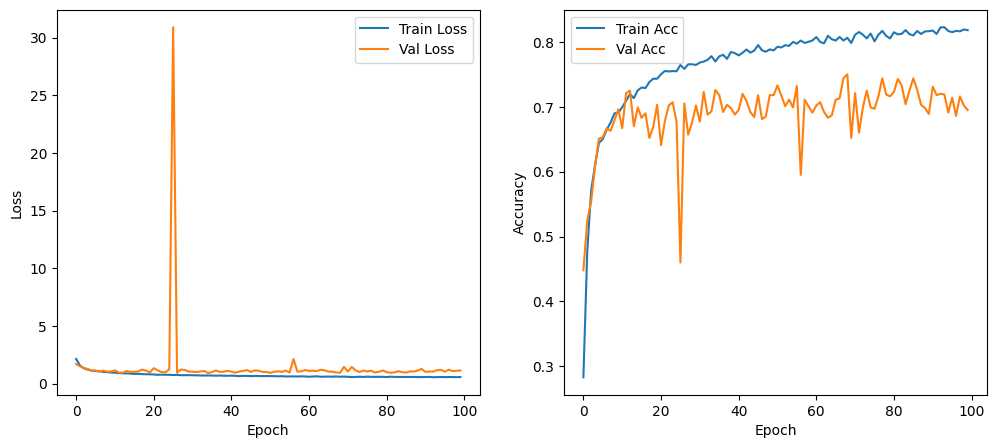

In [17]:
CustomRelu.grad_check = False
model = NN(input_dim=3072, hidden=hidden, output_dim=10)
train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, lr=lr, epochs=100, reg=reg, optimizer_init=RMSprop
)

plot_curves(train_losses, val_losses, train_accs, val_accs)


C помощью рандомизированного подбора гиперпараметров получили accuracy на валидационной выборке порядка 70% (к слову, было бы разумно добавить early stopping).